In [26]:
import numpy as np
import argparse
import os
import imp
import re
import pickle
import datetime
import random
import math
import logging
import copy
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import kneighbors_graph

from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

import torch
from torch import nn
import torch.nn.utils.rnn as rnn_utils
from torch.utils import data
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn import Parameter

from utils import utils
from utils.readers import InHospitalMortalityReader
from utils.preprocessing import Discretizer, Normalizer
from utils import metrics
from utils import common_utils

### Transfer Source Data & Model: 
#### Teacher Model


In [27]:
data_path = './data/Challenge/normalized/'
small_part = False
arg_timestep = 1.0
batch_size = 256
epochs = 100

In [28]:
all_x = pickle.load(open(data_path + 'new_x_front_fill.dat', 'rb'))
all_y = pickle.load(open(data_path + 'new_y_front_fill.dat', 'rb'))
all_names = pickle.load(open(data_path + 'new_name.dat', 'rb'))
# time = pickle.load(open(data_path + 'time', 'rb'))
# weight = pickle.load(open(data_path + 'weight', 'rb'))
static = pickle.load(open(data_path + 'new_demo_front_fill.dat', 'rb'))
mask_x = pickle.load(open(data_path + 'new_mask_x.dat', 'rb'))
mask_demo = pickle.load(open(data_path + 'new_mask_demo.dat', 'rb'))
all_x_len = [len(i) for i in all_x]

print(all_x[0])
print(mask_x[0])
print(all_names[0])
print(static[0])

[[-0.06242012453646045, 0.2744523712853132, 0.02957319402431667, -0.11839355366098099, -0.14686926072725967, -0.1311661871017867, -0.1425010869914041, 0.005325137533142886, 0.16066034068876195, -0.01724690479013476, -0.004930129148398766, 0.014295447077977357, -0.11026740609348425, 0.39895882324044557, -0.2561829490343818, -0.34587251014597875, -0.2371260510881844, 0.3051487380880145, 0.029264930048844468, -0.3160730875843661, -0.3766591890459441, -0.1935716453287135, -0.3351561343174943, -0.12930577851172065, -0.17160263114220592, -0.05532679134287014, -0.2815944741293343, -0.32211134163582006, -0.0899704549996704, -0.06645805008034258, -0.33684497792590695, -0.14828727498338712, -0.24435830491350327, -0.14487324959363315], [-0.06242012453646045, 0.2744523712853132, 0.02957319402431667, -0.11839355366098099, -0.14686926072725967, -0.1311661871017867, -0.1425010869914041, 0.005325137533142886, 0.16066034068876195, -0.01724690479013476, -0.004930129148398766, 0.014295447077977357, -0.11

In [29]:
subset_idx = [27, 29, 18, 16, 26, 33, 28, 31, 32, 15, 11, 25, 21, 20, 9, 17, 30, 19]
other_idx = []
for i in range(len(all_x[0][0])):
    if i not in subset_idx:
        other_idx.append(i)

for i in range(len(all_x)):
    cur = np.array(all_x[i], dtype=float)
    cur_mask = np.array(mask_x[i])
    cur_subset = cur[:, subset_idx]
    cur_other = cur[:, other_idx]
    cur_mask_subset = cur_mask[:, subset_idx]
    cur_mask_other = cur_mask[:, other_idx]
    all_x[i] = np.concatenate((cur_subset, cur_other), axis=1).tolist()
    mask_x[i] = np.concatenate((cur_mask_subset, cur_mask_other), axis=1).tolist()
print(all_x[0])
print(mask_x[0])
print(len(all_x[0][0]))

[[-0.32211134163582006, -0.06645805008034258, 0.029264930048844468, -0.2371260510881844, -0.2815944741293343, -0.14487324959363315, -0.0899704549996704, -0.14828727498338712, -0.24435830491350327, -0.34587251014597875, 0.014295447077977357, -0.05532679134287014, -0.1935716453287135, -0.3766591890459441, -0.01724690479013476, 0.3051487380880145, -0.33684497792590695, -0.3160730875843661, -0.06242012453646045, 0.2744523712853132, 0.02957319402431667, -0.11839355366098099, -0.14686926072725967, -0.1311661871017867, -0.1425010869914041, 0.005325137533142886, 0.16066034068876195, -0.004930129148398766, -0.11026740609348425, 0.39895882324044557, -0.2561829490343818, -0.3351561343174943, -0.12930577851172065, -0.17160263114220592], [-0.32211134163582006, -0.06645805008034258, 0.029264930048844468, -0.2371260510881844, -0.2815944741293343, -0.14487324959363315, -0.0899704549996704, -0.14828727498338712, -0.24435830491350327, -0.34587251014597875, 0.014295447077977357, -0.05532679134287014, -0.

In [30]:
train_num =int( len(all_x) * 0.8) + 1
print(train_num)
dev_num =int( len(all_x) * 0.1) + 1
print(dev_num)
test_num =int( len(all_x) * 0.1)
print(test_num)
assert(train_num+dev_num+test_num == len(all_x))

train_x = []
train_y = []
train_names = []
train_static = []
train_x_len = []
train_mask_x = []
for idx in range(train_num):
    train_x.append(all_x[idx])
    train_y.append(int(all_y[idx][-1]))
    train_names.append(all_names[idx])
    train_static.append(static[idx])
    train_x_len.append(all_x_len[idx])
    train_mask_x.append(mask_x[idx])

dev_x = []
dev_y = []
dev_names = []
dev_static = []
dev_x_len = []
dev_mask_x = []
for idx in range(train_num, train_num + dev_num):
    dev_x.append(all_x[idx])
    dev_y.append(int(all_y[idx][-1]))
    dev_names.append(all_names[idx])
    dev_static.append(static[idx])
    dev_x_len.append(all_x_len[idx])
    dev_mask_x.append(mask_x[idx])


test_x = []
test_y = []
test_names = []
test_static = []
test_x_len = []
test_mask_x = []
for idx in range(train_num + dev_num, train_num + dev_num + test_num):
    test_x.append(all_x[idx])
    test_y.append(int(all_y[idx][-1]))
    test_names.append(all_names[idx])
    test_static.append(static[idx])
    test_x_len.append(all_x_len[idx])
    test_mask_x.append(mask_x[idx])


assert(len(train_x) == train_num)
assert(len(dev_x) == dev_num)
assert(len(test_x) == test_num)

32269
4034
4033


In [31]:
long_x = all_x
long_y = [y[-1] for y in all_y]


In [2]:
#device = torch.device("cuda:0" if torch.cuda.is_available() == True else 'cpu')
device = torch.device('cuda')
print("available device: {}".format(device))

available device: cuda


In [3]:
def get_loss(y_pred, y_true):
    loss = torch.nn.BCELoss()
    return loss(y_pred, y_true)

In [4]:
def get_re_loss(y_pred, y_true):
    loss = torch.nn.MSELoss()
    return loss(y_pred, y_true)

In [5]:
def get_kl_loss(x_pred, x_target):
    loss = torch.nn.KLDivLoss(reduce=True, size_average=True)
    return loss(x_pred, x_target)

In [6]:
def get_wass_dist(x_pred, x_target):
    m1 = torch.mean(x_pred, dim=0)
    m2 = torch.mean(x_target, dim=0)
    v1 = torch.var(x_pred, dim=0)
    v2 = torch.var(x_target, dim=0)
    p1 = torch.sum(torch.pow((m1 - m2), 2))
    p2 = torch.sum(torch.pow(torch.pow(v1, 1/2) - torch.pow(v2, 1/2), 2))
    return torch.pow(p1+p2, 1/2)

In [7]:
def pad_sents(sents, pad_token):

    sents_padded = []

    max_length = max([len(_) for _ in sents])
    for i in sents:
        padded = list(i) + [pad_token]*(max_length-len(i))
        sents_padded.append(np.array(padded))


    return np.array(sents_padded)

In [8]:
def batch_iter(x, y, mask, lens, batch_size, shuffle=False):
    """ Yield batches of source and target sentences reverse sorted by length (largest to smallest).
    @param data (list of (src_sent, tgt_sent)): list of tuples containing source and target sentence
    @param batch_size (int): batch size
    @param shuffle (boolean): whether to randomly shuffle the dataset
    """
    batch_num = math.ceil(len(x) / batch_size) # 向下取整
    index_array = list(range(len(x)))

    if shuffle:
        np.random.shuffle(index_array)

    for i in range(batch_num):
        indices = index_array[i * batch_size: (i + 1) * batch_size] #  fetch out all the induces
        
        examples = []
        for idx in indices:
            examples.append((x[idx], y[idx], mask[idx], lens[idx]))
       
        examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)
    
        batch_x = [e[0] for e in examples]
        batch_y = [e[1] for e in examples]
        batch_mask_x = [e[2] for e in examples]
#         batch_name = [e[2] for e in examples]
        batch_lens = [e[3] for e in examples]

        yield batch_x, batch_y, batch_mask_x, batch_lens

In [9]:
def length_to_mask(length, max_len=None, dtype=None):
    """length: B.
    return B x max_len.
    If max_len is None, then max of length will be used.
    """
    assert len(length.shape) == 1, 'Length shape should be 1 dimensional.'
    max_len = max_len or length.max().item()
    mask = torch.arange(max_len, device=length.device,
                        dtype=length.dtype).expand(len(length), max_len) < length.unsqueeze(1)
    if dtype is not None:
        mask = torch.as_tensor(mask, dtype=dtype, device=length.device)
    return mask

In [10]:
class SingleAttention(nn.Module):
    def __init__(self, attention_input_dim, attention_hidden_dim, attention_type='add', demographic_dim=12, time_aware=False, use_demographic=False):
        super(SingleAttention, self).__init__()
        
        self.attention_type = attention_type
        self.attention_hidden_dim = attention_hidden_dim
        self.attention_input_dim = attention_input_dim
        self.use_demographic = use_demographic
        self.demographic_dim = demographic_dim
        self.time_aware = time_aware

        # batch_time = torch.arange(0, batch_mask.size()[1], dtype=torch.float32).reshape(1, batch_mask.size()[1], 1)
        # batch_time = batch_time.repeat(batch_mask.size()[0], 1, 1)
        
        if attention_type == 'add':
            if self.time_aware == True:
                # self.Wx = nn.Parameter(torch.randn(attention_input_dim+1, attention_hidden_dim))
                self.Wx = nn.Parameter(torch.randn(attention_input_dim, attention_hidden_dim))
                self.Wtime_aware = nn.Parameter(torch.randn(1, attention_hidden_dim))
                nn.init.kaiming_uniform_(self.Wtime_aware, a=math.sqrt(5))
            else:
                self.Wx = nn.Parameter(torch.randn(attention_input_dim, attention_hidden_dim))
            self.Wt = nn.Parameter(torch.randn(attention_input_dim, attention_hidden_dim))
            self.Wd = nn.Parameter(torch.randn(demographic_dim, attention_hidden_dim))
            self.bh = nn.Parameter(torch.zeros(attention_hidden_dim,))
            self.Wa = nn.Parameter(torch.randn(attention_hidden_dim, 1))
            self.ba = nn.Parameter(torch.zeros(1,))
            
            nn.init.kaiming_uniform_(self.Wd, a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.Wx, a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.Wt, a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.Wa, a=math.sqrt(5))
        elif attention_type == 'mul':
            self.Wa = nn.Parameter(torch.randn(attention_input_dim, attention_input_dim))
            self.ba = nn.Parameter(torch.zeros(1,))
            
            nn.init.kaiming_uniform_(self.Wa, a=math.sqrt(5))
        elif attention_type == 'concat':
            if self.time_aware == True:
                self.Wh = nn.Parameter(torch.randn(2*attention_input_dim+1, attention_hidden_dim))
            else:
                self.Wh = nn.Parameter(torch.randn(2*attention_input_dim, attention_hidden_dim))

            self.Wa = nn.Parameter(torch.randn(attention_hidden_dim, 1))
            self.ba = nn.Parameter(torch.zeros(1,))
            
            nn.init.kaiming_uniform_(self.Wh, a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.Wa, a=math.sqrt(5))
        else:
            raise RuntimeError('Wrong attention type.')
        
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()
    
    def forward(self, input, demo=None):
 
        batch_size, time_step, input_dim = input.size() # batch_size * time_step * hidden_dim(i)
        #assert(input_dim == self.input_dim)

        # time_decays = torch.zeros((time_step,time_step)).to(device)# t*t
        # for this_time in range(time_step):
        #     for pre_time in range(time_step):
        #         if pre_time > this_time:
        #             break
        #         time_decays[this_time][pre_time] = torch.tensor(this_time - pre_time, dtype=torch.float32).to(device)
        # b_time_decays = tile(time_decays, 0, batch_size).view(batch_size,time_step,time_step).unsqueeze(-1).to(device)# b t t 1

        time_decays = torch.tensor(range(time_step-1,-1,-1), dtype=torch.float32).unsqueeze(-1).unsqueeze(0).to(device)# 1*t*1
        b_time_decays = time_decays.repeat(batch_size,1,1)# b t 1
        
        if self.attention_type == 'add': #B*T*I  @ H*I
            q = torch.matmul(input[:,-1,:], self.Wt)# b h
            q = torch.reshape(q, (batch_size, 1, self.attention_hidden_dim)) #B*1*H
            if self.time_aware == True:
                # k_input = torch.cat((input, time), dim=-1)
                k = torch.matmul(input, self.Wx)#b t h
                # k = torch.reshape(k, (batch_size, 1, time_step, self.attention_hidden_dim)) #B*1*T*H
                time_hidden = torch.matmul(b_time_decays, self.Wtime_aware)#  b t h
            else:
                k = torch.matmul(input, self.Wx)# b t h
                # k = torch.reshape(k, (batch_size, 1, time_step, self.attention_hidden_dim)) #B*1*T*H
            if self.use_demographic == True:
                d = torch.matmul(demo, self.Wd) #B*H
                d = torch.reshape(d, (batch_size, 1, self.attention_hidden_dim)) # b 1 h
            h = q + k + self.bh # b t h
            if self.time_aware == True:
                h += time_hidden
            h = self.tanh(h) #B*T*H
            e = torch.matmul(h, self.Wa) + self.ba #B*T*1
            e = torch.reshape(e, (batch_size, time_step))# b t
        elif self.attention_type == 'mul':
            e = torch.matmul(input[:,-1,:], self.Wa)#b i
            e = torch.matmul(e.unsqueeze(1), input.permute(0,2,1)).squeeze() + self.ba #b t
        elif self.attention_type == 'concat':
            q = input[:,-1,:].unsqueeze(1).repeat(1,time_step,1)# b t i
            k = input
            c = torch.cat((q, k), dim=-1) #B*T*2I
            if self.time_aware == True:
                c = torch.cat((c, b_time_decays), dim=-1) #B*T*2I+1
            h = torch.matmul(c, self.Wh)
            h = self.tanh(h)
            e = torch.matmul(h, self.Wa) + self.ba #B*T*1
            e = torch.reshape(e, (batch_size, time_step)) # b t 
        
        # e = torch.exp(e - torch.max(e, dim=-1, keepdim=True).values)
        
        # if self.attention_width is not None:
        #     if self.history_only:
        #         lower = torch.arange(0, time_step).to(device) - (self.attention_width - 1)
        #     else:
        #         lower = torch.arange(0, time_step).to(device) - self.attention_width // 2
        #     lower = lower.unsqueeze(-1)
        #     upper = lower + self.attention_width
        #     indices = torch.arange(0, time_step).unsqueeze(0).to(device)
        #     e = e * (lower <= indices).float() * (indices < upper).float()
        
        # s = torch.sum(e, dim=-1, keepdim=True)
        # mask = subsequent_mask(time_step).to(device) # 1 t t 下三角
        # scores = e.masked_fill(mask == 0, -1e9)# b t t 下三角
        a = self.softmax(e) #B*T
        v = torch.matmul(a.unsqueeze(1), input).squeeze() #B*I

        return v, a

class FinalAttentionQKV(nn.Module):
    def __init__(self, attention_input_dim, attention_hidden_dim, attention_type='add', dropout=None):
        super(FinalAttentionQKV, self).__init__()
        
        self.attention_type = attention_type
        self.attention_hidden_dim = attention_hidden_dim
        self.attention_input_dim = attention_input_dim


        self.W_q = nn.Linear(attention_input_dim, attention_hidden_dim)
        self.W_k = nn.Linear(attention_input_dim, attention_hidden_dim)
        self.W_v = nn.Linear(attention_input_dim, attention_hidden_dim)

        self.W_out = nn.Linear(attention_hidden_dim, 1)

        self.b_in = nn.Parameter(torch.zeros(1,))
        self.b_out = nn.Parameter(torch.zeros(1,))

        nn.init.kaiming_uniform_(self.W_q.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_k.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_v.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_out.weight, a=math.sqrt(5))

        self.Wh = nn.Parameter(torch.randn(2*attention_input_dim, attention_hidden_dim))
        self.Wa = nn.Parameter(torch.randn(attention_hidden_dim, 1))
        self.ba = nn.Parameter(torch.zeros(1,))
        
        nn.init.kaiming_uniform_(self.Wh, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.Wa, a=math.sqrt(5))
        
        self.dropout = nn.Dropout(p=dropout)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input):
 
        batch_size, time_step, input_dim = input.size() # batch_size * input_dim + 1 * hidden_dim(i)
        input_q = self.W_q(torch.mean(input, dim=1)) # b h
        input_k = self.W_k(input)# b t h
        input_v = self.W_v(input)# b t h

        if self.attention_type == 'add': #B*T*I  @ H*I

            q = torch.reshape(input_q, (batch_size, 1, self.attention_hidden_dim)) #B*1*H
            h = q + input_k + self.b_in # b t h
            h = self.tanh(h) #B*T*H
            e = self.W_out(h) # b t 1
            e = torch.reshape(e, (batch_size, time_step))# b t

        elif self.attention_type == 'mul':
            q = torch.reshape(input_q, (batch_size, self.attention_hidden_dim, 1)) #B*h 1
            e = torch.matmul(input_k, q).squeeze()#b t
            
        elif self.attention_type == 'concat':
            q = input_q.unsqueeze(1).repeat(1,time_step,1)# b t h
            k = input_k
            c = torch.cat((q, k), dim=-1) #B*T*2I
            h = torch.matmul(c, self.Wh)
            h = self.tanh(h)
            e = torch.matmul(h, self.Wa) + self.ba #B*T*1
            e = torch.reshape(e, (batch_size, time_step)) # b t 
        
        a = self.softmax(e) #B*T
        if self.dropout is not None:
            a = self.dropout(a)
        v = torch.matmul(a.unsqueeze(1), input_v).squeeze() #B*I

        return v, a

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

def tile(a, dim, n_tile):
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)])).to(device)
    return torch.index_select(a, dim, order_index).to(device)

class PositionwiseFeedForward(nn.Module): # new added
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x)))), None

# class PositionwiseFeedForwardConv(nn.Module):

#     def __init__(self, model_dim=512, ffn_dim=2048, dropout=0.0):
#         super(PositionalWiseFeedForward, self).__init__()
#         self.w1 = nn.Conv1d(model_dim, ffn_dim, 1)
#         self.w2 = nn.Conv1d(model_dim, ffn_dim, 1)
#         self.dropout = nn.Dropout(dropout)
#         self.layer_norm = nn.LayerNorm(model_dim)

#     def forward(self, x):
#         output = x.transpose(1, 2)
#         output = self.w2(F.relu(self.w1(output)))
#         output = self.dropout(output.transpose(1, 2))

#         # add residual and norm layer
#         output = self.layer_norm(x + output)
#         return output

class PositionalEncoding(nn.Module): # new added / not use anymore
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=400):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0 # 下三角矩阵

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)# b h t d_k
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k) # b h t t
    if mask is not None:# 1 1 t t
        scores = scores.masked_fill(mask == 0, -1e9)# b h t t 下三角
    p_attn = F.softmax(scores, dim = -1)# b h t t
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn # b h t v (d_k) 
    
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, self.d_k * self.h), 3)
        self.final_linear = nn.Linear(d_model, d_model)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1) # 1 1 t t

        nbatches = query.size(0)# b
        input_dim = query.size(1)# i+1
        feature_dim = query.size(-1)# i+1

        #input size -> # batch_size * d_input * hidden_dim
        
        # d_model => h * d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))] # b num_head d_input d_k
        
       
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)# b num_head d_input d_v (d_k) 

        #Str DeCov
        # DeCov_contexts = x.transpose(1, 2).transpose(0, 1).transpose(1, 2).transpose(2, 3)#d_input num_head d_v b (d_k) 
        # DeCov_between_loss = torch.tensor(0.0, dtype = torch.float32, device = device)
        # DeCov_inside_loss = torch.tensor(0.0, dtype = torch.float32, device = device)
        # for input_idx in range(input_dim):
        #     current_input = DeCov_contexts[input_idx,:,:,:]
        #     for i in range(self.h):
        #         for j in range(self.h):
        #             if i == j:
        #                 covs = cov(current_input[i,:,:])
        #                 DeCov_inside_loss += 0.5 * (torch.norm(covs, p = 'fro')**2)  
        #                 #print(DeCov_inside_loss)
        #             else:
        #                 Vstack_context = torch.cat((current_input[i,:,:],current_input[j,:,:]) ,0)# 2*d_v b
        #                 assert(Vstack_context.size(0) == 2*self.d_k)
        #                 assert(Vstack_context.size(1) == nbatches)
        #                 overflow_covs = cov(Vstack_context)[self.d_k:,:]
        #                 covs = overflow_covs[:,:self.d_k]
        #                 DeCov_between_loss += 0.5 * (torch.norm(covs, p = 'fro')**2) 
        #                 #print(DeCov_between_loss)
        # DeCov_loss = DeCov_between_loss + 0.1 * DeCov_inside_loss
        #print(DeCov_loss)


      
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)# batch_size * d_input * hidden_dim

        #DeCov 
        DeCov_contexts = x.transpose(0, 1).transpose(1, 2) # I+1 H B
#         print(DeCov_contexts.shape)
        Covs = cov(DeCov_contexts[0,:,:])
        DeCov_loss = 0.5 * (torch.norm(Covs, p = 'fro')**2 - torch.norm(torch.diag(Covs))**2 ) 
        for i in range(11 -1):
            Covs = cov(DeCov_contexts[i+1,:,:])
            DeCov_loss += 0.5 * (torch.norm(Covs, p = 'fro')**2 - torch.norm(torch.diag(Covs))**2 ) 


        return self.final_linear(x), DeCov_loss

class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-7):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

def cov(m, y=None):
    if y is not None:
        m = torch.cat((m, y), dim=0)
    m_exp = torch.mean(m, dim=1)
    x = m - m_exp[:, None]
    cov = 1 / (x.size(1) - 1) * x.mm(x.t())
    return cov

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        returned_value = sublayer(self.norm(x))
        return x + self.dropout(returned_value[0]) , returned_value[1]

class concare_teacher(nn.Module):
    def __init__(self, input_dim, hidden_dim, d_model,  MHD_num_head, d_ff, output_dim, keep_prob=0.5):
        super(concare_teacher, self).__init__()

        # hyperparameters
        self.input_dim = input_dim  
        self.hidden_dim = hidden_dim  # d_model
        self.d_model = d_model
        self.MHD_num_head = MHD_num_head
        self.d_ff = d_ff
        self.output_dim = output_dim
        self.keep_prob = keep_prob

        # layers
        self.PositionalEncoding = PositionalEncoding(self.d_model, dropout = 0, max_len = 400)

        self.GRUs = clones(nn.GRU(1, self.hidden_dim, batch_first = True), self.input_dim)
        self.LastStepAttentions = clones(SingleAttention(self.hidden_dim, 8, attention_type='concat', demographic_dim=12, time_aware=True, use_demographic=False),self.input_dim)
        
        self.FinalAttentionQKV = FinalAttentionQKV(self.hidden_dim, self.hidden_dim, attention_type='mul',dropout = 1 - self.keep_prob)

        self.MultiHeadedAttention = MultiHeadedAttention(self.MHD_num_head, self.d_model,dropout = 1 - self.keep_prob)
        self.SublayerConnection = SublayerConnection(self.d_model, dropout = 1 - self.keep_prob)

        self.PositionwiseFeedForward = PositionwiseFeedForward(self.d_model, self.d_ff, dropout=0.1)

        self.demo_proj_main = nn.Linear(12, self.hidden_dim)
        self.demo_proj = nn.Linear(12, self.hidden_dim)
        self.output = nn.Linear(self.hidden_dim, self.output_dim)

        self.dropout = nn.Dropout(p = 1 - self.keep_prob)
        self.tanh=nn.Tanh()
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.relu=nn.ReLU()

    def forward(self, input, lens):
        # input shape [batch_size, timestep, feature_dim]
#         demo_main = self.tanh(self.demo_proj_main(demo_input)).unsqueeze(1)# b hidden_dim
        
        batch_size = input.size(0)
        time_step = input.size(1)
        feature_dim = input.size(2)
        assert(feature_dim == self.input_dim)# input Tensor : 256 * 48 * 76
        assert(self.d_model % self.MHD_num_head == 0)

        # Initialization
        #cur_hs = Variable(torch.zeros(batch_size, self.hidden_dim).unsqueeze(0))

        # forward
        # GRU_embeded_input = self.GRUs[0](input[:,:,0].unsqueeze(-1), Variable(torch.zeros(batch_size, self.hidden_dim).unsqueeze(0)).to(device))[0] # b t h
        # Attention_embeded_input = self.LastStepAttentions[0](GRU_embeded_input)[0].unsqueeze(1)# b 1 h
        # for i in range(feature_dim-1):
        #     embeded_input = self.GRUs[i+1](input[:,:,i+1].unsqueeze(-1), Variable(torch.zeros(batch_size, self.hidden_dim).unsqueeze(0)).to(device))[0] # b 1 h
        #     embeded_input = self.LastStepAttentions[i+1](embeded_input)[0].unsqueeze(1)# b 1 h
        #     Attention_embeded_input = torch.cat((Attention_embeded_input, embeded_input), 1)# b i h

        # Attention_embeded_input = torch.cat((Attention_embeded_input, demo_main), 1)# b i+1 h
        # posi_input = self.dropout(Attention_embeded_input) # batch_size * d_input+1 * hidden_dim

#         input = pack_padded_sequence(input, lens, batch_first=True)
        
        GRU_embeded_input = self.GRUs[0](pack_padded_sequence(input[:,:,0].unsqueeze(-1), lens, batch_first=True))[1].squeeze().unsqueeze(1) # b 1 h
#         print(GRU_embeded_input.shape)
        for i in range(feature_dim-1):
            embeded_input = self.GRUs[i+1](pack_padded_sequence(input[:,:,i+1].unsqueeze(-1), lens, batch_first=True))[1].squeeze().unsqueeze(1) # b 1 h
            GRU_embeded_input = torch.cat((GRU_embeded_input, embeded_input), 1)

#         GRU_embeded_input = torch.cat((GRU_embeded_input, demo_main), 1)# b i+1 h
        posi_input = self.dropout(GRU_embeded_input) # batch_size * d_input * hidden_dim


        #mask = subsequent_mask(time_step).to(device) # 1 t t 下三角 N to 1任务不用mask
        contexts = self.SublayerConnection(posi_input, lambda x: self.MultiHeadedAttention(posi_input, posi_input, posi_input, None))# # batch_size * d_input * hidden_dim
    
        DeCov_loss = contexts[1]
        contexts = contexts[0]

        contexts = self.SublayerConnection(contexts, lambda x: self.PositionwiseFeedForward(contexts))[0]# # batch_size * d_input * hidden_dim
        #contexts = contexts.view(batch_size, feature_dim * self.hidden_dim)#
        # contexts = torch.matmul(self.Wproj, contexts) + self.bproj
        # contexts = contexts.squeeze()
        # demo_key = self.demo_proj(demo_input)# b hidden_dim
        # demo_key = self.relu(demo_key)
        # input_dim_scores = torch.matmul(contexts, demo_key.unsqueeze(-1)).squeeze() # b i
        # input_dim_scores = self.dropout(self.sigmoid(input_dim_scores)).unsqueeze(1)# b i
        
        # weighted_contexts = torch.matmul(input_dim_scores, contexts).squeeze()
#         print(contexts.shape)

        weighted_contexts = self.FinalAttentionQKV(contexts)[0]
        output = self.output(self.dropout(weighted_contexts))# b 1
        output = self.sigmoid(output)
#         print(weighted_contexts.shape)
          
        return output, DeCov_loss  ,weighted_contexts
    #, self.MultiHeadedAttention.attn




In [32]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED) #numpy
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED) # cpu
torch.cuda.manual_seed(RANDOM_SEED) #gpu
torch.backends.cudnn.deterministic=True # cudnn
    
epochs = 150
batch_size = 256
input_dim = 34
hidden_dim = 32
d_model = 32
MHD_num_head = 4
d_ff = 64
output_dim = 1

model = concare_teacher(input_dim = input_dim, hidden_dim = hidden_dim, d_model=d_model, MHD_num_head=MHD_num_head, d_ff=d_ff, output_dim = output_dim).to(device)
# input_dim, d_model, d_k, d_v, MHD_num_head, d_ff, output_dim
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [33]:
total_train_loss = []
total_valid_loss = []
global_best = 0
auroc = []
auprc = []
minpse = []
history = []

pad_token = np.zeros(input_dim)
# begin_time = time.time()
best_auroc = 0
best_auprc = 0
best_minpse = 0
    
file_name = './model/concare-challenge-front-fill-teacher-2covid-nodecov'

for each_epoch in range(epochs):

    epoch_loss = []
    counter_batch = 0
    model.train()  

    for step, (batch_x, batch_y, batch_mask_x, batch_lens) in enumerate(batch_iter(train_x, train_y, train_mask_x, train_x_len, batch_size, shuffle=True)):  
        optimizer.zero_grad()
        batch_x = torch.tensor(pad_sents(batch_x, pad_token), dtype=torch.float32).to(device)
        batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)
        batch_lens = torch.tensor(batch_lens, dtype=torch.float32).to(device).int()
        batch_mask_x = torch.tensor(pad_sents(batch_mask_x, pad_token), dtype=torch.float32).to(device)

#        masks = length_to_mask(batch_lens).unsqueeze(-1).float()

        opt, decov_loss, emb = model(batch_x, batch_lens)

        BCE_Loss = get_loss(opt, batch_y.unsqueeze(-1)) # b t 1
#             REC_Loss = F.mse_loss(masks * recon, masks * batch_x, reduction='mean').to(device)

        loss = BCE_Loss #+ 1000 * decov_loss

        epoch_loss.append(BCE_Loss.cpu().detach().numpy())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 20)
        optimizer.step()

        if step % 20 == 0:
            print('Epoch %d Batch %d: Train Loss = %.4f'%(each_epoch, step, loss.cpu().detach().numpy()))

    epoch_loss = np.mean(epoch_loss)
    total_train_loss.append(epoch_loss)

    #Validation
    y_true = []
    y_pred = []
    with torch.no_grad():
        model.eval()
        valid_loss = []
        valid_true = []
        valid_pred = []
        for batch_x, batch_y, batch_mask_x, batch_lens in batch_iter(dev_x, dev_y, dev_mask_x, dev_x_len, batch_size):
            batch_x = torch.tensor(pad_sents(batch_x, pad_token), dtype=torch.float32).to(device)
            batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)
            batch_lens = torch.tensor(batch_lens, dtype=torch.float32).to(device).int()
            batch_mask_x = torch.tensor(pad_sents(batch_mask_x, pad_token), dtype=torch.float32).to(device)
#            masks = length_to_mask(batch_lens).unsqueeze(-1).float()


            opt, decov_loss, emb = model(batch_x, batch_lens)

            BCE_Loss = get_loss(opt, batch_y.unsqueeze(-1))
#                 REC_Loss = F.mse_loss(recon, batch_x, reduction='mean').to(device)

            valid_loss.append(BCE_Loss.cpu().detach().numpy())

            y_pred += list(opt.cpu().detach().numpy().flatten())
            y_true += list(batch_y.cpu().numpy().flatten())

        valid_loss = np.mean(valid_loss)
        total_valid_loss.append(valid_loss)
        ret = metrics.print_metrics_binary(y_true, y_pred,verbose = 0)
        history.append(ret)
        #print()

        print('Epoch %d: Loss = %.4f Valid loss = %.4f roc = %.4f'%(each_epoch, total_train_loss[-1], total_valid_loss[-1], ret['auroc']))
        metrics.print_metrics_binary(y_true, y_pred)

        cur_auroc = ret['auroc']
        if cur_auroc > best_auroc:
            best_auroc = cur_auroc
            best_auprc = ret['auprc']
            best_minpse = ret['minpse']
            state = {
                'net': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': each_epoch
            }
            torch.save(state, file_name)
            print('------------ Save best model - AUROC: %.4f ------------'%cur_auroc)       

print('auroc %.4f'%(best_auroc))
print('auprc %.4f'%(best_auprc))
print('minpse %.4f'%(best_minpse))  

/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0 Batch 0: Train Loss = 0.5760
Epoch 0 Batch 20: Train Loss = 0.2908
Epoch 0 Batch 40: Train Loss = 0.2447
Epoch 0 Batch 60: Train Loss = 0.3297
Epoch 0 Batch 80: Train Loss = 0.2419
Epoch 0 Batch 100: Train Loss = 0.2468
Epoch 0 Batch 120: Train Loss = 0.2563


/home/ubicomp/mxy/EMR/utils/metrics.py:23: RuntimeWarning: invalid value encountered in float_scalars
  prec1 = cf[1][1] / (cf[1][1] + cf[0][1])


Epoch 0: Loss = 0.2951 Valid loss = 0.2432 roc = 0.7637
confusion matrix:
[[3742    0]
 [ 292    0]]
accuracy = 0.9276152849197388
precision class 0 = 0.9276152849197388
precision class 1 = nan
recall class 0 = 1.0
recall class 1 = 0.0
AUC of ROC = 0.7637050364979536
AUC of PRC = 0.23329456940835797
min(+P, Se) = 0.31399317406143346
f1_score = nan
------------ Save best model - AUROC: 0.7637 ------------
Epoch 1 Batch 0: Train Loss = 0.2286
Epoch 1 Batch 20: Train Loss = 0.2074
Epoch 1 Batch 40: Train Loss = 0.2501
Epoch 1 Batch 60: Train Loss = 0.3016
Epoch 1 Batch 80: Train Loss = 0.2216
Epoch 1 Batch 100: Train Loss = 0.2381
Epoch 1 Batch 120: Train Loss = 0.2039
Epoch 1: Loss = 0.2545 Valid loss = 0.2230 roc = 0.8061
confusion matrix:
[[3742    0]
 [ 292    0]]
accuracy = 0.9276152849197388
precision class 0 = 0.9276152849197388
precision class 1 = nan
recall class 0 = 1.0
recall class 1 = 0.0
AUC of ROC = 0.8061142309072139
AUC of PRC = 0.32057524570836526
min(+P, Se) = 0.34589041

Epoch 12 Batch 0: Train Loss = 0.1778
Epoch 12 Batch 20: Train Loss = 0.1173
Epoch 12 Batch 40: Train Loss = 0.0923
Epoch 12 Batch 60: Train Loss = 0.1607
Epoch 12 Batch 80: Train Loss = 0.1312
Epoch 12 Batch 100: Train Loss = 0.1717
Epoch 12 Batch 120: Train Loss = 0.1773
Epoch 12: Loss = 0.1466 Valid loss = 0.1361 roc = 0.9227
confusion matrix:
[[3699   43]
 [ 131  161]]
accuracy = 0.9568666219711304
precision class 0 = 0.9657963514328003
precision class 1 = 0.7892156839370728
recall class 0 = 0.9885088205337524
recall class 1 = 0.551369845867157
AUC of ROC = 0.9226752231244005
AUC of PRC = 0.7042233701620009
min(+P, Se) = 0.6372881355932203
f1_score = 0.6491935645752479
Epoch 13 Batch 0: Train Loss = 0.1487
Epoch 13 Batch 20: Train Loss = 0.1503
Epoch 13 Batch 40: Train Loss = 0.1321
Epoch 13 Batch 60: Train Loss = 0.1088
Epoch 13 Batch 80: Train Loss = 0.1566
Epoch 13 Batch 100: Train Loss = 0.0854
Epoch 13 Batch 120: Train Loss = 0.1857
Epoch 13: Loss = 0.1460 Valid loss = 0.1398 

Epoch 24 Batch 0: Train Loss = 0.1019
Epoch 24 Batch 20: Train Loss = 0.1969
Epoch 24 Batch 40: Train Loss = 0.0894
Epoch 24 Batch 60: Train Loss = 0.1658
Epoch 24 Batch 80: Train Loss = 0.1129
Epoch 24 Batch 100: Train Loss = 0.1400
Epoch 24 Batch 120: Train Loss = 0.1336
Epoch 24: Loss = 0.1374 Valid loss = 0.1330 roc = 0.9315
confusion matrix:
[[3701   41]
 [ 124  168]]
accuracy = 0.959097683429718
precision class 0 = 0.9675816893577576
precision class 1 = 0.8038277626037598
recall class 0 = 0.9890432953834534
recall class 1 = 0.5753424763679504
AUC of ROC = 0.9315297291756661
AUC of PRC = 0.717463262287053
min(+P, Se) = 0.6541095890410958
f1_score = 0.6706587228009783
Epoch 25 Batch 0: Train Loss = 0.1041
Epoch 25 Batch 20: Train Loss = 0.2020
Epoch 25 Batch 40: Train Loss = 0.1048
Epoch 25 Batch 60: Train Loss = 0.1399
Epoch 25 Batch 80: Train Loss = 0.1074
Epoch 25 Batch 100: Train Loss = 0.1111
Epoch 25 Batch 120: Train Loss = 0.1408
Epoch 25: Loss = 0.1350 Valid loss = 0.1406 r

Epoch 36 Batch 0: Train Loss = 0.1580
Epoch 36 Batch 20: Train Loss = 0.1419
Epoch 36 Batch 40: Train Loss = 0.2055
Epoch 36 Batch 60: Train Loss = 0.1276
Epoch 36 Batch 80: Train Loss = 0.1361
Epoch 36 Batch 100: Train Loss = 0.0944
Epoch 36 Batch 120: Train Loss = 0.0947
Epoch 36: Loss = 0.1258 Valid loss = 0.1492 roc = 0.9304
confusion matrix:
[[3699   43]
 [ 126  166]]
accuracy = 0.9581061005592346
precision class 0 = 0.9670588374137878
precision class 1 = 0.7942583560943604
recall class 0 = 0.9885088205337524
recall class 1 = 0.568493127822876
AUC of ROC = 0.9304241743115907
AUC of PRC = 0.7160615677416422
min(+P, Se) = 0.6541095890410958
f1_score = 0.6626746292106203
Epoch 37 Batch 0: Train Loss = 0.1311
Epoch 37 Batch 20: Train Loss = 0.0834
Epoch 37 Batch 40: Train Loss = 0.1175
Epoch 37 Batch 60: Train Loss = 0.1219
Epoch 37 Batch 80: Train Loss = 0.1729
Epoch 37 Batch 100: Train Loss = 0.1109
Epoch 37 Batch 120: Train Loss = 0.1147
Epoch 37: Loss = 0.1270 Valid loss = 0.1323 

Epoch 48 Batch 0: Train Loss = 0.1235
Epoch 48 Batch 20: Train Loss = 0.1481
Epoch 48 Batch 40: Train Loss = 0.1597
Epoch 48 Batch 60: Train Loss = 0.0917
Epoch 48 Batch 80: Train Loss = 0.1075
Epoch 48 Batch 100: Train Loss = 0.2018
Epoch 48 Batch 120: Train Loss = 0.0811
Epoch 48: Loss = 0.1238 Valid loss = 0.1350 roc = 0.9303
confusion matrix:
[[3689   53]
 [ 117  175]]
accuracy = 0.9578582048416138
precision class 0 = 0.9692590832710266
precision class 1 = 0.7675438523292542
recall class 0 = 0.9858364462852478
recall class 1 = 0.5993150472640991
AUC of ROC = 0.9303436372022871
AUC of PRC = 0.7161308571410295
min(+P, Se) = 0.6484641638225256
f1_score = 0.6730768775234574
Epoch 49 Batch 0: Train Loss = 0.0817
Epoch 49 Batch 20: Train Loss = 0.1077
Epoch 49 Batch 40: Train Loss = 0.1329
Epoch 49 Batch 60: Train Loss = 0.1555
Epoch 49 Batch 80: Train Loss = 0.1185
Epoch 49 Batch 100: Train Loss = 0.0821
Epoch 49 Batch 120: Train Loss = 0.0828
Epoch 49: Loss = 0.1198 Valid loss = 0.1319

Epoch 60 Batch 60: Train Loss = 0.2526
Epoch 60 Batch 80: Train Loss = 0.1415
Epoch 60 Batch 100: Train Loss = 0.0997
Epoch 60 Batch 120: Train Loss = 0.1048
Epoch 60: Loss = 0.1160 Valid loss = 0.1372 roc = 0.9361
confusion matrix:
[[3699   43]
 [ 118  174]]
accuracy = 0.9600892663002014
precision class 0 = 0.969085693359375
precision class 1 = 0.8018433451652527
recall class 0 = 0.9885088205337524
recall class 1 = 0.5958904027938843
AUC of ROC = 0.9361093620728788
AUC of PRC = 0.7359079792882279
min(+P, Se) = 0.6746575342465754
f1_score = 0.6836935503652767
Epoch 61 Batch 0: Train Loss = 0.1371
Epoch 61 Batch 20: Train Loss = 0.1124
Epoch 61 Batch 40: Train Loss = 0.0911
Epoch 61 Batch 60: Train Loss = 0.2152
Epoch 61 Batch 80: Train Loss = 0.1030
Epoch 61 Batch 100: Train Loss = 0.1122
Epoch 61 Batch 120: Train Loss = 0.1115
Epoch 61: Loss = 0.1208 Valid loss = 0.1349 roc = 0.9298
confusion matrix:
[[3690   52]
 [ 119  173]]
accuracy = 0.9576103091239929
precision class 0 = 0.968758

Epoch 72 Batch 0: Train Loss = 0.1454
Epoch 72 Batch 20: Train Loss = 0.1013
Epoch 72 Batch 40: Train Loss = 0.0999
Epoch 72 Batch 60: Train Loss = 0.1380
Epoch 72 Batch 80: Train Loss = 0.1262
Epoch 72 Batch 100: Train Loss = 0.0676
Epoch 72 Batch 120: Train Loss = 0.1166
Epoch 72: Loss = 0.1137 Valid loss = 0.1344 roc = 0.9359
confusion matrix:
[[3711   31]
 [ 124  168]]
accuracy = 0.9615765810012817
precision class 0 = 0.9676662087440491
precision class 1 = 0.8442211151123047
recall class 0 = 0.991715669631958
recall class 1 = 0.5753424763679504
AUC of ROC = 0.9359006977442289
AUC of PRC = 0.7375107101874914
min(+P, Se) = 0.6712328767123288
f1_score = 0.6843177583310684
Epoch 73 Batch 0: Train Loss = 0.1405
Epoch 73 Batch 20: Train Loss = 0.1339
Epoch 73 Batch 40: Train Loss = 0.1645
Epoch 73 Batch 60: Train Loss = 0.0836
Epoch 73 Batch 80: Train Loss = 0.0640
Epoch 73 Batch 100: Train Loss = 0.1373
Epoch 73 Batch 120: Train Loss = 0.1935
Epoch 73: Loss = 0.1160 Valid loss = 0.1406 

Epoch 84 Batch 0: Train Loss = 0.0692
Epoch 84 Batch 20: Train Loss = 0.1400
Epoch 84 Batch 40: Train Loss = 0.1018
Epoch 84 Batch 60: Train Loss = 0.0826
Epoch 84 Batch 80: Train Loss = 0.1345
Epoch 84 Batch 100: Train Loss = 0.1243
Epoch 84 Batch 120: Train Loss = 0.1953
Epoch 84: Loss = 0.1220 Valid loss = 0.1487 roc = 0.9227
confusion matrix:
[[3714   28]
 [ 138  154]]
accuracy = 0.9588497877120972
precision class 0 = 0.9641744494438171
precision class 1 = 0.8461538553237915
recall class 0 = 0.992517352104187
recall class 1 = 0.5273972749710083
AUC of ROC = 0.9226770535132484
AUC of PRC = 0.7050040393988422
min(+P, Se) = 0.658703071672355
f1_score = 0.6497890433946956
Epoch 85 Batch 0: Train Loss = 0.1418
Epoch 85 Batch 20: Train Loss = 0.1280
Epoch 85 Batch 40: Train Loss = 0.1696
Epoch 85 Batch 60: Train Loss = 0.1303
Epoch 85 Batch 80: Train Loss = 0.1086
Epoch 85 Batch 100: Train Loss = 0.0815
Epoch 85 Batch 120: Train Loss = 0.0822
Epoch 85: Loss = 0.1213 Valid loss = 0.1350 r

Epoch 96 Batch 20: Train Loss = 0.1239
Epoch 96 Batch 40: Train Loss = 0.0822
Epoch 96 Batch 60: Train Loss = 0.0874
Epoch 96 Batch 80: Train Loss = 0.0819
Epoch 96 Batch 100: Train Loss = 0.1235
Epoch 96 Batch 120: Train Loss = 0.2654
Epoch 96: Loss = 0.1069 Valid loss = 0.1296 roc = 0.9373
confusion matrix:
[[3702   40]
 [ 119  173]]
accuracy = 0.9605849981307983
precision class 0 = 0.9688563346862793
precision class 1 = 0.8122065663337708
recall class 0 = 0.9893105030059814
recall class 1 = 0.5924657583236694
AUC of ROC = 0.9373393833786049
AUC of PRC = 0.7427452307702226
min(+P, Se) = 0.6836734693877551
f1_score = 0.6851484867643239
Epoch 97 Batch 0: Train Loss = 0.1143
Epoch 97 Batch 20: Train Loss = 0.1410
Epoch 97 Batch 40: Train Loss = 0.0728
Epoch 97 Batch 60: Train Loss = 0.0508
Epoch 97 Batch 80: Train Loss = 0.0969
Epoch 97 Batch 100: Train Loss = 0.0797
Epoch 97 Batch 120: Train Loss = 0.0914
Epoch 97: Loss = 0.1039 Valid loss = 0.1403 roc = 0.9386
confusion matrix:
[[3712

Epoch 108 Batch 0: Train Loss = 0.0891
Epoch 108 Batch 20: Train Loss = 0.1186
Epoch 108 Batch 40: Train Loss = 0.1056
Epoch 108 Batch 60: Train Loss = 0.0966
Epoch 108 Batch 80: Train Loss = 0.1347
Epoch 108 Batch 100: Train Loss = 0.0698
Epoch 108 Batch 120: Train Loss = 0.1124
Epoch 108: Loss = 0.1043 Valid loss = 0.1280 roc = 0.9379
confusion matrix:
[[3705   37]
 [ 122  170]]
accuracy = 0.9605849981307983
precision class 0 = 0.9681212306022644
precision class 1 = 0.8212560415267944
recall class 0 = 0.9901122450828552
recall class 1 = 0.5821917653083801
AUC of ROC = 0.9378756873110123
AUC of PRC = 0.7437866147758976
min(+P, Se) = 0.6860068259385665
f1_score = 0.6813626868799109
Epoch 109 Batch 0: Train Loss = 0.1046
Epoch 109 Batch 20: Train Loss = 0.1465
Epoch 109 Batch 40: Train Loss = 0.0935
Epoch 109 Batch 60: Train Loss = 0.1039
Epoch 109 Batch 80: Train Loss = 0.1660
Epoch 109 Batch 100: Train Loss = 0.1437
Epoch 109 Batch 120: Train Loss = 0.1442
Epoch 109: Loss = 0.1009 Val

Epoch 120 Batch 0: Train Loss = 0.1132
Epoch 120 Batch 20: Train Loss = 0.0786
Epoch 120 Batch 40: Train Loss = 0.0683
Epoch 120 Batch 60: Train Loss = 0.1089
Epoch 120 Batch 80: Train Loss = 0.1096
Epoch 120 Batch 100: Train Loss = 0.0927
Epoch 120 Batch 120: Train Loss = 0.1540
Epoch 120: Loss = 0.0992 Valid loss = 0.1391 roc = 0.9385
confusion matrix:
[[3718   24]
 [ 142  150]]
accuracy = 0.9588497877120972
precision class 0 = 0.9632124304771423
precision class 1 = 0.8620689511299133
recall class 0 = 0.9935863018035889
recall class 1 = 0.5136986374855042
AUC of ROC = 0.9384842916029081
AUC of PRC = 0.7328850296233919
min(+P, Se) = 0.660958904109589
f1_score = 0.6437768257931926
Epoch 121 Batch 0: Train Loss = 0.0854
Epoch 121 Batch 20: Train Loss = 0.1225
Epoch 121 Batch 40: Train Loss = 0.1102
Epoch 121 Batch 60: Train Loss = 0.0608
Epoch 121 Batch 80: Train Loss = 0.1041
Epoch 121 Batch 100: Train Loss = 0.1293
Epoch 121 Batch 120: Train Loss = 0.0614
Epoch 121: Loss = 0.0980 Vali

Epoch 132 Batch 0: Train Loss = 0.1413
Epoch 132 Batch 20: Train Loss = 0.1478
Epoch 132 Batch 40: Train Loss = 0.1168
Epoch 132 Batch 60: Train Loss = 0.0958
Epoch 132 Batch 80: Train Loss = 0.0953
Epoch 132 Batch 100: Train Loss = 0.1700
Epoch 132 Batch 120: Train Loss = 0.1121
Epoch 132: Loss = 0.1127 Valid loss = 0.1370 roc = 0.9284
confusion matrix:
[[3700   42]
 [ 120  172]]
accuracy = 0.9598413705825806
precision class 0 = 0.9685863852500916
precision class 1 = 0.8037382960319519
recall class 0 = 0.9887760281562805
recall class 1 = 0.5890411138534546
AUC of ROC = 0.9283677324410798
AUC of PRC = 0.7290155031366734
min(+P, Se) = 0.6802721088435374
f1_score = 0.6798419305195784
Epoch 133 Batch 0: Train Loss = 0.0938
Epoch 133 Batch 20: Train Loss = 0.0819
Epoch 133 Batch 40: Train Loss = 0.0988
Epoch 133 Batch 60: Train Loss = 0.0959
Epoch 133 Batch 80: Train Loss = 0.1467
Epoch 133 Batch 100: Train Loss = 0.0827
Epoch 133 Batch 120: Train Loss = 0.1044
Epoch 133: Loss = 0.1082 Val

Epoch 144 Batch 0: Train Loss = 0.0676
Epoch 144 Batch 20: Train Loss = 0.0869
Epoch 144 Batch 40: Train Loss = 0.1463
Epoch 144 Batch 60: Train Loss = 0.1411
Epoch 144 Batch 80: Train Loss = 0.1119
Epoch 144 Batch 100: Train Loss = 0.1042
Epoch 144 Batch 120: Train Loss = 0.1176
Epoch 144: Loss = 0.1061 Valid loss = 0.1444 roc = 0.9255
confusion matrix:
[[3705   37]
 [ 132  160]]
accuracy = 0.9581061005592346
precision class 0 = 0.9655981063842773
precision class 1 = 0.8121827244758606
recall class 0 = 0.9901122450828552
recall class 1 = 0.5479452013969421
AUC of ROC = 0.9255150714217727
AUC of PRC = 0.7145011141579548
min(+P, Se) = 0.6576271186440678
f1_score = 0.6543967197033514
Epoch 145 Batch 0: Train Loss = 0.1462
Epoch 145 Batch 20: Train Loss = 0.1238
Epoch 145 Batch 40: Train Loss = 0.1013
Epoch 145 Batch 60: Train Loss = 0.1323
Epoch 145 Batch 80: Train Loss = 0.1261
Epoch 145 Batch 100: Train Loss = 0.0571
Epoch 145 Batch 120: Train Loss = 0.1413
Epoch 145: Loss = 0.1074 Val

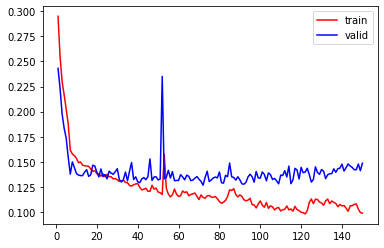

In [34]:
####Plot Loss
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
x_axis = np.arange(1, 151)
ax1.plot(x_axis, total_train_loss, c='red', label='train')
ax1.plot(x_axis, total_valid_loss, c='blue', label='valid')
plt.legend(loc='best')
plt.show()

In [35]:
file_name = './model/concare-challenge-front-fill-teacher-2covid-nodecov'
checkpoint = torch.load(file_name)
save_epoch = checkpoint['epoch']
print("last saved model is in epoch {}".format(save_epoch))
model.load_state_dict(checkpoint['net'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()


last saved model is in epoch 121


concare_teacher(
  (PositionalEncoding): PositionalEncoding(
    (dropout): Dropout(p=0)
  )
  (GRUs): ModuleList(
    (0): GRU(1, 32, batch_first=True)
    (1): GRU(1, 32, batch_first=True)
    (2): GRU(1, 32, batch_first=True)
    (3): GRU(1, 32, batch_first=True)
    (4): GRU(1, 32, batch_first=True)
    (5): GRU(1, 32, batch_first=True)
    (6): GRU(1, 32, batch_first=True)
    (7): GRU(1, 32, batch_first=True)
    (8): GRU(1, 32, batch_first=True)
    (9): GRU(1, 32, batch_first=True)
    (10): GRU(1, 32, batch_first=True)
    (11): GRU(1, 32, batch_first=True)
    (12): GRU(1, 32, batch_first=True)
    (13): GRU(1, 32, batch_first=True)
    (14): GRU(1, 32, batch_first=True)
    (15): GRU(1, 32, batch_first=True)
    (16): GRU(1, 32, batch_first=True)
    (17): GRU(1, 32, batch_first=True)
    (18): GRU(1, 32, batch_first=True)
    (19): GRU(1, 32, batch_first=True)
    (20): GRU(1, 32, batch_first=True)
    (21): GRU(1, 32, batch_first=True)
    (22): GRU(1, 32, batch_first=True

In [36]:
batch_loss = []
y_true = []
y_pred = []
pad_token = np.zeros(34)
with torch.no_grad():
    model.eval()
    for step, (batch_x, batch_y, batch_mask_x, batch_lens) in enumerate(batch_iter(test_x, test_y, test_mask_x, test_x_len, batch_size, shuffle=True)):  
        optimizer.zero_grad()
        batch_x = torch.tensor(pad_sents(batch_x, pad_token), dtype=torch.float32).to(device)
        batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)
        batch_lens = torch.tensor(batch_lens, dtype=torch.float32).to(device).int()
        batch_mask_x = torch.tensor(pad_sents(batch_mask_x, pad_token), dtype=torch.float32).to(device)

        masks = length_to_mask(batch_lens).unsqueeze(-1).float()

        opt, decov_loss, emb = model(batch_x, batch_lens)

        BCE_Loss = get_loss(opt, batch_y.unsqueeze(-1))
#             REC_Loss = F.mse_loss(masks * recon, masks * batch_x, reduction='mean').to(device)

        model_loss =  BCE_Loss 

        loss = model_loss
        batch_loss.append(loss.cpu().detach().numpy())
        if step % 20 == 0:
            print('Batch %d: Test Loss = %.4f'%(step, loss.cpu().detach().numpy()))
        y_pred += list(opt.cpu().detach().numpy().flatten())
        y_true += list(batch_y.cpu().numpy().flatten())

print("\n==>Predicting on test")
print('Test Loss = %.4f'%(np.mean(np.array(batch_loss))))
y_pred = np.array(y_pred)
y_pred = np.stack([1 - y_pred, y_pred], axis=1)
test_res = metrics.print_metrics_binary(y_true, y_pred)

/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Batch 0: Test Loss = 0.1325

==>Predicting on test
Test Loss = 0.1339
confusion matrix:
[[3693   43]
 [ 112  185]]
accuracy = 0.9615670442581177
precision class 0 = 0.9705650210380554
precision class 1 = 0.8114035129547119
recall class 0 = 0.9884903430938721
recall class 1 = 0.6228955984115601
AUC of ROC = 0.9430889912688628
AUC of PRC = 0.7616962418424793
min(+P, Se) = 0.7070707070707071
f1_score = 0.7047618906682848


#### Student Model

In [37]:
class concare_student(nn.Module):
    def __init__(self, input_dim, hidden_dim, d_model,  MHD_num_head, d_ff, output_dim, keep_prob=0.5):
        super(concare_student, self).__init__()

        # hyperparameters
        self.input_dim = input_dim  
        self.hidden_dim = hidden_dim  # d_model
        self.d_model = d_model
        self.MHD_num_head = MHD_num_head
        self.d_ff = d_ff
        self.output_dim = output_dim
        self.keep_prob = keep_prob

        # layers
        self.PositionalEncoding = PositionalEncoding(self.d_model, dropout = 0, max_len = 400)

        self.GRUs = clones(nn.GRU(1, self.hidden_dim, batch_first = True), self.input_dim)
        self.LastStepAttentions = clones(SingleAttention(self.hidden_dim, 8, attention_type='concat', demographic_dim=12, time_aware=True, use_demographic=False),self.input_dim)
        
        self.FinalAttentionQKV = FinalAttentionQKV(self.hidden_dim, self.hidden_dim, attention_type='mul',dropout = 1 - self.keep_prob)

        self.MultiHeadedAttention = MultiHeadedAttention(self.MHD_num_head, self.d_model,dropout = 1 - self.keep_prob)
        self.SublayerConnection = SublayerConnection(self.d_model, dropout = 1 - self.keep_prob)

        self.PositionwiseFeedForward = PositionwiseFeedForward(self.d_model, self.d_ff, dropout=0.1)

        self.demo_proj_main = nn.Linear(12, self.hidden_dim)
        self.demo_proj = nn.Linear(12, self.hidden_dim)
        self.output = nn.Linear(self.hidden_dim, self.output_dim)

        self.dropout = nn.Dropout(p = 1 - self.keep_prob)
        self.FC_embed = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.tanh=nn.Tanh()
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.relu=nn.ReLU()

    def forward(self, input, lens):
        # input shape [batch_size, timestep, feature_dim]
#         demo_main = self.tanh(self.demo_proj_main(demo_input)).unsqueeze(1)# b hidden_dim
        
        batch_size = input.size(0)
        time_step = input.size(1)
        feature_dim = input.size(2)
        assert(feature_dim == self.input_dim)# input Tensor : 256 * 48 * 76
        assert(self.d_model % self.MHD_num_head == 0)

        # Initialization
        #cur_hs = Variable(torch.zeros(batch_size, self.hidden_dim).unsqueeze(0))

        # forward
        # GRU_embeded_input = self.GRUs[0](input[:,:,0].unsqueeze(-1), Variable(torch.zeros(batch_size, self.hidden_dim).unsqueeze(0)).to(device))[0] # b t h
        # Attention_embeded_input = self.LastStepAttentions[0](GRU_embeded_input)[0].unsqueeze(1)# b 1 h
        # for i in range(feature_dim-1):
        #     embeded_input = self.GRUs[i+1](input[:,:,i+1].unsqueeze(-1), Variable(torch.zeros(batch_size, self.hidden_dim).unsqueeze(0)).to(device))[0] # b 1 h
        #     embeded_input = self.LastStepAttentions[i+1](embeded_input)[0].unsqueeze(1)# b 1 h
        #     Attention_embeded_input = torch.cat((Attention_embeded_input, embeded_input), 1)# b i h

        # Attention_embeded_input = torch.cat((Attention_embeded_input, demo_main), 1)# b i+1 h
        # posi_input = self.dropout(Attention_embeded_input) # batch_size * d_input+1 * hidden_dim

#         input = pack_padded_sequence(input, lens, batch_first=True)
        
        GRU_embeded_input = self.GRUs[0](pack_padded_sequence(input[:,:,0].unsqueeze(-1), lens, batch_first=True))[1].squeeze().unsqueeze(1) # b 1 h
#         print(GRU_embeded_input.shape)
        for i in range(feature_dim-1):
            embeded_input = self.GRUs[i+1](pack_padded_sequence(input[:,:,i+1].unsqueeze(-1), lens, batch_first=True))[1].squeeze().unsqueeze(1) # b 1 h
            GRU_embeded_input = torch.cat((GRU_embeded_input, embeded_input), 1)

#         GRU_embeded_input = torch.cat((GRU_embeded_input, demo_main), 1)# b i+1 h
        posi_input = self.dropout(GRU_embeded_input) # batch_size * d_input * hidden_dim


        #mask = subsequent_mask(time_step).to(device) # 1 t t 下三角 N to 1任务不用mask
        contexts = self.SublayerConnection(posi_input, lambda x: self.MultiHeadedAttention(posi_input, posi_input, posi_input, None))# # batch_size * d_input * hidden_dim
    
        DeCov_loss = contexts[1]
        contexts = contexts[0]

        contexts = self.SublayerConnection(contexts, lambda x: self.PositionwiseFeedForward(contexts))[0]# # batch_size * d_input * hidden_dim
        #contexts = contexts.view(batch_size, feature_dim * self.hidden_dim)#
        # contexts = torch.matmul(self.Wproj, contexts) + self.bproj
        # contexts = contexts.squeeze()
        # demo_key = self.demo_proj(demo_input)# b hidden_dim
        # demo_key = self.relu(demo_key)
        # input_dim_scores = torch.matmul(contexts, demo_key.unsqueeze(-1)).squeeze() # b i
        # input_dim_scores = self.dropout(self.sigmoid(input_dim_scores)).unsqueeze(1)# b i
        
        # weighted_contexts = torch.matmul(input_dim_scores, contexts).squeeze()
#         print(contexts.shape)

        weighted_contexts = self.FinalAttentionQKV(contexts)[0]
        output_embed = self.FC_embed(weighted_contexts)
        output = self.output(self.dropout(weighted_contexts))# b 1
        output = self.sigmoid(output)
#         print(weighted_contexts.shape)
          
        return output, DeCov_loss  ,output_embed
    #, self.MultiHeadedAttention.attn




In [38]:
epochs = 150
batch_size = 256
input_dim = 18
hidden_dim = 32
d_model = 32
MHD_num_head = 4
d_ff = 64
output_dim = 1

model_student = concare_student(input_dim = input_dim, hidden_dim = hidden_dim, d_model=d_model, MHD_num_head=MHD_num_head, d_ff=d_ff, output_dim = output_dim).to(device)
# input_dim, d_model, d_k, d_v, MHD_num_head, d_ff, output_dim
optimizer_student = torch.optim.Adam(model_student.parameters(), lr=1e-3)



In [39]:
#Generate Teacher model embedding
model.load_state_dict(checkpoint['net'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()

train_teacher_emb = []
batch_loss = []
y_true = []
y_pred = []
pad_token = np.zeros(34)
with torch.no_grad():
    model.eval()
    for step, (batch_x, batch_y, batch_mask_x, batch_lens) in enumerate(batch_iter(train_x, train_y, train_mask_x, train_x_len, batch_size, shuffle=True)):  
        optimizer.zero_grad()
        batch_x = torch.tensor(pad_sents(batch_x, pad_token), dtype=torch.float32).to(device)
        batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)
        batch_lens = torch.tensor(batch_lens, dtype=torch.float32).to(device).int()
        batch_mask_x = torch.tensor(pad_sents(batch_mask_x, pad_token), dtype=torch.float32).to(device)

        masks = length_to_mask(batch_lens).unsqueeze(-1).float()

        opt, decov_loss, emb = model(batch_x, batch_lens)
        train_teacher_emb.append(emb.cpu().detach().numpy())

        BCE_Loss = get_loss(opt, batch_y.unsqueeze(-1))
#             REC_Loss = F.mse_loss(masks * recon, masks * batch_x, reduction='mean').to(device)

        model_loss =  BCE_Loss 
        if step % 20 == 0:
            print('Batch %d: Test Loss = %.4f'%(step, model_loss.cpu().detach().numpy()))

/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Batch 0: Test Loss = 0.1000
Batch 20: Test Loss = 0.0679
Batch 40: Test Loss = 0.0514
Batch 60: Test Loss = 0.1014
Batch 80: Test Loss = 0.0536
Batch 100: Test Loss = 0.0442
Batch 120: Test Loss = 0.0824


In [40]:
teacher_flag = True
epochs = 200
total_train_loss = []
total_valid_loss = []
global_best = 0
auroc = []
auprc = []
minpse = []
history = []

pad_token = np.zeros(34)
# begin_time = time.time()
best_auroc = 0
best_auprc = 0
best_minpse = 0

if teacher_flag:
    file_name = './model/concare-challenge-front-fill-2covid-nodecov'
else:
    file_name = './model/concare-challenge-front-fill-2covid-nodecov-noteacher'

for each_epoch in range(epochs):

    epoch_loss = []
    counter_batch = 0
    model_student.train()  
    model.eval()
    for step, (batch_x, batch_y, batch_mask_x, batch_lens) in enumerate(batch_iter(train_x, train_y, train_mask_x, train_x_len, batch_size, shuffle=True)):  
        optimizer_student.zero_grad()
        batch_x = torch.tensor(pad_sents(batch_x, pad_token), dtype=torch.float32).to(device)
        batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)
        batch_lens = torch.tensor(batch_lens, dtype=torch.float32).to(device).int()
        batch_mask_x = torch.tensor(pad_sents(batch_mask_x, pad_token), dtype=torch.float32).to(device)

#        masks = length_to_mask(batch_lens).unsqueeze(-1).float()

        opt_student, decov_loss_student, emb_student = model_student(batch_x[:,:,:18], batch_lens)
        emb_teacher = torch.tensor(train_teacher_emb[step], dtype=torch.float32).to(device)
        # opt_teacher, decov_loss_teacher, emb_teacher = model(batch_x, batch_lens)
        BCE_Loss = get_loss(opt_student, batch_y.unsqueeze(-1)) # b t 1
        #emb_Loss = 0.1 * get_re_loss(emb_student, emb_teacher.detach())
        if teacher_flag:
            emb_student = F.log_softmax(emb_student, dim=1)
            emb_teacher = F.softmax(emb_teacher.detach(), dim=1)
            emb_Loss = get_kl_loss(emb_student, emb_teacher)
            loss = BCE_Loss + emb_Loss#+ decov_loss_student
        # emb_Loss = 0.1 * get_wass_dist(emb_student, emb_teacher.detach())
#             REC_Loss = F.mse_loss(masks * recon, masks * batch_x, reduction='mean').to(device)
        else:
            loss = BCE_Loss #+ decov_loss_student

        epoch_loss.append(BCE_Loss.cpu().detach().numpy())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_student.parameters(), 20)
        optimizer_student.step()

        if step % 20 == 0:
            print('Epoch %d Batch %d: Train Loss = %.4f'%(each_epoch, step, loss.cpu().detach().numpy()))

    epoch_loss = np.mean(epoch_loss)
    total_train_loss.append(epoch_loss)

    #Validation
    y_true = []
    y_pred = []
    with torch.no_grad():
        model_student.eval()
        valid_loss = []
        valid_true = []
        valid_pred = []
        for batch_x, batch_y, batch_mask_x, batch_lens in batch_iter(dev_x, dev_y, dev_mask_x, dev_x_len, batch_size):
            batch_x = torch.tensor(pad_sents(batch_x, pad_token), dtype=torch.float32).to(device)
            batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)
            batch_lens = torch.tensor(batch_lens, dtype=torch.float32).to(device).int()
            batch_mask_x = torch.tensor(pad_sents(batch_mask_x, pad_token), dtype=torch.float32).to(device)
#            masks = length_to_mask(batch_lens).unsqueeze(-1).float()


            opt_student, decov_loss_student, emb = model_student(batch_x[:,:,:18], batch_lens)

            BCE_Loss = get_loss(opt_student, batch_y.unsqueeze(-1))
#                 REC_Loss = F.mse_loss(recon, batch_x, reduction='mean').to(device)

            valid_loss.append(BCE_Loss.cpu().detach().numpy())

            y_pred += list(opt_student.cpu().detach().numpy().flatten())
            y_true += list(batch_y.cpu().numpy().flatten())

        valid_loss = np.mean(valid_loss)
        total_valid_loss.append(valid_loss)
        ret = metrics.print_metrics_binary(y_true, y_pred,verbose = 0)
        history.append(ret)
        #print()

        print('Epoch %d: Loss = %.4f Valid loss = %.4f roc = %.4f'%(each_epoch, total_train_loss[-1], total_valid_loss[-1], ret['auroc']))
        metrics.print_metrics_binary(y_true, y_pred)

        cur_auroc = ret['auroc']
        if cur_auroc > best_auroc:
            best_auroc = cur_auroc
            best_auprc = ret['auprc']
            best_minpse = ret['minpse']
            state = {
                'net': model_student.state_dict(),
                'optimizer': optimizer_student.state_dict(),
                'epoch': each_epoch
            }
            torch.save(state, file_name)
            print('------------ Save best model - AUROC: %.4f ------------'%cur_auroc)       

print('auroc %.4f'%(best_auroc))
print('auprc %.4f'%(best_auprc))
print('minpse %.4f'%(best_minpse)) 

/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ubicomp/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/ubicomp/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1992: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 0 Batch 0: Train Loss = 0.6746
Epoch 0 Batch 20: Train Loss = 0.2905
Epoch 0 Batch 40: Train Loss = 0.2630
Epoch 0 Batch 60: Train Loss = 0.3454
Epoch 0 Batch 80: Train Loss = 0.2508
Epoch 0 Batch 100: Train Loss = 0.2453
Epoch 0 Batch 120: Train Loss = 0.2901
Epoch 0: Loss = 0.3138 Valid loss = 0.2579 roc = 0.6996
confusion matrix:
[[3742    0]
 [ 292    0]]
accuracy = 0.9276152849197388
precision class 0 = 0.9276152849197388
precision class 1 = nan
recall class 0 = 1.0
recall class 1 = 0.0
AUC of ROC = 0.6995897183397641
AUC of PRC = 0.13544012496805571
min(+P, Se) = 0.16326530612244897
f1_score = nan
------------ Save best model - AUROC: 0.6996 ------------
Epoch 1 Batch 0: Train Loss = 0.3216
Epoch 1 Batch 20: Train Loss = 0.1982
Epoch 1 Batch 40: Train Loss = 0.3868
Epoch 1 Batch 60: Train Loss = 0.2033
Epoch 1 Batch 80: Train Loss = 0.2342
Epoch 1 Batch 100: Train Loss = 0.2907
Epoch 1 Batch 120: Train Loss = 0.2301
Epoch 1: Loss = 0.2677 Valid loss = 0.2386 roc = 0.7491
co

Epoch 12 Batch 0: Train Loss = 0.1354
Epoch 12 Batch 20: Train Loss = 0.2062
Epoch 12 Batch 40: Train Loss = 0.1495
Epoch 12 Batch 60: Train Loss = 0.1773
Epoch 12 Batch 80: Train Loss = 0.2074
Epoch 12 Batch 100: Train Loss = 0.1682
Epoch 12 Batch 120: Train Loss = 0.1737
Epoch 12: Loss = 0.1688 Valid loss = 0.1669 roc = 0.8654
confusion matrix:
[[3702   40]
 [ 160  132]]
accuracy = 0.9504213929176331
precision class 0 = 0.958570659160614
precision class 1 = 0.7674418687820435
recall class 0 = 0.9893105030059814
recall class 1 = 0.45205479860305786
AUC of ROC = 0.865353850772058
AUC of PRC = 0.6014494417185651
min(+P, Se) = 0.571917808219178
f1_score = 0.5689654949516533
------------ Save best model - AUROC: 0.8654 ------------
Epoch 13 Batch 0: Train Loss = 0.1509
Epoch 13 Batch 20: Train Loss = 0.1563
Epoch 13 Batch 40: Train Loss = 0.1338
Epoch 13 Batch 60: Train Loss = 0.1400
Epoch 13 Batch 80: Train Loss = 0.1729
Epoch 13 Batch 100: Train Loss = 0.1519
Epoch 13 Batch 120: Train L

Epoch 24 Batch 0: Train Loss = 0.0848
Epoch 24 Batch 20: Train Loss = 0.1675
Epoch 24 Batch 40: Train Loss = 0.1537
Epoch 24 Batch 60: Train Loss = 0.1204
Epoch 24 Batch 80: Train Loss = 0.1653
Epoch 24 Batch 100: Train Loss = 0.1328
Epoch 24 Batch 120: Train Loss = 0.1365
Epoch 24: Loss = 0.1579 Valid loss = 0.1658 roc = 0.8726
confusion matrix:
[[3704   38]
 [ 158  134]]
accuracy = 0.9514129757881165
precision class 0 = 0.9590885639190674
precision class 1 = 0.7790697813034058
recall class 0 = 0.9898449778556824
recall class 1 = 0.45890411734580994
AUC of ROC = 0.8726131729424599
AUC of PRC = 0.6245472119132747
min(+P, Se) = 0.5938566552901023
f1_score = 0.5775862029453523
Epoch 25 Batch 0: Train Loss = 0.1611
Epoch 25 Batch 20: Train Loss = 0.1134
Epoch 25 Batch 40: Train Loss = 0.1470
Epoch 25 Batch 60: Train Loss = 0.2083
Epoch 25 Batch 80: Train Loss = 0.2645
Epoch 25 Batch 100: Train Loss = 0.1654
Epoch 25 Batch 120: Train Loss = 0.1527
Epoch 25: Loss = 0.1589 Valid loss = 0.165

Epoch 36 Batch 0: Train Loss = 0.1780
Epoch 36 Batch 20: Train Loss = 0.1324
Epoch 36 Batch 40: Train Loss = 0.1714
Epoch 36 Batch 60: Train Loss = 0.1684
Epoch 36 Batch 80: Train Loss = 0.1770
Epoch 36 Batch 100: Train Loss = 0.1341
Epoch 36 Batch 120: Train Loss = 0.1583
Epoch 36: Loss = 0.1530 Valid loss = 0.1602 roc = 0.8795
confusion matrix:
[[3703   39]
 [ 159  133]]
accuracy = 0.9509171843528748
precision class 0 = 0.9588296413421631
precision class 1 = 0.7732558250427246
recall class 0 = 0.9895777702331543
recall class 1 = 0.4554794430732727
AUC of ROC = 0.8795347883704414
AUC of PRC = 0.6428961140889975
min(+P, Se) = 0.5958904109589042
f1_score = 0.5732758858116014
Epoch 37 Batch 0: Train Loss = 0.1819
Epoch 37 Batch 20: Train Loss = 0.1316
Epoch 37 Batch 40: Train Loss = 0.1231
Epoch 37 Batch 60: Train Loss = 0.1453
Epoch 37 Batch 80: Train Loss = 0.1081
Epoch 37 Batch 100: Train Loss = 0.2233
Epoch 37 Batch 120: Train Loss = 0.1872
Epoch 37: Loss = 0.1498 Valid loss = 0.1579

Epoch 48 Batch 0: Train Loss = 0.1497
Epoch 48 Batch 20: Train Loss = 0.1531
Epoch 48 Batch 40: Train Loss = 0.1468
Epoch 48 Batch 60: Train Loss = 0.1358
Epoch 48 Batch 80: Train Loss = 0.1991
Epoch 48 Batch 100: Train Loss = 0.1621
Epoch 48 Batch 120: Train Loss = 0.2350
Epoch 48: Loss = 0.1515 Valid loss = 0.1877 roc = 0.8727
confusion matrix:
[[3717   25]
 [ 178  114]]
accuracy = 0.9496777653694153
precision class 0 = 0.9543004035949707
precision class 1 = 0.8201438784599304
recall class 0 = 0.9933190941810608
recall class 1 = 0.3904109597206116
AUC of ROC = 0.8727486217171977
AUC of PRC = 0.6208010249968711
min(+P, Se) = 0.589041095890411
f1_score = 0.529002319597144
Epoch 49 Batch 0: Train Loss = 0.2409
Epoch 49 Batch 20: Train Loss = 0.1472
Epoch 49 Batch 40: Train Loss = 0.1655
Epoch 49 Batch 60: Train Loss = 0.1477
Epoch 49 Batch 80: Train Loss = 0.1214
Epoch 49 Batch 100: Train Loss = 0.1157
Epoch 49 Batch 120: Train Loss = 0.1198
Epoch 49: Loss = 0.1553 Valid loss = 0.1593 r

Epoch 60 Batch 20: Train Loss = 0.2665
Epoch 60 Batch 40: Train Loss = 0.1711
Epoch 60 Batch 60: Train Loss = 0.1655
Epoch 60 Batch 80: Train Loss = 0.1442
Epoch 60 Batch 100: Train Loss = 0.1761
Epoch 60 Batch 120: Train Loss = 0.1391
Epoch 60: Loss = 0.1482 Valid loss = 0.1558 roc = 0.8900
confusion matrix:
[[3707   35]
 [ 163  129]]
accuracy = 0.9509171843528748
precision class 0 = 0.9578811526298523
precision class 1 = 0.7865853905677795
recall class 0 = 0.9906467199325562
recall class 1 = 0.44178083539009094
AUC of ROC = 0.8899634288308208
AUC of PRC = 0.6536952179157642
min(+P, Se) = 0.6027397260273972
f1_score = 0.5657894773991818
Epoch 61 Batch 0: Train Loss = 0.1280
Epoch 61 Batch 20: Train Loss = 0.1262
Epoch 61 Batch 40: Train Loss = 0.2132
Epoch 61 Batch 60: Train Loss = 0.1956
Epoch 61 Batch 80: Train Loss = 0.1419
Epoch 61 Batch 100: Train Loss = 0.1120
Epoch 61 Batch 120: Train Loss = 0.2011
Epoch 61: Loss = 0.1487 Valid loss = 0.1550 roc = 0.8936
confusion matrix:
[[370

Epoch 72 Batch 0: Train Loss = 0.1568
Epoch 72 Batch 20: Train Loss = 0.1427
Epoch 72 Batch 40: Train Loss = 0.1385
Epoch 72 Batch 60: Train Loss = 0.1539
Epoch 72 Batch 80: Train Loss = 0.1114
Epoch 72 Batch 100: Train Loss = 0.0725
Epoch 72 Batch 120: Train Loss = 0.1717
Epoch 72: Loss = 0.1451 Valid loss = 0.1563 roc = 0.8822
confusion matrix:
[[3703   39]
 [ 151  141]]
accuracy = 0.9529003500938416
precision class 0 = 0.9608199000358582
precision class 1 = 0.7833333611488342
recall class 0 = 0.9895777702331543
recall class 1 = 0.482876718044281
AUC of ROC = 0.8822272903655652
AUC of PRC = 0.6578944351002388
min(+P, Se) = 0.6177474402730375
f1_score = 0.5974576395840796
Epoch 73 Batch 0: Train Loss = 0.1323
Epoch 73 Batch 20: Train Loss = 0.1173
Epoch 73 Batch 40: Train Loss = 0.1461
Epoch 73 Batch 60: Train Loss = 0.1527
Epoch 73 Batch 80: Train Loss = 0.0970
Epoch 73 Batch 100: Train Loss = 0.1386
Epoch 73 Batch 120: Train Loss = 0.1786
Epoch 73: Loss = 0.1419 Valid loss = 0.1558 

Epoch 84 Batch 20: Train Loss = 0.0979
Epoch 84 Batch 40: Train Loss = 0.1100
Epoch 84 Batch 60: Train Loss = 0.1291
Epoch 84 Batch 80: Train Loss = 0.1188
Epoch 84 Batch 100: Train Loss = 0.1010
Epoch 84 Batch 120: Train Loss = 0.1395
Epoch 84: Loss = 0.1397 Valid loss = 0.1534 roc = 0.8946
confusion matrix:
[[3702   40]
 [ 160  132]]
accuracy = 0.9504213929176331
precision class 0 = 0.958570659160614
precision class 1 = 0.7674418687820435
recall class 0 = 0.9893105030059814
recall class 1 = 0.45205479860305786
AUC of ROC = 0.8946071253377068
AUC of PRC = 0.6648210019886603
min(+P, Se) = 0.6198630136986302
f1_score = 0.5689654949516533
------------ Save best model - AUROC: 0.8946 ------------
Epoch 85 Batch 0: Train Loss = 0.1709
Epoch 85 Batch 20: Train Loss = 0.1034
Epoch 85 Batch 40: Train Loss = 0.0989
Epoch 85 Batch 60: Train Loss = 0.2580
Epoch 85 Batch 80: Train Loss = 0.1716
Epoch 85 Batch 100: Train Loss = 0.1249
Epoch 85 Batch 120: Train Loss = 0.1188
Epoch 85: Loss = 0.1395

Epoch 96 Batch 0: Train Loss = 0.1184
Epoch 96 Batch 20: Train Loss = 0.1468
Epoch 96 Batch 40: Train Loss = 0.1567
Epoch 96 Batch 60: Train Loss = 0.1502
Epoch 96 Batch 80: Train Loss = 0.2269
Epoch 96 Batch 100: Train Loss = 0.1436
Epoch 96 Batch 120: Train Loss = 0.1207
Epoch 96: Loss = 0.1427 Valid loss = 0.1561 roc = 0.8903
confusion matrix:
[[3700   42]
 [ 150  142]]
accuracy = 0.9524045586585999
precision class 0 = 0.9610389471054077
precision class 1 = 0.77173912525177
recall class 0 = 0.9887760281562805
recall class 1 = 0.48630136251449585
AUC of ROC = 0.8903468952944363
AUC of PRC = 0.6590730571320494
min(+P, Se) = 0.6164383561643836
f1_score = 0.5966386766506462
Epoch 97 Batch 0: Train Loss = 0.1108
Epoch 97 Batch 20: Train Loss = 0.1646
Epoch 97 Batch 40: Train Loss = 0.2109
Epoch 97 Batch 60: Train Loss = 0.1151
Epoch 97 Batch 80: Train Loss = 0.1839
Epoch 97 Batch 100: Train Loss = 0.1791
Epoch 97 Batch 120: Train Loss = 0.1611
Epoch 97: Loss = 0.1388 Valid loss = 0.1634 

Epoch 108 Batch 0: Train Loss = 0.1458
Epoch 108 Batch 20: Train Loss = 0.1131
Epoch 108 Batch 40: Train Loss = 0.1639
Epoch 108 Batch 60: Train Loss = 0.1653
Epoch 108 Batch 80: Train Loss = 0.1030
Epoch 108 Batch 100: Train Loss = 0.1512
Epoch 108 Batch 120: Train Loss = 0.1428
Epoch 108: Loss = 0.1330 Valid loss = 0.1628 roc = 0.8915
confusion matrix:
[[3689   53]
 [ 139  153]]
accuracy = 0.9524045586585999
precision class 0 = 0.9636886119842529
precision class 1 = 0.7427184581756592
recall class 0 = 0.9858364462852478
recall class 1 = 0.5239726305007935
AUC of ROC = 0.8914515349640878
AUC of PRC = 0.6585324871689322
min(+P, Se) = 0.6040955631399317
f1_score = 0.6144578543746222
Epoch 109 Batch 0: Train Loss = 0.1449
Epoch 109 Batch 20: Train Loss = 0.1121
Epoch 109 Batch 40: Train Loss = 0.1979
Epoch 109 Batch 60: Train Loss = 0.1365
Epoch 109 Batch 80: Train Loss = 0.0979
Epoch 109 Batch 100: Train Loss = 0.1562
Epoch 109 Batch 120: Train Loss = 0.0952
Epoch 109: Loss = 0.1352 Val

Epoch 120 Batch 0: Train Loss = 0.1473
Epoch 120 Batch 20: Train Loss = 0.1441
Epoch 120 Batch 40: Train Loss = 0.1790
Epoch 120 Batch 60: Train Loss = 0.1035
Epoch 120 Batch 80: Train Loss = 0.1756
Epoch 120 Batch 100: Train Loss = 0.1255
Epoch 120 Batch 120: Train Loss = 0.1135
Epoch 120: Loss = 0.1379 Valid loss = 0.1569 roc = 0.8921
confusion matrix:
[[3698   44]
 [ 148  144]]
accuracy = 0.9524045586585999
precision class 0 = 0.9615184664726257
precision class 1 = 0.7659574747085571
recall class 0 = 0.9882415533065796
recall class 1 = 0.4931506812572479
AUC of ROC = 0.8921251180600807
AUC of PRC = 0.6551897283572267
min(+P, Se) = 0.6114864864864865
f1_score = 0.599999991638793
Epoch 121 Batch 0: Train Loss = 0.1474
Epoch 121 Batch 20: Train Loss = 0.1757
Epoch 121 Batch 40: Train Loss = 0.1828
Epoch 121 Batch 60: Train Loss = 0.1254
Epoch 121 Batch 80: Train Loss = 0.0980
Epoch 121 Batch 100: Train Loss = 0.1354
Epoch 121 Batch 120: Train Loss = 0.1168
Epoch 121: Loss = 0.1395 Vali

Epoch 132 Batch 0: Train Loss = 0.1466
Epoch 132 Batch 20: Train Loss = 0.1826
Epoch 132 Batch 40: Train Loss = 0.1469
Epoch 132 Batch 60: Train Loss = 0.1324
Epoch 132 Batch 80: Train Loss = 0.0857
Epoch 132 Batch 100: Train Loss = 0.1846
Epoch 132 Batch 120: Train Loss = 0.1784
Epoch 132: Loss = 0.1353 Valid loss = 0.1579 roc = 0.8970
confusion matrix:
[[3710   32]
 [ 160  132]]
accuracy = 0.9524045586585999
precision class 0 = 0.9586563110351562
precision class 1 = 0.8048780560493469
recall class 0 = 0.9914484024047852
recall class 1 = 0.45205479860305786
AUC of ROC = 0.8969921220063991
AUC of PRC = 0.661041014364326
min(+P, Se) = 0.6198630136986302
f1_score = 0.5789473736495302
Epoch 133 Batch 0: Train Loss = 0.1178
Epoch 133 Batch 20: Train Loss = 0.1650
Epoch 133 Batch 40: Train Loss = 0.1725
Epoch 133 Batch 60: Train Loss = 0.1569
Epoch 133 Batch 80: Train Loss = 0.1720
Epoch 133 Batch 100: Train Loss = 0.1053
Epoch 133 Batch 120: Train Loss = 0.1383
Epoch 133: Loss = 0.1368 Val

Epoch 144 Batch 0: Train Loss = 0.0961
Epoch 144 Batch 20: Train Loss = 0.0972
Epoch 144 Batch 40: Train Loss = 0.1266
Epoch 144 Batch 60: Train Loss = 0.1048
Epoch 144 Batch 80: Train Loss = 0.0981
Epoch 144 Batch 100: Train Loss = 0.1639
Epoch 144 Batch 120: Train Loss = 0.1262
Epoch 144: Loss = 0.1338 Valid loss = 0.1599 roc = 0.8881
confusion matrix:
[[3695   47]
 [ 146  146]]
accuracy = 0.952156662940979
precision class 0 = 0.9619890451431274
precision class 1 = 0.7564767003059387
recall class 0 = 0.9874398708343506
recall class 1 = 0.5
AUC of ROC = 0.888113820900112
AUC of PRC = 0.6598032122837925
min(+P, Se) = 0.6143344709897611
f1_score = 0.6020618894146065
Epoch 145 Batch 0: Train Loss = 0.1086
Epoch 145 Batch 20: Train Loss = 0.1282
Epoch 145 Batch 40: Train Loss = 0.1588
Epoch 145 Batch 60: Train Loss = 0.1062
Epoch 145 Batch 80: Train Loss = 0.1039
Epoch 145 Batch 100: Train Loss = 0.1202
Epoch 145 Batch 120: Train Loss = 0.1425
Epoch 145: Loss = 0.1320 Valid loss = 0.1531 

Epoch 156 Batch 0: Train Loss = 0.1172
Epoch 156 Batch 20: Train Loss = 0.1719
Epoch 156 Batch 40: Train Loss = 0.2192
Epoch 156 Batch 60: Train Loss = 0.1586
Epoch 156 Batch 80: Train Loss = 0.1907
Epoch 156 Batch 100: Train Loss = 0.1514
Epoch 156 Batch 120: Train Loss = 0.1232
Epoch 156: Loss = 0.1403 Valid loss = 0.1670 roc = 0.8818
confusion matrix:
[[3707   35]
 [ 155  137]]
accuracy = 0.9529003500938416
precision class 0 = 0.9598653316497803
precision class 1 = 0.7965116500854492
recall class 0 = 0.9906467199325562
recall class 1 = 0.46917808055877686
AUC of ROC = 0.8818419935131019
AUC of PRC = 0.6460097205488066
min(+P, Se) = 0.5958904109589042
f1_score = 0.5905172461809923
Epoch 157 Batch 0: Train Loss = 0.2070
Epoch 157 Batch 20: Train Loss = 0.1398
Epoch 157 Batch 40: Train Loss = 0.1359
Epoch 157 Batch 60: Train Loss = 0.1377
Epoch 157 Batch 80: Train Loss = 0.1943
Epoch 157 Batch 100: Train Loss = 0.1237
Epoch 157 Batch 120: Train Loss = 0.1290
Epoch 157: Loss = 0.1448 Va

Epoch 168 Batch 0: Train Loss = 0.0586
Epoch 168 Batch 20: Train Loss = 0.1064
Epoch 168 Batch 40: Train Loss = 0.1327
Epoch 168 Batch 60: Train Loss = 0.1114
Epoch 168 Batch 80: Train Loss = 0.1454
Epoch 168 Batch 100: Train Loss = 0.0839
Epoch 168 Batch 120: Train Loss = 0.1062
Epoch 168: Loss = 0.1387 Valid loss = 0.1565 roc = 0.8900
confusion matrix:
[[3712   30]
 [ 147  145]]
accuracy = 0.9561229348182678
precision class 0 = 0.9619072079658508
precision class 1 = 0.8285714387893677
recall class 0 = 0.9919828772544861
recall class 1 = 0.49657535552978516
AUC of ROC = 0.8899670896085164
AUC of PRC = 0.6678316177627075
min(+P, Se) = 0.6164383561643836
f1_score = 0.6209850237913511
Epoch 169 Batch 0: Train Loss = 0.1035
Epoch 169 Batch 20: Train Loss = 0.1198
Epoch 169 Batch 40: Train Loss = 0.0902
Epoch 169 Batch 60: Train Loss = 0.1237
Epoch 169 Batch 80: Train Loss = 0.1604
Epoch 169 Batch 100: Train Loss = 0.1771
Epoch 169 Batch 120: Train Loss = 0.1781
Epoch 169: Loss = 0.1398 Va

Epoch 180 Batch 0: Train Loss = 0.0957
Epoch 180 Batch 20: Train Loss = 0.1102
Epoch 180 Batch 40: Train Loss = 0.1027
Epoch 180 Batch 60: Train Loss = 0.1168
Epoch 180 Batch 80: Train Loss = 0.2195
Epoch 180 Batch 100: Train Loss = 0.1658
Epoch 180 Batch 120: Train Loss = 0.1351
Epoch 180: Loss = 0.1362 Valid loss = 0.1591 roc = 0.8866
confusion matrix:
[[3703   39]
 [ 138  154]]
accuracy = 0.9561229348182678
precision class 0 = 0.9640718698501587
precision class 1 = 0.7979274392127991
recall class 0 = 0.9895777702331543
recall class 1 = 0.5273972749710083
AUC of ROC = 0.8866366970999319
AUC of PRC = 0.6649732320295025
min(+P, Se) = 0.613013698630137
f1_score = 0.6350515215413863
Epoch 181 Batch 0: Train Loss = 0.1279
Epoch 181 Batch 20: Train Loss = 0.1966
Epoch 181 Batch 40: Train Loss = 0.2205
Epoch 181 Batch 60: Train Loss = 0.1551
Epoch 181 Batch 80: Train Loss = 0.1691
Epoch 181 Batch 100: Train Loss = 0.0955
Epoch 181 Batch 120: Train Loss = 0.1596
Epoch 181: Loss = 0.1323 Vali

Epoch 192 Batch 0: Train Loss = 0.1228
Epoch 192 Batch 20: Train Loss = 0.1742
Epoch 192 Batch 40: Train Loss = 0.1472
Epoch 192 Batch 60: Train Loss = 0.1154
Epoch 192 Batch 80: Train Loss = 0.1272
Epoch 192 Batch 100: Train Loss = 0.2158
Epoch 192 Batch 120: Train Loss = 0.1719
Epoch 192: Loss = 0.1317 Valid loss = 0.1555 roc = 0.8916
confusion matrix:
[[3695   47]
 [ 140  152]]
accuracy = 0.9536440372467041
precision class 0 = 0.9634941220283508
precision class 1 = 0.7638190984725952
recall class 0 = 0.9874398708343506
recall class 1 = 0.5205479264259338
AUC of ROC = 0.8915650190726518
AUC of PRC = 0.6648287569551673
min(+P, Se) = 0.613013698630137
f1_score = 0.6191445618185384
Epoch 193 Batch 0: Train Loss = 0.1254
Epoch 193 Batch 20: Train Loss = 0.1716
Epoch 193 Batch 40: Train Loss = 0.1315
Epoch 193 Batch 60: Train Loss = 0.1276
Epoch 193 Batch 80: Train Loss = 0.0823
Epoch 193 Batch 100: Train Loss = 0.1705
Epoch 193 Batch 120: Train Loss = 0.1421
Epoch 193: Loss = 0.1317 Vali

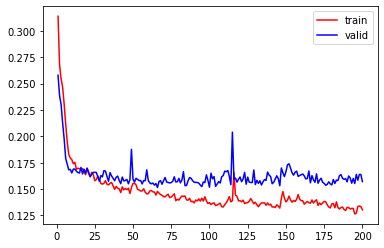

In [41]:
####Plot Loss
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
x_axis = np.arange(1, 201)
ax1.plot(x_axis, total_train_loss, c='red', label='train')
ax1.plot(x_axis, total_valid_loss, c='blue', label='valid')
plt.legend(loc='best')
plt.show()

In [42]:
file_name = './model/concare-challenge-front-fill-2covid-nodecov'
checkpoint = torch.load(file_name)
save_epoch = checkpoint['epoch']
print("last saved model is in epoch {}".format(save_epoch))
model_student.load_state_dict(checkpoint['net'])
optimizer_student.load_state_dict(checkpoint['optimizer'])
model_student.eval()

last saved model is in epoch 145


concare_student(
  (PositionalEncoding): PositionalEncoding(
    (dropout): Dropout(p=0)
  )
  (GRUs): ModuleList(
    (0): GRU(1, 32, batch_first=True)
    (1): GRU(1, 32, batch_first=True)
    (2): GRU(1, 32, batch_first=True)
    (3): GRU(1, 32, batch_first=True)
    (4): GRU(1, 32, batch_first=True)
    (5): GRU(1, 32, batch_first=True)
    (6): GRU(1, 32, batch_first=True)
    (7): GRU(1, 32, batch_first=True)
    (8): GRU(1, 32, batch_first=True)
    (9): GRU(1, 32, batch_first=True)
    (10): GRU(1, 32, batch_first=True)
    (11): GRU(1, 32, batch_first=True)
    (12): GRU(1, 32, batch_first=True)
    (13): GRU(1, 32, batch_first=True)
    (14): GRU(1, 32, batch_first=True)
    (15): GRU(1, 32, batch_first=True)
    (16): GRU(1, 32, batch_first=True)
    (17): GRU(1, 32, batch_first=True)
  )
  (LastStepAttentions): ModuleList(
    (0): SingleAttention(
      (tanh): Tanh()
      (softmax): Softmax()
    )
    (1): SingleAttention(
      (tanh): Tanh()
      (softmax): Softmax()

In [43]:
batch_loss = []
y_true = []
y_pred = []
with torch.no_grad():
    model_student.eval()
    for step, (batch_x, batch_y, batch_mask_x, batch_lens) in enumerate(batch_iter(test_x, test_y, test_mask_x, test_x_len, batch_size, shuffle=True)):  
        optimizer_student.zero_grad()
        batch_x = torch.tensor(pad_sents(batch_x, pad_token), dtype=torch.float32).to(device)
        batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)
        batch_lens = torch.tensor(batch_lens, dtype=torch.float32).to(device).int()
        batch_mask_x = torch.tensor(pad_sents(batch_mask_x, pad_token), dtype=torch.float32).to(device)

        masks = length_to_mask(batch_lens).unsqueeze(-1).float()

        opt, decov_loss, emb = model_student(batch_x[:,:,:18], batch_lens)

        BCE_Loss = get_loss(opt, batch_y.unsqueeze(-1))
#             REC_Loss = F.mse_loss(masks * recon, masks * batch_x, reduction='mean').to(device)

        model_loss =  BCE_Loss 

        loss = model_loss
        batch_loss.append(loss.cpu().detach().numpy())
        if step % 20 == 0:
            print('Batch %d: Test Loss = %.4f'%(step, loss.cpu().detach().numpy()))
        y_pred += list(opt.cpu().detach().numpy().flatten())
        y_true += list(batch_y.cpu().numpy().flatten())

print("\n==>Predicting on test")
print('Test Loss = %.4f'%(np.mean(np.array(batch_loss))))
y_pred = np.array(y_pred)
y_pred = np.stack([1 - y_pred, y_pred], axis=1)
test_res = metrics.print_metrics_binary(y_true, y_pred)

/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Batch 0: Test Loss = 0.1239

==>Predicting on test
Test Loss = 0.1358
confusion matrix:
[[3706   30]
 [ 141  156]]
accuracy = 0.9575998187065125
precision class 0 = 0.9633480906486511
precision class 1 = 0.8387096524238586
recall class 0 = 0.9919700026512146
recall class 1 = 0.5252525210380554
AUC of ROC = 0.9265928377277415
AUC of PRC = 0.7123872603335409
min(+P, Se) = 0.67003367003367
f1_score = 0.6459627223186831


### Transfer Target Dataset & Model

In [154]:
data_path = './data/covid_data_regression_challengenormalized_frontfill/'
all_x = pickle.load(open(data_path + 'x.dat', 'rb'))
all_y = pickle.load(open(data_path + 'y.dat', 'rb'))
all_time = pickle.load(open(data_path + 'time_all.dat', 'rb'))
all_x_len = [len(i) for i in all_x]

In [155]:
tar_subset_idx = [0,1,2,7,11,12,24,25,28,30,32,36,37,39,50,51,65,73]
tar_other_idx = list(range(74))
for i in tar_subset_idx:
    tar_other_idx.remove(i)
for i in range(len(all_x)):
    cur = np.array(all_x[i], dtype=float)
    cur_subset = cur[:, tar_subset_idx]
    cur_other = cur[:, tar_other_idx]
    all_x[i] = np.concatenate((cur_subset, cur_other), axis=1).tolist()
print(all_x[0])
print(len(all_x[0][0]))

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.48366969054304804, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.6098156788502713, 0.0, 0.0, 0.0, -0.8782176209168485, 1.5306485346278647, -1.0226920111892566, 0.0, 0.0, 0.48366969054304804, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02046221093990758, 0.0, 0.0, 0.5240758169434475, 0.0, 1.3418967862838704, 0.0, 0.0, 0.0, -0.8000989425850453, -0.7666192122061113, 0.0, 0.0, 0.0, 0.0, 0.24412207499860644, 0.0, 0.3458089499622604, 0.0, -0.21450748367436137, -0.1878689965882076, -0.29973901928207874, 0.0, -0.9457568944597906, 0.9898206570780831, 0.0, -0.2727601808628026, 0.0, 0.5963211163998314, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0275875734008992, 0.0, 0.0, -

In [156]:
long_x = all_x
long_y = [s[-1] for s in all_y]
long_time = all_time
#long_static = all_static

In [157]:
def get_n2n_data(x, y, x_len):
    length = len(x)
    assert length == len(y)
    assert length == len(x_len)
    new_x = []
    new_y = []
    new_x_len = []
    for i in range(length):
        for j in range(len(x[i])):
            new_x.append(x[i][:j+1])
            new_y.append(y[i][j])
            new_x_len.append(j+1)
    return new_x, new_y, new_x_len

In [48]:
class concare_target(nn.Module):
    def __init__(self, input_dim, hidden_dim, d_model,  MHD_num_head, d_ff, output_dim, keep_prob=0.5):
        super(concare_target, self).__init__()

        # hyperparameters
        self.input_dim = input_dim  
        self.hidden_dim = hidden_dim  # d_model
        self.d_model = d_model
        self.MHD_num_head = MHD_num_head
        self.d_ff = d_ff
        self.output_dim = output_dim
        self.keep_prob = keep_prob

        # layers
        self.PositionalEncoding = PositionalEncoding(self.d_model, dropout = 0, max_len = 400)

        self.GRUs = clones(nn.GRU(1, self.hidden_dim, batch_first = True), self.input_dim)
        self.LastStepAttentions = clones(SingleAttention(self.hidden_dim, 8, attention_type='concat', demographic_dim=12, time_aware=True, use_demographic=False),self.input_dim)
        
        self.FinalAttentionQKV = FinalAttentionQKV(self.hidden_dim, self.hidden_dim, attention_type='mul',dropout = 1 - self.keep_prob)

        self.MultiHeadedAttention = MultiHeadedAttention(self.MHD_num_head, self.d_model,dropout = 1 - self.keep_prob)
        self.SublayerConnection = SublayerConnection(self.d_model, dropout = 1 - self.keep_prob)

        self.PositionwiseFeedForward = PositionwiseFeedForward(self.d_model, self.d_ff, dropout=0.1)

        self.demo_proj_main = nn.Linear(12, self.hidden_dim)
        self.demo_proj = nn.Linear(12, self.hidden_dim)
        self.output = nn.Linear(self.hidden_dim, self.output_dim)

        self.dropout = nn.Dropout(p = 1 - self.keep_prob)
        self.FC_embed = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.tanh=nn.Tanh()
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.relu=nn.ReLU()

    def forward(self, input, lens):
        # input shape [batch_size, timestep, feature_dim]
#         demo_main = self.tanh(self.demo_proj_main(demo_input)).unsqueeze(1)# b hidden_dim
        
        batch_size = input.size(0)
        time_step = input.size(1)
        feature_dim = input.size(2)
        assert(feature_dim == self.input_dim)# input Tensor : 256 * 48 * 76
        assert(self.d_model % self.MHD_num_head == 0)

        # Initialization
        #cur_hs = Variable(torch.zeros(batch_size, self.hidden_dim).unsqueeze(0))

        # forward
        # GRU_embeded_input = self.GRUs[0](input[:,:,0].unsqueeze(-1), Variable(torch.zeros(batch_size, self.hidden_dim).unsqueeze(0)).to(device))[0] # b t h
        # Attention_embeded_input = self.LastStepAttentions[0](GRU_embeded_input)[0].unsqueeze(1)# b 1 h
        # for i in range(feature_dim-1):
        #     embeded_input = self.GRUs[i+1](input[:,:,i+1].unsqueeze(-1), Variable(torch.zeros(batch_size, self.hidden_dim).unsqueeze(0)).to(device))[0] # b 1 h
        #     embeded_input = self.LastStepAttentions[i+1](embeded_input)[0].unsqueeze(1)# b 1 h
        #     Attention_embeded_input = torch.cat((Attention_embeded_input, embeded_input), 1)# b i h

        # Attention_embeded_input = torch.cat((Attention_embeded_input, demo_main), 1)# b i+1 h
        # posi_input = self.dropout(Attention_embeded_input) # batch_size * d_input+1 * hidden_dim

#         input = pack_padded_sequence(input, lens, batch_first=True)
        
        GRU_embeded_input = self.GRUs[0](pack_padded_sequence(input[:,:,0].unsqueeze(-1), lens, batch_first=True))[1].squeeze().unsqueeze(1) # b 1 h
#         print(GRU_embeded_input.shape)
        for i in range(feature_dim-1):
            embeded_input = self.GRUs[i+1](pack_padded_sequence(input[:,:,i+1].unsqueeze(-1), lens, batch_first=True))[1].squeeze().unsqueeze(1) # b 1 h
            GRU_embeded_input = torch.cat((GRU_embeded_input, embeded_input), 1)
        

#         GRU_embeded_input = torch.cat((GRU_embeded_input, demo_main), 1)# b i+1 h
        posi_input = self.dropout(GRU_embeded_input) # batch_size * d_input * hidden_dim


        #mask = subsequent_mask(time_step).to(device) # 1 t t 下三角 N to 1任务不用mask
        contexts = self.SublayerConnection(posi_input, lambda x: self.MultiHeadedAttention(posi_input, posi_input, posi_input, None))# # batch_size * d_input * hidden_dim
    
        DeCov_loss = contexts[1]
        contexts = contexts[0]

        contexts = self.SublayerConnection(contexts, lambda x: self.PositionwiseFeedForward(contexts))[0]# # batch_size * d_input * hidden_dim
        #contexts = contexts.view(batch_size, feature_dim * self.hidden_dim)#
        # contexts = torch.matmul(self.Wproj, contexts) + self.bproj
        # contexts = contexts.squeeze()
        # demo_key = self.demo_proj(demo_input)# b hidden_dim
        # demo_key = self.relu(demo_key)
        # input_dim_scores = torch.matmul(contexts, demo_key.unsqueeze(-1)).squeeze() # b i
        # input_dim_scores = self.dropout(self.sigmoid(input_dim_scores)).unsqueeze(1)# b i
        
        # weighted_contexts = torch.matmul(input_dim_scores, contexts).squeeze()
#         print(contexts.shape)

        weighted_contexts = self.FinalAttentionQKV(contexts)[0]
        #output_embed = self.FC_embed(weighted_contexts)
        output = self.output(self.dropout(weighted_contexts))# b 1
        if self.output_dim != 1:
            output = F.softmax(output, dim=1)
#         print(weighted_contexts.shape)
          
        return output, DeCov_loss  ,weighted_contexts
    #, self.MultiHeadedAttention.attn




In [49]:
def transfer_gru_dict(pretrain_dict, model_dict):
    state_dict = {}
    for k, v in pretrain_dict.items():
        if 'GRUs' in k:
            state_dict[k] = v
            print("transfered weight: {}".format(k))
        else:
            print("Other weight in model_dict: {}".format(k))
    return state_dict

In [50]:
cell = 'GRU'
input_dim = 74
hidden_dim = 32
d_model = 32
MHD_num_head = 4
d_ff = 64
output_dim = 1
RANDOM_SEED = 42

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

In [51]:
def ckd_batch_iter(x, y, lens, batch_size, shuffle=False):
    """ Yield batches of source and target sentences reverse sorted by length (largest to smallest).
    @param data (list of (src_sent, tgt_sent)): list of tuples containing source and target sentence
    @param batch_size (int): batch size
    @param shuffle (boolean): whether to randomly shuffle the dataset
    """
    batch_num = math.ceil(len(x) / batch_size) # 向下取整
    index_array = list(range(len(x)))

    if shuffle:
        np.random.shuffle(index_array)

    for i in range(batch_num):
        indices = index_array[i * batch_size: (i + 1) * batch_size] #  fetch out all the induces
        
        examples = []
        for idx in indices:
            examples.append((x[idx], y[idx],  lens[idx]))
       
        examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)
    
        batch_x = [e[0] for e in examples]
        batch_y = [e[1] for e in examples]
#         batch_name = [e[2] for e in examples]
        batch_lens = [e[2] for e in examples]
       

        yield batch_x, batch_y, batch_lens

In [194]:
transfer_flag = True
n_splits = 10
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
file_name = './model/concare-challenge-front-fill-2covid-nodecov'

epochs = 200
batch_size = 256

fold_count = 0
total_train_loss = []
total_valid_loss = []

global_best = 10000
mse = []
mad = []
mape = []
kappa = []
history = []

pad_token = np.zeros(74)
# begin_time = time.time()

for train, test in kfold.split(long_x, long_y):
    
    model = concare_target(input_dim = input_dim,output_dim=output_dim, d_model=d_model, MHD_num_head=MHD_num_head, d_ff=d_ff, hidden_dim=hidden_dim).to(device)
    
    if transfer_flag:
        checkpoint = torch.load(file_name)
        pretrain_dict = checkpoint['net']
        model_dict = model.state_dict()
        pretrain_dict = transfer_gru_dict(pretrain_dict, model_dict)
        model_dict.update(pretrain_dict)
        model.load_state_dict(model_dict)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    fold_count += 1
#     print(train)

    
    train_x = [long_x[i] for i in train]
    train_y = [long_time[i] for i in train]
    train_x_len = [all_x_len[i] for i in train]
    #train_static = [long_static[i] for i in train]
    
    train_x, train_y, train_x_len = get_n2n_data(train_x, train_y, train_x_len)
    
    test_x = [long_x[i] for i in test]
    test_y = [long_time[i] for i in test]
    test_x_len = [all_x_len[i] for i in test]
    #test_static = [long_static[i] for i in test]
    
    test_x, test_y, test_x_len = get_n2n_data(test_x, test_y, test_x_len)
    
    if transfer_flag:
        ckd_file_name = './model/concare-kl-trans-covid-challengnormalized-'+str(n_splits)+'-fold-LOS-regression' + str(fold_count)#4114
    else:
        ckd_file_name = './model/concare-no-trans-covid-challengnormalized-'+str(n_splits)+'-fold-LOS-regression' + str(fold_count)#4114
    
    fold_train_loss = []
    fold_valid_loss = []
    best_mse = 10000
    best_mad = 0
    best_mape = 0
    best_kappa = 0
    
    for each_epoch in range(epochs):
       
        
        epoch_loss = []
        counter_batch = 0
        model.train()  
        
        for step, (batch_x, batch_y, batch_lens) in enumerate(ckd_batch_iter(train_x, train_y, train_x_len, batch_size, shuffle=True)):  
            optimizer.zero_grad()
            batch_x = torch.tensor(pad_sents(batch_x, pad_token), dtype=torch.float32).to(device)
            batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)
            batch_lens = torch.tensor(batch_lens, dtype=torch.float32).to(device).int()

            masks = length_to_mask(batch_lens).unsqueeze(-1).float()

            opt, decov_loss, emb = model(batch_x, batch_lens)

            MSE_Loss = get_re_loss(opt, batch_y.unsqueeze(-1))
#             REC_Loss = F.mse_loss(masks * recon, masks * batch_x, reduction='mean').to(device)

            model_loss =  MSE_Loss #+ 1000*decov_loss

            loss = model_loss

            epoch_loss.append(MSE_Loss.cpu().detach().numpy())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 20)
            optimizer.step()
            
            if step % 50 == 0:
                print('Fold %d Epoch %d Batch %d: Train Loss = %.4f'%(fold_count,each_epoch, step, loss.cpu().detach().numpy()))
            
        epoch_loss = np.mean(epoch_loss)
        fold_train_loss.append(epoch_loss)

        #Validation
        y_true = []
        y_pred = []
        y_pred_flatten = []
        y_true_flatten = []
        with torch.no_grad():
            model.eval()
            valid_loss = []
            valid_true = []
            valid_pred = []
            for batch_x, batch_y, batch_lens in ckd_batch_iter(test_x, test_y, test_x_len, batch_size):
                batch_x = torch.tensor(pad_sents(batch_x, pad_token), dtype=torch.float32).to(device)
                batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)
                batch_lens = torch.tensor(batch_lens, dtype=torch.float32).to(device).int()
                masks = length_to_mask(batch_lens).unsqueeze(-1).float()
       
               
                opt, decov_loss, emb = model(batch_x, batch_lens)
                
                MSE_Loss = get_re_loss(opt, batch_y.unsqueeze(-1))
#                 REC_Loss = F.mse_loss(recon, batch_x, reduction='mean').to(device)
                
                valid_loss.append(MSE_Loss.cpu().detach().numpy())

    
                y_pred_flatten += list(opt.cpu().detach().numpy().flatten())
                y_true_flatten += list(batch_y.cpu().numpy().flatten())
            

            valid_loss = np.mean(valid_loss)
            fold_valid_loss.append(valid_loss)
            ret = metrics.print_metrics_regression(y_true_flatten, y_pred_flatten, verbose=0)
            history.append(ret)
            #print()

            if each_epoch % 10 == 0:
                print('Fold %d, epoch %d: Loss = %.4f Valid loss = %.4f MSE = %.4f' % (
                    fold_count, each_epoch, fold_train_loss[-1], fold_valid_loss[-1], ret['mse']), flush=True)
                # metrics.print_metrics_regression(y_true_flatten, y_pred_flatten)
                
            cur_mse = ret['mse']
            if cur_mse < best_mse:
                print('------------ Save FOLD-BEST model - MSE: %.4f ------------' % cur_mse, flush=True)
                metrics.print_metrics_regression(y_true_flatten, y_pred_flatten)
                best_mse = cur_mse
                best_mad = ret['mad']
                best_mape = ret['mape']
                best_kappa = ret['kappa']
                state = {
                    'net': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'epoch': each_epoch
                }
                torch.save(state, ckd_file_name + '_' + str(fold_count))

                if cur_mse < global_best:
                    global_best = cur_mse
                    state = {
                        'net': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'epoch': each_epoch
                    }
                    torch.save(state, ckd_file_name)
                    print('------------ Save best model - MSE: %.4f ------------' % cur_mse, flush=True)

        print('Fold %d, mse = %.4f, mape = %.4f' % (fold_count, ret['mse'], ret['mape']), flush=True)

    mse.append(best_mse)
    mad.append(best_mad)
    mape.append(best_mape)
    kappa.append(best_kappa)
    total_train_loss.append(fold_train_loss)
    total_valid_loss.append(fold_valid_loss)

print('mse %.4f(%.4f)' % (np.mean(mse), np.std(mse)))
print('mad %.4f(%.4f)' % (np.mean(mad), np.std(mad)))
print('mape %.4f(%.4f)' % (np.mean(mape), np.std(mape)))
print('kappa %.4f(%.4f)' % (np.mean(kappa), np.std(kappa)))

Other weight in model_dict: PositionalEncoding.pe
transfered weight: GRUs.0.weight_ih_l0
transfered weight: GRUs.0.weight_hh_l0
transfered weight: GRUs.0.bias_ih_l0
transfered weight: GRUs.0.bias_hh_l0
transfered weight: GRUs.1.weight_ih_l0
transfered weight: GRUs.1.weight_hh_l0
transfered weight: GRUs.1.bias_ih_l0
transfered weight: GRUs.1.bias_hh_l0
transfered weight: GRUs.2.weight_ih_l0
transfered weight: GRUs.2.weight_hh_l0
transfered weight: GRUs.2.bias_ih_l0
transfered weight: GRUs.2.bias_hh_l0
transfered weight: GRUs.3.weight_ih_l0
transfered weight: GRUs.3.weight_hh_l0
transfered weight: GRUs.3.bias_ih_l0
transfered weight: GRUs.3.bias_hh_l0
transfered weight: GRUs.4.weight_ih_l0
transfered weight: GRUs.4.weight_hh_l0
transfered weight: GRUs.4.bias_ih_l0
transfered weight: GRUs.4.bias_hh_l0
transfered weight: GRUs.5.weight_ih_l0
transfered weight: GRUs.5.weight_hh_l0
transfered weight: GRUs.5.bias_ih_l0
transfered weight: GRUs.5.bias_hh_l0
transfered weight: GRUs.6.weight_ih_l0

/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 0 Batch 0: Train Loss = 1909.2917
Fold 1, epoch 0: Loss = 1941.9257 Valid loss = 1792.0645 MSE = 1499.6302
------------ Save FOLD-BEST model - MSE: 1499.6302 ------------
Custom bins confusion matrix:
[[140   0   0   0]
 [219   0   0   0]
 [129   0   0   0]
 [150   0   0   0]]
Mean absolute deviation (MAD) = 28.624908447265625
Mean squared error (MSE) = 1499.6302490234375
Mean absolute percentage error (MAPE) = 107.09400177001953
Cohen kappa score = 0.0
------------ Save best model - MSE: 1499.6302 ------------
Fold 1, mse = 1499.6302, mape = 107.0940


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 1 Batch 0: Train Loss = 1768.0729
------------ Save FOLD-BEST model - MSE: 1018.6815 ------------
Custom bins confusion matrix:
[[  0 140   0   0]
 [  1 218   0   0]
 [  1 128   0   0]
 [  0 150   0   0]]
Mean absolute deviation (MAD) = 24.212514877319336
Mean squared error (MSE) = 1018.6815185546875
Mean absolute percentage error (MAPE) = 263.493275642395
Cohen kappa score = -0.0015395696902713585
------------ Save best model - MSE: 1018.6815 ------------
Fold 1, mse = 1018.6815, mape = 263.4933


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 2 Batch 0: Train Loss = 1469.0166
------------ Save FOLD-BEST model - MSE: 954.0431 ------------
Custom bins confusion matrix:
[[  0 140   0   0]
 [  0 219   0   0]
 [  0 129   0   0]
 [  0 150   0   0]]
Mean absolute deviation (MAD) = 23.879638671875
Mean squared error (MSE) = 954.0430908203125
Mean absolute percentage error (MAPE) = 289.81521129608154
Cohen kappa score = 0.0
------------ Save best model - MSE: 954.0431 ------------
Fold 1, mse = 954.0431, mape = 289.8152


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 3 Batch 0: Train Loss = 1470.7778
Fold 1, mse = 1009.3979, mape = 250.7097


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 4 Batch 0: Train Loss = 1289.7551
Fold 1, mse = 983.1603, mape = 248.0211


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 5 Batch 0: Train Loss = 1429.2324
Fold 1, mse = 962.8129, mape = 242.2566


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 6 Batch 0: Train Loss = 1167.2097
Fold 1, mse = 977.6316, mape = 234.6734


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 7 Batch 0: Train Loss = 1387.2905
Fold 1, mse = 960.2474, mape = 227.4467


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 8 Batch 0: Train Loss = 1268.9935
Fold 1, mse = 956.8897, mape = 224.7238


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 9 Batch 0: Train Loss = 1286.2703
------------ Save FOLD-BEST model - MSE: 919.8630 ------------
Custom bins confusion matrix:
[[  0 140   0   0]
 [  1 218   0   0]
 [  0 129   0   0]
 [  0 150   0   0]]
Mean absolute deviation (MAD) = 22.662540435791016
Mean squared error (MSE) = 919.8629760742188
Mean absolute percentage error (MAPE) = 232.8434944152832
Cohen kappa score = -0.000770543232979426
------------ Save best model - MSE: 919.8630 ------------
Fold 1, mse = 919.8630, mape = 232.8435


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 10 Batch 0: Train Loss = 1334.5428
Fold 1, epoch 10: Loss = 1283.8878 Valid loss = 1044.5641 MSE = 880.6075
------------ Save FOLD-BEST model - MSE: 880.6075 ------------
Custom bins confusion matrix:
[[  0 140   0   0]
 [  1 218   0   0]
 [  1 128   0   0]
 [  0 150   0   0]]
Mean absolute deviation (MAD) = 22.222408294677734
Mean squared error (MSE) = 880.6074829101562
Mean absolute percentage error (MAPE) = 242.209792137146
Cohen kappa score = -0.0015395696902713585
------------ Save best model - MSE: 880.6075 ------------
Fold 1, mse = 880.6075, mape = 242.2098


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 11 Batch 0: Train Loss = 1376.5220
------------ Save FOLD-BEST model - MSE: 277.9498 ------------
Custom bins confusion matrix:
[[  0 138   2   0]
 [  0 213   6   0]
 [  0  10 119   0]
 [  0   9 136   5]]
Mean absolute deviation (MAD) = 14.449570655822754
Mean squared error (MSE) = 277.9498291015625
Mean absolute percentage error (MAPE) = 342.2406196594238
Cohen kappa score = 0.4845138701858336
------------ Save best model - MSE: 277.9498 ------------
Fold 1, mse = 277.9498, mape = 342.2406


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 25 Batch 0: Train Loss = 365.0144
------------ Save FOLD-BEST model - MSE: 236.2909 ------------
Custom bins confusion matrix:
[[  5 132   3   0]
 [  3 208   8   0]
 [  0   8 111  10]
 [  0   7 128  15]]
Mean absolute deviation (MAD) = 12.883454322814941
Mean squared error (MSE) = 236.29087829589844
Mean absolute percentage error (MAPE) = 292.03360080718994
Cohen kappa score = 0.5025887126074845
------------ Save best model - MSE: 236.2909 ------------
Fold 1, mse = 236.2909, mape = 292.0336


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 26 Batch 0: Train Loss = 322.3118
------------ Save FOLD-BEST model - MSE: 213.3138 ------------
Custom bins confusion matrix:
[[ 37 100   3   0]
 [ 14 198   7   0]
 [  0   8 110  11]
 [  0   7 125  18]]
Mean absolute deviation (MAD) = 12.016380310058594
Mean squared error (MSE) = 213.31382751464844
Mean absolute percentage error (MAPE) = 250.3218412399292
Cohen kappa score = 0.5597357882044155
------------ Save best model - MSE: 213.3138 ------------
Fold 1, mse = 213.3138, mape = 250.3218


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 27 Batch 0: Train Loss = 310.1920
------------ Save FOLD-BEST model - MSE: 191.8048 ------------
Custom bins confusion matrix:
[[ 57  80   3   0]
 [ 22 189   8   0]
 [  0   7  93  29]
 [  0   7 113  30]]
Mean absolute deviation (MAD) = 11.170863151550293
Mean squared error (MSE) = 191.80477905273438
Mean absolute percentage error (MAPE) = 212.90490627288818
Cohen kappa score = 0.5892192021711137
------------ Save best model - MSE: 191.8048 ------------
Fold 1, mse = 191.8048, mape = 212.9049


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 28 Batch 0: Train Loss = 305.2293
------------ Save FOLD-BEST model - MSE: 183.4575 ------------
Custom bins confusion matrix:
[[ 60  77   3   0]
 [ 24 187   8   0]
 [  0   7  93  29]
 [  0   7 113  30]]
Mean absolute deviation (MAD) = 10.84872817993164
Mean squared error (MSE) = 183.45745849609375
Mean absolute percentage error (MAPE) = 203.44014167785645
Cohen kappa score = 0.5923753665689149
------------ Save best model - MSE: 183.4575 ------------
Fold 1, mse = 183.4575, mape = 203.4401


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 29 Batch 0: Train Loss = 325.9991
------------ Save FOLD-BEST model - MSE: 176.2679 ------------
Custom bins confusion matrix:
[[ 66  71   3   0]
 [ 28 182   9   0]
 [  0   8  93  28]
 [  0   7 113  30]]
Mean absolute deviation (MAD) = 10.460195541381836
Mean squared error (MSE) = 176.26791381835938
Mean absolute percentage error (MAPE) = 189.16199207305908
Cohen kappa score = 0.5968455007094657
------------ Save best model - MSE: 176.2679 ------------
Fold 1, mse = 176.2679, mape = 189.1620


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 30 Batch 0: Train Loss = 254.8819
Fold 1, epoch 30: Loss = 266.9577 Valid loss = 183.0838 MSE = 167.2402
------------ Save FOLD-BEST model - MSE: 167.2402 ------------
Custom bins confusion matrix:
[[ 73  66   1   0]
 [ 31 181   7   0]
 [  0   7  97  25]
 [  0   7 113  30]]
Mean absolute deviation (MAD) = 9.937734603881836
Mean squared error (MSE) = 167.240234375
Mean absolute percentage error (MAPE) = 167.20720529556274
Cohen kappa score = 0.6163464069491972
------------ Save best model - MSE: 167.2402 ------------
Fold 1, mse = 167.2402, mape = 167.2072


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 31 Batch 0: Train Loss = 308.1920
------------ Save FOLD-BEST model - MSE: 155.0799 ------------
Custom bins confusion matrix:
[[ 76  62   2   0]
 [ 33 178   8   0]
 [  0   7  95  27]
 [  0   5 114  31]]
Mean absolute deviation (MAD) = 9.535374641418457
Mean squared error (MSE) = 155.07989501953125
Mean absolute percentage error (MAPE) = 160.38846969604492
Cohen kappa score = 0.6190469752685845
------------ Save best model - MSE: 155.0799 ------------
Fold 1, mse = 155.0799, mape = 160.3885


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 32 Batch 0: Train Loss = 259.3337
------------ Save FOLD-BEST model - MSE: 145.4234 ------------
Custom bins confusion matrix:
[[ 76  61   3   0]
 [ 33 177   9   0]
 [  0   6  93  30]
 [  0   4 114  32]]
Mean absolute deviation (MAD) = 9.222858428955078
Mean squared error (MSE) = 145.42343139648438
Mean absolute percentage error (MAPE) = 167.12636947631836
Cohen kappa score = 0.6176124629613002
------------ Save best model - MSE: 145.4234 ------------
Fold 1, mse = 145.4234, mape = 167.1264


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 33 Batch 0: Train Loss = 316.2848
------------ Save FOLD-BEST model - MSE: 134.9693 ------------
Custom bins confusion matrix:
[[ 88  49   3   0]
 [ 36 174   9   0]
 [  0   6 102  21]
 [  0   3 112  35]]
Mean absolute deviation (MAD) = 8.750887870788574
Mean squared error (MSE) = 134.96934509277344
Mean absolute percentage error (MAPE) = 155.03398180007935
Cohen kappa score = 0.6517948238145519
------------ Save best model - MSE: 134.9693 ------------
Fold 1, mse = 134.9693, mape = 155.0340


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 34 Batch 0: Train Loss = 202.0258
------------ Save FOLD-BEST model - MSE: 133.5920 ------------
Custom bins confusion matrix:
[[ 92  46   2   0]
 [ 49 163   7   0]
 [  0   6 103  20]
 [  0   3 118  29]]
Mean absolute deviation (MAD) = 8.51740550994873
Mean squared error (MSE) = 133.5919647216797
Mean absolute percentage error (MAPE) = 146.589457988739
Cohen kappa score = 0.6389599939873825
------------ Save best model - MSE: 133.5920 ------------
Fold 1, mse = 133.5920, mape = 146.5895


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 35 Batch 0: Train Loss = 221.5492
------------ Save FOLD-BEST model - MSE: 128.4347 ------------
Custom bins confusion matrix:
[[ 92  45   3   0]
 [ 50 161   8   0]
 [  0   5 107  17]
 [  0   3 117  30]]
Mean absolute deviation (MAD) = 8.266464233398438
Mean squared error (MSE) = 128.43467712402344
Mean absolute percentage error (MAPE) = 150.43983459472656
Cohen kappa score = 0.6417188439633521
------------ Save best model - MSE: 128.4347 ------------
Fold 1, mse = 128.4347, mape = 150.4398


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 36 Batch 0: Train Loss = 230.8991
------------ Save FOLD-BEST model - MSE: 124.5512 ------------
Custom bins confusion matrix:
[[ 89  48   3   0]
 [ 44 168   7   0]
 [  0   5 107  17]
 [  0   3 112  35]]
Mean absolute deviation (MAD) = 8.157805442810059
Mean squared error (MSE) = 124.55116271972656
Mean absolute percentage error (MAPE) = 161.42053604125977
Cohen kappa score = 0.6531777799472811
------------ Save best model - MSE: 124.5512 ------------
Fold 1, mse = 124.5512, mape = 161.4205


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 37 Batch 0: Train Loss = 219.3767
------------ Save FOLD-BEST model - MSE: 118.0866 ------------
Custom bins confusion matrix:
[[ 83  54   3   0]
 [ 39 171   9   0]
 [  0   3 108  18]
 [  0   3  99  48]]
Mean absolute deviation (MAD) = 8.054814338684082
Mean squared error (MSE) = 118.0866470336914
Mean absolute percentage error (MAPE) = 171.6023564338684
Cohen kappa score = 0.6695661412199041
------------ Save best model - MSE: 118.0866 ------------
Fold 1, mse = 118.0866, mape = 171.6024


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 38 Batch 0: Train Loss = 228.3631
------------ Save FOLD-BEST model - MSE: 112.7836 ------------
Custom bins confusion matrix:
[[ 82  55   3   0]
 [ 35 175   9   0]
 [  0   3 108  18]
 [  0   2  97  51]]
Mean absolute deviation (MAD) = 7.851559638977051
Mean squared error (MSE) = 112.78356170654297
Mean absolute percentage error (MAPE) = 167.09904670715332
Cohen kappa score = 0.6789563521092417
------------ Save best model - MSE: 112.7836 ------------
Fold 1, mse = 112.7836, mape = 167.0990


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 39 Batch 0: Train Loss = 205.8920
------------ Save FOLD-BEST model - MSE: 112.2047 ------------
Custom bins confusion matrix:
[[ 91  46   3   0]
 [ 53 158   8   0]
 [  0   3 111  15]
 [  0   3 115  32]]
Mean absolute deviation (MAD) = 7.759316444396973
Mean squared error (MSE) = 112.20468139648438
Mean absolute percentage error (MAPE) = 158.72423648834229
Cohen kappa score = 0.645227062094532
------------ Save best model - MSE: 112.2047 ------------
Fold 1, mse = 112.2047, mape = 158.7242


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 40 Batch 0: Train Loss = 204.2980
Fold 1, epoch 40: Loss = 204.4932 Valid loss = 115.4762 MSE = 115.1294
Fold 1, mse = 115.1294, mape = 177.6694


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 41 Batch 0: Train Loss = 189.1251
------------ Save FOLD-BEST model - MSE: 111.5774 ------------
Custom bins confusion matrix:
[[ 58  79   3   0]
 [ 38 172   9   0]
 [  0   2 102  25]
 [  0   0  75  75]]
Mean absolute deviation (MAD) = 7.6289567947387695
Mean squared error (MSE) = 111.57743072509766
Mean absolute percentage error (MAPE) = 179.529070854187
Cohen kappa score = 0.6713873786621469
------------ Save best model - MSE: 111.5774 ------------
Fold 1, mse = 111.5774, mape = 179.5291


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 42 Batch 0: Train Loss = 161.8231
------------ Save FOLD-BEST model - MSE: 104.4780 ------------
Custom bins confusion matrix:
[[ 97  40   3   0]
 [ 59 152   8   0]
 [  0   2 102  25]
 [  0   0  71  79]]
Mean absolute deviation (MAD) = 7.322098731994629
Mean squared error (MSE) = 104.4780044555664
Mean absolute percentage error (MAPE) = 148.19353818893433
Cohen kappa score = 0.7178186483098633
------------ Save best model - MSE: 104.4780 ------------
Fold 1, mse = 104.4780, mape = 148.1935


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 43 Batch 0: Train Loss = 157.5071
Fold 1, mse = 106.0676, mape = 161.1702


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 44 Batch 0: Train Loss = 202.4249
------------ Save FOLD-BEST model - MSE: 99.2543 ------------
Custom bins confusion matrix:
[[  0 137   3   0]
 [  0 210   9   0]
 [  0   2 104  23]
 [  0   0  77  73]]
Mean absolute deviation (MAD) = 7.135446548461914
Mean squared error (MSE) = 99.2542724609375
Mean absolute percentage error (MAPE) = 164.07281160354614
Cohen kappa score = 0.6128622279557563
------------ Save best model - MSE: 99.2543 ------------
Fold 1, mse = 99.2543, mape = 164.0728


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 45 Batch 0: Train Loss = 204.8121
------------ Save FOLD-BEST model - MSE: 96.1732 ------------
Custom bins confusion matrix:
[[  0 138   2   0]
 [  0 215   4   0]
 [  0   2 108  19]
 [  0   1  93  56]]
Mean absolute deviation (MAD) = 7.174722194671631
Mean squared error (MSE) = 96.17316436767578
Mean absolute percentage error (MAPE) = 168.5548186302185
Cohen kappa score = 0.5932271032676939
------------ Save best model - MSE: 96.1732 ------------
Fold 1, mse = 96.1732, mape = 168.5548


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 46 Batch 0: Train Loss = 200.5826
Fold 1, mse = 100.1836, mape = 158.7693


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 47 Batch 0: Train Loss = 183.5941
------------ Save FOLD-BEST model - MSE: 87.9097 ------------
Custom bins confusion matrix:
[[ 32 108   0   0]
 [ 31 188   0   0]
 [  0   1 104  24]
 [  0   0  76  74]]
Mean absolute deviation (MAD) = 6.970767974853516
Mean squared error (MSE) = 87.90971374511719
Mean absolute percentage error (MAPE) = 143.16293001174927
Cohen kappa score = 0.6527418696421281
------------ Save best model - MSE: 87.9097 ------------
Fold 1, mse = 87.9097, mape = 143.1629


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 48 Batch 0: Train Loss = 173.8524
Fold 1, mse = 90.9590, mape = 138.2816


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 49 Batch 0: Train Loss = 170.1354
Fold 1, mse = 89.6786, mape = 139.5878


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 50 Batch 0: Train Loss = 168.7780
Fold 1, epoch 50: Loss = 171.7130 Valid loss = 96.9869 MSE = 98.7065
Fold 1, mse = 98.7065, mape = 138.1671


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 51 Batch 0: Train Loss = 194.1155
Fold 1, mse = 120.8515, mape = 164.4211


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 52 Batch 0: Train Loss = 167.7452
Fold 1, mse = 133.5954, mape = 153.1024


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 53 Batch 0: Train Loss = 147.8460
Fold 1, mse = 131.1581, mape = 128.5816


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 54 Batch 0: Train Loss = 172.5933
Fold 1, mse = 103.3261, mape = 124.6938


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 55 Batch 0: Train Loss = 132.4627
Fold 1, mse = 116.2227, mape = 128.9030


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 56 Batch 0: Train Loss = 164.4807
Fold 1, mse = 109.0553, mape = 122.4319


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 57 Batch 0: Train Loss = 188.8936
Fold 1, mse = 133.7890, mape = 121.9572


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 58 Batch 0: Train Loss = 141.1116
Fold 1, mse = 132.8168, mape = 136.5791


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 59 Batch 0: Train Loss = 203.6332
Fold 1, mse = 139.3343, mape = 148.5494


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 60 Batch 0: Train Loss = 170.1845
Fold 1, epoch 60: Loss = 153.1185 Valid loss = 128.7905 MSE = 124.2871
Fold 1, mse = 124.2871, mape = 131.0017


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 61 Batch 0: Train Loss = 144.1154
Fold 1, mse = 115.1528, mape = 120.9459


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 62 Batch 0: Train Loss = 180.0443
Fold 1, mse = 131.2996, mape = 156.5676


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 63 Batch 0: Train Loss = 146.3578
Fold 1, mse = 103.2057, mape = 109.8223


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 64 Batch 0: Train Loss = 135.8470
Fold 1, mse = 117.5263, mape = 112.4732


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 65 Batch 0: Train Loss = 135.3011
Fold 1, mse = 109.5792, mape = 114.7260


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 66 Batch 0: Train Loss = 143.6303
Fold 1, mse = 113.6316, mape = 131.4219


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 67 Batch 0: Train Loss = 162.7237
Fold 1, mse = 127.2400, mape = 129.0752


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 68 Batch 0: Train Loss = 131.7189
Fold 1, mse = 111.5944, mape = 128.3867


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 69 Batch 0: Train Loss = 128.4992
Fold 1, mse = 127.2570, mape = 105.2675


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 70 Batch 0: Train Loss = 155.1411
Fold 1, epoch 70: Loss = 144.6622 Valid loss = 129.9206 MSE = 133.9710
Fold 1, mse = 133.9710, mape = 116.6169


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 71 Batch 0: Train Loss = 160.5858
Fold 1, mse = 143.3030, mape = 100.8916


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 72 Batch 0: Train Loss = 153.0532
Fold 1, mse = 161.0830, mape = 102.9239


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 73 Batch 0: Train Loss = 168.8143
Fold 1, mse = 128.3721, mape = 106.3249


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 74 Batch 0: Train Loss = 146.7097
Fold 1, mse = 117.4955, mape = 90.7243


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 75 Batch 0: Train Loss = 176.9935
Fold 1, mse = 150.8177, mape = 117.5323


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 76 Batch 0: Train Loss = 137.4165
Fold 1, mse = 124.4738, mape = 107.2813


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 77 Batch 0: Train Loss = 130.6681
Fold 1, mse = 158.9093, mape = 102.5538


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 78 Batch 0: Train Loss = 134.1728
Fold 1, mse = 116.2499, mape = 82.8038


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 79 Batch 0: Train Loss = 125.2608
Fold 1, mse = 154.2021, mape = 73.4143


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 80 Batch 0: Train Loss = 128.4204
Fold 1, epoch 80: Loss = 133.4103 Valid loss = 120.9482 MSE = 127.6656
Fold 1, mse = 127.6656, mape = 93.2965


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 81 Batch 0: Train Loss = 142.1777
Fold 1, mse = 129.0657, mape = 96.2047


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 82 Batch 0: Train Loss = 138.3452
Fold 1, mse = 154.2894, mape = 85.3454


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 83 Batch 0: Train Loss = 140.7792
Fold 1, mse = 179.3424, mape = 99.1265


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 84 Batch 0: Train Loss = 120.2766
Fold 1, mse = 121.5855, mape = 95.5107


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 85 Batch 0: Train Loss = 149.9521
Fold 1, mse = 118.6349, mape = 66.5319


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 86 Batch 0: Train Loss = 134.4782
Fold 1, mse = 133.3481, mape = 74.2691


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 87 Batch 0: Train Loss = 161.1193
Fold 1, mse = 111.6877, mape = 71.6553


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 88 Batch 0: Train Loss = 149.1044
Fold 1, mse = 113.9718, mape = 77.2527


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 89 Batch 0: Train Loss = 139.8028
Fold 1, mse = 102.9406, mape = 74.7501


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 90 Batch 0: Train Loss = 111.4273
Fold 1, epoch 90: Loss = 129.4642 Valid loss = 101.0239 MSE = 113.0721
Fold 1, mse = 113.0721, mape = 66.3930


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 91 Batch 0: Train Loss = 118.2391
Fold 1, mse = 106.5662, mape = 80.1443


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 92 Batch 0: Train Loss = 131.6962
Fold 1, mse = 121.8894, mape = 97.0882


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 93 Batch 0: Train Loss = 125.8183
Fold 1, mse = 142.0857, mape = 71.0626


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 94 Batch 0: Train Loss = 123.0006
Fold 1, mse = 124.8028, mape = 85.4912


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 95 Batch 0: Train Loss = 128.5804
Fold 1, mse = 119.2145, mape = 86.6461


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 96 Batch 0: Train Loss = 130.8219
Fold 1, mse = 114.8207, mape = 98.0560


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 97 Batch 0: Train Loss = 137.1464
Fold 1, mse = 119.1593, mape = 65.8145


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 98 Batch 0: Train Loss = 108.6511
Fold 1, mse = 127.6011, mape = 74.8371


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 99 Batch 0: Train Loss = 124.0663
Fold 1, mse = 128.4443, mape = 73.2018


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 100 Batch 0: Train Loss = 129.7280
Fold 1, epoch 100: Loss = 128.1309 Valid loss = 137.8676 MSE = 142.0958
Fold 1, mse = 142.0958, mape = 70.6299


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 101 Batch 0: Train Loss = 135.5681
Fold 1, mse = 107.4798, mape = 76.8353


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 102 Batch 0: Train Loss = 127.0924
Fold 1, mse = 116.8809, mape = 85.9429


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 103 Batch 0: Train Loss = 152.5223
Fold 1, mse = 115.4476, mape = 79.0698


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 104 Batch 0: Train Loss = 98.0964
Fold 1, mse = 100.8513, mape = 60.7582


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 105 Batch 0: Train Loss = 120.1765
Fold 1, mse = 117.8036, mape = 64.5272


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 106 Batch 0: Train Loss = 113.8620
Fold 1, mse = 126.8754, mape = 62.9600


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 107 Batch 0: Train Loss = 150.5996
Fold 1, mse = 122.8364, mape = 59.2146


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 108 Batch 0: Train Loss = 119.9328
Fold 1, mse = 130.3310, mape = 65.6205


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 109 Batch 0: Train Loss = 116.1052
Fold 1, mse = 131.2235, mape = 61.1878


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 110 Batch 0: Train Loss = 138.0623
Fold 1, epoch 110: Loss = 119.9598 Valid loss = 114.9948 MSE = 125.7488
Fold 1, mse = 125.7488, mape = 69.4529


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 111 Batch 0: Train Loss = 116.8101
Fold 1, mse = 125.9540, mape = 80.4653


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 112 Batch 0: Train Loss = 120.4771
Fold 1, mse = 120.6760, mape = 55.8753


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 113 Batch 0: Train Loss = 105.0373
Fold 1, mse = 123.1436, mape = 57.6122


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 114 Batch 0: Train Loss = 102.4336
Fold 1, mse = 126.7569, mape = 56.9148


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 115 Batch 0: Train Loss = 115.4877
Fold 1, mse = 112.6095, mape = 65.3156


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 116 Batch 0: Train Loss = 124.4675
Fold 1, mse = 124.7371, mape = 60.5804


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 117 Batch 0: Train Loss = 104.4328
Fold 1, mse = 115.6696, mape = 59.4711


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 118 Batch 0: Train Loss = 104.5962
Fold 1, mse = 125.2717, mape = 59.1246


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 119 Batch 0: Train Loss = 97.5028
Fold 1, mse = 125.6613, mape = 66.2310


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 120 Batch 0: Train Loss = 119.4122
Fold 1, epoch 120: Loss = 116.8892 Valid loss = 109.2233 MSE = 119.5673
Fold 1, mse = 119.5673, mape = 58.3753


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 121 Batch 0: Train Loss = 144.9752
Fold 1, mse = 127.3127, mape = 60.7970


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 122 Batch 0: Train Loss = 116.8087
Fold 1, mse = 123.6514, mape = 60.9107


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 123 Batch 0: Train Loss = 113.2256
Fold 1, mse = 111.7454, mape = 65.6897


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 124 Batch 0: Train Loss = 103.8352
Fold 1, mse = 122.6438, mape = 57.3609


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 125 Batch 0: Train Loss = 133.4740
Fold 1, mse = 118.0192, mape = 67.7684


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 126 Batch 0: Train Loss = 129.0038
Fold 1, mse = 124.1786, mape = 71.2822


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 127 Batch 0: Train Loss = 119.9653
Fold 1, mse = 113.4252, mape = 71.5691


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 128 Batch 0: Train Loss = 127.7719
Fold 1, mse = 120.1850, mape = 69.3513


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 129 Batch 0: Train Loss = 108.2336
Fold 1, mse = 117.5789, mape = 65.2427


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 130 Batch 0: Train Loss = 121.3927
Fold 1, epoch 130: Loss = 116.8122 Valid loss = 103.3328 MSE = 114.5782
Fold 1, mse = 114.5782, mape = 65.1898


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 131 Batch 0: Train Loss = 109.7151
Fold 1, mse = 112.5433, mape = 68.3321


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 132 Batch 0: Train Loss = 135.8832
Fold 1, mse = 99.7080, mape = 62.8927


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 133 Batch 0: Train Loss = 89.0278
Fold 1, mse = 113.8837, mape = 69.3249


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 134 Batch 0: Train Loss = 101.0580
Fold 1, mse = 108.7914, mape = 67.7894


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 135 Batch 0: Train Loss = 100.6503
Fold 1, mse = 106.6107, mape = 66.9225


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 136 Batch 0: Train Loss = 118.0527
Fold 1, mse = 99.8770, mape = 58.8444


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 137 Batch 0: Train Loss = 110.5878
Fold 1, mse = 102.8173, mape = 66.5701


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 138 Batch 0: Train Loss = 97.7649
Fold 1, mse = 109.9442, mape = 59.9338


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 139 Batch 0: Train Loss = 125.9929
Fold 1, mse = 110.0690, mape = 76.5007


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 140 Batch 0: Train Loss = 111.5599
Fold 1, epoch 140: Loss = 109.6353 Valid loss = 94.5439 MSE = 100.3974
Fold 1, mse = 100.3974, mape = 73.0536


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 141 Batch 0: Train Loss = 113.6094
Fold 1, mse = 96.8153, mape = 55.1103


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 142 Batch 0: Train Loss = 90.8486
Fold 1, mse = 104.0580, mape = 57.6383


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 143 Batch 0: Train Loss = 112.6613
Fold 1, mse = 97.8113, mape = 73.5102


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 144 Batch 0: Train Loss = 137.3997
Fold 1, mse = 110.1791, mape = 64.9733


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 145 Batch 0: Train Loss = 107.0556
Fold 1, mse = 119.9006, mape = 70.9597


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 146 Batch 0: Train Loss = 128.7354
Fold 1, mse = 116.4958, mape = 72.7166


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 147 Batch 0: Train Loss = 117.5340
Fold 1, mse = 100.9217, mape = 64.7467


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 148 Batch 0: Train Loss = 106.5525
Fold 1, mse = 97.3921, mape = 72.7094


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 149 Batch 0: Train Loss = 90.4201
Fold 1, mse = 101.8875, mape = 63.6120


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 150 Batch 0: Train Loss = 114.1571
Fold 1, epoch 150: Loss = 108.5907 Valid loss = 99.6912 MSE = 106.5596
Fold 1, mse = 106.5596, mape = 61.9058


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 151 Batch 0: Train Loss = 118.4108
Fold 1, mse = 108.0065, mape = 67.6891


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 152 Batch 0: Train Loss = 112.8430
Fold 1, mse = 105.8532, mape = 64.3348


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 153 Batch 0: Train Loss = 126.6193
Fold 1, mse = 95.3999, mape = 57.7522


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 154 Batch 0: Train Loss = 103.5425
Fold 1, mse = 94.9643, mape = 65.2749


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 155 Batch 0: Train Loss = 123.0362
Fold 1, mse = 95.2868, mape = 76.1019


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 156 Batch 0: Train Loss = 121.3062
Fold 1, mse = 100.6248, mape = 89.0548


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 157 Batch 0: Train Loss = 112.8767
Fold 1, mse = 101.7625, mape = 69.3252


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 158 Batch 0: Train Loss = 120.6868
Fold 1, mse = 101.5735, mape = 63.9408


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 159 Batch 0: Train Loss = 92.7278
Fold 1, mse = 94.4421, mape = 72.8286


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 160 Batch 0: Train Loss = 123.8022
Fold 1, epoch 160: Loss = 108.5802 Valid loss = 99.9051 MSE = 107.4476
Fold 1, mse = 107.4476, mape = 72.4021


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 161 Batch 0: Train Loss = 107.7716
Fold 1, mse = 102.7805, mape = 76.3944


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 162 Batch 0: Train Loss = 121.9882
Fold 1, mse = 92.7429, mape = 65.2110


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 163 Batch 0: Train Loss = 121.7671
Fold 1, mse = 94.4658, mape = 77.2423


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 164 Batch 0: Train Loss = 92.2403
Fold 1, mse = 92.3653, mape = 56.0220


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 165 Batch 0: Train Loss = 96.9320
Fold 1, mse = 88.3265, mape = 77.5291


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 166 Batch 0: Train Loss = 105.0006
------------ Save FOLD-BEST model - MSE: 86.6103 ------------
Custom bins confusion matrix:
[[121  16   3   0]
 [ 58 148  13   0]
 [  0   0 126   3]
 [  0   0 138  12]]
Mean absolute deviation (MAD) = 6.238633155822754
Mean squared error (MSE) = 86.61029052734375
Mean absolute percentage error (MAPE) = 59.703874588012695
Cohen kappa score = 0.672442921272385
------------ Save best model - MSE: 86.6103 ------------
Fold 1, mse = 86.6103, mape = 59.7039


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 167 Batch 0: Train Loss = 99.9407
Fold 1, mse = 105.4492, mape = 62.3473


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 168 Batch 0: Train Loss = 117.4155
Fold 1, mse = 97.3068, mape = 72.8202


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 169 Batch 0: Train Loss = 97.7142
Fold 1, mse = 94.5037, mape = 62.4305


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 170 Batch 0: Train Loss = 101.5339
Fold 1, epoch 170: Loss = 109.6808 Valid loss = 89.2051 MSE = 95.4903
Fold 1, mse = 95.4903, mape = 82.0696


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 171 Batch 0: Train Loss = 102.1850
Fold 1, mse = 102.8147, mape = 64.5644


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 172 Batch 0: Train Loss = 97.2364
Fold 1, mse = 108.7409, mape = 67.4197


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 173 Batch 0: Train Loss = 104.0662
Fold 1, mse = 97.7729, mape = 66.0907


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 174 Batch 0: Train Loss = 85.6907
Fold 1, mse = 111.5986, mape = 64.8235


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 175 Batch 0: Train Loss = 92.8116
Fold 1, mse = 99.7511, mape = 75.1874


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 176 Batch 0: Train Loss = 104.3035
Fold 1, mse = 100.5713, mape = 64.8122


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 177 Batch 0: Train Loss = 140.5278
Fold 1, mse = 105.8718, mape = 80.9850


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 178 Batch 0: Train Loss = 99.6110
Fold 1, mse = 104.7707, mape = 68.9978


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 179 Batch 0: Train Loss = 95.0326
Fold 1, mse = 105.6626, mape = 90.4493


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 180 Batch 0: Train Loss = 80.4600
Fold 1, epoch 180: Loss = 103.7561 Valid loss = 94.9250 MSE = 101.3464
Fold 1, mse = 101.3464, mape = 82.6946


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 181 Batch 0: Train Loss = 81.1670
Fold 1, mse = 118.5051, mape = 80.6852


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 182 Batch 0: Train Loss = 113.7660
Fold 1, mse = 117.1785, mape = 78.6831


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 183 Batch 0: Train Loss = 110.8475
Fold 1, mse = 124.9816, mape = 81.0285


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 184 Batch 0: Train Loss = 95.0265
Fold 1, mse = 93.3954, mape = 86.3557


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 185 Batch 0: Train Loss = 107.0591
Fold 1, mse = 95.6733, mape = 86.8658


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 186 Batch 0: Train Loss = 115.7655
Fold 1, mse = 115.5386, mape = 91.4626


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 187 Batch 0: Train Loss = 88.4519
Fold 1, mse = 96.5482, mape = 82.5693


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 188 Batch 0: Train Loss = 99.8573
Fold 1, mse = 114.0947, mape = 97.0375


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 189 Batch 0: Train Loss = 112.7810
Fold 1, mse = 114.8776, mape = 75.2381


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 190 Batch 0: Train Loss = 95.1767
Fold 1, epoch 190: Loss = 100.3297 Valid loss = 101.8079 MSE = 110.1301
Fold 1, mse = 110.1301, mape = 71.9091


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 191 Batch 0: Train Loss = 96.6419
Fold 1, mse = 112.5395, mape = 82.3178


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 192 Batch 0: Train Loss = 106.2791
Fold 1, mse = 115.4742, mape = 86.1055


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 193 Batch 0: Train Loss = 107.0007
Fold 1, mse = 105.1162, mape = 81.9690


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 194 Batch 0: Train Loss = 96.4566
Fold 1, mse = 102.5825, mape = 68.5056


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 195 Batch 0: Train Loss = 105.8232
Fold 1, mse = 98.2527, mape = 73.2978


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 196 Batch 0: Train Loss = 86.9410
Fold 1, mse = 100.0972, mape = 88.8686


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 197 Batch 0: Train Loss = 97.2428
Fold 1, mse = 97.6392, mape = 75.2042


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 198 Batch 0: Train Loss = 143.5949
Fold 1, mse = 89.8005, mape = 77.6369


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 1 Epoch 199 Batch 0: Train Loss = 94.3115
Fold 1, mse = 96.9768, mape = 73.4959
Other weight in model_dict: PositionalEncoding.pe
transfered weight: GRUs.0.weight_ih_l0
transfered weight: GRUs.0.weight_hh_l0
transfered weight: GRUs.0.bias_ih_l0
transfered weight: GRUs.0.bias_hh_l0
transfered weight: GRUs.1.weight_ih_l0
transfered weight: GRUs.1.weight_hh_l0
transfered weight: GRUs.1.bias_ih_l0
transfered weight: GRUs.1.bias_hh_l0
transfered weight: GRUs.2.weight_ih_l0
transfered weight: GRUs.2.weight_hh_l0
transfered weight: GRUs.2.bias_ih_l0
transfered weight: GRUs.2.bias_hh_l0
transfered weight: GRUs.3.weight_ih_l0
transfered weight: GRUs.3.weight_hh_l0
transfered weight: GRUs.3.bias_ih_l0
transfered weight: GRUs.3.bias_hh_l0
transfered weight: GRUs.4.weight_ih_l0
transfered weight: GRUs.4.weight_hh_l0
transfered weight: GRUs.4.bias_ih_l0
transfered weight: GRUs.4.bias_hh_l0
transfered weight: GRUs.5.weight_ih_l0
transfered weight: GRUs.5.weight_hh_l0
transfered weight: GRUs.5.b

/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 0 Batch 0: Train Loss = 2313.0342
Fold 2, epoch 0: Loss = 1950.8175 Valid loss = 2133.7668 MSE = 1727.5879
------------ Save FOLD-BEST model - MSE: 1727.5879 ------------
Custom bins confusion matrix:
[[119   0   0   0]
 [233   0   0   0]
 [ 41   0   0   0]
 [210   0   0   0]]
Mean absolute deviation (MAD) = 31.47361183166504
Mean squared error (MSE) = 1727.587890625
Mean absolute percentage error (MAPE) = 139.36350345611572
Cohen kappa score = 0.0
Fold 2, mse = 1727.5879, mape = 139.3635


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 1 Batch 0: Train Loss = 1865.5898
------------ Save FOLD-BEST model - MSE: 1158.6581 ------------
Custom bins confusion matrix:
[[  1 118   0   0]
 [ 18 215   0   0]
 [  3  38   0   0]
 [  6 204   0   0]]
Mean absolute deviation (MAD) = 25.700881958007812
Mean squared error (MSE) = 1158.6580810546875
Mean absolute percentage error (MAPE) = 481.6615581512451
Cohen kappa score = -0.015162795866207501
Fold 2, mse = 1158.6581, mape = 481.6616


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 2 Batch 0: Train Loss = 1318.1230
------------ Save FOLD-BEST model - MSE: 1114.8402 ------------
Custom bins confusion matrix:
[[  0 119   0   0]
 [ 17 216   0   0]
 [  2  39   0   0]
 [  2 208   0   0]]
Mean absolute deviation (MAD) = 25.302284240722656
Mean squared error (MSE) = 1114.8402099609375
Mean absolute percentage error (MAPE) = 500.16331672668457
Cohen kappa score = -0.01398413564443679
Fold 2, mse = 1114.8402, mape = 500.1633


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 3 Batch 0: Train Loss = 1300.5901
Fold 2, mse = 1153.6307, mape = 451.3915


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 4 Batch 0: Train Loss = 1216.7859
Fold 2, mse = 1129.0087, mape = 462.1788


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 5 Batch 0: Train Loss = 1250.6899
Fold 2, mse = 1120.5591, mape = 449.3798


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 6 Batch 0: Train Loss = 1246.7598
------------ Save FOLD-BEST model - MSE: 1077.3025 ------------
Custom bins confusion matrix:
[[  0 119   0   0]
 [ 34 199   0   0]
 [  3  38   0   0]
 [  6 204   0   0]]
Mean absolute deviation (MAD) = 24.719987869262695
Mean squared error (MSE) = 1077.302490234375
Mean absolute percentage error (MAPE) = 421.9337463378906
Cohen kappa score = -0.028004980365865073
Fold 2, mse = 1077.3025, mape = 421.9337


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 7 Batch 0: Train Loss = 1185.3995
------------ Save FOLD-BEST model - MSE: 1064.6642 ------------
Custom bins confusion matrix:
[[  0 119   0   0]
 [ 37 196   0   0]
 [  3  38   0   0]
 [  5 205   0   0]]
Mean absolute deviation (MAD) = 24.769521713256836
Mean squared error (MSE) = 1064.6641845703125
Mean absolute percentage error (MAPE) = 441.3486957550049
Cohen kappa score = -0.029249109008234075
Fold 2, mse = 1064.6642, mape = 441.3487


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 8 Batch 0: Train Loss = 1526.1699
Fold 2, mse = 1068.2668, mape = 418.5838


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 9 Batch 0: Train Loss = 1214.3138
------------ Save FOLD-BEST model - MSE: 1017.8895 ------------
Custom bins confusion matrix:
[[  0 119   0   0]
 [ 36 197   0   0]
 [  1  40   0   0]
 [  5 205   0   0]]
Mean absolute deviation (MAD) = 24.085180282592773
Mean squared error (MSE) = 1017.8895263671875
Mean absolute percentage error (MAPE) = 443.6868190765381
Cohen kappa score = -0.02738105020954884
Fold 2, mse = 1017.8895, mape = 443.6868


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 10 Batch 0: Train Loss = 983.5334
Fold 2, epoch 10: Loss = 1259.9911 Valid loss = 1223.7406 MSE = 1010.3093
------------ Save FOLD-BEST model - MSE: 1010.3093 ------------
Custom bins confusion matrix:
[[  0 119   0   0]
 [ 41 192   0   0]
 [  3  38   0   0]
 [  5 205   0   0]]
Mean absolute deviation (MAD) = 23.950693130493164
Mean squared error (MSE) = 1010.3092651367188
Mean absolute percentage error (MAPE) = 437.93463706970215
Cohen kappa score = -0.03172254335260116
Fold 2, mse = 1010.3093, mape = 437.9346


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 11 Batch 0: Train Loss = 1187.6501
Fold 2, mse = 1065.9865, mape = 358.2865


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 12 Batch 0: Train Loss = 1265.3008
Fold 2, mse = 1025.2073, mape = 403.8536


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 13 Batch 0: Train Loss = 1110.2805
------------ Save FOLD-BEST model - MSE: 732.4279 ------------
Custom bins confusion matrix:
[[  0 119   0   0]
 [  0 233   0   0]
 [  0  41   0   0]
 [  0 210   0   0]]
Mean absolute deviation (MAD) = 21.675138473510742
Mean squared error (MSE) = 732.4278564453125
Mean absolute percentage error (MAPE) = 622.4630832672119
Cohen kappa score = 0.0
Fold 2, mse = 732.4279, mape = 622.4631


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 14 Batch 0: Train Loss = 845.5079
------------ Save FOLD-BEST model - MSE: 648.2227 ------------
Custom bins confusion matrix:
[[  0 119   0   0]
 [  0 233   0   0]
 [  0  41   0   0]
 [  0 176  34   0]]
Mean absolute deviation (MAD) = 21.604717254638672
Mean squared error (MSE) = 648.22265625
Mean absolute percentage error (MAPE) = 749.6134281158447
Cohen kappa score = 0.06777395844541212
Fold 2, mse = 648.2227, mape = 749.6134


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 15 Batch 0: Train Loss = 677.6117
------------ Save FOLD-BEST model - MSE: 569.2039 ------------
Custom bins confusion matrix:
[[  0 119   0   0]
 [  0 233   0   0]
 [  0  12  29   0]
 [  0 112  98   0]]
Mean absolute deviation (MAD) = 20.939483642578125
Mean squared error (MSE) = 569.203857421875
Mean absolute percentage error (MAPE) = 827.3520469665527
Cohen kappa score = 0.24659718065902314
Fold 2, mse = 569.2039, mape = 827.3520


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 16 Batch 0: Train Loss = 574.1119
------------ Save FOLD-BEST model - MSE: 530.4816 ------------
Custom bins confusion matrix:
[[  0 119   0   0]
 [  0 233   0   0]
 [  0  10  31   0]
 [  0 100 110   0]]
Mean absolute deviation (MAD) = 20.17629623413086
Mean squared error (MSE) = 530.4816284179688
Mean absolute percentage error (MAPE) = 813.7295722961426
Cohen kappa score = 0.27271753195908577
Fold 2, mse = 530.4816, mape = 813.7296


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 17 Batch 0: Train Loss = 578.3192
------------ Save FOLD-BEST model - MSE: 470.9990 ------------
Custom bins confusion matrix:
[[  0 119   0   0]
 [  0 233   0   0]
 [  0   8  33   0]
 [  0  57 153   0]]
Mean absolute deviation (MAD) = 18.942584991455078
Mean squared error (MSE) = 470.9990234375
Mean absolute percentage error (MAPE) = 789.0385150909424
Cohen kappa score = 0.35531821364028593
Fold 2, mse = 470.9990, mape = 789.0385


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 18 Batch 0: Train Loss = 653.1602
------------ Save FOLD-BEST model - MSE: 413.7770 ------------
Custom bins confusion matrix:
[[  0 119   0   0]
 [  0 233   0   0]
 [  0   7  34   0]
 [  0  48 162   0]]
Mean absolute deviation (MAD) = 17.48262596130371
Mean squared error (MSE) = 413.7769775390625
Mean absolute percentage error (MAPE) = 706.8543910980225
Cohen kappa score = 0.37339799099411164
Fold 2, mse = 413.7770, mape = 706.8544


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 19 Batch 0: Train Loss = 460.1740
------------ Save FOLD-BEST model - MSE: 330.8309 ------------
Custom bins confusion matrix:
[[  0 119   0   0]
 [  0 233   0   0]
 [  0   5  36   0]
 [  0  35 173   2]]
Mean absolute deviation (MAD) = 15.114768028259277
Mean squared error (MSE) = 330.8309020996094
Mean absolute percentage error (MAPE) = 594.7092056274414
Cohen kappa score = 0.4041710530212671
Fold 2, mse = 330.8309, mape = 594.7092


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 20 Batch 0: Train Loss = 394.5746
Fold 2, epoch 20: Loss = 423.7004 Valid loss = 258.4314 MSE = 265.4704
------------ Save FOLD-BEST model - MSE: 265.4704 ------------
Custom bins confusion matrix:
[[  4 115   0   0]
 [  2 231   0   0]
 [  0   3  38   0]
 [  0  32 152  26]]
Mean absolute deviation (MAD) = 12.97004222869873
Mean squared error (MSE) = 265.4704284667969
Mean absolute percentage error (MAPE) = 472.3604679107666
Cohen kappa score = 0.4647137150466045
Fold 2, mse = 265.4704, mape = 472.3605


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 21 Batch 0: Train Loss = 397.4538
------------ Save FOLD-BEST model - MSE: 230.9842 ------------
Custom bins confusion matrix:
[[ 42  77   0   0]
 [ 48 185   0   0]
 [  0   3  38   0]
 [  0  32 138  40]]
Mean absolute deviation (MAD) = 11.621465682983398
Mean squared error (MSE) = 230.98419189453125
Mean absolute percentage error (MAPE) = 320.1332092285156
Cohen kappa score = 0.5166931405837862
Fold 2, mse = 230.9842, mape = 320.1332


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 22 Batch 0: Train Loss = 342.3831
------------ Save FOLD-BEST model - MSE: 203.9024 ------------
Custom bins confusion matrix:
[[ 53  61   5   0]
 [ 62 168   3   0]
 [  0   3  38   0]
 [  0   9 117  84]]
Mean absolute deviation (MAD) = 11.159140586853027
Mean squared error (MSE) = 203.9023895263672
Mean absolute percentage error (MAPE) = 283.4636688232422
Cohen kappa score = 0.6175717651851474
Fold 2, mse = 203.9024, mape = 283.4637


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 23 Batch 0: Train Loss = 285.6513
Fold 2, mse = 210.2621, mape = 196.4991


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 24 Batch 0: Train Loss = 236.2964
------------ Save FOLD-BEST model - MSE: 195.8357 ------------
Custom bins confusion matrix:
[[ 72  47   0   0]
 [ 76 157   0   0]
 [  0   3  38   0]
 [  0  13 115  82]]
Mean absolute deviation (MAD) = 10.62829303741455
Mean squared error (MSE) = 195.835693359375
Mean absolute percentage error (MAPE) = 188.21707963943481
Cohen kappa score = 0.6361567544480125
Fold 2, mse = 195.8357, mape = 188.2171


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 25 Batch 0: Train Loss = 274.6909
------------ Save FOLD-BEST model - MSE: 188.5943 ------------
Custom bins confusion matrix:
[[ 72  44   3   0]
 [ 85 147   1   0]
 [  0   2  39   0]
 [  0  11 107  92]]
Mean absolute deviation (MAD) = 10.55540943145752
Mean squared error (MSE) = 188.59429931640625
Mean absolute percentage error (MAPE) = 181.62841796875
Cohen kappa score = 0.6408816857488908
Fold 2, mse = 188.5943, mape = 181.6284


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 26 Batch 0: Train Loss = 253.9460
------------ Save FOLD-BEST model - MSE: 179.2799 ------------
Custom bins confusion matrix:
[[ 73  44   2   0]
 [ 92 141   0   0]
 [  0   2  37   2]
 [  0  15  91 104]]
Mean absolute deviation (MAD) = 9.992914199829102
Mean squared error (MSE) = 179.27993774414062
Mean absolute percentage error (MAPE) = 187.0589256286621
Cohen kappa score = 0.6474065476755244
Fold 2, mse = 179.2799, mape = 187.0589


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 27 Batch 0: Train Loss = 224.5180
------------ Save FOLD-BEST model - MSE: 167.2251 ------------
Custom bins confusion matrix:
[[ 75  42   2   0]
 [ 96 136   1   0]
 [  0   0  38   3]
 [  0  12  86 112]]
Mean absolute deviation (MAD) = 9.783388137817383
Mean squared error (MSE) = 167.22508239746094
Mean absolute percentage error (MAPE) = 186.9143009185791
Cohen kappa score = 0.6626883022100244
Fold 2, mse = 167.2251, mape = 186.9143


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 28 Batch 0: Train Loss = 231.9105
Fold 2, mse = 178.1992, mape = 163.4683


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 29 Batch 0: Train Loss = 221.6582
Fold 2, mse = 170.8495, mape = 197.1929


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 30 Batch 0: Train Loss = 187.4185
Fold 2, epoch 30: Loss = 197.1842 Valid loss = 162.5195 MSE = 182.0755
Fold 2, mse = 182.0755, mape = 213.3358


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 31 Batch 0: Train Loss = 221.8705
Fold 2, mse = 176.8053, mape = 224.9650


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 32 Batch 0: Train Loss = 201.3566
Fold 2, mse = 173.8745, mape = 237.8790


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 33 Batch 0: Train Loss = 167.8907
Fold 2, mse = 172.8608, mape = 240.5034


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 34 Batch 0: Train Loss = 186.9959
Fold 2, mse = 167.3841, mape = 262.3894


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 35 Batch 0: Train Loss = 160.7876
------------ Save FOLD-BEST model - MSE: 154.5336 ------------
Custom bins confusion matrix:
[[  5 109   5   0]
 [ 31 198   4   0]
 [  0   0  36   5]
 [  0  14  78 118]]
Mean absolute deviation (MAD) = 9.054652214050293
Mean squared error (MSE) = 154.5335693359375
Mean absolute percentage error (MAPE) = 280.95152378082275
Cohen kappa score = 0.6104793593915683
Fold 2, mse = 154.5336, mape = 280.9515


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 36 Batch 0: Train Loss = 145.9239
Fold 2, mse = 167.1779, mape = 255.1109


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 37 Batch 0: Train Loss = 178.7442
Fold 2, mse = 160.0634, mape = 276.2408


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 38 Batch 0: Train Loss = 148.2744
Fold 2, mse = 155.7495, mape = 261.3834


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 39 Batch 0: Train Loss = 155.5946
------------ Save FOLD-BEST model - MSE: 150.6997 ------------
Custom bins confusion matrix:
[[ 64  53   2   0]
 [107 124   2   0]
 [  0   0  36   5]
 [  0  19  92  99]]
Mean absolute deviation (MAD) = 8.719942092895508
Mean squared error (MSE) = 150.69967651367188
Mean absolute percentage error (MAPE) = 240.95356464385986
Cohen kappa score = 0.6011124712377176
Fold 2, mse = 150.6997, mape = 240.9536


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 40 Batch 0: Train Loss = 155.1489
Fold 2, epoch 40: Loss = 172.9991 Valid loss = 123.9747 MSE = 143.1863
------------ Save FOLD-BEST model - MSE: 143.1863 ------------
Custom bins confusion matrix:
[[ 47  72   0   0]
 [ 81 152   0   0]
 [  0   0  36   5]
 [  0  21  93  96]]
Mean absolute deviation (MAD) = 8.537301063537598
Mean squared error (MSE) = 143.18634033203125
Mean absolute percentage error (MAPE) = 246.47583961486816
Cohen kappa score = 0.5967825493583585
Fold 2, mse = 143.1863, mape = 246.4758


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 41 Batch 0: Train Loss = 189.5436
------------ Save FOLD-BEST model - MSE: 127.6568 ------------
Custom bins confusion matrix:
[[ 57  62   0   0]
 [ 89 144   0   0]
 [  0   0  36   5]
 [  0   4  97 109]]
Mean absolute deviation (MAD) = 8.29396915435791
Mean squared error (MSE) = 127.65684509277344
Mean absolute percentage error (MAPE) = 237.09805011749268
Cohen kappa score = 0.6493553367688637
Fold 2, mse = 127.6568, mape = 237.0981


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 42 Batch 0: Train Loss = 158.1935
Fold 2, mse = 132.5657, mape = 197.1598


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 43 Batch 0: Train Loss = 154.7184
------------ Save FOLD-BEST model - MSE: 123.0764 ------------
Custom bins confusion matrix:
[[ 42  77   0   0]
 [ 57 176   0   0]
 [  0   0  36   5]
 [  0   6 105  99]]
Mean absolute deviation (MAD) = 8.196613311767578
Mean squared error (MSE) = 123.07643127441406
Mean absolute percentage error (MAPE) = 245.93029022216797
Cohen kappa score = 0.6407138800703827
Fold 2, mse = 123.0764, mape = 245.9303


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 44 Batch 0: Train Loss = 162.2076
Fold 2, mse = 126.2190, mape = 255.5453


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 45 Batch 0: Train Loss = 170.3833
Fold 2, mse = 134.3563, mape = 232.8489


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 46 Batch 0: Train Loss = 159.4399
------------ Save FOLD-BEST model - MSE: 117.3939 ------------
Custom bins confusion matrix:
[[ 73  43   3   0]
 [ 76 153   4   0]
 [  0   0  34   7]
 [  0   1  87 122]]
Mean absolute deviation (MAD) = 8.08188247680664
Mean squared error (MSE) = 117.39386749267578
Mean absolute percentage error (MAPE) = 219.01164054870605
Cohen kappa score = 0.7009515328782492
Fold 2, mse = 117.3939, mape = 219.0116


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 47 Batch 0: Train Loss = 157.7395
Fold 2, mse = 138.3843, mape = 197.8519


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 48 Batch 0: Train Loss = 122.0147
------------ Save FOLD-BEST model - MSE: 111.4794 ------------
Custom bins confusion matrix:
[[ 44  74   1   0]
 [ 39 193   1   0]
 [  0   0  35   6]
 [  0   1 104 105]]
Mean absolute deviation (MAD) = 7.764420032501221
Mean squared error (MSE) = 111.47940063476562
Mean absolute percentage error (MAPE) = 255.86087703704834
Cohen kappa score = 0.6771160169093471
Fold 2, mse = 111.4794, mape = 255.8609


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 49 Batch 0: Train Loss = 160.3797
Fold 2, mse = 120.7281, mape = 184.3531


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 50 Batch 0: Train Loss = 137.9145
Fold 2, epoch 50: Loss = 150.2119 Valid loss = 102.8956 MSE = 114.2851
Fold 2, mse = 114.2851, mape = 196.4077


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 51 Batch 0: Train Loss = 124.0342
Fold 2, mse = 133.0030, mape = 294.0708


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 52 Batch 0: Train Loss = 132.2131
Fold 2, mse = 118.1230, mape = 311.1015


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 53 Batch 0: Train Loss = 137.4337
Fold 2, mse = 128.1518, mape = 211.1845


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 54 Batch 0: Train Loss = 134.7032
Fold 2, mse = 137.1174, mape = 217.6090


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 55 Batch 0: Train Loss = 162.8060
Fold 2, mse = 128.0962, mape = 176.6411


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 56 Batch 0: Train Loss = 133.0179
------------ Save FOLD-BEST model - MSE: 104.8500 ------------
Custom bins confusion matrix:
[[ 59  57   3   0]
 [ 31 197   5   0]
 [  0   0  24  17]
 [  0   0 101 109]]
Mean absolute deviation (MAD) = 7.6416215896606445
Mean squared error (MSE) = 104.8499526977539
Mean absolute percentage error (MAPE) = 205.81986904144287
Cohen kappa score = 0.6969687846653714
Fold 2, mse = 104.8500, mape = 205.8199


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 57 Batch 0: Train Loss = 156.1785
------------ Save FOLD-BEST model - MSE: 104.2449 ------------
Custom bins confusion matrix:
[[ 87  31   1   0]
 [ 51 177   5   0]
 [  0   0  32   9]
 [  0   0  96 114]]
Mean absolute deviation (MAD) = 7.581648826599121
Mean squared error (MSE) = 104.24491882324219
Mean absolute percentage error (MAPE) = 188.3297562599182
Cohen kappa score = 0.7392147595948066
Fold 2, mse = 104.2449, mape = 188.3298


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 58 Batch 0: Train Loss = 147.9092
------------ Save FOLD-BEST model - MSE: 104.2431 ------------
Custom bins confusion matrix:
[[ 62  55   2   0]
 [ 21 206   6   0]
 [  0   0  17  24]
 [  0   0  74 136]]
Mean absolute deviation (MAD) = 7.8387908935546875
Mean squared error (MSE) = 104.2430648803711
Mean absolute percentage error (MAPE) = 229.7245979309082
Cohen kappa score = 0.7452155582193196
Fold 2, mse = 104.2431, mape = 229.7246


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 59 Batch 0: Train Loss = 140.0871
------------ Save FOLD-BEST model - MSE: 102.7680 ------------
Custom bins confusion matrix:
[[100  18   1   0]
 [ 77 150   6   0]
 [  0   0  32   9]
 [  0   0  98 112]]
Mean absolute deviation (MAD) = 7.801131248474121
Mean squared error (MSE) = 102.76802062988281
Mean absolute percentage error (MAPE) = 141.83199405670166
Cohen kappa score = 0.7262326341596295
Fold 2, mse = 102.7680, mape = 141.8320


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 60 Batch 0: Train Loss = 132.3606
Fold 2, epoch 60: Loss = 146.9784 Valid loss = 97.2185 MSE = 100.3612
------------ Save FOLD-BEST model - MSE: 100.3612 ------------
Custom bins confusion matrix:
[[ 65  53   1   0]
 [ 35 193   5   0]
 [  0   0  33   8]
 [  0   0 101 109]]
Mean absolute deviation (MAD) = 7.430413722991943
Mean squared error (MSE) = 100.3612289428711
Mean absolute percentage error (MAPE) = 211.0527515411377
Cohen kappa score = 0.7163059722145348
Fold 2, mse = 100.3612, mape = 211.0528


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 61 Batch 0: Train Loss = 130.1301
Fold 2, mse = 115.8071, mape = 210.1865


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 62 Batch 0: Train Loss = 157.6721
Fold 2, mse = 116.1894, mape = 182.8391


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 63 Batch 0: Train Loss = 140.3422
------------ Save FOLD-BEST model - MSE: 87.4176 ------------
Custom bins confusion matrix:
[[ 60  58   1   0]
 [ 27 201   5   0]
 [  0   0  34   7]
 [  0   0  94 116]]
Mean absolute deviation (MAD) = 6.954835891723633
Mean squared error (MSE) = 87.41764831542969
Mean absolute percentage error (MAPE) = 235.39743423461914
Cohen kappa score = 0.7293266133440011
Fold 2, mse = 87.4176, mape = 235.3974


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 64 Batch 0: Train Loss = 143.5248
------------ Save FOLD-BEST model - MSE: 86.7740 ------------
Custom bins confusion matrix:
[[ 68  51   0   0]
 [ 41 187   5   0]
 [  0   0  33   8]
 [  0   0  94 116]]
Mean absolute deviation (MAD) = 6.9771504402160645
Mean squared error (MSE) = 86.77400207519531
Mean absolute percentage error (MAPE) = 198.44191074371338
Cohen kappa score = 0.7260798999253549
Fold 2, mse = 86.7740, mape = 198.4419


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 65 Batch 0: Train Loss = 162.6605
Fold 2, mse = 105.0204, mape = 189.9389


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 66 Batch 0: Train Loss = 129.2357
Fold 2, mse = 112.0321, mape = 196.7007


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 67 Batch 0: Train Loss = 134.8813
Fold 2, mse = 111.6600, mape = 129.9977


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 68 Batch 0: Train Loss = 139.8972
Fold 2, mse = 110.9676, mape = 143.6839


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 69 Batch 0: Train Loss = 124.1264
Fold 2, mse = 114.4800, mape = 153.3768


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 70 Batch 0: Train Loss = 138.9701
Fold 2, epoch 70: Loss = 137.8301 Valid loss = 116.2839 MSE = 110.5700
Fold 2, mse = 110.5700, mape = 167.5416


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 71 Batch 0: Train Loss = 162.9593
Fold 2, mse = 117.9609, mape = 131.1304


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 72 Batch 0: Train Loss = 138.7417
Fold 2, mse = 101.5984, mape = 180.6210


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 73 Batch 0: Train Loss = 113.6627
Fold 2, mse = 106.1967, mape = 166.6938


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 74 Batch 0: Train Loss = 136.2839
Fold 2, mse = 113.6293, mape = 146.2787


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 75 Batch 0: Train Loss = 155.1113
Fold 2, mse = 106.1373, mape = 153.5746


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 76 Batch 0: Train Loss = 137.9296
Fold 2, mse = 104.0393, mape = 141.4301


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 77 Batch 0: Train Loss = 122.7491
Fold 2, mse = 116.3911, mape = 151.6293


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 78 Batch 0: Train Loss = 144.3627
Fold 2, mse = 110.5760, mape = 156.2407


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 79 Batch 0: Train Loss = 116.4835
Fold 2, mse = 119.4088, mape = 116.8695


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 80 Batch 0: Train Loss = 117.8370
Fold 2, epoch 80: Loss = 133.2490 Valid loss = 113.0176 MSE = 113.0336
Fold 2, mse = 113.0336, mape = 104.6319


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 81 Batch 0: Train Loss = 173.1542
Fold 2, mse = 107.4941, mape = 121.5504


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 82 Batch 0: Train Loss = 109.1490
Fold 2, mse = 110.3847, mape = 129.2650


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 83 Batch 0: Train Loss = 143.9044
Fold 2, mse = 101.5347, mape = 167.5858


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 84 Batch 0: Train Loss = 119.7004
Fold 2, mse = 106.5224, mape = 163.3426


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 85 Batch 0: Train Loss = 131.9998
Fold 2, mse = 103.2740, mape = 169.0304


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 86 Batch 0: Train Loss = 140.2587
Fold 2, mse = 88.7445, mape = 159.6328


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 87 Batch 0: Train Loss = 117.4703
Fold 2, mse = 92.6295, mape = 149.3940


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 88 Batch 0: Train Loss = 118.4107
Fold 2, mse = 99.2834, mape = 173.5949


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 89 Batch 0: Train Loss = 135.7903
Fold 2, mse = 106.3462, mape = 196.0248


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 90 Batch 0: Train Loss = 105.3446
Fold 2, epoch 90: Loss = 128.6920 Valid loss = 103.4577 MSE = 105.3813
Fold 2, mse = 105.3813, mape = 220.6202


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 91 Batch 0: Train Loss = 134.8083
Fold 2, mse = 119.7700, mape = 154.0071


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 92 Batch 0: Train Loss = 126.0795
Fold 2, mse = 104.2326, mape = 135.2689


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 93 Batch 0: Train Loss = 114.3135
Fold 2, mse = 95.4913, mape = 126.3254


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 94 Batch 0: Train Loss = 124.3423
Fold 2, mse = 93.6654, mape = 170.0994


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 95 Batch 0: Train Loss = 107.2901
Fold 2, mse = 107.1195, mape = 204.0004


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 96 Batch 0: Train Loss = 120.9731
Fold 2, mse = 109.2611, mape = 195.4947


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 97 Batch 0: Train Loss = 109.5942
Fold 2, mse = 118.0903, mape = 162.9668


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 98 Batch 0: Train Loss = 125.2196
Fold 2, mse = 105.5497, mape = 149.8222


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 99 Batch 0: Train Loss = 128.3203
Fold 2, mse = 99.0564, mape = 144.3482


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 100 Batch 0: Train Loss = 126.8735
Fold 2, epoch 100: Loss = 121.4676 Valid loss = 98.8673 MSE = 96.9158
Fold 2, mse = 96.9158, mape = 105.1902


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 101 Batch 0: Train Loss = 104.5804
Fold 2, mse = 126.3178, mape = 125.9312


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 102 Batch 0: Train Loss = 107.9033
Fold 2, mse = 93.5606, mape = 175.7445


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 103 Batch 0: Train Loss = 132.8278
Fold 2, mse = 125.9610, mape = 195.2509


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 104 Batch 0: Train Loss = 137.8970
Fold 2, mse = 116.9705, mape = 137.5896


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 105 Batch 0: Train Loss = 129.0195
Fold 2, mse = 105.1944, mape = 97.9216


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 106 Batch 0: Train Loss = 134.0424
Fold 2, mse = 123.4720, mape = 117.5748


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 107 Batch 0: Train Loss = 163.3395
Fold 2, mse = 118.2949, mape = 156.9124


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 108 Batch 0: Train Loss = 116.6595
Fold 2, mse = 111.4322, mape = 163.1630


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 109 Batch 0: Train Loss = 104.0050
Fold 2, mse = 107.4165, mape = 120.9499


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 110 Batch 0: Train Loss = 107.5635
Fold 2, epoch 110: Loss = 117.8531 Valid loss = 111.3495 MSE = 107.9263
Fold 2, mse = 107.9263, mape = 195.7500


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 111 Batch 0: Train Loss = 101.5486
Fold 2, mse = 123.1040, mape = 215.9703


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 112 Batch 0: Train Loss = 110.0280
Fold 2, mse = 108.7737, mape = 162.0690


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 113 Batch 0: Train Loss = 108.3116
Fold 2, mse = 110.3389, mape = 135.4131


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 114 Batch 0: Train Loss = 118.0711
Fold 2, mse = 106.1321, mape = 171.3788


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 115 Batch 0: Train Loss = 128.8147
Fold 2, mse = 108.5426, mape = 160.1070


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 116 Batch 0: Train Loss = 113.9879
Fold 2, mse = 95.1171, mape = 198.2301


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 117 Batch 0: Train Loss = 121.5628
Fold 2, mse = 90.1115, mape = 232.4729


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 118 Batch 0: Train Loss = 130.7982
Fold 2, mse = 91.0527, mape = 182.1718


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 119 Batch 0: Train Loss = 111.3054
Fold 2, mse = 98.7504, mape = 149.6045


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 120 Batch 0: Train Loss = 141.9950
Fold 2, epoch 120: Loss = 117.5505 Valid loss = 93.7456 MSE = 91.4939
Fold 2, mse = 91.4939, mape = 171.7005


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 121 Batch 0: Train Loss = 135.9480
Fold 2, mse = 98.8627, mape = 226.1567


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 122 Batch 0: Train Loss = 119.0920
Fold 2, mse = 106.8736, mape = 189.3240


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 123 Batch 0: Train Loss = 106.9813
Fold 2, mse = 105.7351, mape = 210.5597


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 124 Batch 0: Train Loss = 120.0468
Fold 2, mse = 98.2192, mape = 177.6614


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 125 Batch 0: Train Loss = 108.1319
Fold 2, mse = 97.8586, mape = 227.3039


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 126 Batch 0: Train Loss = 102.6316
Fold 2, mse = 123.0418, mape = 121.6400


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 127 Batch 0: Train Loss = 114.6279
Fold 2, mse = 108.6678, mape = 112.1819


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 128 Batch 0: Train Loss = 100.9256
Fold 2, mse = 105.8696, mape = 147.9544


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 129 Batch 0: Train Loss = 125.9479
Fold 2, mse = 109.1208, mape = 226.5633


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 130 Batch 0: Train Loss = 114.8979
Fold 2, epoch 130: Loss = 117.5403 Valid loss = 104.6392 MSE = 104.1527
Fold 2, mse = 104.1527, mape = 122.0018


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 131 Batch 0: Train Loss = 115.7345
Fold 2, mse = 116.4625, mape = 138.8521


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 132 Batch 0: Train Loss = 97.7339
Fold 2, mse = 112.0732, mape = 222.5618


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 133 Batch 0: Train Loss = 96.8333
Fold 2, mse = 101.9644, mape = 201.8723


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 134 Batch 0: Train Loss = 114.8401
Fold 2, mse = 112.6318, mape = 95.2139


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 135 Batch 0: Train Loss = 113.6809
Fold 2, mse = 112.6212, mape = 197.5504


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 136 Batch 0: Train Loss = 108.2009
Fold 2, mse = 107.9002, mape = 172.3961


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 137 Batch 0: Train Loss = 102.8474
Fold 2, mse = 131.1694, mape = 197.1833


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 138 Batch 0: Train Loss = 114.0026
Fold 2, mse = 127.2205, mape = 274.2361


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 139 Batch 0: Train Loss = 104.3970
Fold 2, mse = 119.8005, mape = 123.5168


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 140 Batch 0: Train Loss = 122.8424
Fold 2, epoch 140: Loss = 117.5850 Valid loss = 138.6576 MSE = 133.4764
Fold 2, mse = 133.4764, mape = 216.3958


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 141 Batch 0: Train Loss = 97.1273
Fold 2, mse = 113.5730, mape = 144.1240


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 142 Batch 0: Train Loss = 92.2453
Fold 2, mse = 115.1024, mape = 189.4653


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 143 Batch 0: Train Loss = 110.5522
Fold 2, mse = 119.6518, mape = 143.1844


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 144 Batch 0: Train Loss = 127.7080
Fold 2, mse = 109.8617, mape = 204.3542


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 145 Batch 0: Train Loss = 120.5866
Fold 2, mse = 118.5756, mape = 199.4356


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 146 Batch 0: Train Loss = 125.2334
Fold 2, mse = 115.0919, mape = 202.7544


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 147 Batch 0: Train Loss = 116.7275
Fold 2, mse = 103.1628, mape = 236.6846


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 148 Batch 0: Train Loss = 119.9447
Fold 2, mse = 130.2558, mape = 181.4462


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 149 Batch 0: Train Loss = 128.7224
Fold 2, mse = 98.7670, mape = 186.4532


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 150 Batch 0: Train Loss = 103.2206
Fold 2, epoch 150: Loss = 108.0438 Valid loss = 112.5360 MSE = 106.9226
Fold 2, mse = 106.9226, mape = 224.9976


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 151 Batch 0: Train Loss = 91.8138
Fold 2, mse = 114.4085, mape = 218.5018


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 152 Batch 0: Train Loss = 120.1251
Fold 2, mse = 106.1826, mape = 198.6442


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 153 Batch 0: Train Loss = 119.9738
Fold 2, mse = 116.2067, mape = 187.3020


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 154 Batch 0: Train Loss = 100.5090
Fold 2, mse = 98.2581, mape = 161.5110


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 155 Batch 0: Train Loss = 134.8384
Fold 2, mse = 111.5751, mape = 182.3672


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 156 Batch 0: Train Loss = 97.8589
Fold 2, mse = 104.8168, mape = 212.5360


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 157 Batch 0: Train Loss = 127.4244
Fold 2, mse = 104.2441, mape = 163.8595


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 158 Batch 0: Train Loss = 111.9204
Fold 2, mse = 124.0749, mape = 153.1955


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 159 Batch 0: Train Loss = 114.7514
Fold 2, mse = 99.3383, mape = 188.4510


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 160 Batch 0: Train Loss = 78.2582
Fold 2, epoch 160: Loss = 106.0080 Valid loss = 105.4600 MSE = 101.2624
Fold 2, mse = 101.2624, mape = 191.4616


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 161 Batch 0: Train Loss = 103.4386
Fold 2, mse = 106.0240, mape = 210.1659


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 162 Batch 0: Train Loss = 97.2083
Fold 2, mse = 104.4262, mape = 228.6813


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 163 Batch 0: Train Loss = 113.6377
Fold 2, mse = 124.5292, mape = 190.9132


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 164 Batch 0: Train Loss = 118.5728
Fold 2, mse = 121.6391, mape = 213.2053


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 165 Batch 0: Train Loss = 111.4083
Fold 2, mse = 118.1080, mape = 204.0165


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 166 Batch 0: Train Loss = 104.2146
Fold 2, mse = 125.9874, mape = 198.0423


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 167 Batch 0: Train Loss = 103.2885
Fold 2, mse = 119.5412, mape = 210.7026


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 168 Batch 0: Train Loss = 88.0065
Fold 2, mse = 109.9973, mape = 134.5092


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 169 Batch 0: Train Loss = 99.8593
Fold 2, mse = 120.5573, mape = 183.6312


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 170 Batch 0: Train Loss = 100.0890
Fold 2, epoch 170: Loss = 106.4263 Valid loss = 119.2715 MSE = 113.7048
Fold 2, mse = 113.7048, mape = 242.5192


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 171 Batch 0: Train Loss = 101.0436
Fold 2, mse = 94.5560, mape = 188.5679


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 172 Batch 0: Train Loss = 114.6194
Fold 2, mse = 123.4769, mape = 170.2776


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 173 Batch 0: Train Loss = 99.2348
Fold 2, mse = 121.1314, mape = 211.7575


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 174 Batch 0: Train Loss = 111.2074
Fold 2, mse = 105.2484, mape = 195.1061


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 175 Batch 0: Train Loss = 101.8148
Fold 2, mse = 115.1529, mape = 191.6149


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 176 Batch 0: Train Loss = 102.1282
Fold 2, mse = 98.0728, mape = 192.5757


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 177 Batch 0: Train Loss = 92.2474
Fold 2, mse = 103.5975, mape = 186.8593


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 178 Batch 0: Train Loss = 111.0602
Fold 2, mse = 104.1002, mape = 182.0121


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 179 Batch 0: Train Loss = 103.4869
Fold 2, mse = 96.5709, mape = 160.0033


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 180 Batch 0: Train Loss = 116.7021
Fold 2, epoch 180: Loss = 105.0023 Valid loss = 136.4818 MSE = 127.6734
Fold 2, mse = 127.6734, mape = 195.3431


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 181 Batch 0: Train Loss = 100.9210
Fold 2, mse = 99.5637, mape = 181.1308


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 182 Batch 0: Train Loss = 84.4210
Fold 2, mse = 114.1912, mape = 210.8603


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 183 Batch 0: Train Loss = 120.0490
Fold 2, mse = 107.1273, mape = 240.6499


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 184 Batch 0: Train Loss = 123.9924
Fold 2, mse = 107.2950, mape = 211.9724


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 185 Batch 0: Train Loss = 114.9376
Fold 2, mse = 92.7682, mape = 273.5368


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 186 Batch 0: Train Loss = 108.5453
Fold 2, mse = 117.0466, mape = 217.6243


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 187 Batch 0: Train Loss = 115.2241
Fold 2, mse = 104.7392, mape = 171.7385


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 188 Batch 0: Train Loss = 83.4737
Fold 2, mse = 102.8041, mape = 210.7733


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 189 Batch 0: Train Loss = 105.4366
Fold 2, mse = 104.3525, mape = 191.8020


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 190 Batch 0: Train Loss = 103.8709
Fold 2, epoch 190: Loss = 104.4018 Valid loss = 118.2814 MSE = 115.1160
Fold 2, mse = 115.1160, mape = 221.4376


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 191 Batch 0: Train Loss = 114.2267
Fold 2, mse = 114.9022, mape = 255.8910


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 192 Batch 0: Train Loss = 101.1642
Fold 2, mse = 113.3376, mape = 267.7005


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 193 Batch 0: Train Loss = 114.8918
Fold 2, mse = 103.1574, mape = 153.0404


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 194 Batch 0: Train Loss = 100.1068
Fold 2, mse = 107.7448, mape = 249.8811


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 195 Batch 0: Train Loss = 112.7794
Fold 2, mse = 113.4685, mape = 235.5579


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 196 Batch 0: Train Loss = 153.0527
Fold 2, mse = 109.9176, mape = 218.3139


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 197 Batch 0: Train Loss = 118.2703
Fold 2, mse = 100.5117, mape = 177.3836


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 198 Batch 0: Train Loss = 103.4085
Fold 2, mse = 106.9569, mape = 172.2766


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 2 Epoch 199 Batch 0: Train Loss = 113.5886
Fold 2, mse = 110.2911, mape = 174.9374
Other weight in model_dict: PositionalEncoding.pe
transfered weight: GRUs.0.weight_ih_l0
transfered weight: GRUs.0.weight_hh_l0
transfered weight: GRUs.0.bias_ih_l0
transfered weight: GRUs.0.bias_hh_l0
transfered weight: GRUs.1.weight_ih_l0
transfered weight: GRUs.1.weight_hh_l0
transfered weight: GRUs.1.bias_ih_l0
transfered weight: GRUs.1.bias_hh_l0
transfered weight: GRUs.2.weight_ih_l0
transfered weight: GRUs.2.weight_hh_l0
transfered weight: GRUs.2.bias_ih_l0
transfered weight: GRUs.2.bias_hh_l0
transfered weight: GRUs.3.weight_ih_l0
transfered weight: GRUs.3.weight_hh_l0
transfered weight: GRUs.3.bias_ih_l0
transfered weight: GRUs.3.bias_hh_l0
transfered weight: GRUs.4.weight_ih_l0
transfered weight: GRUs.4.weight_hh_l0
transfered weight: GRUs.4.bias_ih_l0
transfered weight: GRUs.4.bias_hh_l0
transfered weight: GRUs.5.weight_ih_l0
transfered weight: GRUs.5.weight_hh_l0
transfered weight: GRUs.

/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 0 Batch 0: Train Loss = 2127.9543
Fold 3, epoch 0: Loss = 1887.0529 Valid loss = 2178.2637 MSE = 1856.6094
------------ Save FOLD-BEST model - MSE: 1856.6094 ------------
Custom bins confusion matrix:
[[113   0   0   0]
 [227   0   0   0]
 [ 61   0   0   0]
 [241   0   0   0]]
Mean absolute deviation (MAD) = 33.517601013183594
Mean squared error (MSE) = 1856.609375
Mean absolute percentage error (MAPE) = 145.36622762680054
Cohen kappa score = 0.0
Fold 3, mse = 1856.6094, mape = 145.3662


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 1 Batch 0: Train Loss = 1924.3817
------------ Save FOLD-BEST model - MSE: 1117.0374 ------------
Custom bins confusion matrix:
[[  0 113   0   0]
 [  1 226   0   0]
 [  0  61   0   0]
 [  0 241   0   0]]
Mean absolute deviation (MAD) = 26.543254852294922
Mean squared error (MSE) = 1117.037353515625
Mean absolute percentage error (MAPE) = 394.42663192749023
Cohen kappa score = -0.0005360938211629307
Fold 3, mse = 1117.0374, mape = 394.4266


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 2 Batch 0: Train Loss = 1249.2955
------------ Save FOLD-BEST model - MSE: 1077.8115 ------------
Custom bins confusion matrix:
[[  0 113   0   0]
 [  1 226   0   0]
 [  0  61   0   0]
 [  0 241   0   0]]
Mean absolute deviation (MAD) = 25.943098068237305
Mean squared error (MSE) = 1077.8115234375
Mean absolute percentage error (MAPE) = 353.1559944152832
Cohen kappa score = -0.0005360938211629307
Fold 3, mse = 1077.8115, mape = 353.1560


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 3 Batch 0: Train Loss = 1305.2400
Fold 3, mse = 1080.3926, mape = 314.5170


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 4 Batch 0: Train Loss = 1367.6124
------------ Save FOLD-BEST model - MSE: 1054.5376 ------------
Custom bins confusion matrix:
[[  0 113   0   0]
 [  2 225   0   0]
 [  0  61   0   0]
 [  0 241   0   0]]
Mean absolute deviation (MAD) = 25.5225887298584
Mean squared error (MSE) = 1054.53759765625
Mean absolute percentage error (MAPE) = 311.1314535140991
Cohen kappa score = -0.0010711306589823444
Fold 3, mse = 1054.5376, mape = 311.1315


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 5 Batch 0: Train Loss = 1368.2805
------------ Save FOLD-BEST model - MSE: 1015.6599 ------------
Custom bins confusion matrix:
[[  0 113   0   0]
 [  2 225   0   0]
 [  0  61   0   0]
 [  0 241   0   0]]
Mean absolute deviation (MAD) = 25.0225772857666
Mean squared error (MSE) = 1015.6598510742188
Mean absolute percentage error (MAPE) = 297.33593463897705
Cohen kappa score = -0.0010711306589823444
Fold 3, mse = 1015.6599, mape = 297.3359


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 6 Batch 0: Train Loss = 1249.5720
------------ Save FOLD-BEST model - MSE: 988.6603 ------------
Custom bins confusion matrix:
[[  0 113   0   0]
 [  2 225   0   0]
 [  0  61   0   0]
 [  0 241   0   0]]
Mean absolute deviation (MAD) = 24.633438110351562
Mean squared error (MSE) = 988.6603393554688
Mean absolute percentage error (MAPE) = 269.8557138442993
Cohen kappa score = -0.0010711306589823444
Fold 3, mse = 988.6603, mape = 269.8557


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 7 Batch 0: Train Loss = 1214.1272
Fold 3, mse = 1017.7564, mape = 258.1366


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 8 Batch 0: Train Loss = 1162.2928
Fold 3, mse = 1016.0319, mape = 228.7021


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 9 Batch 0: Train Loss = 1231.6521
------------ Save FOLD-BEST model - MSE: 955.1945 ------------
Custom bins confusion matrix:
[[  9 104   0   0]
 [ 48 179   0   0]
 [  0  61   0   0]
 [  0 241   0   0]]
Mean absolute deviation (MAD) = 24.000057220458984
Mean squared error (MSE) = 955.1945190429688
Mean absolute percentage error (MAPE) = 202.85441875457764
Cohen kappa score = -0.0029806862321968275
Fold 3, mse = 955.1945, mape = 202.8544


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 10 Batch 0: Train Loss = 1061.9502
Fold 3, epoch 10: Loss = 1077.4473 Valid loss = 1136.2485 MSE = 962.1738
Fold 3, mse = 962.1738, mape = 251.3388


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 11 Batch 0: Train Loss = 1071.3899
------------ Save FOLD-BEST model - MSE: 881.7744 ------------
Custom bins confusion matrix:
[[  0 113   0   0]
 [  0 227   0   0]
 [  0  61   0   0]
 [  0 241   0   0]]
Mean absolute deviation (MAD) = 23.831300735473633
Mean squared error (MSE) = 881.7743530273438
Mean absolute percentage error (MAPE) = 362.40265369415283
Cohen kappa score = 0.0
Fold 3, mse = 881.7744, mape = 362.4027


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 12 Batch 0: Train Loss = 819.2114
------------ Save FOLD-BEST model - MSE: 617.9490 ------------
Custom bins confusion matrix:
[[  0 113   0   0]
 [  0 227   0   0]
 [  0  60   1   0]
 [  0 154  87   0]]
Mean absolute deviation (MAD) = 21.779598236083984
Mean squared error (MSE) = 617.9490356445312
Mean absolute percentage error (MAPE) = 482.38630294799805
Cohen kappa score = 0.140967170479816
Fold 3, mse = 617.9490, mape = 482.3863


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 13 Batch 0: Train Loss = 799.6979
------------ Save FOLD-BEST model - MSE: 583.2011 ------------
Custom bins confusion matrix:
[[  0 113   0   0]
 [  0 227   0   0]
 [  0  45  16   0]
 [  0 135 106   0]]
Mean absolute deviation (MAD) = 21.423532485961914
Mean squared error (MSE) = 583.2011108398438
Mean absolute percentage error (MAPE) = 491.5276527404785
Cohen kappa score = 0.19483874604263152
Fold 3, mse = 583.2011, mape = 491.5277


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 14 Batch 0: Train Loss = 528.9599
------------ Save FOLD-BEST model - MSE: 517.8481 ------------
Custom bins confusion matrix:
[[  0 113   0   0]
 [  0 227   0   0]
 [  0  22  39   0]
 [  0  87 154   0]]
Mean absolute deviation (MAD) = 20.35270118713379
Mean squared error (MSE) = 517.8480834960938
Mean absolute percentage error (MAPE) = 478.4910202026367
Cohen kappa score = 0.3062877200188572
Fold 3, mse = 517.8481, mape = 478.4910


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 15 Batch 0: Train Loss = 462.7765
------------ Save FOLD-BEST model - MSE: 465.4472 ------------
Custom bins confusion matrix:
[[  0 113   0   0]
 [  0 227   0   0]
 [  0  15  46   0]
 [  0  61 180   0]]
Mean absolute deviation (MAD) = 19.22770881652832
Mean squared error (MSE) = 465.4472351074219
Mean absolute percentage error (MAPE) = 433.5409641265869
Cohen kappa score = 0.35761157909433605
Fold 3, mse = 465.4472, mape = 433.5410


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 16 Batch 0: Train Loss = 514.2048
------------ Save FOLD-BEST model - MSE: 388.0577 ------------
Custom bins confusion matrix:
[[  0 113   0   0]
 [  0 226   1   0]
 [  0  10  51   0]
 [  0  42 199   0]]
Mean absolute deviation (MAD) = 17.5125789642334
Mean squared error (MSE) = 388.05767822265625
Mean absolute percentage error (MAPE) = 392.5546169281006
Cohen kappa score = 0.39331305579419074
Fold 3, mse = 388.0577, mape = 392.5546


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 17 Batch 0: Train Loss = 391.9846
------------ Save FOLD-BEST model - MSE: 302.2179 ------------
Custom bins confusion matrix:
[[ 13 100   0   0]
 [ 15 206   6   0]
 [  0   5  56   0]
 [  0  18 223   0]]
Mean absolute deviation (MAD) = 15.035664558410645
Mean squared error (MSE) = 302.2178649902344
Mean absolute percentage error (MAPE) = 308.5212469100952
Cohen kappa score = 0.44284651624101157
Fold 3, mse = 302.2179, mape = 308.5212


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 18 Batch 0: Train Loss = 370.9358
------------ Save FOLD-BEST model - MSE: 253.4019 ------------
Custom bins confusion matrix:
[[ 33  76   4   0]
 [ 36 176  15   0]
 [  0   4  57   0]
 [  0  13 203  25]]
Mean absolute deviation (MAD) = 13.28565502166748
Mean squared error (MSE) = 253.40191650390625
Mean absolute percentage error (MAPE) = 246.88735008239746
Cohen kappa score = 0.4923679867986799
Fold 3, mse = 253.4019, mape = 246.8874


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 19 Batch 0: Train Loss = 365.5123
------------ Save FOLD-BEST model - MSE: 219.4063 ------------
Custom bins confusion matrix:
[[ 49  59   5   0]
 [ 47 159  21   0]
 [  0   3  58   0]
 [  0  10 187  44]]
Mean absolute deviation (MAD) = 12.011125564575195
Mean squared error (MSE) = 219.4062957763672
Mean absolute percentage error (MAPE) = 206.05206489562988
Cohen kappa score = 0.5359822369599541
Fold 3, mse = 219.4063, mape = 206.0521


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 20 Batch 0: Train Loss = 287.3761
Fold 3, epoch 20: Loss = 295.3391 Valid loss = 235.6995 MSE = 218.4162
------------ Save FOLD-BEST model - MSE: 218.4162 ------------
Custom bins confusion matrix:
[[ 55  54   4   0]
 [ 57 152  18   0]
 [  0   3  58   0]
 [  0  10 189  42]]
Mean absolute deviation (MAD) = 11.892619132995605
Mean squared error (MSE) = 218.4161834716797
Mean absolute percentage error (MAPE) = 180.41727542877197
Cohen kappa score = 0.5392426616654534
Fold 3, mse = 218.4162, mape = 180.4173


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 21 Batch 0: Train Loss = 245.2378
------------ Save FOLD-BEST model - MSE: 198.2398 ------------
Custom bins confusion matrix:
[[ 67  41   5   0]
 [ 62 137  28   0]
 [  0   3  58   0]
 [  0   9 177  55]]
Mean absolute deviation (MAD) = 11.054850578308105
Mean squared error (MSE) = 198.23977661132812
Mean absolute percentage error (MAPE) = 144.9369192123413
Cohen kappa score = 0.5611163766157816
Fold 3, mse = 198.2398, mape = 144.9369


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 22 Batch 0: Train Loss = 290.8154
------------ Save FOLD-BEST model - MSE: 194.5625 ------------
Custom bins confusion matrix:
[[ 71  37   5   0]
 [ 67 131  29   0]
 [  0   2  59   0]
 [  0   9 177  55]]
Mean absolute deviation (MAD) = 10.881683349609375
Mean squared error (MSE) = 194.56253051757812
Mean absolute percentage error (MAPE) = 130.17045259475708
Cohen kappa score = 0.5631866482559884
Fold 3, mse = 194.5625, mape = 130.1705


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 23 Batch 0: Train Loss = 277.4117
------------ Save FOLD-BEST model - MSE: 185.8150 ------------
Custom bins confusion matrix:
[[ 73  35   5   0]
 [ 68 125  34   0]
 [  0   2  59   0]
 [  0   8 166  67]]
Mean absolute deviation (MAD) = 10.484211921691895
Mean squared error (MSE) = 185.81495666503906
Mean absolute percentage error (MAPE) = 131.05127811431885
Cohen kappa score = 0.5776198256431051
Fold 3, mse = 185.8150, mape = 131.0513


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 24 Batch 0: Train Loss = 239.5141
------------ Save FOLD-BEST model - MSE: 180.8578 ------------
Custom bins confusion matrix:
[[ 73  35   5   0]
 [ 73 124  30   0]
 [  0   2  57   2]
 [  0   8 168  65]]
Mean absolute deviation (MAD) = 10.415348052978516
Mean squared error (MSE) = 180.8577880859375
Mean absolute percentage error (MAPE) = 151.43630504608154
Cohen kappa score = 0.5728762815968826
Fold 3, mse = 180.8578, mape = 151.4363


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 25 Batch 0: Train Loss = 214.9158
------------ Save FOLD-BEST model - MSE: 163.0176 ------------
Custom bins confusion matrix:
[[ 66  41   6   0]
 [ 72 125  30   0]
 [  0   1  47  13]
 [  0   4 148  89]]
Mean absolute deviation (MAD) = 9.81191635131836
Mean squared error (MSE) = 163.01763916015625
Mean absolute percentage error (MAPE) = 180.26670217514038
Cohen kappa score = 0.5888945371147549
Fold 3, mse = 163.0176, mape = 180.2667


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 26 Batch 0: Train Loss = 240.3546
Fold 3, mse = 168.5604, mape = 137.0648


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 27 Batch 0: Train Loss = 221.9504
Fold 3, mse = 173.1572, mape = 156.9278


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 28 Batch 0: Train Loss = 199.8755
Fold 3, mse = 185.8161, mape = 142.5575


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 29 Batch 0: Train Loss = 207.7349
Fold 3, mse = 188.9691, mape = 151.4441


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 30 Batch 0: Train Loss = 179.4084
Fold 3, epoch 30: Loss = 189.0475 Valid loss = 217.0706 MSE = 200.6271
Fold 3, mse = 200.6271, mape = 159.4068


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 31 Batch 0: Train Loss = 154.4651
Fold 3, mse = 214.0238, mape = 157.2966


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 32 Batch 0: Train Loss = 206.5934
Fold 3, mse = 187.9181, mape = 141.5878


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 33 Batch 0: Train Loss = 171.1970
Fold 3, mse = 224.9161, mape = 167.7804


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 34 Batch 0: Train Loss = 159.4299
Fold 3, mse = 222.7972, mape = 162.1318


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 35 Batch 0: Train Loss = 174.5150
Fold 3, mse = 199.9548, mape = 188.2065


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 36 Batch 0: Train Loss = 155.3022
Fold 3, mse = 192.5652, mape = 173.8096


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 37 Batch 0: Train Loss = 174.3852
Fold 3, mse = 186.7061, mape = 162.1904


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 38 Batch 0: Train Loss = 164.1903
Fold 3, mse = 230.1830, mape = 168.4763


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 39 Batch 0: Train Loss = 192.9558
Fold 3, mse = 236.4701, mape = 144.7400


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 40 Batch 0: Train Loss = 167.4364
Fold 3, epoch 40: Loss = 161.4629 Valid loss = 251.6438 MSE = 245.1068
Fold 3, mse = 245.1068, mape = 169.5526


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 41 Batch 0: Train Loss = 166.1531
Fold 3, mse = 222.7901, mape = 150.4307


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 42 Batch 0: Train Loss = 175.7488
Fold 3, mse = 253.2834, mape = 180.5331


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 43 Batch 0: Train Loss = 139.9422
Fold 3, mse = 240.1677, mape = 184.8909


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 44 Batch 0: Train Loss = 151.0625
Fold 3, mse = 203.2525, mape = 174.5046


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 45 Batch 0: Train Loss = 159.3926
Fold 3, mse = 196.5264, mape = 167.2203


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 46 Batch 0: Train Loss = 140.3181
Fold 3, mse = 220.5600, mape = 185.6943


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 47 Batch 0: Train Loss = 170.7245
Fold 3, mse = 222.7346, mape = 152.0612


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 48 Batch 0: Train Loss = 155.9982
Fold 3, mse = 220.8421, mape = 163.9432


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 49 Batch 0: Train Loss = 125.0266
Fold 3, mse = 227.4035, mape = 167.8357


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 50 Batch 0: Train Loss = 150.5508
Fold 3, epoch 50: Loss = 146.7789 Valid loss = 258.5150 MSE = 243.0590
Fold 3, mse = 243.0590, mape = 174.2637


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 51 Batch 0: Train Loss = 157.4852
Fold 3, mse = 235.6287, mape = 181.2752


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 52 Batch 0: Train Loss = 160.2248
Fold 3, mse = 273.3567, mape = 181.1195


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 53 Batch 0: Train Loss = 148.3512
Fold 3, mse = 257.4383, mape = 166.1189


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 54 Batch 0: Train Loss = 162.5704
Fold 3, mse = 245.8337, mape = 166.0400


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 55 Batch 0: Train Loss = 148.9073
Fold 3, mse = 289.6302, mape = 142.7016


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 56 Batch 0: Train Loss = 159.5173
Fold 3, mse = 276.1233, mape = 180.6252


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 57 Batch 0: Train Loss = 131.0143
Fold 3, mse = 256.6101, mape = 141.6641


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 58 Batch 0: Train Loss = 189.5873
Fold 3, mse = 326.2932, mape = 150.5642


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 59 Batch 0: Train Loss = 135.9812
Fold 3, mse = 342.7343, mape = 157.5035


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 60 Batch 0: Train Loss = 136.6230
Fold 3, epoch 60: Loss = 146.8267 Valid loss = 290.4443 MSE = 289.1015
Fold 3, mse = 289.1015, mape = 141.6193


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 61 Batch 0: Train Loss = 117.1193
Fold 3, mse = 327.9211, mape = 154.8998


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 62 Batch 0: Train Loss = 142.6030
Fold 3, mse = 284.1486, mape = 158.0880


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 63 Batch 0: Train Loss = 157.7458
Fold 3, mse = 319.8150, mape = 153.9292


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 64 Batch 0: Train Loss = 127.3904
Fold 3, mse = 303.8994, mape = 161.2094


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 65 Batch 0: Train Loss = 127.1889
Fold 3, mse = 239.6968, mape = 118.9472


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 66 Batch 0: Train Loss = 120.4141
Fold 3, mse = 341.1450, mape = 125.5784


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 67 Batch 0: Train Loss = 141.8422
Fold 3, mse = 288.8881, mape = 107.1118


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 68 Batch 0: Train Loss = 128.7251
Fold 3, mse = 313.7354, mape = 132.3424


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 69 Batch 0: Train Loss = 125.4854
Fold 3, mse = 324.6831, mape = 161.4362


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 70 Batch 0: Train Loss = 135.6806
Fold 3, epoch 70: Loss = 139.1971 Valid loss = 297.3037 MSE = 291.7256
Fold 3, mse = 291.7256, mape = 130.9206


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 71 Batch 0: Train Loss = 135.6310
Fold 3, mse = 324.3687, mape = 121.7782


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 72 Batch 0: Train Loss = 130.1290
Fold 3, mse = 429.1028, mape = 105.3482


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 73 Batch 0: Train Loss = 121.6163
Fold 3, mse = 338.2898, mape = 103.1496


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 74 Batch 0: Train Loss = 148.8293
Fold 3, mse = 403.9304, mape = 104.4340


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 75 Batch 0: Train Loss = 151.7028
Fold 3, mse = 384.6564, mape = 107.9581


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 76 Batch 0: Train Loss = 117.4270
Fold 3, mse = 351.1021, mape = 117.7165


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 77 Batch 0: Train Loss = 126.9274
Fold 3, mse = 408.2537, mape = 103.5899


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 78 Batch 0: Train Loss = 178.0346
Fold 3, mse = 380.1756, mape = 123.9667


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 79 Batch 0: Train Loss = 93.2165
Fold 3, mse = 398.9117, mape = 110.3536


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 80 Batch 0: Train Loss = 121.1120
Fold 3, epoch 80: Loss = 130.9782 Valid loss = 359.3750 MSE = 362.8400
Fold 3, mse = 362.8400, mape = 122.1971


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 81 Batch 0: Train Loss = 126.5844
Fold 3, mse = 357.1179, mape = 102.8234


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 82 Batch 0: Train Loss = 121.8888
Fold 3, mse = 354.0014, mape = 94.3577


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 83 Batch 0: Train Loss = 124.8905
Fold 3, mse = 328.9274, mape = 85.5994


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 84 Batch 0: Train Loss = 123.6635
Fold 3, mse = 345.9400, mape = 106.6761


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 85 Batch 0: Train Loss = 114.8616
Fold 3, mse = 372.5761, mape = 93.9975


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 86 Batch 0: Train Loss = 137.4514
Fold 3, mse = 405.4406, mape = 126.2921


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 87 Batch 0: Train Loss = 120.8341
Fold 3, mse = 493.7898, mape = 82.9418


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 88 Batch 0: Train Loss = 136.7164
Fold 3, mse = 336.6035, mape = 105.5586


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 89 Batch 0: Train Loss = 137.5289
Fold 3, mse = 370.8803, mape = 93.4809


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 90 Batch 0: Train Loss = 115.5145
Fold 3, epoch 90: Loss = 123.1493 Valid loss = 324.0462 MSE = 329.2231
Fold 3, mse = 329.2231, mape = 82.1652


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 91 Batch 0: Train Loss = 110.1941
Fold 3, mse = 321.0403, mape = 90.9428


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 92 Batch 0: Train Loss = 115.2199
Fold 3, mse = 319.4589, mape = 76.6430


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 93 Batch 0: Train Loss = 139.4993
Fold 3, mse = 367.3819, mape = 85.3898


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 94 Batch 0: Train Loss = 122.0919
Fold 3, mse = 341.3980, mape = 89.7981


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 95 Batch 0: Train Loss = 129.5157
Fold 3, mse = 354.4592, mape = 74.8003


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 96 Batch 0: Train Loss = 132.3460
Fold 3, mse = 365.8730, mape = 84.7337


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 97 Batch 0: Train Loss = 138.8053
Fold 3, mse = 375.1125, mape = 71.4322


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 98 Batch 0: Train Loss = 112.5886
Fold 3, mse = 310.3242, mape = 78.0010


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 99 Batch 0: Train Loss = 130.6327
Fold 3, mse = 346.9079, mape = 66.0730


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 100 Batch 0: Train Loss = 110.1634
Fold 3, epoch 100: Loss = 120.7580 Valid loss = 291.0832 MSE = 299.8562
Fold 3, mse = 299.8562, mape = 81.5547


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 101 Batch 0: Train Loss = 102.1559
Fold 3, mse = 332.6811, mape = 83.2633


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 102 Batch 0: Train Loss = 117.6831
Fold 3, mse = 305.8896, mape = 82.0139


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 103 Batch 0: Train Loss = 116.5164
Fold 3, mse = 273.9646, mape = 63.4473


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 104 Batch 0: Train Loss = 121.4738
Fold 3, mse = 283.9223, mape = 71.4431


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 105 Batch 0: Train Loss = 131.4189
Fold 3, mse = 351.5263, mape = 74.1993


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 106 Batch 0: Train Loss = 129.8396
Fold 3, mse = 260.4555, mape = 61.4922


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 107 Batch 0: Train Loss = 116.5098
Fold 3, mse = 284.7310, mape = 68.0501


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 108 Batch 0: Train Loss = 126.0348
Fold 3, mse = 250.7169, mape = 56.2413


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 109 Batch 0: Train Loss = 128.4570
Fold 3, mse = 350.3789, mape = 74.4655


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 110 Batch 0: Train Loss = 111.6535
Fold 3, epoch 110: Loss = 119.7950 Valid loss = 327.2137 MSE = 325.0916
Fold 3, mse = 325.0916, mape = 67.3404


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 111 Batch 0: Train Loss = 113.9660
Fold 3, mse = 302.0526, mape = 72.9648


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 112 Batch 0: Train Loss = 124.1683
Fold 3, mse = 336.9826, mape = 65.0019


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 113 Batch 0: Train Loss = 137.1905
Fold 3, mse = 295.5746, mape = 68.0513


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 114 Batch 0: Train Loss = 106.6905
Fold 3, mse = 258.7460, mape = 66.4549


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 115 Batch 0: Train Loss = 116.4678
Fold 3, mse = 265.0582, mape = 72.8957


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 116 Batch 0: Train Loss = 104.1591
Fold 3, mse = 222.1236, mape = 58.5524


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 117 Batch 0: Train Loss = 123.7199
Fold 3, mse = 286.6461, mape = 64.5194


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 118 Batch 0: Train Loss = 97.8443
Fold 3, mse = 225.0888, mape = 61.3415


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 119 Batch 0: Train Loss = 93.8381
Fold 3, mse = 285.4689, mape = 67.6978


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 120 Batch 0: Train Loss = 99.6012
Fold 3, epoch 120: Loss = 111.0168 Valid loss = 152.3806 MSE = 145.9585
------------ Save FOLD-BEST model - MSE: 145.9585 ------------
Custom bins confusion matrix:
[[ 85  26   2   0]
 [ 53 165   9   0]
 [  0   0  25  36]
 [  0   8  71 162]]
Mean absolute deviation (MAD) = 8.6549072265625
Mean squared error (MSE) = 145.95849609375
Mean absolute percentage error (MAPE) = 48.50739538669586
Cohen kappa score = 0.7354885690742196
Fold 3, mse = 145.9585, mape = 48.5074


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 121 Batch 0: Train Loss = 109.1806
Fold 3, mse = 213.4665, mape = 72.0942


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 122 Batch 0: Train Loss = 104.0910
Fold 3, mse = 189.7155, mape = 50.9395


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 123 Batch 0: Train Loss = 104.1363
Fold 3, mse = 168.3990, mape = 54.4076


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 124 Batch 0: Train Loss = 114.2914
Fold 3, mse = 189.0308, mape = 51.2635


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 125 Batch 0: Train Loss = 87.9038
Fold 3, mse = 188.7669, mape = 54.8030


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 126 Batch 0: Train Loss = 114.7715
Fold 3, mse = 168.3573, mape = 59.8109


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 127 Batch 0: Train Loss = 104.1385
Fold 3, mse = 200.7690, mape = 56.9182


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 128 Batch 0: Train Loss = 111.3533
Fold 3, mse = 208.5200, mape = 63.3921


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 129 Batch 0: Train Loss = 82.3774
Fold 3, mse = 214.4226, mape = 65.9596


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 130 Batch 0: Train Loss = 117.5128
Fold 3, epoch 130: Loss = 111.9771 Valid loss = 164.4869 MSE = 171.3829
Fold 3, mse = 171.3829, mape = 61.0611


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 131 Batch 0: Train Loss = 107.0034
Fold 3, mse = 226.8904, mape = 59.8390


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 132 Batch 0: Train Loss = 104.0710
Fold 3, mse = 202.8470, mape = 62.0067


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 133 Batch 0: Train Loss = 112.0317
Fold 3, mse = 192.7742, mape = 56.5327


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 134 Batch 0: Train Loss = 116.1130
Fold 3, mse = 170.2744, mape = 54.9362


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 135 Batch 0: Train Loss = 96.2428
Fold 3, mse = 153.9487, mape = 54.5770


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 136 Batch 0: Train Loss = 114.0375
------------ Save FOLD-BEST model - MSE: 128.0711 ------------
Custom bins confusion matrix:
[[ 81  28   4   0]
 [ 47 158  22   0]
 [  0   0  13  48]
 [  0   7  52 182]]
Mean absolute deviation (MAD) = 7.556976795196533
Mean squared error (MSE) = 128.0711212158203
Mean absolute percentage error (MAPE) = 51.62848234176636
Cohen kappa score = 0.7313745944768608
Fold 3, mse = 128.0711, mape = 51.6285


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 137 Batch 0: Train Loss = 88.8551
Fold 3, mse = 238.5905, mape = 57.8722


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 138 Batch 0: Train Loss = 108.1931
Fold 3, mse = 164.5288, mape = 62.8725


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 139 Batch 0: Train Loss = 111.8542
Fold 3, mse = 151.4240, mape = 53.5981


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 140 Batch 0: Train Loss = 129.1583
Fold 3, epoch 140: Loss = 109.5597 Valid loss = 158.3638 MSE = 166.9465
Fold 3, mse = 166.9465, mape = 55.5021


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 141 Batch 0: Train Loss = 113.2462
Fold 3, mse = 174.6680, mape = 57.8063


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 142 Batch 0: Train Loss = 105.9978
Fold 3, mse = 205.9494, mape = 60.1895


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 143 Batch 0: Train Loss = 108.4687
Fold 3, mse = 208.2462, mape = 65.0101


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 144 Batch 0: Train Loss = 108.6554
Fold 3, mse = 195.3684, mape = 77.3171


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 145 Batch 0: Train Loss = 123.8795
Fold 3, mse = 211.6271, mape = 69.0859


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 146 Batch 0: Train Loss = 121.8711
Fold 3, mse = 169.3305, mape = 58.2226


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 147 Batch 0: Train Loss = 102.2946
Fold 3, mse = 172.6969, mape = 66.9164


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 148 Batch 0: Train Loss = 116.4432
Fold 3, mse = 154.6010, mape = 71.2400


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 149 Batch 0: Train Loss = 94.0757
Fold 3, mse = 191.3566, mape = 65.9554


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 150 Batch 0: Train Loss = 86.8739
Fold 3, epoch 150: Loss = 108.9065 Valid loss = 223.8776 MSE = 233.6920
Fold 3, mse = 233.6920, mape = 75.3194


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 151 Batch 0: Train Loss = 147.3295
Fold 3, mse = 167.2728, mape = 62.5142


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 152 Batch 0: Train Loss = 86.6758
Fold 3, mse = 185.5687, mape = 55.6938


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 153 Batch 0: Train Loss = 108.6877
Fold 3, mse = 184.2711, mape = 59.1868


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 154 Batch 0: Train Loss = 135.5096
Fold 3, mse = 134.9264, mape = 54.7649


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 155 Batch 0: Train Loss = 99.2807
Fold 3, mse = 204.9892, mape = 74.7101


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 156 Batch 0: Train Loss = 115.7642
Fold 3, mse = 144.3905, mape = 65.8018


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 157 Batch 0: Train Loss = 90.4243
Fold 3, mse = 162.7263, mape = 69.3488


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 158 Batch 0: Train Loss = 120.6323
Fold 3, mse = 194.0360, mape = 62.6498


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 159 Batch 0: Train Loss = 100.3359
Fold 3, mse = 182.8734, mape = 59.0472


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 160 Batch 0: Train Loss = 98.6429
Fold 3, epoch 160: Loss = 106.8303 Valid loss = 169.8329 MSE = 183.9155
Fold 3, mse = 183.9155, mape = 83.8041


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 161 Batch 0: Train Loss = 86.5361
Fold 3, mse = 193.8084, mape = 68.0904


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 162 Batch 0: Train Loss = 88.5034
Fold 3, mse = 184.5079, mape = 73.3791


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 163 Batch 0: Train Loss = 106.8381
Fold 3, mse = 211.3357, mape = 86.7229


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 164 Batch 0: Train Loss = 88.9502
Fold 3, mse = 230.5894, mape = 73.9899


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 165 Batch 0: Train Loss = 106.7876
Fold 3, mse = 170.6400, mape = 67.6103


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 166 Batch 0: Train Loss = 104.5466
Fold 3, mse = 169.8780, mape = 61.0689


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 167 Batch 0: Train Loss = 91.8684
Fold 3, mse = 173.8483, mape = 61.6721


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 168 Batch 0: Train Loss = 106.3960
Fold 3, mse = 162.1560, mape = 64.3785


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 169 Batch 0: Train Loss = 141.1279
Fold 3, mse = 212.1863, mape = 84.1274


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 170 Batch 0: Train Loss = 127.5879
Fold 3, epoch 170: Loss = 109.2903 Valid loss = 155.8462 MSE = 167.2084
Fold 3, mse = 167.2084, mape = 63.8225


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 171 Batch 0: Train Loss = 87.9865
Fold 3, mse = 162.8289, mape = 74.8956


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 172 Batch 0: Train Loss = 144.2172
Fold 3, mse = 172.1386, mape = 75.2036


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 173 Batch 0: Train Loss = 88.9840
------------ Save FOLD-BEST model - MSE: 119.3427 ------------
Custom bins confusion matrix:
[[ 80  30   3   0]
 [ 47 151  28   1]
 [  0   0  12  49]
 [  0   2  37 202]]
Mean absolute deviation (MAD) = 7.620168685913086
Mean squared error (MSE) = 119.34274291992188
Mean absolute percentage error (MAPE) = 65.32776951789856
Cohen kappa score = 0.7526645411068094
Fold 3, mse = 119.3427, mape = 65.3278


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 174 Batch 0: Train Loss = 107.5955
Fold 3, mse = 160.7177, mape = 65.0956


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 175 Batch 0: Train Loss = 92.9669
Fold 3, mse = 214.3529, mape = 68.7689


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 176 Batch 0: Train Loss = 98.0824
Fold 3, mse = 133.0957, mape = 80.4805


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 177 Batch 0: Train Loss = 99.5108
Fold 3, mse = 165.0871, mape = 57.8108


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 178 Batch 0: Train Loss = 121.7369
Fold 3, mse = 155.4903, mape = 61.8516


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 179 Batch 0: Train Loss = 118.7615
Fold 3, mse = 178.3885, mape = 58.5022


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 180 Batch 0: Train Loss = 112.7730
Fold 3, epoch 180: Loss = 102.1388 Valid loss = 150.2075 MSE = 163.0213
Fold 3, mse = 163.0213, mape = 73.4857


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 181 Batch 0: Train Loss = 127.1288
Fold 3, mse = 269.7856, mape = 80.9616


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 182 Batch 0: Train Loss = 98.9844
Fold 3, mse = 140.4451, mape = 72.9864


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 183 Batch 0: Train Loss = 91.5925
Fold 3, mse = 148.7410, mape = 74.0236


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 184 Batch 0: Train Loss = 97.0095
Fold 3, mse = 137.4316, mape = 64.1116


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 185 Batch 0: Train Loss = 80.9977
Fold 3, mse = 136.7716, mape = 68.0047


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 186 Batch 0: Train Loss = 94.2997
Fold 3, mse = 185.4077, mape = 58.8605


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 187 Batch 0: Train Loss = 97.5452
Fold 3, mse = 164.9301, mape = 72.3350


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 188 Batch 0: Train Loss = 99.5447
Fold 3, mse = 215.8418, mape = 72.9954


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 189 Batch 0: Train Loss = 103.4643
Fold 3, mse = 206.2602, mape = 79.3005


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 190 Batch 0: Train Loss = 108.4841
Fold 3, epoch 190: Loss = 101.6016 Valid loss = 171.2428 MSE = 190.6313
Fold 3, mse = 190.6313, mape = 87.6092


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 191 Batch 0: Train Loss = 88.9031
Fold 3, mse = 216.5780, mape = 87.6279


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 192 Batch 0: Train Loss = 97.5383
Fold 3, mse = 181.4681, mape = 61.6494


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 193 Batch 0: Train Loss = 98.1935
Fold 3, mse = 173.6222, mape = 66.2742


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 194 Batch 0: Train Loss = 96.7935
Fold 3, mse = 226.2946, mape = 77.9961


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 195 Batch 0: Train Loss = 106.3911
Fold 3, mse = 198.4904, mape = 84.2058


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 196 Batch 0: Train Loss = 129.2195
Fold 3, mse = 251.4020, mape = 81.5985


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 197 Batch 0: Train Loss = 88.0874
Fold 3, mse = 179.4276, mape = 65.9410


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 198 Batch 0: Train Loss = 109.8382
Fold 3, mse = 247.5416, mape = 91.3946


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 3 Epoch 199 Batch 0: Train Loss = 90.7806
Fold 3, mse = 185.9515, mape = 72.4292
Other weight in model_dict: PositionalEncoding.pe
transfered weight: GRUs.0.weight_ih_l0
transfered weight: GRUs.0.weight_hh_l0
transfered weight: GRUs.0.bias_ih_l0
transfered weight: GRUs.0.bias_hh_l0
transfered weight: GRUs.1.weight_ih_l0
transfered weight: GRUs.1.weight_hh_l0
transfered weight: GRUs.1.bias_ih_l0
transfered weight: GRUs.1.bias_hh_l0
transfered weight: GRUs.2.weight_ih_l0
transfered weight: GRUs.2.weight_hh_l0
transfered weight: GRUs.2.bias_ih_l0
transfered weight: GRUs.2.bias_hh_l0
transfered weight: GRUs.3.weight_ih_l0
transfered weight: GRUs.3.weight_hh_l0
transfered weight: GRUs.3.bias_ih_l0
transfered weight: GRUs.3.bias_hh_l0
transfered weight: GRUs.4.weight_ih_l0
transfered weight: GRUs.4.weight_hh_l0
transfered weight: GRUs.4.bias_ih_l0
transfered weight: GRUs.4.bias_hh_l0
transfered weight: GRUs.5.weight_ih_l0
transfered weight: GRUs.5.weight_hh_l0
transfered weight: GRUs.5.

/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 0 Batch 0: Train Loss = 2054.0461
Fold 4, epoch 0: Loss = 1900.6488 Valid loss = 2202.7966 MSE = 2010.3702
------------ Save FOLD-BEST model - MSE: 2010.3702 ------------
Custom bins confusion matrix:
[[113   0   0   0]
 [198   0   0   0]
 [164   0   0   0]
 [211   0   0   0]]
Mean absolute deviation (MAD) = 36.264774322509766
Mean squared error (MSE) = 2010.3702392578125
Mean absolute percentage error (MAPE) = 93.65407228469849
Cohen kappa score = 0.0
Fold 4, mse = 2010.3702, mape = 93.6541


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 1 Batch 0: Train Loss = 1722.8044
------------ Save FOLD-BEST model - MSE: 1313.8236 ------------
Custom bins confusion matrix:
[[  0 113   0   0]
 [  5 193   0   0]
 [  0 164   0   0]
 [  0 211   0   0]]
Mean absolute deviation (MAD) = 29.32461166381836
Mean squared error (MSE) = 1313.8236083984375
Mean absolute percentage error (MAPE) = 166.26739501953125
Cohen kappa score = -0.0023453033743312535
Fold 4, mse = 1313.8236, mape = 166.2674


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 2 Batch 0: Train Loss = 1431.4648
------------ Save FOLD-BEST model - MSE: 1180.7186 ------------
Custom bins confusion matrix:
[[  0 113   0   0]
 [  2 196   0   0]
 [  0 164   0   0]
 [  0 211   0   0]]
Mean absolute deviation (MAD) = 28.0889949798584
Mean squared error (MSE) = 1180.7186279296875
Mean absolute percentage error (MAPE) = 182.63094425201416
Cohen kappa score = -0.000940816012188872
Fold 4, mse = 1180.7186, mape = 182.6309


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 3 Batch 0: Train Loss = 1326.6799
Fold 4, mse = 1221.9044, mape = 166.9962


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 4 Batch 0: Train Loss = 1465.3057
Fold 4, mse = 1186.7484, mape = 167.2532


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 5 Batch 0: Train Loss = 1435.3511
------------ Save FOLD-BEST model - MSE: 1178.2808 ------------
Custom bins confusion matrix:
[[  0 113   0   0]
 [  2 196   0   0]
 [  0 164   0   0]
 [  0 211   0   0]]
Mean absolute deviation (MAD) = 27.7860107421875
Mean squared error (MSE) = 1178.28076171875
Mean absolute percentage error (MAPE) = 163.0693554878235
Cohen kappa score = -0.000940816012188872
Fold 4, mse = 1178.2808, mape = 163.0694


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 6 Batch 0: Train Loss = 1311.1281
Fold 4, mse = 1192.7826, mape = 145.6747


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 7 Batch 0: Train Loss = 1422.6890
------------ Save FOLD-BEST model - MSE: 1144.8972 ------------
Custom bins confusion matrix:
[[  0 113   0   0]
 [  2 196   0   0]
 [  0 164   0   0]
 [  0 211   0   0]]
Mean absolute deviation (MAD) = 27.083072662353516
Mean squared error (MSE) = 1144.897216796875
Mean absolute percentage error (MAPE) = 143.19403171539307
Cohen kappa score = -0.000940816012188872
Fold 4, mse = 1144.8972, mape = 143.1940


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 8 Batch 0: Train Loss = 1284.2708
Fold 4, mse = 1145.4197, mape = 139.3245


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 9 Batch 0: Train Loss = 1362.1914
Fold 4, mse = 1164.2356, mape = 135.5361


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 10 Batch 0: Train Loss = 1480.7950
Fold 4, epoch 10: Loss = 1243.8824 Valid loss = 1238.4814 MSE = 1124.8932
------------ Save FOLD-BEST model - MSE: 1124.8932 ------------
Custom bins confusion matrix:
[[  0 113   0   0]
 [  2 196   0   0]
 [  0 164   0   0]
 [  0 211   0   0]]
Mean absolute deviation (MAD) = 26.664398193359375
Mean squared error (MSE) = 1124.8931884765625
Mean absolute percentage error (MAPE) = 136.64889335632324
Cohen kappa score = -0.000940816012188872
Fold 4, mse = 1124.8932, mape = 136.6489


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 11 Batch 0: Train Loss = 1094.9443
Fold 4, mse = 1166.8354, mape = 137.7090


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 12 Batch 0: Train Loss = 1342.0275
Fold 4, mse = 1159.9147, mape = 144.1863


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 13 Batch 0: Train Loss = 1277.1614
Fold 4, mse = 1148.5465, mape = 144.7249


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 14 Batch 0: Train Loss = 1298.5507
Fold 4, mse = 1134.0850, mape = 142.9908


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 15 Batch 0: Train Loss = 1058.1375
Fold 4, mse = 1155.3378, mape = 137.5437


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 16 Batch 0: Train Loss = 1096.1989
Fold 4, mse = 1142.4906, mape = 139.9082


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 17 Batch 0: Train Loss = 1291.2051
------------ Save FOLD-BEST model - MSE: 1091.2758 ------------
Custom bins confusion matrix:
[[ 47  66   0   0]
 [ 61 137   0   0]
 [  0 164   0   0]
 [  0 211   0   0]]
Mean absolute deviation (MAD) = 26.34613037109375
Mean squared error (MSE) = 1091.2757568359375
Mean absolute percentage error (MAPE) = 141.94456338882446
Cohen kappa score = 0.0757302614920049
Fold 4, mse = 1091.2758, mape = 141.9446


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 18 Batch 0: Train Loss = 1083.6285
Fold 4, mse = 1108.1765, mape = 135.9827


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 19 Batch 0: Train Loss = 1222.1548
------------ Save FOLD-BEST model - MSE: 1081.3276 ------------
Custom bins confusion matrix:
[[ 97  16   0   0]
 [155  43   0   0]
 [  1 163   0   0]
 [  0 211   0   0]]
Mean absolute deviation (MAD) = 26.422679901123047
Mean squared error (MSE) = 1081.32763671875
Mean absolute percentage error (MAPE) = 134.28775072097778
Cohen kappa score = 0.1273817155400121
Fold 4, mse = 1081.3276, mape = 134.2878


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 20 Batch 0: Train Loss = 1007.1921
Fold 4, epoch 20: Loss = 1046.5730 Valid loss = 1230.7565 MSE = 1117.6821
Fold 4, mse = 1117.6821, mape = 118.5334


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 21 Batch 0: Train Loss = 1037.5205
------------ Save FOLD-BEST model - MSE: 1019.8958 ------------
Custom bins confusion matrix:
[[ 57  56   0   0]
 [ 41 157   0   0]
 [  0 164   0   0]
 [  0 211   0   0]]
Mean absolute deviation (MAD) = 25.2852725982666
Mean squared error (MSE) = 1019.895751953125
Mean absolute percentage error (MAPE) = 134.26766395568848
Cohen kappa score = 0.10685596861572955
Fold 4, mse = 1019.8958, mape = 134.2677


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 22 Batch 0: Train Loss = 763.0518
------------ Save FOLD-BEST model - MSE: 723.3773 ------------
Custom bins confusion matrix:
[[  1 112   0   0]
 [  2 196   0   0]
 [  0 156   8   0]
 [  0 199  12   0]]
Mean absolute deviation (MAD) = 21.537660598754883
Mean squared error (MSE) = 723.3772583007812
Mean absolute percentage error (MAPE) = 175.7151961326599
Cohen kappa score = 0.027384521719549526
Fold 4, mse = 723.3773, mape = 175.7152


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 23 Batch 0: Train Loss = 641.7979
------------ Save FOLD-BEST model - MSE: 498.0508 ------------
Custom bins confusion matrix:
[[  0 113   0   0]
 [  0 198   0   0]
 [  0  59 105   0]
 [  0 125  86   0]]
Mean absolute deviation (MAD) = 18.614904403686523
Mean squared error (MSE) = 498.05084228515625
Mean absolute percentage error (MAPE) = 220.48158645629883
Cohen kappa score = 0.2542361274583236
Fold 4, mse = 498.0508, mape = 220.4816


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 24 Batch 0: Train Loss = 409.0263
------------ Save FOLD-BEST model - MSE: 365.6699 ------------
Custom bins confusion matrix:
[[  0 113   0   0]
 [  0 198   0   0]
 [  0  29 135   0]
 [  0  55 156   0]]
Mean absolute deviation (MAD) = 16.214550018310547
Mean squared error (MSE) = 365.66986083984375
Mean absolute percentage error (MAPE) = 241.32897853851318
Cohen kappa score = 0.3927227754995768
Fold 4, mse = 365.6699, mape = 241.3290


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 25 Batch 0: Train Loss = 546.4861
------------ Save FOLD-BEST model - MSE: 336.2718 ------------
Custom bins confusion matrix:
[[  3 109   1   0]
 [  3 195   0   0]
 [  0  27 137   0]
 [  0  51 160   0]]
Mean absolute deviation (MAD) = 15.226866722106934
Mean squared error (MSE) = 336.27178955078125
Mean absolute percentage error (MAPE) = 227.07812786102295
Cohen kappa score = 0.4031588810065587
Fold 4, mse = 336.2718, mape = 227.0781


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 26 Batch 0: Train Loss = 484.7543
------------ Save FOLD-BEST model - MSE: 300.3959 ------------
Custom bins confusion matrix:
[[ 21  89   3   0]
 [ 13 185   0   0]
 [  0  17 139   8]
 [  0  44 167   0]]
Mean absolute deviation (MAD) = 13.913623809814453
Mean squared error (MSE) = 300.39593505859375
Mean absolute percentage error (MAPE) = 211.91773414611816
Cohen kappa score = 0.44197006989840204
Fold 4, mse = 300.3959, mape = 211.9177


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 27 Batch 0: Train Loss = 348.7318
------------ Save FOLD-BEST model - MSE: 274.6520 ------------
Custom bins confusion matrix:
[[ 46  64   3   0]
 [ 27 171   0   0]
 [  0  13 142   9]
 [  0  35 170   6]]
Mean absolute deviation (MAD) = 12.95113468170166
Mean squared error (MSE) = 274.6520080566406
Mean absolute percentage error (MAPE) = 201.70869827270508
Cohen kappa score = 0.5034137607020288
Fold 4, mse = 274.6520, mape = 201.7087


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 28 Batch 0: Train Loss = 343.7457
------------ Save FOLD-BEST model - MSE: 256.7788 ------------
Custom bins confusion matrix:
[[ 67  43   3   0]
 [ 47 151   0   0]
 [  0  14 140  10]
 [  0  29 166  16]]
Mean absolute deviation (MAD) = 12.165033340454102
Mean squared error (MSE) = 256.7787780761719
Mean absolute percentage error (MAPE) = 189.84977006912231
Cohen kappa score = 0.54388474191017
Fold 4, mse = 256.7788, mape = 189.8498


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 29 Batch 0: Train Loss = 261.9139
------------ Save FOLD-BEST model - MSE: 227.4582 ------------
Custom bins confusion matrix:
[[ 68  41   4   0]
 [ 50 148   0   0]
 [  0   5 145  14]
 [  0  10 177  24]]
Mean absolute deviation (MAD) = 11.309191703796387
Mean squared error (MSE) = 227.4582061767578
Mean absolute percentage error (MAPE) = 192.27161407470703
Cohen kappa score = 0.5848654256238833
Fold 4, mse = 227.4582, mape = 192.2716


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 30 Batch 0: Train Loss = 280.3702
Fold 4, epoch 30: Loss = 278.7894 Valid loss = 242.5029 MSE = 224.1399
------------ Save FOLD-BEST model - MSE: 224.1399 ------------
Custom bins confusion matrix:
[[ 76  34   3   0]
 [ 59 139   0   0]
 [  0   7 139  18]
 [  0  10 172  29]]
Mean absolute deviation (MAD) = 11.175867080688477
Mean squared error (MSE) = 224.1399383544922
Mean absolute percentage error (MAPE) = 184.14543867111206
Cohen kappa score = 0.591695892774402
Fold 4, mse = 224.1399, mape = 184.1454


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 31 Batch 0: Train Loss = 250.9648
------------ Save FOLD-BEST model - MSE: 202.5343 ------------
Custom bins confusion matrix:
[[ 75  33   5   0]
 [ 58 140   0   0]
 [  0   4 111  49]
 [  0   8 137  66]]
Mean absolute deviation (MAD) = 10.692045211791992
Mean squared error (MSE) = 202.5343475341797
Mean absolute percentage error (MAPE) = 192.1578049659729
Cohen kappa score = 0.6153402179352769
Fold 4, mse = 202.5343, mape = 192.1578


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 32 Batch 0: Train Loss = 234.1593
Fold 4, mse = 203.9412, mape = 186.2335


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 33 Batch 0: Train Loss = 248.3861
Fold 4, mse = 213.7562, mape = 175.2704


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 34 Batch 0: Train Loss = 257.9567
Fold 4, mse = 211.9447, mape = 187.4742


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 35 Batch 0: Train Loss = 220.3301
Fold 4, mse = 233.4590, mape = 170.9871


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 36 Batch 0: Train Loss = 192.4157
Fold 4, mse = 244.0535, mape = 168.6172


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 37 Batch 0: Train Loss = 217.5896
Fold 4, mse = 247.7835, mape = 161.2010


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 38 Batch 0: Train Loss = 195.7039
Fold 4, mse = 233.7895, mape = 167.0444


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 39 Batch 0: Train Loss = 205.1436
Fold 4, mse = 259.8933, mape = 160.0665


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 40 Batch 0: Train Loss = 209.5675
Fold 4, epoch 40: Loss = 196.9863 Valid loss = 281.7537 MSE = 261.9205
Fold 4, mse = 261.9205, mape = 150.7469


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 41 Batch 0: Train Loss = 172.1585
Fold 4, mse = 232.5450, mape = 162.7642


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 42 Batch 0: Train Loss = 186.8594
Fold 4, mse = 241.1585, mape = 144.4684


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 43 Batch 0: Train Loss = 217.8756
Fold 4, mse = 244.1291, mape = 149.0348


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 44 Batch 0: Train Loss = 162.0511
Fold 4, mse = 258.9029, mape = 140.4864


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 45 Batch 0: Train Loss = 167.5070
Fold 4, mse = 274.5463, mape = 134.0905


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 46 Batch 0: Train Loss = 152.5231
Fold 4, mse = 262.8062, mape = 135.5562


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 47 Batch 0: Train Loss = 187.3249
Fold 4, mse = 243.6029, mape = 133.1522


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 48 Batch 0: Train Loss = 163.3876
Fold 4, mse = 245.0822, mape = 155.4793


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 49 Batch 0: Train Loss = 181.6412
Fold 4, mse = 273.7515, mape = 142.3602


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 50 Batch 0: Train Loss = 193.1554
Fold 4, epoch 50: Loss = 164.0105 Valid loss = 341.4146 MSE = 314.7133
Fold 4, mse = 314.7133, mape = 131.6195


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 51 Batch 0: Train Loss = 184.5801
Fold 4, mse = 311.7014, mape = 135.2556


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 52 Batch 0: Train Loss = 159.9653
Fold 4, mse = 321.4681, mape = 145.5818


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 53 Batch 0: Train Loss = 157.3109
Fold 4, mse = 300.2798, mape = 150.7486


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 54 Batch 0: Train Loss = 202.0252
Fold 4, mse = 288.4501, mape = 150.3520


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 55 Batch 0: Train Loss = 168.7434
Fold 4, mse = 302.8664, mape = 154.2827


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 56 Batch 0: Train Loss = 164.6188
Fold 4, mse = 314.0663, mape = 170.7056


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 57 Batch 0: Train Loss = 154.7022
Fold 4, mse = 326.9020, mape = 167.3265


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 58 Batch 0: Train Loss = 157.3011
Fold 4, mse = 321.3827, mape = 171.3396


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 59 Batch 0: Train Loss = 166.7233
Fold 4, mse = 291.2717, mape = 151.5360


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 60 Batch 0: Train Loss = 160.9741
Fold 4, epoch 60: Loss = 157.0702 Valid loss = 327.7176 MSE = 299.2151
Fold 4, mse = 299.2151, mape = 139.6624


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 61 Batch 0: Train Loss = 138.3931
Fold 4, mse = 350.3006, mape = 145.2273


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 62 Batch 0: Train Loss = 153.3607
Fold 4, mse = 295.7932, mape = 139.6133


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 63 Batch 0: Train Loss = 125.4863
Fold 4, mse = 332.4404, mape = 151.8221


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 64 Batch 0: Train Loss = 151.0617
Fold 4, mse = 331.6626, mape = 149.6543


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 65 Batch 0: Train Loss = 159.4049
Fold 4, mse = 334.1814, mape = 152.7538


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 66 Batch 0: Train Loss = 161.1623
Fold 4, mse = 315.1411, mape = 161.1737


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 67 Batch 0: Train Loss = 130.7712
Fold 4, mse = 320.7214, mape = 165.7541


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 68 Batch 0: Train Loss = 150.2404
Fold 4, mse = 312.6649, mape = 160.1384


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 69 Batch 0: Train Loss = 165.8283
Fold 4, mse = 300.3958, mape = 150.6734


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 70 Batch 0: Train Loss = 135.4584
Fold 4, epoch 70: Loss = 139.1060 Valid loss = 374.2100 MSE = 339.9278
Fold 4, mse = 339.9278, mape = 167.5587


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 71 Batch 0: Train Loss = 164.0202
Fold 4, mse = 321.3443, mape = 155.7920


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 72 Batch 0: Train Loss = 149.2975
Fold 4, mse = 325.0475, mape = 140.1515


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 73 Batch 0: Train Loss = 175.2311
Fold 4, mse = 300.3261, mape = 165.0520


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 74 Batch 0: Train Loss = 147.4762
Fold 4, mse = 334.1401, mape = 174.2406


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 75 Batch 0: Train Loss = 114.7153
Fold 4, mse = 346.6211, mape = 157.2066


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 76 Batch 0: Train Loss = 136.5780
Fold 4, mse = 331.5472, mape = 161.2234


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 77 Batch 0: Train Loss = 119.4910
Fold 4, mse = 334.8226, mape = 159.2000


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 78 Batch 0: Train Loss = 141.2708
Fold 4, mse = 391.4237, mape = 179.0479


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 79 Batch 0: Train Loss = 131.4193
Fold 4, mse = 338.8616, mape = 169.6296


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 80 Batch 0: Train Loss = 132.5095
Fold 4, epoch 80: Loss = 139.0930 Valid loss = 412.9203 MSE = 369.1654
Fold 4, mse = 369.1654, mape = 187.2578


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 81 Batch 0: Train Loss = 124.7003
Fold 4, mse = 386.9405, mape = 174.7205


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 82 Batch 0: Train Loss = 117.9819
Fold 4, mse = 399.9114, mape = 211.3894


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 83 Batch 0: Train Loss = 128.7363
Fold 4, mse = 341.0574, mape = 206.0890


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 84 Batch 0: Train Loss = 141.4126
Fold 4, mse = 306.8374, mape = 196.5832


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 85 Batch 0: Train Loss = 117.9209
Fold 4, mse = 312.6585, mape = 186.5408


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 86 Batch 0: Train Loss = 127.8949
Fold 4, mse = 293.1548, mape = 181.2784


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 87 Batch 0: Train Loss = 134.9837
Fold 4, mse = 313.4319, mape = 182.0444


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 88 Batch 0: Train Loss = 96.2204
Fold 4, mse = 301.4282, mape = 163.0085


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 89 Batch 0: Train Loss = 106.9915
Fold 4, mse = 272.0300, mape = 168.5517


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 90 Batch 0: Train Loss = 114.0691
Fold 4, epoch 90: Loss = 130.9912 Valid loss = 325.0255 MSE = 298.0269
Fold 4, mse = 298.0269, mape = 169.6675


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 91 Batch 0: Train Loss = 112.5023
Fold 4, mse = 271.1322, mape = 175.9276


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 92 Batch 0: Train Loss = 127.7482
Fold 4, mse = 268.0069, mape = 185.0082


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 93 Batch 0: Train Loss = 132.2677
Fold 4, mse = 281.6606, mape = 189.7235


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 94 Batch 0: Train Loss = 116.3498
Fold 4, mse = 302.3719, mape = 164.0272


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 95 Batch 0: Train Loss = 142.7623
Fold 4, mse = 293.8217, mape = 172.1149


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 96 Batch 0: Train Loss = 128.1614
Fold 4, mse = 265.3582, mape = 176.8788


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 97 Batch 0: Train Loss = 124.5927
Fold 4, mse = 263.9678, mape = 185.2205


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 98 Batch 0: Train Loss = 107.7016
Fold 4, mse = 298.9406, mape = 216.6188


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 99 Batch 0: Train Loss = 144.2282
Fold 4, mse = 253.1225, mape = 210.6885


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 100 Batch 0: Train Loss = 105.0996
Fold 4, epoch 100: Loss = 129.4104 Valid loss = 275.9868 MSE = 257.9307
Fold 4, mse = 257.9307, mape = 210.1474


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 101 Batch 0: Train Loss = 132.5932
Fold 4, mse = 277.9398, mape = 199.4782


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 102 Batch 0: Train Loss = 148.8683
Fold 4, mse = 275.8839, mape = 209.3793


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 103 Batch 0: Train Loss = 133.4554
Fold 4, mse = 279.0533, mape = 181.1918


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 104 Batch 0: Train Loss = 176.9212
Fold 4, mse = 235.0356, mape = 184.7955


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 105 Batch 0: Train Loss = 117.8802
Fold 4, mse = 239.6448, mape = 183.9964


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 106 Batch 0: Train Loss = 103.1547
Fold 4, mse = 237.4231, mape = 190.1515


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 107 Batch 0: Train Loss = 116.3926
Fold 4, mse = 283.2417, mape = 171.7631


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 108 Batch 0: Train Loss = 116.9887
Fold 4, mse = 232.2675, mape = 177.9714


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 109 Batch 0: Train Loss = 139.6013
Fold 4, mse = 222.8125, mape = 201.0964


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 110 Batch 0: Train Loss = 120.9510
Fold 4, epoch 110: Loss = 119.2670 Valid loss = 231.5546 MSE = 217.6926
Fold 4, mse = 217.6926, mape = 188.3991


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 111 Batch 0: Train Loss = 150.6623
------------ Save FOLD-BEST model - MSE: 202.0164 ------------
Custom bins confusion matrix:
[[ 84  24   5   0]
 [ 45 151   2   0]
 [  0   4  80  80]
 [  0  21 123  67]]
Mean absolute deviation (MAD) = 10.366771697998047
Mean squared error (MSE) = 202.01637268066406
Mean absolute percentage error (MAPE) = 178.20322513580322
Cohen kappa score = 0.5919713633758341
Fold 4, mse = 202.0164, mape = 178.2032


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 112 Batch 0: Train Loss = 125.5752
Fold 4, mse = 204.4724, mape = 183.8375


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 113 Batch 0: Train Loss = 113.9024
Fold 4, mse = 214.0072, mape = 189.6514


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 114 Batch 0: Train Loss = 133.2934
Fold 4, mse = 203.0895, mape = 175.5584


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 115 Batch 0: Train Loss = 141.3728
Fold 4, mse = 214.0650, mape = 185.9837


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 116 Batch 0: Train Loss = 122.3127
Fold 4, mse = 225.3310, mape = 174.2519


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 117 Batch 0: Train Loss = 121.4390
Fold 4, mse = 224.6104, mape = 157.5760


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 118 Batch 0: Train Loss = 104.5382
Fold 4, mse = 216.0393, mape = 168.4474


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 119 Batch 0: Train Loss = 102.0771
Fold 4, mse = 206.6666, mape = 183.9161


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 120 Batch 0: Train Loss = 117.4975
Fold 4, epoch 120: Loss = 118.6112 Valid loss = 200.9212 MSE = 190.7029
------------ Save FOLD-BEST model - MSE: 190.7029 ------------
Custom bins confusion matrix:
[[ 73  35   5   0]
 [ 32 162   4   0]
 [  0   3  78  83]
 [  0  25 113  73]]
Mean absolute deviation (MAD) = 9.76608657836914
Mean squared error (MSE) = 190.702880859375
Mean absolute percentage error (MAPE) = 188.86884450912476
Cohen kappa score = 0.5855470566481269
Fold 4, mse = 190.7029, mape = 188.8688


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 121 Batch 0: Train Loss = 121.4982
------------ Save FOLD-BEST model - MSE: 181.4641 ------------
Custom bins confusion matrix:
[[ 77  31   5   0]
 [ 42 156   0   0]
 [  0   3  92  69]
 [  0  24 141  46]]
Mean absolute deviation (MAD) = 9.696528434753418
Mean squared error (MSE) = 181.46409606933594
Mean absolute percentage error (MAPE) = 166.26861095428467
Cohen kappa score = 0.5646228381873799
Fold 4, mse = 181.4641, mape = 166.2686


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 122 Batch 0: Train Loss = 126.7429
Fold 4, mse = 187.2476, mape = 172.0376


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 123 Batch 0: Train Loss = 174.7044
Fold 4, mse = 184.0950, mape = 175.6476


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 124 Batch 0: Train Loss = 122.5665
Fold 4, mse = 186.2986, mape = 208.0971


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 125 Batch 0: Train Loss = 114.3627
Fold 4, mse = 210.9783, mape = 179.9828


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 126 Batch 0: Train Loss = 108.2114
Fold 4, mse = 241.0506, mape = 180.4160


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 127 Batch 0: Train Loss = 112.5736
Fold 4, mse = 214.9073, mape = 180.7354


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 128 Batch 0: Train Loss = 97.3910
Fold 4, mse = 201.6161, mape = 192.1827


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 129 Batch 0: Train Loss = 102.8162
Fold 4, mse = 202.8002, mape = 195.2835


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 130 Batch 0: Train Loss = 115.8273
Fold 4, epoch 130: Loss = 110.9638 Valid loss = 194.3914 MSE = 182.7588
Fold 4, mse = 182.7588, mape = 177.1344


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 131 Batch 0: Train Loss = 94.8356
------------ Save FOLD-BEST model - MSE: 157.0826 ------------
Custom bins confusion matrix:
[[ 67  40   6   0]
 [ 29 163   6   0]
 [  0   3 117  44]
 [  0  14 153  44]]
Mean absolute deviation (MAD) = 8.766145706176758
Mean squared error (MSE) = 157.08258056640625
Mean absolute percentage error (MAPE) = 194.42147016525269
Cohen kappa score = 0.5870044684323792
Fold 4, mse = 157.0826, mape = 194.4215


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 132 Batch 0: Train Loss = 113.3613
Fold 4, mse = 173.4628, mape = 188.1182


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 133 Batch 0: Train Loss = 105.1170
Fold 4, mse = 179.8373, mape = 177.1140


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 134 Batch 0: Train Loss = 138.8860
Fold 4, mse = 182.9149, mape = 198.9179


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 135 Batch 0: Train Loss = 114.8721
Fold 4, mse = 172.4179, mape = 211.8978


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 136 Batch 0: Train Loss = 139.4309
Fold 4, mse = 198.3847, mape = 189.0954


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 137 Batch 0: Train Loss = 94.4812
Fold 4, mse = 172.8411, mape = 192.7073


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 138 Batch 0: Train Loss = 89.6052
Fold 4, mse = 177.7293, mape = 187.5300


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 139 Batch 0: Train Loss = 100.9138
Fold 4, mse = 195.1216, mape = 196.6608


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 140 Batch 0: Train Loss = 106.2478
Fold 4, epoch 140: Loss = 116.2290 Valid loss = 200.0412 MSE = 188.6973
Fold 4, mse = 188.6973, mape = 209.0460


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 141 Batch 0: Train Loss = 99.5249
Fold 4, mse = 181.3871, mape = 203.8916


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 142 Batch 0: Train Loss = 118.0588
Fold 4, mse = 204.3685, mape = 187.2743


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 143 Batch 0: Train Loss = 142.0415
Fold 4, mse = 178.0251, mape = 201.3747


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 144 Batch 0: Train Loss = 104.9752
Fold 4, mse = 198.7612, mape = 191.0153


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 145 Batch 0: Train Loss = 111.6232
Fold 4, mse = 204.2986, mape = 199.4947


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 146 Batch 0: Train Loss = 125.4913
Fold 4, mse = 181.2924, mape = 168.7539


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 147 Batch 0: Train Loss = 85.7927
Fold 4, mse = 162.0307, mape = 188.9761


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 148 Batch 0: Train Loss = 125.7987
Fold 4, mse = 165.1160, mape = 195.7958


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 149 Batch 0: Train Loss = 89.5819
------------ Save FOLD-BEST model - MSE: 145.7751 ------------
Custom bins confusion matrix:
[[ 75  32   6   0]
 [ 32 159   7   0]
 [  0   3 123  38]
 [  0  12 161  38]]
Mean absolute deviation (MAD) = 8.499370574951172
Mean squared error (MSE) = 145.77513122558594
Mean absolute percentage error (MAPE) = 175.02918243408203
Cohen kappa score = 0.5961830810438042
Fold 4, mse = 145.7751, mape = 175.0292


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 150 Batch 0: Train Loss = 92.1367
Fold 4, epoch 150: Loss = 104.6004 Valid loss = 156.0261 MSE = 155.7129
Fold 4, mse = 155.7129, mape = 184.0310


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 151 Batch 0: Train Loss = 99.4840
Fold 4, mse = 187.8808, mape = 160.7356


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 152 Batch 0: Train Loss = 105.6088
Fold 4, mse = 192.7304, mape = 142.4933


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 153 Batch 0: Train Loss = 111.4695
Fold 4, mse = 172.8808, mape = 165.9458


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 154 Batch 0: Train Loss = 122.0237
Fold 4, mse = 168.0136, mape = 160.7768


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 155 Batch 0: Train Loss = 99.0327
Fold 4, mse = 160.9796, mape = 188.6793


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 156 Batch 0: Train Loss = 94.4216
Fold 4, mse = 160.7628, mape = 189.4737


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 157 Batch 0: Train Loss = 106.3828
Fold 4, mse = 162.6042, mape = 208.0803


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 158 Batch 0: Train Loss = 131.0388
Fold 4, mse = 176.2700, mape = 193.0479


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 159 Batch 0: Train Loss = 110.7630
Fold 4, mse = 147.7147, mape = 191.6263


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 160 Batch 0: Train Loss = 127.3509
Fold 4, epoch 160: Loss = 107.3462 Valid loss = 156.7520 MSE = 153.4820
Fold 4, mse = 153.4820, mape = 203.5155


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 161 Batch 0: Train Loss = 106.3396
Fold 4, mse = 179.9008, mape = 204.4559


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 162 Batch 0: Train Loss = 105.1618
------------ Save FOLD-BEST model - MSE: 136.5250 ------------
Custom bins confusion matrix:
[[ 68  39   6   0]
 [ 26 165   7   0]
 [  0   2 100  62]
 [  0   7 140  64]]
Mean absolute deviation (MAD) = 7.924742698669434
Mean squared error (MSE) = 136.5249786376953
Mean absolute percentage error (MAPE) = 190.43294191360474
Cohen kappa score = 0.610404654713951
Fold 4, mse = 136.5250, mape = 190.4329


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 163 Batch 0: Train Loss = 104.4687
------------ Save FOLD-BEST model - MSE: 136.0276 ------------
Custom bins confusion matrix:
[[ 61  47   5   0]
 [ 22 175   1   0]
 [  0   0 116  48]
 [  0   6 157  48]]
Mean absolute deviation (MAD) = 8.211124420166016
Mean squared error (MSE) = 136.027587890625
Mean absolute percentage error (MAPE) = 171.35742902755737
Cohen kappa score = 0.6074622667319156
Fold 4, mse = 136.0276, mape = 171.3574


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 164 Batch 0: Train Loss = 91.2076
------------ Save FOLD-BEST model - MSE: 135.4230 ------------
Custom bins confusion matrix:
[[ 43  64   6   0]
 [ 12 181   5   0]
 [  0   0 125  39]
 [  0   6 178  27]]
Mean absolute deviation (MAD) = 8.295653343200684
Mean squared error (MSE) = 135.42300415039062
Mean absolute percentage error (MAPE) = 189.1957402229309
Cohen kappa score = 0.5563687193473624
Fold 4, mse = 135.4230, mape = 189.1957


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 165 Batch 0: Train Loss = 94.8585
Fold 4, mse = 174.2348, mape = 149.5597


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 166 Batch 0: Train Loss = 104.5123
Fold 4, mse = 173.8506, mape = 167.7244


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 167 Batch 0: Train Loss = 117.5965
Fold 4, mse = 160.5663, mape = 175.2787


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 168 Batch 0: Train Loss = 89.9341
Fold 4, mse = 166.1322, mape = 157.2279


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 169 Batch 0: Train Loss = 92.8719
Fold 4, mse = 173.2449, mape = 167.6859


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 170 Batch 0: Train Loss = 87.7067
Fold 4, epoch 170: Loss = 105.9514 Valid loss = 186.9499 MSE = 174.4824
Fold 4, mse = 174.4824, mape = 156.7705


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 171 Batch 0: Train Loss = 89.7855
Fold 4, mse = 156.1758, mape = 168.7117


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 172 Batch 0: Train Loss = 102.4972
Fold 4, mse = 164.1969, mape = 164.2749


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 173 Batch 0: Train Loss = 70.3494
Fold 4, mse = 138.9832, mape = 161.5769


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 174 Batch 0: Train Loss = 114.2226
Fold 4, mse = 140.5468, mape = 162.0527


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 175 Batch 0: Train Loss = 113.2543
Fold 4, mse = 148.5656, mape = 169.8599


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 176 Batch 0: Train Loss = 101.7768
Fold 4, mse = 159.3075, mape = 180.9787


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 177 Batch 0: Train Loss = 110.4370
Fold 4, mse = 167.8697, mape = 188.1512


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 178 Batch 0: Train Loss = 92.0180
Fold 4, mse = 148.6675, mape = 184.0463


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 179 Batch 0: Train Loss = 104.0986
Fold 4, mse = 140.4656, mape = 200.5992


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 180 Batch 0: Train Loss = 89.6587
Fold 4, epoch 180: Loss = 103.4122 Valid loss = 146.5301 MSE = 146.4064
Fold 4, mse = 146.4064, mape = 175.4862


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 181 Batch 0: Train Loss = 109.2680
Fold 4, mse = 143.4343, mape = 177.3881


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 182 Batch 0: Train Loss = 100.8396
Fold 4, mse = 144.2459, mape = 199.5046


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 183 Batch 0: Train Loss = 111.8564
Fold 4, mse = 138.2444, mape = 176.2876


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 184 Batch 0: Train Loss = 92.3241
Fold 4, mse = 140.4433, mape = 196.5596


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 185 Batch 0: Train Loss = 80.7953
Fold 4, mse = 145.1133, mape = 210.1471


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 186 Batch 0: Train Loss = 102.2123
Fold 4, mse = 159.2645, mape = 190.8458


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 187 Batch 0: Train Loss = 85.3114
Fold 4, mse = 149.3751, mape = 178.7847


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 188 Batch 0: Train Loss = 107.8466
Fold 4, mse = 166.1663, mape = 171.3653


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 189 Batch 0: Train Loss = 105.9639
Fold 4, mse = 186.3317, mape = 151.3257


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 190 Batch 0: Train Loss = 83.3831
Fold 4, epoch 190: Loss = 102.1832 Valid loss = 155.1250 MSE = 151.2222
Fold 4, mse = 151.2222, mape = 178.7356


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 191 Batch 0: Train Loss = 129.9322
Fold 4, mse = 166.9310, mape = 180.2169


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 192 Batch 0: Train Loss = 134.6699
Fold 4, mse = 157.1604, mape = 182.7933


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 193 Batch 0: Train Loss = 99.2229
Fold 4, mse = 160.3285, mape = 159.0522


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 194 Batch 0: Train Loss = 96.8086
Fold 4, mse = 153.9522, mape = 159.4697


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 195 Batch 0: Train Loss = 87.1356
Fold 4, mse = 136.3540, mape = 171.5349


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 196 Batch 0: Train Loss = 99.3207
Fold 4, mse = 151.0986, mape = 193.4166


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 197 Batch 0: Train Loss = 90.0786
Fold 4, mse = 152.3648, mape = 154.8025


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 198 Batch 0: Train Loss = 86.3539
Fold 4, mse = 158.3561, mape = 159.3810


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 4 Epoch 199 Batch 0: Train Loss = 102.6684
------------ Save FOLD-BEST model - MSE: 135.2807 ------------
Custom bins confusion matrix:
[[ 42  66   5   0]
 [ 14 178   6   0]
 [  0   1 103  60]
 [  0   8 130  73]]
Mean absolute deviation (MAD) = 8.091256141662598
Mean squared error (MSE) = 135.28074645996094
Mean absolute percentage error (MAPE) = 162.63427734375
Cohen kappa score = 0.5973757307392815
Fold 4, mse = 135.2807, mape = 162.6343
Other weight in model_dict: PositionalEncoding.pe
transfered weight: GRUs.0.weight_ih_l0
transfered weight: GRUs.0.weight_hh_l0
transfered weight: GRUs.0.bias_ih_l0
transfered weight: GRUs.0.bias_hh_l0
transfered weight: GRUs.1.weight_ih_l0
transfered weight: GRUs.1.weight_hh_l0
transfered weight: GRUs.1.bias_ih_l0
transfered weight: GRUs.1.bias_hh_l0
transfered weight: GRUs.2.weight_ih_l0
transfered weight: GRUs.2.weight_hh_l0
transfered weight: GRUs.2.bias_ih_l0
transfered weight: GRUs.2.bias_hh_l0
transfered weight: GRUs.3.weight_ih_l0
transf

/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 0 Batch 0: Train Loss = 1981.2261
Fold 5, epoch 0: Loss = 1910.8905 Valid loss = 2041.8822 MSE = 1819.0963
------------ Save FOLD-BEST model - MSE: 1819.0963 ------------
Custom bins confusion matrix:
[[ 98   0   0   0]
 [274   0   0   0]
 [ 68   0   0   0]
 [241   0   0   0]]
Mean absolute deviation (MAD) = 33.24593734741211
Mean squared error (MSE) = 1819.0963134765625
Mean absolute percentage error (MAPE) = 95.01849412918091
Cohen kappa score = 0.0
Fold 5, mse = 1819.0963, mape = 95.0185


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 1 Batch 0: Train Loss = 1731.9507
------------ Save FOLD-BEST model - MSE: 1087.5236 ------------
Custom bins confusion matrix:
[[  0  98   0   0]
 [  2 272   0   0]
 [  0  68   0   0]
 [  0 241   0   0]]
Mean absolute deviation (MAD) = 25.895580291748047
Mean squared error (MSE) = 1087.5235595703125
Mean absolute percentage error (MAPE) = 182.02804327011108
Cohen kappa score = -0.0008863604502349354
Fold 5, mse = 1087.5236, mape = 182.0280


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 2 Batch 0: Train Loss = 1394.3840
Fold 5, mse = 1193.9121, mape = 149.2318


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 3 Batch 0: Train Loss = 1378.0676
------------ Save FOLD-BEST model - MSE: 1077.4493 ------------
Custom bins confusion matrix:
[[  0  98   0   0]
 [  3 271   0   0]
 [  0  68   0   0]
 [  0 241   0   0]]
Mean absolute deviation (MAD) = 25.39186668395996
Mean squared error (MSE) = 1077.4493408203125
Mean absolute percentage error (MAPE) = 152.37938165664673
Cohen kappa score = -0.0013280842384859604
Fold 5, mse = 1077.4493, mape = 152.3794


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 4 Batch 0: Train Loss = 1235.4047
------------ Save FOLD-BEST model - MSE: 1065.4655 ------------
Custom bins confusion matrix:
[[  0  98   0   0]
 [  3 271   0   0]
 [  0  68   0   0]
 [  0 241   0   0]]
Mean absolute deviation (MAD) = 25.21300506591797
Mean squared error (MSE) = 1065.4654541015625
Mean absolute percentage error (MAPE) = 148.25000762939453
Cohen kappa score = -0.0013280842384859604
Fold 5, mse = 1065.4655, mape = 148.2500


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 5 Batch 0: Train Loss = 1459.0273
------------ Save FOLD-BEST model - MSE: 1026.8224 ------------
Custom bins confusion matrix:
[[  0  98   0   0]
 [  3 271   0   0]
 [  0  68   0   0]
 [  0 241   0   0]]
Mean absolute deviation (MAD) = 24.74073028564453
Mean squared error (MSE) = 1026.8223876953125
Mean absolute percentage error (MAPE) = 146.1234211921692
Cohen kappa score = -0.0013280842384859604
Fold 5, mse = 1026.8224, mape = 146.1234


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 6 Batch 0: Train Loss = 1280.7860
------------ Save FOLD-BEST model - MSE: 1019.2621 ------------
Custom bins confusion matrix:
[[  0  98   0   0]
 [  5 269   0   0]
 [  0  68   0   0]
 [  0 241   0   0]]
Mean absolute deviation (MAD) = 24.67108917236328
Mean squared error (MSE) = 1019.2620849609375
Mean absolute percentage error (MAPE) = 141.68837070465088
Cohen kappa score = -0.002208634860822345
Fold 5, mse = 1019.2621, mape = 141.6884


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 7 Batch 0: Train Loss = 1056.9012
------------ Save FOLD-BEST model - MSE: 992.1119 ------------
Custom bins confusion matrix:
[[  0  98   0   0]
 [  5 269   0   0]
 [  0  68   0   0]
 [  0 241   0   0]]
Mean absolute deviation (MAD) = 24.373210906982422
Mean squared error (MSE) = 992.1119384765625
Mean absolute percentage error (MAPE) = 140.24507999420166
Cohen kappa score = -0.002208634860822345
Fold 5, mse = 992.1119, mape = 140.2451


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 8 Batch 0: Train Loss = 1389.4874
Fold 5, mse = 997.0386, mape = 135.6098


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 9 Batch 0: Train Loss = 1179.5785
Fold 5, mse = 1003.5729, mape = 141.7727


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 10 Batch 0: Train Loss = 1326.1969
Fold 5, epoch 10: Loss = 1204.3506 Valid loss = 1126.7386 MSE = 1015.3461
Fold 5, mse = 1015.3461, mape = 134.4388


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 11 Batch 0: Train Loss = 1212.0206
------------ Save FOLD-BEST model - MSE: 960.1085 ------------
Custom bins confusion matrix:
[[ 27  71   0   0]
 [120 154   0   0]
 [  2  66   0   0]
 [  1 240   0   0]]
Mean absolute deviation (MAD) = 24.39995765686035
Mean squared error (MSE) = 960.1084594726562
Mean absolute percentage error (MAPE) = 127.97130346298218
Cohen kappa score = 0.014345242958691773
Fold 5, mse = 960.1085, mape = 127.9713


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 12 Batch 0: Train Loss = 1357.5254
Fold 5, mse = 995.6978, mape = 115.3726


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 13 Batch 0: Train Loss = 1195.5916
Fold 5, mse = 1120.1598, mape = 113.4277


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 14 Batch 0: Train Loss = 988.5623
------------ Save FOLD-BEST model - MSE: 842.1743 ------------
Custom bins confusion matrix:
[[  0  98   0   0]
 [  0 274   0   0]
 [  0  68   0   0]
 [  0 237   4   0]]
Mean absolute deviation (MAD) = 22.438838958740234
Mean squared error (MSE) = 842.1742553710938
Mean absolute percentage error (MAPE) = 127.81575918197632
Cohen kappa score = 0.006740046201929695
Fold 5, mse = 842.1743, mape = 127.8158


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 15 Batch 0: Train Loss = 910.4460
------------ Save FOLD-BEST model - MSE: 605.9454 ------------
Custom bins confusion matrix:
[[  0  98   0   0]
 [  0 274   0   0]
 [  0  43  25   0]
 [  0 160  81   0]]
Mean absolute deviation (MAD) = 19.777942657470703
Mean squared error (MSE) = 605.9453735351562
Mean absolute percentage error (MAPE) = 170.5871343612671
Cohen kappa score = 0.17604907515302493
Fold 5, mse = 605.9454, mape = 170.5871


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 16 Batch 0: Train Loss = 707.3074
Fold 5, mse = 615.5758, mape = 182.3834


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 17 Batch 0: Train Loss = 596.4490
------------ Save FOLD-BEST model - MSE: 488.7935 ------------
Custom bins confusion matrix:
[[  0  98   0   0]
 [  0 274   0   0]
 [  0  34  34   0]
 [  0  94 147   0]]
Mean absolute deviation (MAD) = 18.76549530029297
Mean squared error (MSE) = 488.7934875488281
Mean absolute percentage error (MAPE) = 204.06980514526367
Cohen kappa score = 0.2974744362048284
Fold 5, mse = 488.7935, mape = 204.0698


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 18 Batch 0: Train Loss = 605.8832
------------ Save FOLD-BEST model - MSE: 427.8102 ------------
Custom bins confusion matrix:
[[  0  98   0   0]
 [  0 274   0   0]
 [  0  31  37   0]
 [  0  56 185   0]]
Mean absolute deviation (MAD) = 17.6683406829834
Mean squared error (MSE) = 427.8101501464844
Mean absolute percentage error (MAPE) = 201.47621631622314
Cohen kappa score = 0.3627881231961412
Fold 5, mse = 427.8102, mape = 201.4762


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 19 Batch 0: Train Loss = 537.1720
------------ Save FOLD-BEST model - MSE: 375.4319 ------------
Custom bins confusion matrix:
[[  0  98   0   0]
 [  0 274   0   0]
 [  0  26  42   0]
 [  0  36 205   0]]
Mean absolute deviation (MAD) = 16.551225662231445
Mean squared error (MSE) = 375.431884765625
Mean absolute percentage error (MAPE) = 194.1578507423401
Cohen kappa score = 0.4022510720172311
Fold 5, mse = 375.4319, mape = 194.1579


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 20 Batch 0: Train Loss = 486.4777
Fold 5, epoch 20: Loss = 463.3549 Valid loss = 372.5680 MSE = 351.6667
------------ Save FOLD-BEST model - MSE: 351.6667 ------------
Custom bins confusion matrix:
[[  0  98   0   0]
 [  0 274   0   0]
 [  0  23  45   0]
 [  0  32 209   0]]
Mean absolute deviation (MAD) = 15.863398551940918
Mean squared error (MSE) = 351.666748046875
Mean absolute percentage error (MAPE) = 179.94848489761353
Cohen kappa score = 0.41325198451748346
Fold 5, mse = 351.6667, mape = 179.9485


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 21 Batch 0: Train Loss = 504.2657
------------ Save FOLD-BEST model - MSE: 254.6242 ------------
Custom bins confusion matrix:
[[  6  92   0   0]
 [  4 270   0   0]
 [  0  12  56   0]
 [  0  20 210  11]]
Mean absolute deviation (MAD) = 13.032866477966309
Mean squared error (MSE) = 254.6241912841797
Mean absolute percentage error (MAPE) = 156.45623207092285
Cohen kappa score = 0.476578971097819
Fold 5, mse = 254.6242, mape = 156.4562


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 22 Batch 0: Train Loss = 609.1617
------------ Save FOLD-BEST model - MSE: 229.1430 ------------
Custom bins confusion matrix:
[[ 25  73   0   0]
 [ 15 259   0   0]
 [  0   9  59   0]
 [  0  18 206  17]]
Mean absolute deviation (MAD) = 12.047170639038086
Mean squared error (MSE) = 229.14303588867188
Mean absolute percentage error (MAPE) = 122.80466556549072
Cohen kappa score = 0.5208773921471369
Fold 5, mse = 229.1430, mape = 122.8047


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 23 Batch 0: Train Loss = 304.0875
------------ Save FOLD-BEST model - MSE: 187.6728 ------------
Custom bins confusion matrix:
[[ 30  68   0   0]
 [ 32 242   0   0]
 [  0   7  55   6]
 [  0  11 192  38]]
Mean absolute deviation (MAD) = 10.562309265136719
Mean squared error (MSE) = 187.67283630371094
Mean absolute percentage error (MAPE) = 104.38429117202759
Cohen kappa score = 0.5532383583410072
Fold 5, mse = 187.6728, mape = 104.3843


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 24 Batch 0: Train Loss = 296.7042
------------ Save FOLD-BEST model - MSE: 173.6760 ------------
Custom bins confusion matrix:
[[ 53  45   0   0]
 [ 77 197   0   0]
 [  0   7  38  23]
 [  0   9 154  78]]
Mean absolute deviation (MAD) = 9.89920711517334
Mean squared error (MSE) = 173.67596435546875
Mean absolute percentage error (MAPE) = 80.20612597465515
Cohen kappa score = 0.5935796174589608
Fold 5, mse = 173.6760, mape = 80.2061


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 25 Batch 0: Train Loss = 263.3611
------------ Save FOLD-BEST model - MSE: 165.3820 ------------
Custom bins confusion matrix:
[[ 61  37   0   0]
 [ 99 170   5   0]
 [  0   5  30  33]
 [  0   6 132 103]]
Mean absolute deviation (MAD) = 9.84055233001709
Mean squared error (MSE) = 165.3820037841797
Mean absolute percentage error (MAPE) = 87.25183606147766
Cohen kappa score = 0.6107132048824775
Fold 5, mse = 165.3820, mape = 87.2518


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 26 Batch 0: Train Loss = 296.8066
Fold 5, mse = 185.5181, mape = 79.9578


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 27 Batch 0: Train Loss = 246.3144
Fold 5, mse = 187.1334, mape = 78.9283


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 28 Batch 0: Train Loss = 278.9757
Fold 5, mse = 178.6918, mape = 83.0211


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 29 Batch 0: Train Loss = 229.0024
Fold 5, mse = 190.0066, mape = 74.1179


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 30 Batch 0: Train Loss = 213.0179
Fold 5, epoch 30: Loss = 217.8130 Valid loss = 204.8147 MSE = 186.4808
Fold 5, mse = 186.4808, mape = 81.4267


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 31 Batch 0: Train Loss = 196.3260
Fold 5, mse = 201.7253, mape = 79.8352


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 32 Batch 0: Train Loss = 227.3346
Fold 5, mse = 225.6366, mape = 78.8971


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 33 Batch 0: Train Loss = 230.0429
Fold 5, mse = 232.9059, mape = 80.2243


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 34 Batch 0: Train Loss = 198.6617
Fold 5, mse = 222.5451, mape = 83.6090


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 35 Batch 0: Train Loss = 150.0393
Fold 5, mse = 240.3124, mape = 93.2313


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 36 Batch 0: Train Loss = 179.1716
Fold 5, mse = 233.3924, mape = 101.5194


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 37 Batch 0: Train Loss = 184.8882
Fold 5, mse = 251.0897, mape = 97.6687


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 38 Batch 0: Train Loss = 171.7832
Fold 5, mse = 257.3724, mape = 98.3201


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 39 Batch 0: Train Loss = 160.2182
Fold 5, mse = 263.4204, mape = 97.4168


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 40 Batch 0: Train Loss = 157.0660
Fold 5, epoch 40: Loss = 169.7237 Valid loss = 295.6183 MSE = 267.8672
Fold 5, mse = 267.8672, mape = 85.9893


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 41 Batch 0: Train Loss = 145.9572
Fold 5, mse = 270.5452, mape = 96.9256


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 42 Batch 0: Train Loss = 163.4428
Fold 5, mse = 283.3638, mape = 98.4574


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 43 Batch 0: Train Loss = 139.9915
Fold 5, mse = 293.0989, mape = 86.9519


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 44 Batch 0: Train Loss = 173.5851
Fold 5, mse = 290.4561, mape = 87.6034


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 45 Batch 0: Train Loss = 181.5270
Fold 5, mse = 298.6155, mape = 86.6558


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 46 Batch 0: Train Loss = 221.0481
Fold 5, mse = 303.0954, mape = 88.9246


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 47 Batch 0: Train Loss = 158.5966
Fold 5, mse = 303.0886, mape = 91.7766


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 48 Batch 0: Train Loss = 128.9811
Fold 5, mse = 301.4712, mape = 93.7790


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 49 Batch 0: Train Loss = 152.1064
Fold 5, mse = 304.7354, mape = 90.2750


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 50 Batch 0: Train Loss = 165.0711
Fold 5, epoch 50: Loss = 154.8533 Valid loss = 342.0914 MSE = 304.7656
Fold 5, mse = 304.7656, mape = 82.7030


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 51 Batch 0: Train Loss = 176.4787
Fold 5, mse = 307.0324, mape = 91.4311


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 52 Batch 0: Train Loss = 131.8140
Fold 5, mse = 297.4061, mape = 95.2066


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 53 Batch 0: Train Loss = 142.3477
Fold 5, mse = 312.0373, mape = 95.1789


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 54 Batch 0: Train Loss = 144.3204
Fold 5, mse = 326.6532, mape = 102.0173


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 55 Batch 0: Train Loss = 160.7514
Fold 5, mse = 331.0149, mape = 101.4050


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 56 Batch 0: Train Loss = 107.4318
Fold 5, mse = 339.6443, mape = 100.2913


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 57 Batch 0: Train Loss = 156.3480
Fold 5, mse = 299.3570, mape = 83.6913


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 58 Batch 0: Train Loss = 131.9734
Fold 5, mse = 315.0114, mape = 103.6501


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 59 Batch 0: Train Loss = 132.5200
Fold 5, mse = 334.8492, mape = 105.1874


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 60 Batch 0: Train Loss = 136.1071
Fold 5, epoch 60: Loss = 139.7139 Valid loss = 358.4492 MSE = 320.9515
Fold 5, mse = 320.9515, mape = 89.1865


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 61 Batch 0: Train Loss = 156.9192
Fold 5, mse = 293.2565, mape = 95.6004


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 62 Batch 0: Train Loss = 145.1110
Fold 5, mse = 355.2231, mape = 108.2799


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 63 Batch 0: Train Loss = 129.2139
Fold 5, mse = 328.2146, mape = 95.6591


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 64 Batch 0: Train Loss = 153.5747
Fold 5, mse = 306.6428, mape = 98.5472


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 65 Batch 0: Train Loss = 125.7342
Fold 5, mse = 312.4303, mape = 94.6075


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 66 Batch 0: Train Loss = 137.6577
Fold 5, mse = 298.8663, mape = 93.8502


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 67 Batch 0: Train Loss = 169.5868
Fold 5, mse = 310.5811, mape = 103.9458


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 68 Batch 0: Train Loss = 144.2888
Fold 5, mse = 323.2065, mape = 103.8448


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 69 Batch 0: Train Loss = 135.4669
Fold 5, mse = 294.8267, mape = 94.6939


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 70 Batch 0: Train Loss = 125.8400
Fold 5, epoch 70: Loss = 140.1782 Valid loss = 343.9670 MSE = 305.0951
Fold 5, mse = 305.0951, mape = 93.0572


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 71 Batch 0: Train Loss = 110.6638
Fold 5, mse = 313.1816, mape = 95.6198


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 72 Batch 0: Train Loss = 140.6523
Fold 5, mse = 304.6091, mape = 83.7542


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 73 Batch 0: Train Loss = 140.1114
Fold 5, mse = 329.9271, mape = 107.9350


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 74 Batch 0: Train Loss = 162.4028
Fold 5, mse = 344.5178, mape = 83.6080


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 75 Batch 0: Train Loss = 191.9962
Fold 5, mse = 298.1461, mape = 90.3048


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 76 Batch 0: Train Loss = 106.7200
Fold 5, mse = 300.9062, mape = 74.1044


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 77 Batch 0: Train Loss = 136.0877
Fold 5, mse = 334.4311, mape = 98.9752


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 78 Batch 0: Train Loss = 122.8189
Fold 5, mse = 309.2395, mape = 75.0099


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 79 Batch 0: Train Loss = 115.1356
Fold 5, mse = 325.6909, mape = 80.4869


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 80 Batch 0: Train Loss = 137.2019
Fold 5, epoch 80: Loss = 134.4635 Valid loss = 361.9530 MSE = 317.3558
Fold 5, mse = 317.3558, mape = 83.2341


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 81 Batch 0: Train Loss = 139.3389
Fold 5, mse = 294.9274, mape = 84.6591


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 82 Batch 0: Train Loss = 130.8929
Fold 5, mse = 305.4583, mape = 73.1911


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 83 Batch 0: Train Loss = 124.2590
Fold 5, mse = 293.3856, mape = 73.2994


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 84 Batch 0: Train Loss = 119.2350
Fold 5, mse = 296.8725, mape = 94.0095


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 85 Batch 0: Train Loss = 143.9702
Fold 5, mse = 264.3860, mape = 81.5530


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 86 Batch 0: Train Loss = 173.2294
Fold 5, mse = 275.0246, mape = 77.8963


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 87 Batch 0: Train Loss = 106.9982
Fold 5, mse = 319.7750, mape = 92.7515


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 88 Batch 0: Train Loss = 146.2150
Fold 5, mse = 315.8711, mape = 93.7793


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 89 Batch 0: Train Loss = 105.6189
Fold 5, mse = 286.7355, mape = 80.8134


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 90 Batch 0: Train Loss = 131.5406
Fold 5, epoch 90: Loss = 133.3258 Valid loss = 372.7628 MSE = 327.2980
Fold 5, mse = 327.2980, mape = 97.3399


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 91 Batch 0: Train Loss = 124.5511
Fold 5, mse = 316.2359, mape = 86.2567


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 92 Batch 0: Train Loss = 121.9663
Fold 5, mse = 294.6212, mape = 97.9608


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 93 Batch 0: Train Loss = 138.2781
Fold 5, mse = 289.2888, mape = 75.5261


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 94 Batch 0: Train Loss = 138.5355
Fold 5, mse = 271.9483, mape = 92.7119


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 95 Batch 0: Train Loss = 102.2438
Fold 5, mse = 292.1531, mape = 88.6106


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 96 Batch 0: Train Loss = 122.9079
Fold 5, mse = 272.6775, mape = 83.6730


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 97 Batch 0: Train Loss = 120.5673
Fold 5, mse = 273.3567, mape = 86.5589


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 98 Batch 0: Train Loss = 109.2003
Fold 5, mse = 301.3322, mape = 87.1545


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 99 Batch 0: Train Loss = 105.0275
Fold 5, mse = 282.6007, mape = 81.0696


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 100 Batch 0: Train Loss = 120.4750
Fold 5, epoch 100: Loss = 133.2597 Valid loss = 314.8828 MSE = 273.4319
Fold 5, mse = 273.4319, mape = 82.1862


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 101 Batch 0: Train Loss = 155.7761
Fold 5, mse = 303.2590, mape = 101.1659


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 102 Batch 0: Train Loss = 121.6908
Fold 5, mse = 272.0792, mape = 82.6261


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 103 Batch 0: Train Loss = 114.1804
Fold 5, mse = 284.7797, mape = 83.1875


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 104 Batch 0: Train Loss = 97.7689
Fold 5, mse = 302.9161, mape = 89.6435


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 105 Batch 0: Train Loss = 103.4407
Fold 5, mse = 283.7373, mape = 102.6796


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 106 Batch 0: Train Loss = 100.4291
Fold 5, mse = 289.5317, mape = 94.0722


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 107 Batch 0: Train Loss = 138.2248
Fold 5, mse = 263.7510, mape = 85.0336


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 108 Batch 0: Train Loss = 119.0753
Fold 5, mse = 246.1604, mape = 76.3750


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 109 Batch 0: Train Loss = 124.7660
Fold 5, mse = 271.8311, mape = 77.0834


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 110 Batch 0: Train Loss = 142.8396
Fold 5, epoch 110: Loss = 128.5852 Valid loss = 310.5213 MSE = 272.9193
Fold 5, mse = 272.9193, mape = 81.0125


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 111 Batch 0: Train Loss = 144.1401
Fold 5, mse = 266.1232, mape = 89.0755


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 112 Batch 0: Train Loss = 115.3417
Fold 5, mse = 261.1600, mape = 84.4627


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 113 Batch 0: Train Loss = 163.6741
Fold 5, mse = 268.3757, mape = 76.7038


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 114 Batch 0: Train Loss = 130.0598
Fold 5, mse = 243.7035, mape = 84.3564


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 115 Batch 0: Train Loss = 143.4343
Fold 5, mse = 258.4358, mape = 87.9113


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 116 Batch 0: Train Loss = 125.7055
Fold 5, mse = 239.8154, mape = 78.4469


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 117 Batch 0: Train Loss = 88.5930
Fold 5, mse = 246.9292, mape = 73.6420


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 118 Batch 0: Train Loss = 123.3806
Fold 5, mse = 245.0475, mape = 77.0834


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 119 Batch 0: Train Loss = 122.9614
Fold 5, mse = 240.5434, mape = 90.8801


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 120 Batch 0: Train Loss = 129.2017
Fold 5, epoch 120: Loss = 117.6868 Valid loss = 288.9875 MSE = 253.8172
Fold 5, mse = 253.8172, mape = 84.3863


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 121 Batch 0: Train Loss = 118.0707
Fold 5, mse = 246.6645, mape = 100.8622


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 122 Batch 0: Train Loss = 118.4391
Fold 5, mse = 217.6292, mape = 82.3307


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 123 Batch 0: Train Loss = 143.8191
Fold 5, mse = 229.4781, mape = 78.1878


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 124 Batch 0: Train Loss = 120.7670
Fold 5, mse = 237.8951, mape = 80.3786


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 125 Batch 0: Train Loss = 82.8635
Fold 5, mse = 239.9067, mape = 87.0513


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 126 Batch 0: Train Loss = 117.6749
Fold 5, mse = 241.5654, mape = 76.9997


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 127 Batch 0: Train Loss = 124.8989
Fold 5, mse = 208.2667, mape = 85.1261


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 128 Batch 0: Train Loss = 117.9324
Fold 5, mse = 211.3741, mape = 94.0454


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 129 Batch 0: Train Loss = 113.1958
Fold 5, mse = 217.2388, mape = 83.8157


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 130 Batch 0: Train Loss = 149.3855
Fold 5, epoch 130: Loss = 119.5519 Valid loss = 256.9675 MSE = 231.7481
Fold 5, mse = 231.7481, mape = 90.2732


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 131 Batch 0: Train Loss = 119.2334
Fold 5, mse = 213.0296, mape = 87.9065


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 132 Batch 0: Train Loss = 95.8595
Fold 5, mse = 218.7349, mape = 96.2364


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 133 Batch 0: Train Loss = 102.2592
Fold 5, mse = 208.2133, mape = 89.9840


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 134 Batch 0: Train Loss = 101.4839
Fold 5, mse = 218.0506, mape = 81.0307


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 135 Batch 0: Train Loss = 105.8948
Fold 5, mse = 211.7655, mape = 85.7316


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 136 Batch 0: Train Loss = 119.9361
Fold 5, mse = 215.9751, mape = 87.1802


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 137 Batch 0: Train Loss = 130.0378
Fold 5, mse = 212.8788, mape = 77.3938


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 138 Batch 0: Train Loss = 110.8840
Fold 5, mse = 203.4964, mape = 88.0525


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 139 Batch 0: Train Loss = 95.9337
Fold 5, mse = 207.4137, mape = 89.0446


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 140 Batch 0: Train Loss = 90.9305
Fold 5, epoch 140: Loss = 107.5621 Valid loss = 230.4347 MSE = 198.9904
Fold 5, mse = 198.9904, mape = 81.9402


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 141 Batch 0: Train Loss = 102.2785
Fold 5, mse = 217.4726, mape = 82.3115


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 142 Batch 0: Train Loss = 126.3316
Fold 5, mse = 213.2775, mape = 93.1749


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 143 Batch 0: Train Loss = 88.2369
Fold 5, mse = 225.7703, mape = 104.8783


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 144 Batch 0: Train Loss = 105.4838
Fold 5, mse = 198.9907, mape = 102.1683


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 145 Batch 0: Train Loss = 122.6912
Fold 5, mse = 203.1081, mape = 102.0362


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 146 Batch 0: Train Loss = 134.4580
Fold 5, mse = 200.7962, mape = 97.4901


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 147 Batch 0: Train Loss = 92.4906
Fold 5, mse = 212.6327, mape = 103.1963


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 148 Batch 0: Train Loss = 118.6860
Fold 5, mse = 199.9234, mape = 86.2343


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 149 Batch 0: Train Loss = 102.8257
Fold 5, mse = 206.6117, mape = 92.0901


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 150 Batch 0: Train Loss = 119.1651
Fold 5, epoch 150: Loss = 108.4657 Valid loss = 224.3033 MSE = 195.5673
Fold 5, mse = 195.5673, mape = 87.5508


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 151 Batch 0: Train Loss = 103.3707
Fold 5, mse = 208.2316, mape = 85.4372


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 152 Batch 0: Train Loss = 118.3989
Fold 5, mse = 204.5744, mape = 93.4378


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 153 Batch 0: Train Loss = 90.5146
Fold 5, mse = 204.4953, mape = 95.8899


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 154 Batch 0: Train Loss = 82.2876
Fold 5, mse = 195.6386, mape = 100.7901


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 155 Batch 0: Train Loss = 110.4072
Fold 5, mse = 198.0488, mape = 84.8764


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 156 Batch 0: Train Loss = 74.2251
Fold 5, mse = 198.8867, mape = 91.4946


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 157 Batch 0: Train Loss = 92.3504
Fold 5, mse = 179.5887, mape = 81.1358


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 158 Batch 0: Train Loss = 100.3553
Fold 5, mse = 191.1134, mape = 92.2436


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 159 Batch 0: Train Loss = 117.8208
Fold 5, mse = 191.5620, mape = 95.0740


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 160 Batch 0: Train Loss = 101.3187
Fold 5, epoch 160: Loss = 111.6914 Valid loss = 214.2115 MSE = 186.8172
Fold 5, mse = 186.8172, mape = 93.4459


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 161 Batch 0: Train Loss = 133.3452
Fold 5, mse = 188.1780, mape = 90.7014


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 162 Batch 0: Train Loss = 106.6350
Fold 5, mse = 194.6555, mape = 94.4516


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 163 Batch 0: Train Loss = 116.6663
Fold 5, mse = 185.9142, mape = 87.5162


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 164 Batch 0: Train Loss = 128.6558
Fold 5, mse = 182.5544, mape = 97.0320


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 165 Batch 0: Train Loss = 118.0574
Fold 5, mse = 195.5029, mape = 97.5876


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 166 Batch 0: Train Loss = 104.4678
Fold 5, mse = 204.5147, mape = 96.9684


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 167 Batch 0: Train Loss = 81.9853
Fold 5, mse = 195.2089, mape = 95.1596


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 168 Batch 0: Train Loss = 103.2833
Fold 5, mse = 194.9178, mape = 111.6751


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 169 Batch 0: Train Loss = 102.7053
Fold 5, mse = 205.7452, mape = 94.6976


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 170 Batch 0: Train Loss = 113.0367
Fold 5, epoch 170: Loss = 110.5693 Valid loss = 229.4846 MSE = 202.0863
Fold 5, mse = 202.0863, mape = 107.8292


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 171 Batch 0: Train Loss = 124.6427
Fold 5, mse = 196.8890, mape = 109.7858


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 172 Batch 0: Train Loss = 103.6815
Fold 5, mse = 184.8572, mape = 105.5797


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 173 Batch 0: Train Loss = 86.6660
Fold 5, mse = 177.2623, mape = 95.5738


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 174 Batch 0: Train Loss = 95.6517
Fold 5, mse = 193.9594, mape = 100.5009


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 175 Batch 0: Train Loss = 94.4543
Fold 5, mse = 187.0506, mape = 104.3873


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 176 Batch 0: Train Loss = 105.9792
Fold 5, mse = 181.9105, mape = 98.6983


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 177 Batch 0: Train Loss = 85.6174
Fold 5, mse = 183.5861, mape = 106.7579


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 178 Batch 0: Train Loss = 112.4537
Fold 5, mse = 192.8526, mape = 114.2972


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 179 Batch 0: Train Loss = 109.8121
Fold 5, mse = 191.3995, mape = 110.6338


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 180 Batch 0: Train Loss = 106.4322
Fold 5, epoch 180: Loss = 103.1739 Valid loss = 215.5507 MSE = 191.9293
Fold 5, mse = 191.9293, mape = 106.4518


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 181 Batch 0: Train Loss = 106.6244
Fold 5, mse = 195.3499, mape = 107.6201


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 182 Batch 0: Train Loss = 101.4283
Fold 5, mse = 187.4340, mape = 113.9758


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 183 Batch 0: Train Loss = 100.3822
Fold 5, mse = 184.3365, mape = 107.5125


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 184 Batch 0: Train Loss = 80.4809
Fold 5, mse = 187.8150, mape = 123.5137


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 185 Batch 0: Train Loss = 92.4361
Fold 5, mse = 182.3430, mape = 103.4452


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 186 Batch 0: Train Loss = 103.0632
Fold 5, mse = 182.6461, mape = 114.6138


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 187 Batch 0: Train Loss = 101.9409
Fold 5, mse = 183.3744, mape = 103.2847


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 188 Batch 0: Train Loss = 101.8957
Fold 5, mse = 185.2244, mape = 101.4272


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 189 Batch 0: Train Loss = 104.3769
Fold 5, mse = 182.8408, mape = 111.6932


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 190 Batch 0: Train Loss = 110.3001
Fold 5, epoch 190: Loss = 104.1199 Valid loss = 212.1009 MSE = 189.2779
Fold 5, mse = 189.2779, mape = 112.8582


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 191 Batch 0: Train Loss = 111.5677
Fold 5, mse = 194.7610, mape = 118.7286


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 192 Batch 0: Train Loss = 94.4179
Fold 5, mse = 188.5773, mape = 114.2053


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 193 Batch 0: Train Loss = 97.8988
Fold 5, mse = 189.8987, mape = 106.5905


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 194 Batch 0: Train Loss = 94.4184
Fold 5, mse = 187.4386, mape = 121.1028


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 195 Batch 0: Train Loss = 100.0148
Fold 5, mse = 186.8810, mape = 110.6812


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 196 Batch 0: Train Loss = 96.2783
Fold 5, mse = 186.3210, mape = 100.0585


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 197 Batch 0: Train Loss = 100.1229
Fold 5, mse = 179.1255, mape = 108.4490


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 198 Batch 0: Train Loss = 92.0207
Fold 5, mse = 176.2958, mape = 108.4350


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 5 Epoch 199 Batch 0: Train Loss = 112.7912
Fold 5, mse = 183.7164, mape = 100.7109
Other weight in model_dict: PositionalEncoding.pe
transfered weight: GRUs.0.weight_ih_l0
transfered weight: GRUs.0.weight_hh_l0
transfered weight: GRUs.0.bias_ih_l0
transfered weight: GRUs.0.bias_hh_l0
transfered weight: GRUs.1.weight_ih_l0
transfered weight: GRUs.1.weight_hh_l0
transfered weight: GRUs.1.bias_ih_l0
transfered weight: GRUs.1.bias_hh_l0
transfered weight: GRUs.2.weight_ih_l0
transfered weight: GRUs.2.weight_hh_l0
transfered weight: GRUs.2.bias_ih_l0
transfered weight: GRUs.2.bias_hh_l0
transfered weight: GRUs.3.weight_ih_l0
transfered weight: GRUs.3.weight_hh_l0
transfered weight: GRUs.3.bias_ih_l0
transfered weight: GRUs.3.bias_hh_l0
transfered weight: GRUs.4.weight_ih_l0
transfered weight: GRUs.4.weight_hh_l0
transfered weight: GRUs.4.bias_ih_l0
transfered weight: GRUs.4.bias_hh_l0
transfered weight: GRUs.5.weight_ih_l0
transfered weight: GRUs.5.weight_hh_l0
transfered weight: GRUs.

/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 0 Batch 0: Train Loss = 1793.5544
Fold 6, epoch 0: Loss = 1927.9493 Valid loss = 2211.4446 MSE = 1796.0291
------------ Save FOLD-BEST model - MSE: 1796.0291 ------------
Custom bins confusion matrix:
[[123   0   0   0]
 [183   0   0   0]
 [ 99   0   0   0]
 [181   0   0   0]]
Mean absolute deviation (MAD) = 32.66940689086914
Mean squared error (MSE) = 1796.029052734375
Mean absolute percentage error (MAPE) = 117.49813556671143
Cohen kappa score = 0.0
Fold 6, mse = 1796.0291, mape = 117.4981


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 1 Batch 0: Train Loss = 1814.3015
------------ Save FOLD-BEST model - MSE: 1119.5583 ------------
Custom bins confusion matrix:
[[  0 123   0   0]
 [  0 183   0   0]
 [  0  99   0   0]
 [  0 181   0   0]]
Mean absolute deviation (MAD) = 25.95328712463379
Mean squared error (MSE) = 1119.558349609375
Mean absolute percentage error (MAPE) = 371.5033769607544
Cohen kappa score = 0.0
Fold 6, mse = 1119.5583, mape = 371.5034


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 2 Batch 0: Train Loss = 1366.2937
------------ Save FOLD-BEST model - MSE: 1094.7708 ------------
Custom bins confusion matrix:
[[  0 123   0   0]
 [  0 183   0   0]
 [  0  99   0   0]
 [  0 181   0   0]]
Mean absolute deviation (MAD) = 25.705869674682617
Mean squared error (MSE) = 1094.770751953125
Mean absolute percentage error (MAPE) = 386.42802238464355
Cohen kappa score = 0.0
Fold 6, mse = 1094.7708, mape = 386.4280


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 3 Batch 0: Train Loss = 1262.3879
Fold 6, mse = 1099.0944, mape = 386.5698


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 4 Batch 0: Train Loss = 1353.6782
------------ Save FOLD-BEST model - MSE: 1039.0702 ------------
Custom bins confusion matrix:
[[  0 123   0   0]
 [  0 183   0   0]
 [  0  99   0   0]
 [  0 181   0   0]]
Mean absolute deviation (MAD) = 25.127038955688477
Mean squared error (MSE) = 1039.0701904296875
Mean absolute percentage error (MAPE) = 415.61245918273926
Cohen kappa score = 0.0
Fold 6, mse = 1039.0702, mape = 415.6125


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 5 Batch 0: Train Loss = 1386.9016
Fold 6, mse = 1051.6432, mape = 407.5598


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 6 Batch 0: Train Loss = 1369.2646
Fold 6, mse = 1053.1583, mape = 412.2025


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 7 Batch 0: Train Loss = 1342.9717
------------ Save FOLD-BEST model - MSE: 1001.4979 ------------
Custom bins confusion matrix:
[[  0 123   0   0]
 [  0 183   0   0]
 [  0  99   0   0]
 [  0 181   0   0]]
Mean absolute deviation (MAD) = 24.84015464782715
Mean squared error (MSE) = 1001.4978637695312
Mean absolute percentage error (MAPE) = 437.6577377319336
Cohen kappa score = 0.0
Fold 6, mse = 1001.4979, mape = 437.6577


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 8 Batch 0: Train Loss = 1160.0435
------------ Save FOLD-BEST model - MSE: 987.3405 ------------
Custom bins confusion matrix:
[[  0 123   0   0]
 [  1 182   0   0]
 [  0  99   0   0]
 [  0 181   0   0]]
Mean absolute deviation (MAD) = 24.600872039794922
Mean squared error (MSE) = 987.3404541015625
Mean absolute percentage error (MAPE) = 446.964168548584
Cohen kappa score = -0.0007181139874592457
Fold 6, mse = 987.3405, mape = 446.9642


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 9 Batch 0: Train Loss = 1195.9695
------------ Save FOLD-BEST model - MSE: 965.7686 ------------
Custom bins confusion matrix:
[[  0 123   0   0]
 [  3 180   0   0]
 [  0  99   0   0]
 [  0 181   0   0]]
Mean absolute deviation (MAD) = 24.286535263061523
Mean squared error (MSE) = 965.7685546875
Mean absolute percentage error (MAPE) = 440.6369209289551
Cohen kappa score = -0.002150073999836799
Fold 6, mse = 965.7686, mape = 440.6369


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 10 Batch 0: Train Loss = 1351.3372
Fold 6, epoch 10: Loss = 1232.0483 Valid loss = 1168.0973 MSE = 948.1221
------------ Save FOLD-BEST model - MSE: 948.1221 ------------
Custom bins confusion matrix:
[[  0 123   0   0]
 [  5 178   0   0]
 [  0  99   0   0]
 [  0 181   0   0]]
Mean absolute deviation (MAD) = 23.989564895629883
Mean squared error (MSE) = 948.1221313476562
Mean absolute percentage error (MAPE) = 434.9346160888672
Cohen kappa score = -0.003576371523941413
Fold 6, mse = 948.1221, mape = 434.9346


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 11 Batch 0: Train Loss = 1229.0881
Fold 6, mse = 950.8028, mape = 422.9373


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 12 Batch 0: Train Loss = 1064.0706
------------ Save FOLD-BEST model - MSE: 944.2064 ------------
Custom bins confusion matrix:
[[ 24  99   0   0]
 [ 43 140   0   0]
 [  1  98   0   0]
 [  1 180   0   0]]
Mean absolute deviation (MAD) = 23.805904388427734
Mean squared error (MSE) = 944.2063598632812
Mean absolute percentage error (MAPE) = 414.1802787780762
Cohen kappa score = 0.030501744675730857
Fold 6, mse = 944.2064, mape = 414.1803


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 13 Batch 0: Train Loss = 1230.0618
Fold 6, mse = 954.7934, mape = 363.7389


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 14 Batch 0: Train Loss = 1186.9507
Fold 6, mse = 977.4936, mape = 315.8288


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 15 Batch 0: Train Loss = 901.6141
------------ Save FOLD-BEST model - MSE: 752.0764 ------------
Custom bins confusion matrix:
[[  0 123   0   0]
 [  0 183   0   0]
 [  0  99   0   0]
 [  0 181   0   0]]
Mean absolute deviation (MAD) = 21.71820640563965
Mean squared error (MSE) = 752.0763549804688
Mean absolute percentage error (MAPE) = 441.87636375427246
Cohen kappa score = 0.0
Fold 6, mse = 752.0764, mape = 441.8764


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 16 Batch 0: Train Loss = 866.4136
------------ Save FOLD-BEST model - MSE: 572.2026 ------------
Custom bins confusion matrix:
[[  0 123   0   0]
 [  0 183   0   0]
 [  0  82  17   0]
 [  0 131  50   0]]
Mean absolute deviation (MAD) = 19.753572463989258
Mean squared error (MSE) = 572.20263671875
Mean absolute percentage error (MAPE) = 539.5596027374268
Cohen kappa score = 0.11920945674863215
Fold 6, mse = 572.2026, mape = 539.5596


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 17 Batch 0: Train Loss = 567.5903
------------ Save FOLD-BEST model - MSE: 482.6248 ------------
Custom bins confusion matrix:
[[  0 123   0   0]
 [  0 183   0   0]
 [  0  42  57   0]
 [  0  64 117   0]]
Mean absolute deviation (MAD) = 18.93536376953125
Mean squared error (MSE) = 482.6247863769531
Mean absolute percentage error (MAPE) = 614.4381046295166
Cohen kappa score = 0.3071048715493673
Fold 6, mse = 482.6248, mape = 614.4381


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 18 Batch 0: Train Loss = 622.6124
------------ Save FOLD-BEST model - MSE: 412.5067 ------------
Custom bins confusion matrix:
[[  0 123   0   0]
 [  0 183   0   0]
 [  0  18  81   0]
 [  0  32 149   0]]
Mean absolute deviation (MAD) = 17.529359817504883
Mean squared error (MSE) = 412.50665283203125
Mean absolute percentage error (MAPE) = 630.3642272949219
Cohen kappa score = 0.40424578695247615
Fold 6, mse = 412.5067, mape = 630.3642


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 19 Batch 0: Train Loss = 515.0095
------------ Save FOLD-BEST model - MSE: 349.7282 ------------
Custom bins confusion matrix:
[[  0 123   0   0]
 [  0 183   0   0]
 [  0  17  82   0]
 [  0  26 155   0]]
Mean absolute deviation (MAD) = 15.89569091796875
Mean squared error (MSE) = 349.7282409667969
Mean absolute percentage error (MAPE) = 610.5604648590088
Cohen kappa score = 0.4163313106726446
Fold 6, mse = 349.7282, mape = 610.5605


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 20 Batch 0: Train Loss = 444.8856
Fold 6, epoch 20: Loss = 413.1011 Valid loss = 283.6641 MSE = 257.4427
------------ Save FOLD-BEST model - MSE: 257.4427 ------------
Custom bins confusion matrix:
[[  0 123   0   0]
 [  0 183   0   0]
 [  0   9  88   2]
 [  0  19 155   7]]
Mean absolute deviation (MAD) = 13.323284149169922
Mean squared error (MSE) = 257.44268798828125
Mean absolute percentage error (MAPE) = 581.4121723175049
Cohen kappa score = 0.4537446692056831
Fold 6, mse = 257.4427, mape = 581.4122


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 21 Batch 0: Train Loss = 436.3540
------------ Save FOLD-BEST model - MSE: 209.2234 ------------
Custom bins confusion matrix:
[[ 19 104   0   0]
 [  3 180   0   0]
 [  0   8  86   5]
 [  0  12 142  27]]
Mean absolute deviation (MAD) = 11.464777946472168
Mean squared error (MSE) = 209.2234344482422
Mean absolute percentage error (MAPE) = 534.9586009979248
Cohen kappa score = 0.5391054692656312
Fold 6, mse = 209.2234, mape = 534.9586


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 22 Batch 0: Train Loss = 367.8070
------------ Save FOLD-BEST model - MSE: 177.1057 ------------
Custom bins confusion matrix:
[[ 38  85   0   0]
 [ 31 152   0   0]
 [  0   7  72  20]
 [  0   9 121  51]]
Mean absolute deviation (MAD) = 10.376737594604492
Mean squared error (MSE) = 177.10565185546875
Mean absolute percentage error (MAPE) = 506.45008087158203
Cohen kappa score = 0.5745883661301783
Fold 6, mse = 177.1057, mape = 506.4501


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 23 Batch 0: Train Loss = 310.4856
------------ Save FOLD-BEST model - MSE: 173.9958 ------------
Custom bins confusion matrix:
[[ 55  68   0   0]
 [ 52 131   0   0]
 [  0   8  73  18]
 [  0  10 127  44]]
Mean absolute deviation (MAD) = 10.292234420776367
Mean squared error (MSE) = 173.99581909179688
Mean absolute percentage error (MAPE) = 442.5079345703125
Cohen kappa score = 0.5700068118526236
Fold 6, mse = 173.9958, mape = 442.5079


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 24 Batch 0: Train Loss = 234.9129
------------ Save FOLD-BEST model - MSE: 167.2451 ------------
Custom bins confusion matrix:
[[ 56  67   0   0]
 [ 57 126   0   0]
 [  0   7  76  16]
 [  0  10 123  48]]
Mean absolute deviation (MAD) = 10.110424995422363
Mean squared error (MSE) = 167.24514770507812
Mean absolute percentage error (MAPE) = 440.587854385376
Cohen kappa score = 0.5770722068200032
Fold 6, mse = 167.2451, mape = 440.5879


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 25 Batch 0: Train Loss = 340.0793
------------ Save FOLD-BEST model - MSE: 163.8782 ------------
Custom bins confusion matrix:
[[ 63  60   0   0]
 [ 63 120   0   0]
 [  0   4  72  23]
 [  0   9 108  64]]
Mean absolute deviation (MAD) = 9.98425006866455
Mean squared error (MSE) = 163.87818908691406
Mean absolute percentage error (MAPE) = 421.57297134399414
Cohen kappa score = 0.6069541718712788
Fold 6, mse = 163.8782, mape = 421.5730


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 26 Batch 0: Train Loss = 297.0410
------------ Save FOLD-BEST model - MSE: 163.7383 ------------
Custom bins confusion matrix:
[[ 60  63   0   0]
 [ 62 121   0   0]
 [  0   3  65  31]
 [  0   9 106  66]]
Mean absolute deviation (MAD) = 9.982712745666504
Mean squared error (MSE) = 163.73825073242188
Mean absolute percentage error (MAPE) = 419.7693347930908
Cohen kappa score = 0.5978709990300679
Fold 6, mse = 163.7383, mape = 419.7693


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 27 Batch 0: Train Loss = 298.7273
------------ Save FOLD-BEST model - MSE: 160.7938 ------------
Custom bins confusion matrix:
[[ 61  62   0   0]
 [ 65 118   0   0]
 [  0   2  51  46]
 [  0   6  94  81]]
Mean absolute deviation (MAD) = 9.687511444091797
Mean squared error (MSE) = 160.79379272460938
Mean absolute percentage error (MAPE) = 423.5078811645508
Cohen kappa score = 0.6084824910124969
Fold 6, mse = 160.7938, mape = 423.5079


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 28 Batch 0: Train Loss = 248.9597
------------ Save FOLD-BEST model - MSE: 159.4336 ------------
Custom bins confusion matrix:
[[ 65  58   0   0]
 [ 66 117   0   0]
 [  0   2  50  47]
 [  0   6  92  83]]
Mean absolute deviation (MAD) = 9.720057487487793
Mean squared error (MSE) = 159.43356323242188
Mean absolute percentage error (MAPE) = 394.60744857788086
Cohen kappa score = 0.6162201269162749
Fold 6, mse = 159.4336, mape = 394.6074


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 29 Batch 0: Train Loss = 270.6785
------------ Save FOLD-BEST model - MSE: 142.3968 ------------
Custom bins confusion matrix:
[[ 65  58   0   0]
 [ 59 124   0   0]
 [  0   1  61  37]
 [  0   6  85  90]]
Mean absolute deviation (MAD) = 9.020833969116211
Mean squared error (MSE) = 142.39678955078125
Mean absolute percentage error (MAPE) = 395.79920768737793
Cohen kappa score = 0.6483413902317052
Fold 6, mse = 142.3968, mape = 395.7992


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 30 Batch 0: Train Loss = 268.8893
Fold 6, epoch 30: Loss = 231.3377 Valid loss = 165.4025 MSE = 145.4665
Fold 6, mse = 145.4665, mape = 341.2038


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 31 Batch 0: Train Loss = 227.7228
Fold 6, mse = 148.5387, mape = 328.0231


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 32 Batch 0: Train Loss = 236.0665
Fold 6, mse = 157.3212, mape = 321.6518


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 33 Batch 0: Train Loss = 157.0266
Fold 6, mse = 155.2931, mape = 257.5668


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 34 Batch 0: Train Loss = 191.1698
Fold 6, mse = 150.2111, mape = 251.7869


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 35 Batch 0: Train Loss = 250.7879
Fold 6, mse = 153.1995, mape = 249.0928


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 36 Batch 0: Train Loss = 248.3312
Fold 6, mse = 173.8123, mape = 237.9112


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 37 Batch 0: Train Loss = 176.8534
Fold 6, mse = 146.1813, mape = 221.1304


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 38 Batch 0: Train Loss = 190.7757
Fold 6, mse = 156.1862, mape = 219.0998


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 39 Batch 0: Train Loss = 190.8092
Fold 6, mse = 163.3499, mape = 207.9993


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 40 Batch 0: Train Loss = 182.1436
Fold 6, epoch 40: Loss = 175.0663 Valid loss = 192.8794 MSE = 155.2775
Fold 6, mse = 155.2775, mape = 210.6078


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 41 Batch 0: Train Loss = 162.3395
Fold 6, mse = 151.0960, mape = 203.9236


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 42 Batch 0: Train Loss = 164.6284
Fold 6, mse = 164.2734, mape = 197.9915


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 43 Batch 0: Train Loss = 187.3575
Fold 6, mse = 164.4366, mape = 206.7504


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 44 Batch 0: Train Loss = 182.6281
Fold 6, mse = 147.5066, mape = 190.6160


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 45 Batch 0: Train Loss = 159.9528
Fold 6, mse = 144.9224, mape = 196.7428


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 46 Batch 0: Train Loss = 166.1424
Fold 6, mse = 146.7671, mape = 197.0525


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 47 Batch 0: Train Loss = 169.3909
Fold 6, mse = 154.3366, mape = 212.3762


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 48 Batch 0: Train Loss = 161.2895
Fold 6, mse = 149.0855, mape = 213.9876


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 49 Batch 0: Train Loss = 142.2232
Fold 6, mse = 151.7388, mape = 212.4271


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 50 Batch 0: Train Loss = 154.9750
Fold 6, epoch 50: Loss = 166.8778 Valid loss = 169.6744 MSE = 151.4133
Fold 6, mse = 151.4133, mape = 210.4344


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 51 Batch 0: Train Loss = 169.5006
Fold 6, mse = 178.3541, mape = 202.2258


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 52 Batch 0: Train Loss = 125.3099
Fold 6, mse = 155.4400, mape = 182.7394


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 53 Batch 0: Train Loss = 159.0345
Fold 6, mse = 148.5697, mape = 210.7102


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 54 Batch 0: Train Loss = 173.5596
Fold 6, mse = 169.2831, mape = 207.7278


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 55 Batch 0: Train Loss = 175.2945
Fold 6, mse = 151.9999, mape = 221.5174


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 56 Batch 0: Train Loss = 136.1643
------------ Save FOLD-BEST model - MSE: 140.8783 ------------
Custom bins confusion matrix:
[[ 35  88   0   0]
 [ 18 165   0   0]
 [  0   0  38  61]
 [  0   3  83  95]]
Mean absolute deviation (MAD) = 8.751315116882324
Mean squared error (MSE) = 140.8782958984375
Mean absolute percentage error (MAPE) = 211.06538772583008
Cohen kappa score = 0.6271875543626829
Fold 6, mse = 140.8783, mape = 211.0654


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 57 Batch 0: Train Loss = 156.6492
Fold 6, mse = 146.7874, mape = 195.5846


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 58 Batch 0: Train Loss = 160.3837
Fold 6, mse = 144.4111, mape = 188.3056


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 59 Batch 0: Train Loss = 137.4230
------------ Save FOLD-BEST model - MSE: 137.0173 ------------
Custom bins confusion matrix:
[[ 44  79   0   0]
 [ 17 166   0   0]
 [  0   0  38  61]
 [  0   1  80 100]]
Mean absolute deviation (MAD) = 8.448162078857422
Mean squared error (MSE) = 137.01731872558594
Mean absolute percentage error (MAPE) = 200.99334716796875
Cohen kappa score = 0.6552788457278442
Fold 6, mse = 137.0173, mape = 200.9933


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 60 Batch 0: Train Loss = 154.9342
Fold 6, epoch 60: Loss = 148.3782 Valid loss = 169.0848 MSE = 149.6852
Fold 6, mse = 149.6852, mape = 181.0364


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 61 Batch 0: Train Loss = 136.4758
Fold 6, mse = 179.2997, mape = 192.2584


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 62 Batch 0: Train Loss = 148.4971
Fold 6, mse = 161.5483, mape = 168.4632


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 63 Batch 0: Train Loss = 135.6113
Fold 6, mse = 166.3061, mape = 190.0656


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 64 Batch 0: Train Loss = 131.6958
Fold 6, mse = 170.1387, mape = 193.4017


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 65 Batch 0: Train Loss = 135.1758
Fold 6, mse = 157.7219, mape = 176.7242


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 66 Batch 0: Train Loss = 129.0040
Fold 6, mse = 171.6651, mape = 188.8830


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 67 Batch 0: Train Loss = 154.1425
Fold 6, mse = 153.2709, mape = 155.1439


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 68 Batch 0: Train Loss = 129.5161
Fold 6, mse = 184.5684, mape = 215.1019


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 69 Batch 0: Train Loss = 152.1214
------------ Save FOLD-BEST model - MSE: 131.6104 ------------
Custom bins confusion matrix:
[[ 64  59   0   0]
 [ 26 157   0   0]
 [  0   0  54  45]
 [  0   2  92  87]]
Mean absolute deviation (MAD) = 8.148968696594238
Mean squared error (MSE) = 131.61036682128906
Mean absolute percentage error (MAPE) = 186.0679030418396
Cohen kappa score = 0.6766857087056295
Fold 6, mse = 131.6104, mape = 186.0679


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 70 Batch 0: Train Loss = 136.0621
Fold 6, epoch 70: Loss = 142.6470 Valid loss = 149.3298 MSE = 132.1010
Fold 6, mse = 132.1010, mape = 178.4871


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 71 Batch 0: Train Loss = 146.7376
Fold 6, mse = 142.1400, mape = 186.2411


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 72 Batch 0: Train Loss = 125.6575
Fold 6, mse = 228.9779, mape = 228.3536


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 73 Batch 0: Train Loss = 129.2122
Fold 6, mse = 175.2823, mape = 176.0111


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 74 Batch 0: Train Loss = 145.4607
Fold 6, mse = 163.5260, mape = 188.6444


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 75 Batch 0: Train Loss = 167.0861
Fold 6, mse = 145.8065, mape = 189.0104


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 76 Batch 0: Train Loss = 114.7539
Fold 6, mse = 231.6686, mape = 224.0898


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 77 Batch 0: Train Loss = 147.1579
Fold 6, mse = 135.3865, mape = 180.8690


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 78 Batch 0: Train Loss = 101.2636
Fold 6, mse = 146.4148, mape = 168.1240


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 79 Batch 0: Train Loss = 156.4890
Fold 6, mse = 185.9893, mape = 178.2000


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 80 Batch 0: Train Loss = 111.7218
Fold 6, epoch 80: Loss = 135.2845 Valid loss = 198.1045 MSE = 182.2590
Fold 6, mse = 182.2590, mape = 164.2726


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 81 Batch 0: Train Loss = 131.3197
Fold 6, mse = 196.6514, mape = 165.1861


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 82 Batch 0: Train Loss = 117.2199
Fold 6, mse = 151.6838, mape = 179.0174


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 83 Batch 0: Train Loss = 109.9081
Fold 6, mse = 155.1072, mape = 154.6780


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 84 Batch 0: Train Loss = 116.0963
Fold 6, mse = 179.3645, mape = 162.1482


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 85 Batch 0: Train Loss = 153.5952
------------ Save FOLD-BEST model - MSE: 130.6083 ------------
Custom bins confusion matrix:
[[ 69  54   0   0]
 [ 20 163   0   0]
 [  0   0  25  74]
 [  0   0  68 113]]
Mean absolute deviation (MAD) = 7.867635726928711
Mean squared error (MSE) = 130.6082763671875
Mean absolute percentage error (MAPE) = 190.8508062362671
Cohen kappa score = 0.6998093214309431
Fold 6, mse = 130.6083, mape = 190.8508


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 86 Batch 0: Train Loss = 161.0724
Fold 6, mse = 191.9709, mape = 170.0301


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 87 Batch 0: Train Loss = 130.9906
Fold 6, mse = 172.6971, mape = 155.7683


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 88 Batch 0: Train Loss = 155.6172
------------ Save FOLD-BEST model - MSE: 124.0947 ------------
Custom bins confusion matrix:
[[ 64  59   0   0]
 [ 14 169   0   0]
 [  0   0  26  73]
 [  0   0  67 114]]
Mean absolute deviation (MAD) = 7.500104904174805
Mean squared error (MSE) = 124.09468078613281
Mean absolute percentage error (MAPE) = 202.06983089447021
Cohen kappa score = 0.701329466490553
Fold 6, mse = 124.0947, mape = 202.0698


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 89 Batch 0: Train Loss = 99.8944
------------ Save FOLD-BEST model - MSE: 122.2340 ------------
Custom bins confusion matrix:
[[ 79  44   0   0]
 [ 38 145   0   0]
 [  0   0  32  67]
 [  0   0  73 108]]
Mean absolute deviation (MAD) = 7.41271448135376
Mean squared error (MSE) = 122.23400115966797
Mean absolute percentage error (MAPE) = 163.57040405273438
Cohen kappa score = 0.6963900635729688
Fold 6, mse = 122.2340, mape = 163.5704


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 90 Batch 0: Train Loss = 128.4718
Fold 6, epoch 90: Loss = 129.8900 Valid loss = 132.6955 MSE = 120.0650
------------ Save FOLD-BEST model - MSE: 120.0650 ------------
Custom bins confusion matrix:
[[ 71  52   0   0]
 [ 26 157   0   0]
 [  0   0  22  77]
 [  0   0  54 127]]
Mean absolute deviation (MAD) = 7.233831882476807
Mean squared error (MSE) = 120.06501007080078
Mean absolute percentage error (MAPE) = 183.94962549209595
Cohen kappa score = 0.7139660890279789
Fold 6, mse = 120.0650, mape = 183.9496


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 91 Batch 0: Train Loss = 144.8583
Fold 6, mse = 141.2515, mape = 171.5789


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 92 Batch 0: Train Loss = 114.4018
Fold 6, mse = 137.8295, mape = 177.1464


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 93 Batch 0: Train Loss = 101.2370
Fold 6, mse = 125.0245, mape = 175.6052


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 94 Batch 0: Train Loss = 144.0758
Fold 6, mse = 125.9800, mape = 174.9218


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 95 Batch 0: Train Loss = 135.2439
------------ Save FOLD-BEST model - MSE: 113.5187 ------------
Custom bins confusion matrix:
[[ 75  48   0   0]
 [ 30 153   0   0]
 [  0   0  41  58]
 [  0   0  59 122]]
Mean absolute deviation (MAD) = 7.022628307342529
Mean squared error (MSE) = 113.5186538696289
Mean absolute percentage error (MAPE) = 171.23806476593018
Cohen kappa score = 0.7314605051653961
Fold 6, mse = 113.5187, mape = 171.2381


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 96 Batch 0: Train Loss = 146.3653
------------ Save FOLD-BEST model - MSE: 102.5141 ------------
Custom bins confusion matrix:
[[ 80  43   0   0]
 [ 35 148   0   0]
 [  0   0  36  63]
 [  0   0  51 130]]
Mean absolute deviation (MAD) = 6.730162620544434
Mean squared error (MSE) = 102.51409149169922
Mean absolute percentage error (MAPE) = 158.7883710861206
Cohen kappa score = 0.739456645578414
Fold 6, mse = 102.5141, mape = 158.7884


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 97 Batch 0: Train Loss = 113.7932
Fold 6, mse = 115.3670, mape = 159.4102


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 98 Batch 0: Train Loss = 122.4255
------------ Save FOLD-BEST model - MSE: 91.7931 ------------
Custom bins confusion matrix:
[[ 81  42   0   0]
 [ 40 143   0   0]
 [  0   0  45  54]
 [  0   0 113  68]]
Mean absolute deviation (MAD) = 6.862249374389648
Mean squared error (MSE) = 91.7931137084961
Mean absolute percentage error (MAPE) = 156.57156705856323
Cohen kappa score = 0.6509000602911199
Fold 6, mse = 91.7931, mape = 156.5716


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 99 Batch 0: Train Loss = 122.0288
Fold 6, mse = 94.0084, mape = 168.4641


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 100 Batch 0: Train Loss = 136.1054
Fold 6, epoch 100: Loss = 127.8997 Valid loss = 128.1565 MSE = 123.1495
Fold 6, mse = 123.1495, mape = 142.1648


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 101 Batch 0: Train Loss = 90.9645
------------ Save FOLD-BEST model - MSE: 88.9746 ------------
Custom bins confusion matrix:
[[ 63  60   0   0]
 [ 18 165   0   0]
 [  0   0  45  54]
 [  0   0  91  90]]
Mean absolute deviation (MAD) = 6.415542125701904
Mean squared error (MSE) = 88.97463989257812
Mean absolute percentage error (MAPE) = 190.4414176940918
Cohen kappa score = 0.6807280723185927
Fold 6, mse = 88.9746, mape = 190.4414


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 102 Batch 0: Train Loss = 125.5405
Fold 6, mse = 118.9497, mape = 129.7732


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 103 Batch 0: Train Loss = 103.1505
Fold 6, mse = 101.6316, mape = 152.1998


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 104 Batch 0: Train Loss = 116.1440
Fold 6, mse = 93.0705, mape = 171.0659


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 105 Batch 0: Train Loss = 139.8420
------------ Save FOLD-BEST model - MSE: 88.8385 ------------
Custom bins confusion matrix:
[[ 83  40   0   0]
 [ 37 146   0   0]
 [  0   0  36  63]
 [  0   0  86  95]]
Mean absolute deviation (MAD) = 6.310947895050049
Mean squared error (MSE) = 88.83854675292969
Mean absolute percentage error (MAPE) = 154.10807132720947
Cohen kappa score = 0.6888953619484326
Fold 6, mse = 88.8385, mape = 154.1081


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 106 Batch 0: Train Loss = 126.5008
------------ Save FOLD-BEST model - MSE: 84.4588 ------------
Custom bins confusion matrix:
[[ 85  38   0   0]
 [ 38 145   0   0]
 [  0   0  35  64]
 [  0   0  82  99]]
Mean absolute deviation (MAD) = 6.146302700042725
Mean squared error (MSE) = 84.45884704589844
Mean absolute percentage error (MAPE) = 145.0861930847168
Cohen kappa score = 0.6959302162510869
------------ Save best model - MSE: 84.4588 ------------
Fold 6, mse = 84.4588, mape = 145.0862


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 107 Batch 0: Train Loss = 107.6941
Fold 6, mse = 104.9814, mape = 126.9935


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 108 Batch 0: Train Loss = 117.3361
------------ Save FOLD-BEST model - MSE: 76.4676 ------------
Custom bins confusion matrix:
[[ 86  37   0   0]
 [ 41 142   0   0]
 [  0   0  44  55]
 [  0   0  86  95]]
Mean absolute deviation (MAD) = 5.955842018127441
Mean squared error (MSE) = 76.46755981445312
Mean absolute percentage error (MAPE) = 146.23500108718872
Cohen kappa score = 0.6989471807527377
------------ Save best model - MSE: 76.4676 ------------
Fold 6, mse = 76.4676, mape = 146.2350


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 109 Batch 0: Train Loss = 130.0572
------------ Save FOLD-BEST model - MSE: 72.3001 ------------
Custom bins confusion matrix:
[[ 96  27   0   0]
 [ 60 123   0   0]
 [  0   0  70  29]
 [  0   0 128  53]]
Mean absolute deviation (MAD) = 6.297602653503418
Mean squared error (MSE) = 72.30012512207031
Mean absolute percentage error (MAPE) = 127.9483437538147
Cohen kappa score = 0.6602995400463755
------------ Save best model - MSE: 72.3001 ------------
Fold 6, mse = 72.3001, mape = 127.9483


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 110 Batch 0: Train Loss = 136.9851
Fold 6, epoch 110: Loss = 122.3041 Valid loss = 84.3086 MSE = 76.1824
Fold 6, mse = 76.1824, mape = 142.1186


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 111 Batch 0: Train Loss = 102.7173
------------ Save FOLD-BEST model - MSE: 68.1408 ------------
Custom bins confusion matrix:
[[ 84  39   0   0]
 [ 36 147   0   0]
 [  0   0  50  49]
 [  0   0  92  89]]
Mean absolute deviation (MAD) = 5.635849475860596
Mean squared error (MSE) = 68.14075469970703
Mean absolute percentage error (MAPE) = 157.19188451766968
Cohen kappa score = 0.6994985945453165
------------ Save best model - MSE: 68.1408 ------------
Fold 6, mse = 68.1408, mape = 157.1919


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 112 Batch 0: Train Loss = 113.3889
Fold 6, mse = 89.6414, mape = 149.2930


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 113 Batch 0: Train Loss = 92.4242
Fold 6, mse = 79.0799, mape = 145.7751


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 114 Batch 0: Train Loss = 109.6968
Fold 6, mse = 79.2867, mape = 164.3073


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 115 Batch 0: Train Loss = 135.8865
Fold 6, mse = 70.1764, mape = 145.6664


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 116 Batch 0: Train Loss = 113.4623
------------ Save FOLD-BEST model - MSE: 61.9587 ------------
Custom bins confusion matrix:
[[ 82  41   0   0]
 [ 32 151   0   0]
 [  0   0  50  49]
 [  0   0  75 106]]
Mean absolute deviation (MAD) = 5.446000576019287
Mean squared error (MSE) = 61.958736419677734
Mean absolute percentage error (MAPE) = 156.79508447647095
Cohen kappa score = 0.7270771471261325
------------ Save best model - MSE: 61.9587 ------------
Fold 6, mse = 61.9587, mape = 156.7951


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 117 Batch 0: Train Loss = 84.5420
Fold 6, mse = 68.4064, mape = 142.4247


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 118 Batch 0: Train Loss = 101.7296
Fold 6, mse = 71.5476, mape = 153.1747


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 119 Batch 0: Train Loss = 116.4934
Fold 6, mse = 72.3089, mape = 142.2836


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 120 Batch 0: Train Loss = 145.5460
Fold 6, epoch 120: Loss = 115.0872 Valid loss = 72.8124 MSE = 65.2703
Fold 6, mse = 65.2703, mape = 147.7705


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 121 Batch 0: Train Loss = 118.4173
Fold 6, mse = 64.2271, mape = 177.1116


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 122 Batch 0: Train Loss = 118.8270
Fold 6, mse = 68.4339, mape = 147.9778


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 123 Batch 0: Train Loss = 137.5918
Fold 6, mse = 94.1321, mape = 163.1686


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 124 Batch 0: Train Loss = 132.7160
Fold 6, mse = 63.0772, mape = 175.2658


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 125 Batch 0: Train Loss = 106.1759
Fold 6, mse = 80.2199, mape = 161.4393


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 126 Batch 0: Train Loss = 84.9850
Fold 6, mse = 66.2919, mape = 163.9985


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 127 Batch 0: Train Loss = 92.4626
Fold 6, mse = 72.9486, mape = 149.9318


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 128 Batch 0: Train Loss = 101.4213
Fold 6, mse = 62.6338, mape = 175.6542


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 129 Batch 0: Train Loss = 118.3524
Fold 6, mse = 70.8538, mape = 142.9932


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 130 Batch 0: Train Loss = 107.0357
Fold 6, epoch 130: Loss = 114.4073 Valid loss = 73.6066 MSE = 64.7080
Fold 6, mse = 64.7080, mape = 155.1687


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 131 Batch 0: Train Loss = 128.1978
Fold 6, mse = 78.9793, mape = 148.0233


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 132 Batch 0: Train Loss = 103.7099
Fold 6, mse = 64.0663, mape = 163.8786


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 133 Batch 0: Train Loss = 106.7293
------------ Save FOLD-BEST model - MSE: 61.1847 ------------
Custom bins confusion matrix:
[[ 71  52   0   0]
 [ 28 155   0   0]
 [  0   0  76  23]
 [  0   0 145  36]]
Mean absolute deviation (MAD) = 5.823408603668213
Mean squared error (MSE) = 61.1846809387207
Mean absolute percentage error (MAPE) = 181.53257369995117
Cohen kappa score = 0.6333619254250971
------------ Save best model - MSE: 61.1847 ------------
Fold 6, mse = 61.1847, mape = 181.5326


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 134 Batch 0: Train Loss = 130.0460
Fold 6, mse = 64.5485, mape = 151.9867


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 135 Batch 0: Train Loss = 75.9617
Fold 6, mse = 61.8824, mape = 138.7825


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 136 Batch 0: Train Loss = 115.8838
------------ Save FOLD-BEST model - MSE: 60.7520 ------------
Custom bins confusion matrix:
[[ 87  36   0   0]
 [ 41 142   0   0]
 [  0   0  81  18]
 [  0   0 149  32]]
Mean absolute deviation (MAD) = 5.8209991455078125
Mean squared error (MSE) = 60.75200653076172
Mean absolute percentage error (MAPE) = 151.4604926109314
Cohen kappa score = 0.646275332488917
------------ Save best model - MSE: 60.7520 ------------
Fold 6, mse = 60.7520, mape = 151.4605


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 137 Batch 0: Train Loss = 128.0524
Fold 6, mse = 61.6424, mape = 167.8677


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 138 Batch 0: Train Loss = 106.3770
Fold 6, mse = 64.4056, mape = 157.4098


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 139 Batch 0: Train Loss = 110.2445
Fold 6, mse = 62.1184, mape = 158.2493


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 140 Batch 0: Train Loss = 92.3115
Fold 6, epoch 140: Loss = 107.5385 Valid loss = 75.3321 MSE = 67.5902
Fold 6, mse = 67.5902, mape = 149.1258


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 141 Batch 0: Train Loss = 123.5502
Fold 6, mse = 68.4908, mape = 174.6423


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 142 Batch 0: Train Loss = 95.1213
Fold 6, mse = 62.0298, mape = 151.0981


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 143 Batch 0: Train Loss = 76.2902
Fold 6, mse = 61.6819, mape = 159.7008


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 144 Batch 0: Train Loss = 110.6577
Fold 6, mse = 60.9160, mape = 143.0976


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 145 Batch 0: Train Loss = 109.4409
Fold 6, mse = 65.3167, mape = 175.5454


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 146 Batch 0: Train Loss = 102.4883
Fold 6, mse = 62.8429, mape = 172.0553


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 147 Batch 0: Train Loss = 93.6501
Fold 6, mse = 84.8532, mape = 157.3062


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 148 Batch 0: Train Loss = 123.6853
------------ Save FOLD-BEST model - MSE: 58.9066 ------------
Custom bins confusion matrix:
[[ 83  40   0   0]
 [ 36 147   0   0]
 [  0   0  78  21]
 [  0   0 123  58]]
Mean absolute deviation (MAD) = 5.640782356262207
Mean squared error (MSE) = 58.90655517578125
Mean absolute percentage error (MAPE) = 151.30603313446045
Cohen kappa score = 0.6837560712358338
------------ Save best model - MSE: 58.9066 ------------
Fold 6, mse = 58.9066, mape = 151.3060


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 149 Batch 0: Train Loss = 107.4259
Fold 6, mse = 65.3333, mape = 131.8087


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 150 Batch 0: Train Loss = 115.0085
Fold 6, epoch 150: Loss = 104.4111 Valid loss = 75.1022 MSE = 68.8661
Fold 6, mse = 68.8661, mape = 163.7224


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 151 Batch 0: Train Loss = 112.0392
------------ Save FOLD-BEST model - MSE: 57.0352 ------------
Custom bins confusion matrix:
[[ 83  40   0   0]
 [ 35 148   0   0]
 [  0   0  81  18]
 [  0   0 137  44]]
Mean absolute deviation (MAD) = 5.551642417907715
Mean squared error (MSE) = 57.0351676940918
Mean absolute percentage error (MAPE) = 171.38445377349854
Cohen kappa score = 0.6659826721386228
------------ Save best model - MSE: 57.0352 ------------
Fold 6, mse = 57.0352, mape = 171.3845


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 152 Batch 0: Train Loss = 122.2054
Fold 6, mse = 62.6607, mape = 142.3414


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 153 Batch 0: Train Loss = 109.9471
Fold 6, mse = 67.2335, mape = 164.5012


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 154 Batch 0: Train Loss = 114.6549
Fold 6, mse = 67.1172, mape = 162.8959


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 155 Batch 0: Train Loss = 117.8043
Fold 6, mse = 65.5531, mape = 191.9515


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 156 Batch 0: Train Loss = 105.2239
Fold 6, mse = 63.1622, mape = 165.0863


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 157 Batch 0: Train Loss = 114.4956
Fold 6, mse = 69.8383, mape = 148.7543


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 158 Batch 0: Train Loss = 111.1993
Fold 6, mse = 65.6402, mape = 163.5727


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 159 Batch 0: Train Loss = 121.3435
Fold 6, mse = 62.5637, mape = 195.9973


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 160 Batch 0: Train Loss = 93.5757
Fold 6, epoch 160: Loss = 106.9030 Valid loss = 70.2622 MSE = 61.4166
Fold 6, mse = 61.4166, mape = 164.8034


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 161 Batch 0: Train Loss = 91.1892
Fold 6, mse = 64.8163, mape = 203.5527


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 162 Batch 0: Train Loss = 109.9403
Fold 6, mse = 61.6533, mape = 198.8717


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 163 Batch 0: Train Loss = 100.4804
Fold 6, mse = 60.9283, mape = 159.8189


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 164 Batch 0: Train Loss = 97.4340
------------ Save FOLD-BEST model - MSE: 56.9558 ------------
Custom bins confusion matrix:
[[ 83  40   0   0]
 [ 34 149   0   0]
 [  0   0  75  24]
 [  0   0 125  56]]
Mean absolute deviation (MAD) = 5.441217422485352
Mean squared error (MSE) = 56.95584487915039
Mean absolute percentage error (MAPE) = 152.70020961761475
Cohen kappa score = 0.6790846848262787
------------ Save best model - MSE: 56.9558 ------------
Fold 6, mse = 56.9558, mape = 152.7002


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 165 Batch 0: Train Loss = 102.9380
Fold 6, mse = 58.6839, mape = 157.2539


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 166 Batch 0: Train Loss = 107.0448
Fold 6, mse = 64.8360, mape = 167.8807


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 167 Batch 0: Train Loss = 109.0877
Fold 6, mse = 68.0444, mape = 166.3583


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 168 Batch 0: Train Loss = 99.1983
Fold 6, mse = 58.9851, mape = 198.1788


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 169 Batch 0: Train Loss = 90.6432
Fold 6, mse = 61.1116, mape = 169.9824


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 170 Batch 0: Train Loss = 101.0952
Fold 6, epoch 170: Loss = 107.5974 Valid loss = 66.4122 MSE = 56.4664
------------ Save FOLD-BEST model - MSE: 56.4664 ------------
Custom bins confusion matrix:
[[ 81  42   0   0]
 [ 32 151   0   0]
 [  0   0  74  25]
 [  0   0 102  79]]
Mean absolute deviation (MAD) = 5.436611652374268
Mean squared error (MSE) = 56.46644973754883
Mean absolute percentage error (MAPE) = 165.9583568572998
Cohen kappa score = 0.7135693789212587
------------ Save best model - MSE: 56.4664 ------------
Fold 6, mse = 56.4664, mape = 165.9584


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 171 Batch 0: Train Loss = 99.7138
Fold 6, mse = 69.0934, mape = 181.3567


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 172 Batch 0: Train Loss = 106.6149
Fold 6, mse = 62.6320, mape = 181.1941


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 173 Batch 0: Train Loss = 108.6508
Fold 6, mse = 74.9475, mape = 174.5624


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 174 Batch 0: Train Loss = 128.4469
Fold 6, mse = 58.3926, mape = 159.4958


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 175 Batch 0: Train Loss = 100.7417
Fold 6, mse = 77.2017, mape = 166.2789


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 176 Batch 0: Train Loss = 129.4232
------------ Save FOLD-BEST model - MSE: 56.0303 ------------
Custom bins confusion matrix:
[[ 68  55   0   0]
 [ 24 159   0   0]
 [  0   0  86  13]
 [  0   0 153  28]]
Mean absolute deviation (MAD) = 5.717531681060791
Mean squared error (MSE) = 56.030311584472656
Mean absolute percentage error (MAPE) = 187.0372176170349
Cohen kappa score = 0.6318415870020104
------------ Save best model - MSE: 56.0303 ------------
Fold 6, mse = 56.0303, mape = 187.0372


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 177 Batch 0: Train Loss = 105.3336
Fold 6, mse = 66.4086, mape = 181.9739


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 178 Batch 0: Train Loss = 111.7551
Fold 6, mse = 63.8275, mape = 138.1194


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 179 Batch 0: Train Loss = 116.3306
Fold 6, mse = 60.2836, mape = 146.5144


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 180 Batch 0: Train Loss = 102.3477
Fold 6, epoch 180: Loss = 98.6380 Valid loss = 68.2927 MSE = 58.8284
Fold 6, mse = 58.8284, mape = 175.7727


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 181 Batch 0: Train Loss = 115.3468
Fold 6, mse = 57.5172, mape = 176.5352


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 182 Batch 0: Train Loss = 113.2326
Fold 6, mse = 63.0070, mape = 147.5543


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 183 Batch 0: Train Loss = 84.6929
Fold 6, mse = 61.3636, mape = 172.3580


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 184 Batch 0: Train Loss = 113.2981
Fold 6, mse = 60.4125, mape = 167.8538


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 185 Batch 0: Train Loss = 97.9081
Fold 6, mse = 63.8802, mape = 184.8419


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 186 Batch 0: Train Loss = 97.0714
Fold 6, mse = 62.7440, mape = 146.7510


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 187 Batch 0: Train Loss = 88.1143
Fold 6, mse = 69.2517, mape = 191.3566


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 188 Batch 0: Train Loss = 106.1563
Fold 6, mse = 61.2532, mape = 175.5463


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 189 Batch 0: Train Loss = 103.7429
Fold 6, mse = 64.5154, mape = 181.5740


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 190 Batch 0: Train Loss = 110.5071
Fold 6, epoch 190: Loss = 104.6663 Valid loss = 80.4634 MSE = 68.0622
Fold 6, mse = 68.0622, mape = 153.3643


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 191 Batch 0: Train Loss = 103.2774
Fold 6, mse = 58.3819, mape = 148.4928


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 192 Batch 0: Train Loss = 93.1463
Fold 6, mse = 59.6755, mape = 161.3596


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 193 Batch 0: Train Loss = 104.6455
Fold 6, mse = 58.1446, mape = 143.9266


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 194 Batch 0: Train Loss = 115.4893
Fold 6, mse = 61.0936, mape = 145.3927


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 195 Batch 0: Train Loss = 102.3029
Fold 6, mse = 57.9903, mape = 167.8375


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 196 Batch 0: Train Loss = 107.9934
Fold 6, mse = 61.9554, mape = 135.2554


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 197 Batch 0: Train Loss = 98.5110
Fold 6, mse = 58.4716, mape = 153.3329


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 198 Batch 0: Train Loss = 101.3192
Fold 6, mse = 64.7196, mape = 148.7482


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 6 Epoch 199 Batch 0: Train Loss = 100.7471
Fold 6, mse = 64.3769, mape = 168.9020
Other weight in model_dict: PositionalEncoding.pe
transfered weight: GRUs.0.weight_ih_l0
transfered weight: GRUs.0.weight_hh_l0
transfered weight: GRUs.0.bias_ih_l0
transfered weight: GRUs.0.bias_hh_l0
transfered weight: GRUs.1.weight_ih_l0
transfered weight: GRUs.1.weight_hh_l0
transfered weight: GRUs.1.bias_ih_l0
transfered weight: GRUs.1.bias_hh_l0
transfered weight: GRUs.2.weight_ih_l0
transfered weight: GRUs.2.weight_hh_l0
transfered weight: GRUs.2.bias_ih_l0
transfered weight: GRUs.2.bias_hh_l0
transfered weight: GRUs.3.weight_ih_l0
transfered weight: GRUs.3.weight_hh_l0
transfered weight: GRUs.3.bias_ih_l0
transfered weight: GRUs.3.bias_hh_l0
transfered weight: GRUs.4.weight_ih_l0
transfered weight: GRUs.4.weight_hh_l0
transfered weight: GRUs.4.bias_ih_l0
transfered weight: GRUs.4.bias_hh_l0
transfered weight: GRUs.5.weight_ih_l0
transfered weight: GRUs.5.weight_hh_l0
transfered weight: GRUs.5

/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 0 Batch 0: Train Loss = 1976.7719
Fold 7, epoch 0: Loss = 1933.4454 Valid loss = 2089.5608 MSE = 1876.3645
------------ Save FOLD-BEST model - MSE: 1876.3645 ------------
Custom bins confusion matrix:
[[133   0   0   0]
 [136   0   0   0]
 [152   0   0   0]
 [164   0   0   0]]
Mean absolute deviation (MAD) = 34.231571197509766
Mean squared error (MSE) = 1876.364501953125
Mean absolute percentage error (MAPE) = 130.71669340133667
Cohen kappa score = 0.0
Fold 7, mse = 1876.3645, mape = 130.7167


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 1 Batch 0: Train Loss = 1563.8015
------------ Save FOLD-BEST model - MSE: 1218.8038 ------------
Custom bins confusion matrix:
[[  3 130   0   0]
 [ 16 120   0   0]
 [  4 148   0   0]
 [  3 161   0   0]]
Mean absolute deviation (MAD) = 28.169178009033203
Mean squared error (MSE) = 1218.8038330078125
Mean absolute percentage error (MAPE) = 380.66089153289795
Cohen kappa score = -0.009283208730468173
Fold 7, mse = 1218.8038, mape = 380.6609


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 2 Batch 0: Train Loss = 1441.6149
------------ Save FOLD-BEST model - MSE: 1177.5315 ------------
Custom bins confusion matrix:
[[  3 130   0   0]
 [ 16 120   0   0]
 [  3 149   0   0]
 [  1 163   0   0]]
Mean absolute deviation (MAD) = 27.74897575378418
Mean squared error (MSE) = 1177.531494140625
Mean absolute percentage error (MAPE) = 386.0957622528076
Cohen kappa score = -0.0071268124456882465
Fold 7, mse = 1177.5315, mape = 386.0958


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 3 Batch 0: Train Loss = 1348.5295
Fold 7, mse = 1238.9841, mape = 345.9342


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 4 Batch 0: Train Loss = 1386.1688
Fold 7, mse = 1189.8499, mape = 353.4623


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 5 Batch 0: Train Loss = 1316.1836
------------ Save FOLD-BEST model - MSE: 1174.2375 ------------
Custom bins confusion matrix:
[[  3 130   0   0]
 [ 17 119   0   0]
 [  3 149   0   0]
 [  1 163   0   0]]
Mean absolute deviation (MAD) = 27.4848690032959
Mean squared error (MSE) = 1174.237548828125
Mean absolute percentage error (MAPE) = 351.11937522888184
Cohen kappa score = -0.007846863302399143
Fold 7, mse = 1174.2375, mape = 351.1194


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 6 Batch 0: Train Loss = 1371.8394
------------ Save FOLD-BEST model - MSE: 1168.1429 ------------
Custom bins confusion matrix:
[[  4 129   0   0]
 [ 17 119   0   0]
 [  3 149   0   0]
 [  2 162   0   0]]
Mean absolute deviation (MAD) = 27.311784744262695
Mean squared error (MSE) = 1168.1429443359375
Mean absolute percentage error (MAPE) = 324.2547273635864
Cohen kappa score = -0.006094320235269235
Fold 7, mse = 1168.1429, mape = 324.2547


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 7 Batch 0: Train Loss = 1257.1726
------------ Save FOLD-BEST model - MSE: 1107.6558 ------------
Custom bins confusion matrix:
[[  3 130   0   0]
 [ 16 120   0   0]
 [  3 149   0   0]
 [  2 162   0   0]]
Mean absolute deviation (MAD) = 26.685609817504883
Mean squared error (MSE) = 1107.65576171875
Mean absolute percentage error (MAPE) = 334.18328762054443
Cohen kappa score = -0.007846863302399143
Fold 7, mse = 1107.6558, mape = 334.1833


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 8 Batch 0: Train Loss = 1183.1260
Fold 7, mse = 1138.3799, mape = 322.9601


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 9 Batch 0: Train Loss = 1238.6443
------------ Save FOLD-BEST model - MSE: 1080.4615 ------------
Custom bins confusion matrix:
[[  5 128   0   0]
 [ 27 109   0   0]
 [  4 148   0   0]
 [  3 161   0   0]]
Mean absolute deviation (MAD) = 26.310823440551758
Mean squared error (MSE) = 1080.4615478515625
Mean absolute percentage error (MAPE) = 302.9480457305908
Cohen kappa score = -0.012192558335085257
Fold 7, mse = 1080.4615, mape = 302.9480


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 10 Batch 0: Train Loss = 1277.4656
Fold 7, epoch 10: Loss = 1244.6295 Valid loss = 1200.7377 MSE = 1098.1255
Fold 7, mse = 1098.1255, mape = 276.0070


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 11 Batch 0: Train Loss = 1217.1388
------------ Save FOLD-BEST model - MSE: 1063.9010 ------------
Custom bins confusion matrix:
[[  6 127   0   0]
 [ 29 107   0   0]
 [  4 148   0   0]
 [  3 161   0   0]]
Mean absolute deviation (MAD) = 25.867694854736328
Mean squared error (MSE) = 1063.9010009765625
Mean absolute percentage error (MAPE) = 261.2042427062988
Cohen kappa score = -0.011161200312900688
Fold 7, mse = 1063.9010, mape = 261.2042


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 12 Batch 0: Train Loss = 1207.0901
Fold 7, mse = 1109.8457, mape = 233.7085


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 13 Batch 0: Train Loss = 1093.5081
------------ Save FOLD-BEST model - MSE: 915.6001 ------------
Custom bins confusion matrix:
[[  0 133   0   0]
 [  0 136   0   0]
 [  0 152   0   0]
 [  0 164   0   0]]
Mean absolute deviation (MAD) = 24.663515090942383
Mean squared error (MSE) = 915.60009765625
Mean absolute percentage error (MAPE) = 374.31280612945557
Cohen kappa score = 0.0
Fold 7, mse = 915.6001, mape = 374.3128


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 14 Batch 0: Train Loss = 848.4467
------------ Save FOLD-BEST model - MSE: 659.3432 ------------
Custom bins confusion matrix:
[[  0 133   0   0]
 [  0 136   0   0]
 [  0 146   6   0]
 [  0 137  27   0]]
Mean absolute deviation (MAD) = 22.85017204284668
Mean squared error (MSE) = 659.3432006835938
Mean absolute percentage error (MAPE) = 526.0416507720947
Cohen kappa score = 0.04972357122452076
Fold 7, mse = 659.3432, mape = 526.0417


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 15 Batch 0: Train Loss = 731.9323
------------ Save FOLD-BEST model - MSE: 539.8073 ------------
Custom bins confusion matrix:
[[  0 133   0   0]
 [  0 136   0   0]
 [  0 114  38   0]
 [  0  79  85   0]]
Mean absolute deviation (MAD) = 21.420162200927734
Mean squared error (MSE) = 539.8073120117188
Mean absolute percentage error (MAPE) = 583.5647106170654
Cohen kappa score = 0.18755526834909186
Fold 7, mse = 539.8073, mape = 583.5647


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 16 Batch 0: Train Loss = 561.4717
------------ Save FOLD-BEST model - MSE: 500.4666 ------------
Custom bins confusion matrix:
[[  0 133   0   0]
 [  0 136   0   0]
 [  0 109  43   0]
 [  0  65  99   0]]
Mean absolute deviation (MAD) = 20.50608253479004
Mean squared error (MSE) = 500.46661376953125
Mean absolute percentage error (MAPE) = 545.2062606811523
Cohen kappa score = 0.21707664286465245
Fold 7, mse = 500.4666, mape = 545.2063


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 17 Batch 0: Train Loss = 557.8998
------------ Save FOLD-BEST model - MSE: 429.9039 ------------
Custom bins confusion matrix:
[[  0 133   0   0]
 [  0 136   0   0]
 [  0  58  94   0]
 [  0  49 115   0]]
Mean absolute deviation (MAD) = 19.006547927856445
Mean squared error (MSE) = 429.90386962890625
Mean absolute percentage error (MAPE) = 524.8217582702637
Cohen kappa score = 0.3223847560940645
Fold 7, mse = 429.9039, mape = 524.8218


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 18 Batch 0: Train Loss = 504.2068
------------ Save FOLD-BEST model - MSE: 417.1364 ------------
Custom bins confusion matrix:
[[  0 133   0   0]
 [  0 136   0   0]
 [  0  54  98   0]
 [  0  49 115   0]]
Mean absolute deviation (MAD) = 18.45600700378418
Mean squared error (MSE) = 417.1364440917969
Mean absolute percentage error (MAPE) = 466.8952941894531
Cohen kappa score = 0.328731991944784
Fold 7, mse = 417.1364, mape = 466.8953


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 19 Batch 0: Train Loss = 483.2602
------------ Save FOLD-BEST model - MSE: 364.1505 ------------
Custom bins confusion matrix:
[[  0 133   0   0]
 [  0 136   0   0]
 [  0  46 106   0]
 [  0  38 126   0]]
Mean absolute deviation (MAD) = 16.8844051361084
Mean squared error (MSE) = 364.1505126953125
Mean absolute percentage error (MAPE) = 413.6465549468994
Cohen kappa score = 0.3589750964190497
Fold 7, mse = 364.1505, mape = 413.6466


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 20 Batch 0: Train Loss = 383.9769
Fold 7, epoch 20: Loss = 377.1912 Valid loss = 304.3429 MSE = 289.2110
------------ Save FOLD-BEST model - MSE: 289.2110 ------------
Custom bins confusion matrix:
[[ 20 113   0   0]
 [  0 136   0   0]
 [  0  38 114   0]
 [  0  24 137   3]]
Mean absolute deviation (MAD) = 14.023433685302734
Mean squared error (MSE) = 289.21099853515625
Mean absolute percentage error (MAPE) = 295.47483921051025
Cohen kappa score = 0.4444601461768479
Fold 7, mse = 289.2110, mape = 295.4748


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 21 Batch 0: Train Loss = 351.1044
------------ Save FOLD-BEST model - MSE: 233.1152 ------------
Custom bins confusion matrix:
[[ 56  74   3   0]
 [ 10 125   1   0]
 [  0  33 109  10]
 [  0  12 117  35]]
Mean absolute deviation (MAD) = 11.618206977844238
Mean squared error (MSE) = 233.11521911621094
Mean absolute percentage error (MAPE) = 196.56498432159424
Cohen kappa score = 0.5747411439099761
Fold 7, mse = 233.1152, mape = 196.5650


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 22 Batch 0: Train Loss = 316.7644
------------ Save FOLD-BEST model - MSE: 224.9902 ------------
Custom bins confusion matrix:
[[ 88  45   0   0]
 [ 23 113   0   0]
 [  0  37 101  14]
 [  0  18 103  43]]
Mean absolute deviation (MAD) = 10.944480895996094
Mean squared error (MSE) = 224.99024963378906
Mean absolute percentage error (MAPE) = 127.7618408203125
Cohen kappa score = 0.6192443919716646
Fold 7, mse = 224.9902, mape = 127.7618


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 23 Batch 0: Train Loss = 334.4833
------------ Save FOLD-BEST model - MSE: 189.7897 ------------
Custom bins confusion matrix:
[[ 88  45   0   0]
 [ 26 110   0   0]
 [  0  34  92  26]
 [  0  11  88  65]]
Mean absolute deviation (MAD) = 10.122407913208008
Mean squared error (MSE) = 189.78968811035156
Mean absolute percentage error (MAPE) = 121.122145652771
Cohen kappa score = 0.6524218420643901
Fold 7, mse = 189.7897, mape = 121.1221


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 24 Batch 0: Train Loss = 314.3654
Fold 7, mse = 202.3196, mape = 110.0739


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 25 Batch 0: Train Loss = 254.0852
Fold 7, mse = 217.1446, mape = 96.0042


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 26 Batch 0: Train Loss = 222.8446
Fold 7, mse = 209.8744, mape = 98.3131


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 27 Batch 0: Train Loss = 246.4526
Fold 7, mse = 209.1253, mape = 104.7330


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 28 Batch 0: Train Loss = 270.3807
Fold 7, mse = 207.1177, mape = 121.6413


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 29 Batch 0: Train Loss = 221.6862
Fold 7, mse = 194.2677, mape = 115.3258


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 30 Batch 0: Train Loss = 227.7889
Fold 7, epoch 30: Loss = 225.7406 Valid loss = 231.7391 MSE = 192.0386
Fold 7, mse = 192.0386, mape = 131.0260


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 31 Batch 0: Train Loss = 230.4609
Fold 7, mse = 214.8183, mape = 139.0624


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 32 Batch 0: Train Loss = 249.4391
Fold 7, mse = 208.7076, mape = 140.9625


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 33 Batch 0: Train Loss = 202.5193
Fold 7, mse = 231.0709, mape = 144.6239


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 34 Batch 0: Train Loss = 196.8727
Fold 7, mse = 221.6491, mape = 134.7184


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 35 Batch 0: Train Loss = 173.8041
Fold 7, mse = 216.5333, mape = 172.8017


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 36 Batch 0: Train Loss = 206.2173
Fold 7, mse = 218.8733, mape = 153.3470


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 37 Batch 0: Train Loss = 167.7385
Fold 7, mse = 230.9498, mape = 153.1994


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 38 Batch 0: Train Loss = 187.6092
Fold 7, mse = 209.2642, mape = 159.5600


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 39 Batch 0: Train Loss = 205.5953
Fold 7, mse = 230.8144, mape = 163.0087


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 40 Batch 0: Train Loss = 204.6431
Fold 7, epoch 40: Loss = 178.1246 Valid loss = 298.9970 MSE = 224.8075
Fold 7, mse = 224.8075, mape = 162.2048


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 41 Batch 0: Train Loss = 200.2238
Fold 7, mse = 214.4401, mape = 202.2000


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 42 Batch 0: Train Loss = 161.6621
Fold 7, mse = 203.2919, mape = 168.4005


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 43 Batch 0: Train Loss = 183.0813
Fold 7, mse = 238.6601, mape = 181.9911


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 44 Batch 0: Train Loss = 172.8900
Fold 7, mse = 194.7035, mape = 186.4061


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 45 Batch 0: Train Loss = 169.6540
------------ Save FOLD-BEST model - MSE: 186.2515 ------------
Custom bins confusion matrix:
[[106  27   0   0]
 [ 49  87   0   0]
 [  0  12 108  32]
 [  0  11  68  85]]
Mean absolute deviation (MAD) = 9.509814262390137
Mean squared error (MSE) = 186.25149536132812
Mean absolute percentage error (MAPE) = 176.18781328201294
Cohen kappa score = 0.7104970448782603
Fold 7, mse = 186.2515, mape = 176.1878


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 46 Batch 0: Train Loss = 142.3540
Fold 7, mse = 206.5145, mape = 184.7616


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 47 Batch 0: Train Loss = 162.4851
Fold 7, mse = 230.8197, mape = 171.2457


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 48 Batch 0: Train Loss = 129.1134
------------ Save FOLD-BEST model - MSE: 184.6286 ------------
Custom bins confusion matrix:
[[  7 126   0   0]
 [  0 136   0   0]
 [  0  12 102  38]
 [  0  15  65  84]]
Mean absolute deviation (MAD) = 9.724594116210938
Mean squared error (MSE) = 184.62864685058594
Mean absolute percentage error (MAPE) = 204.2201280593872
Cohen kappa score = 0.5812698588781566
Fold 7, mse = 184.6286, mape = 204.2201


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 49 Batch 0: Train Loss = 162.0482
Fold 7, mse = 206.4258, mape = 191.9698


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 50 Batch 0: Train Loss = 143.3269
Fold 7, epoch 50: Loss = 152.8891 Valid loss = 266.7744 MSE = 211.8559
Fold 7, mse = 211.8559, mape = 204.1097


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 51 Batch 0: Train Loss = 134.6874
Fold 7, mse = 211.0977, mape = 188.3603


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 52 Batch 0: Train Loss = 173.1694
Fold 7, mse = 219.6113, mape = 186.0637


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 53 Batch 0: Train Loss = 158.7621
Fold 7, mse = 206.3537, mape = 228.8449


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 54 Batch 0: Train Loss = 189.6238
Fold 7, mse = 210.3567, mape = 221.4447


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 55 Batch 0: Train Loss = 137.0848
------------ Save FOLD-BEST model - MSE: 181.8680 ------------
Custom bins confusion matrix:
[[101  31   1   0]
 [ 29 107   0   0]
 [  0  15  93  44]
 [  0  11  62  91]]
Mean absolute deviation (MAD) = 9.674738883972168
Mean squared error (MSE) = 181.8679962158203
Mean absolute percentage error (MAPE) = 174.82998371124268
Cohen kappa score = 0.7152054296794295
Fold 7, mse = 181.8680, mape = 174.8300


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 56 Batch 0: Train Loss = 141.5770
Fold 7, mse = 217.6807, mape = 207.6089


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 57 Batch 0: Train Loss = 182.3428
Fold 7, mse = 203.7064, mape = 188.6948


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 58 Batch 0: Train Loss = 150.6610
Fold 7, mse = 186.9842, mape = 189.5766


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 59 Batch 0: Train Loss = 135.7224
Fold 7, mse = 185.3505, mape = 155.6215


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 60 Batch 0: Train Loss = 196.3536
Fold 7, epoch 60: Loss = 146.7720 Valid loss = 300.2890 MSE = 223.8875
Fold 7, mse = 223.8875, mape = 135.3932


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 61 Batch 0: Train Loss = 148.7742
Fold 7, mse = 199.5602, mape = 234.0142


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 62 Batch 0: Train Loss = 205.2123
Fold 7, mse = 183.2876, mape = 206.5044


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 63 Batch 0: Train Loss = 132.7672
------------ Save FOLD-BEST model - MSE: 161.9809 ------------
Custom bins confusion matrix:
[[ 21 110   2   0]
 [  0 136   0   0]
 [  0  12 100  40]
 [  0   5  81  78]]
Mean absolute deviation (MAD) = 9.311596870422363
Mean squared error (MSE) = 161.98085021972656
Mean absolute percentage error (MAPE) = 229.65967655181885
Cohen kappa score = 0.6058933163469932
Fold 7, mse = 161.9809, mape = 229.6597


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 64 Batch 0: Train Loss = 130.6549
Fold 7, mse = 177.2771, mape = 231.3516


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 65 Batch 0: Train Loss = 145.6943
Fold 7, mse = 185.6983, mape = 203.6996


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 66 Batch 0: Train Loss = 163.6165
Fold 7, mse = 178.0557, mape = 186.3958


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 67 Batch 0: Train Loss = 156.4416
Fold 7, mse = 182.5661, mape = 201.1770


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 68 Batch 0: Train Loss = 116.2060
Fold 7, mse = 222.5045, mape = 164.4454


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 69 Batch 0: Train Loss = 143.0692
Fold 7, mse = 198.9624, mape = 186.5636


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 70 Batch 0: Train Loss = 137.3341
Fold 7, epoch 70: Loss = 140.0477 Valid loss = 243.0978 MSE = 188.5104
Fold 7, mse = 188.5104, mape = 191.8647


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 71 Batch 0: Train Loss = 141.0257
Fold 7, mse = 176.9236, mape = 219.5356


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 72 Batch 0: Train Loss = 144.3695
Fold 7, mse = 173.3293, mape = 196.7615


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 73 Batch 0: Train Loss = 166.5997
Fold 7, mse = 181.1778, mape = 211.6549


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 74 Batch 0: Train Loss = 129.4980
Fold 7, mse = 185.5742, mape = 188.0853


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 75 Batch 0: Train Loss = 165.1118
Fold 7, mse = 171.4346, mape = 198.8212


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 76 Batch 0: Train Loss = 141.9193
Fold 7, mse = 194.4209, mape = 169.5116


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 77 Batch 0: Train Loss = 125.6340
Fold 7, mse = 177.3574, mape = 189.2563


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 78 Batch 0: Train Loss = 131.2541
Fold 7, mse = 172.3690, mape = 190.3093


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 79 Batch 0: Train Loss = 144.8341
Fold 7, mse = 203.7502, mape = 181.1965


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 80 Batch 0: Train Loss = 105.6097
Fold 7, epoch 80: Loss = 128.5955 Valid loss = 248.9988 MSE = 212.9226
Fold 7, mse = 212.9226, mape = 180.1621


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 81 Batch 0: Train Loss = 118.4765
Fold 7, mse = 212.3527, mape = 215.0470


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 82 Batch 0: Train Loss = 141.4449
Fold 7, mse = 186.4438, mape = 177.1055


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 83 Batch 0: Train Loss = 135.6465
Fold 7, mse = 216.5226, mape = 186.7193


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 84 Batch 0: Train Loss = 126.7522
Fold 7, mse = 215.7750, mape = 213.0735


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 85 Batch 0: Train Loss = 125.9178
Fold 7, mse = 177.1909, mape = 226.8113


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 86 Batch 0: Train Loss = 137.1482
Fold 7, mse = 174.3286, mape = 186.2767


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 87 Batch 0: Train Loss = 137.2448
Fold 7, mse = 181.1555, mape = 173.8976


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 88 Batch 0: Train Loss = 129.4616
Fold 7, mse = 193.7187, mape = 191.1615


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 89 Batch 0: Train Loss = 123.6384
Fold 7, mse = 168.0667, mape = 182.9420


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 90 Batch 0: Train Loss = 97.0483
Fold 7, epoch 90: Loss = 123.8442 Valid loss = 223.1860 MSE = 179.2729
Fold 7, mse = 179.2729, mape = 182.9805


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 91 Batch 0: Train Loss = 125.0538
Fold 7, mse = 189.2106, mape = 212.1340


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 92 Batch 0: Train Loss = 91.7434
Fold 7, mse = 174.0813, mape = 164.5755


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 93 Batch 0: Train Loss = 125.6353
Fold 7, mse = 178.7017, mape = 164.6387


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 94 Batch 0: Train Loss = 144.7227
Fold 7, mse = 173.8004, mape = 178.6641


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 95 Batch 0: Train Loss = 107.8649
Fold 7, mse = 172.3295, mape = 177.2726


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 96 Batch 0: Train Loss = 124.4262
Fold 7, mse = 162.9152, mape = 186.9785


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 97 Batch 0: Train Loss = 136.1126
Fold 7, mse = 168.8651, mape = 174.9308


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 98 Batch 0: Train Loss = 119.3744
Fold 7, mse = 162.9374, mape = 193.6207


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 99 Batch 0: Train Loss = 150.1478
Fold 7, mse = 179.9495, mape = 186.6781


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 100 Batch 0: Train Loss = 123.9188
Fold 7, epoch 100: Loss = 123.8343 Valid loss = 236.5866 MSE = 198.5672
Fold 7, mse = 198.5672, mape = 177.3216


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 101 Batch 0: Train Loss = 93.7025
------------ Save FOLD-BEST model - MSE: 160.2048 ------------
Custom bins confusion matrix:
[[ 70  60   3   0]
 [ 16 120   0   0]
 [  0   2 114  36]
 [  0   4  95  65]]
Mean absolute deviation (MAD) = 8.9509916305542
Mean squared error (MSE) = 160.20484924316406
Mean absolute percentage error (MAPE) = 181.59852027893066
Cohen kappa score = 0.6716337138326391
Fold 7, mse = 160.2048, mape = 181.5985


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 102 Batch 0: Train Loss = 119.2081
Fold 7, mse = 183.5622, mape = 140.6365


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 103 Batch 0: Train Loss = 109.1084
Fold 7, mse = 178.9570, mape = 138.1448


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 104 Batch 0: Train Loss = 138.5342
Fold 7, mse = 169.0106, mape = 160.8816


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 105 Batch 0: Train Loss = 106.1734
Fold 7, mse = 161.9748, mape = 210.0734


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 106 Batch 0: Train Loss = 115.0446
------------ Save FOLD-BEST model - MSE: 150.5132 ------------
Custom bins confusion matrix:
[[ 91  42   0   0]
 [ 23 113   0   0]
 [  0  11 111  30]
 [  0  10  88  66]]
Mean absolute deviation (MAD) = 8.708405494689941
Mean squared error (MSE) = 150.51324462890625
Mean absolute percentage error (MAPE) = 145.84797620773315
Cohen kappa score = 0.6914815490243433
Fold 7, mse = 150.5132, mape = 145.8480


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 107 Batch 0: Train Loss = 108.6512
------------ Save FOLD-BEST model - MSE: 141.5602 ------------
Custom bins confusion matrix:
[[ 66  64   3   0]
 [ 16 120   0   0]
 [  0   3 110  39]
 [  0   1  94  69]]
Mean absolute deviation (MAD) = 8.616643905639648
Mean squared error (MSE) = 141.56019592285156
Mean absolute percentage error (MAPE) = 181.11342191696167
Cohen kappa score = 0.6705170046817562
Fold 7, mse = 141.5602, mape = 181.1134


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 108 Batch 0: Train Loss = 136.8907
Fold 7, mse = 149.5505, mape = 163.3096


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 109 Batch 0: Train Loss = 127.7493
Fold 7, mse = 158.8223, mape = 140.5086


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 110 Batch 0: Train Loss = 104.2274
Fold 7, epoch 110: Loss = 120.5124 Valid loss = 197.5284 MSE = 163.8465
Fold 7, mse = 163.8465, mape = 147.6519


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 111 Batch 0: Train Loss = 128.9133
Fold 7, mse = 157.2025, mape = 185.0435


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 112 Batch 0: Train Loss = 112.1389
Fold 7, mse = 156.1887, mape = 182.1141


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 113 Batch 0: Train Loss = 119.8371
Fold 7, mse = 152.1434, mape = 160.5975


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 114 Batch 0: Train Loss = 130.1877
Fold 7, mse = 141.5851, mape = 166.9546


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 115 Batch 0: Train Loss = 119.9899
Fold 7, mse = 145.4311, mape = 144.8627


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 116 Batch 0: Train Loss = 94.0863
Fold 7, mse = 149.8799, mape = 162.6488


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 117 Batch 0: Train Loss = 117.5960
------------ Save FOLD-BEST model - MSE: 130.4622 ------------
Custom bins confusion matrix:
[[ 71  59   3   0]
 [ 21 115   0   0]
 [  0   7 113  32]
 [  0   1 101  62]]
Mean absolute deviation (MAD) = 8.292494773864746
Mean squared error (MSE) = 130.46224975585938
Mean absolute percentage error (MAPE) = 178.12689542770386
Cohen kappa score = 0.6644477652492868
Fold 7, mse = 130.4622, mape = 178.1269


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 118 Batch 0: Train Loss = 103.3708
Fold 7, mse = 142.3897, mape = 173.6990


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 119 Batch 0: Train Loss = 128.5708
Fold 7, mse = 149.2270, mape = 169.3024


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 120 Batch 0: Train Loss = 117.9335
Fold 7, epoch 120: Loss = 116.6009 Valid loss = 158.3533 MSE = 136.3163
Fold 7, mse = 136.3163, mape = 183.1724


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 121 Batch 0: Train Loss = 115.3947
------------ Save FOLD-BEST model - MSE: 126.3995 ------------
Custom bins confusion matrix:
[[ 83  47   3   0]
 [ 26 110   0   0]
 [  0   8 113  31]
 [  0   3  97  64]]
Mean absolute deviation (MAD) = 8.246923446655273
Mean squared error (MSE) = 126.3995361328125
Mean absolute percentage error (MAPE) = 172.59230613708496
Cohen kappa score = 0.6794441069635397
Fold 7, mse = 126.3995, mape = 172.5923


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 122 Batch 0: Train Loss = 126.0495
Fold 7, mse = 130.6008, mape = 145.0566


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 123 Batch 0: Train Loss = 122.7781
Fold 7, mse = 134.5813, mape = 190.2358


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 124 Batch 0: Train Loss = 109.0374
Fold 7, mse = 132.4721, mape = 198.7597


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 125 Batch 0: Train Loss = 128.1304
------------ Save FOLD-BEST model - MSE: 122.9983 ------------
Custom bins confusion matrix:
[[ 74  56   3   0]
 [ 25 111   0   0]
 [  0   7 114  31]
 [  0   1  99  64]]
Mean absolute deviation (MAD) = 8.026355743408203
Mean squared error (MSE) = 122.99832916259766
Mean absolute percentage error (MAPE) = 168.37958097457886
Cohen kappa score = 0.6694617784711389
Fold 7, mse = 122.9983, mape = 168.3796


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 126 Batch 0: Train Loss = 111.2250
Fold 7, mse = 129.0219, mape = 152.2069


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 127 Batch 0: Train Loss = 139.7587
Fold 7, mse = 132.4334, mape = 166.5211


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 128 Batch 0: Train Loss = 98.0133
Fold 7, mse = 126.7919, mape = 186.3646


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 129 Batch 0: Train Loss = 126.6764
------------ Save FOLD-BEST model - MSE: 117.1439 ------------
Custom bins confusion matrix:
[[ 77  53   3   0]
 [ 25 111   0   0]
 [  0   8 129  15]
 [  0   1 117  46]]
Mean absolute deviation (MAD) = 7.731356620788574
Mean squared error (MSE) = 117.14386749267578
Mean absolute percentage error (MAPE) = 160.6441855430603
Cohen kappa score = 0.6629445506692161
Fold 7, mse = 117.1439, mape = 160.6442


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 130 Batch 0: Train Loss = 123.8312
Fold 7, epoch 130: Loss = 115.0357 Valid loss = 140.3931 MSE = 117.2679
Fold 7, mse = 117.2679, mape = 169.4303


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 131 Batch 0: Train Loss = 123.7672
------------ Save FOLD-BEST model - MSE: 111.6575 ------------
Custom bins confusion matrix:
[[ 76  54   3   0]
 [ 27 109   0   0]
 [  0   6 134  12]
 [  0   1 116  47]]
Mean absolute deviation (MAD) = 7.6937785148620605
Mean squared error (MSE) = 111.65745544433594
Mean absolute percentage error (MAPE) = 159.32387113571167
Cohen kappa score = 0.6671735198144713
Fold 7, mse = 111.6575, mape = 159.3239


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 132 Batch 0: Train Loss = 116.9059
Fold 7, mse = 116.1926, mape = 146.6472


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 133 Batch 0: Train Loss = 106.9381
------------ Save FOLD-BEST model - MSE: 110.7177 ------------
Custom bins confusion matrix:
[[ 91  39   3   0]
 [ 28 108   0   0]
 [  0   8 131  13]
 [  0   1 116  47]]
Mean absolute deviation (MAD) = 7.55621337890625
Mean squared error (MSE) = 110.71768951416016
Mean absolute percentage error (MAPE) = 152.39089727401733
Cohen kappa score = 0.6879340539887675
Fold 7, mse = 110.7177, mape = 152.3909


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 134 Batch 0: Train Loss = 119.2976
------------ Save FOLD-BEST model - MSE: 105.9578 ------------
Custom bins confusion matrix:
[[ 64  66   3   0]
 [ 17 119   0   0]
 [  0   5 130  17]
 [  0   1 115  48]]
Mean absolute deviation (MAD) = 7.403659820556641
Mean squared error (MSE) = 105.95775604248047
Mean absolute percentage error (MAPE) = 185.9200954437256
Cohen kappa score = 0.6548476081544776
Fold 7, mse = 105.9578, mape = 185.9201


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 135 Batch 0: Train Loss = 98.7530
Fold 7, mse = 111.3462, mape = 188.0165


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 136 Batch 0: Train Loss = 96.7773
------------ Save FOLD-BEST model - MSE: 105.3309 ------------
Custom bins confusion matrix:
[[ 76  54   3   0]
 [ 25 111   0   0]
 [  0   2 145   5]
 [  0   1 136  27]]
Mean absolute deviation (MAD) = 7.520664691925049
Mean squared error (MSE) = 105.3309326171875
Mean absolute percentage error (MAPE) = 162.27437257766724
Cohen kappa score = 0.6497881289758353
Fold 7, mse = 105.3309, mape = 162.2744


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 137 Batch 0: Train Loss = 94.2176
Fold 7, mse = 137.1031, mape = 169.4998


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 138 Batch 0: Train Loss = 101.7323
------------ Save FOLD-BEST model - MSE: 105.2874 ------------
Custom bins confusion matrix:
[[ 63  67   3   0]
 [ 21 115   0   0]
 [  0   6 139   7]
 [  0   1 122  41]]
Mean absolute deviation (MAD) = 7.406189918518066
Mean squared error (MSE) = 105.28742980957031
Mean absolute percentage error (MAPE) = 185.30035018920898
Cohen kappa score = 0.6472343391468467
Fold 7, mse = 105.2874, mape = 185.3004


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 139 Batch 0: Train Loss = 115.8613
Fold 7, mse = 109.3470, mape = 184.4223


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 140 Batch 0: Train Loss = 105.9996
Fold 7, epoch 140: Loss = 111.6111 Valid loss = 124.2779 MSE = 105.2895
Fold 7, mse = 105.2895, mape = 154.5884


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 141 Batch 0: Train Loss = 112.9526
------------ Save FOLD-BEST model - MSE: 95.2249 ------------
Custom bins confusion matrix:
[[ 87  43   3   0]
 [ 30 106   0   0]
 [  0   2 147   3]
 [  0   1 129  34]]
Mean absolute deviation (MAD) = 6.968915939331055
Mean squared error (MSE) = 95.2248764038086
Mean absolute percentage error (MAPE) = 153.4063220024109
Cohen kappa score = 0.6779830254618073
Fold 7, mse = 95.2249, mape = 153.4063


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 142 Batch 0: Train Loss = 106.3083
Fold 7, mse = 107.7782, mape = 163.8860


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 143 Batch 0: Train Loss = 118.3467
Fold 7, mse = 111.9904, mape = 166.5622


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 144 Batch 0: Train Loss = 135.5467
Fold 7, mse = 115.2908, mape = 181.7290


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 145 Batch 0: Train Loss = 113.8676
Fold 7, mse = 144.3860, mape = 168.4953


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 146 Batch 0: Train Loss = 134.5220
Fold 7, mse = 111.8565, mape = 193.7433


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 147 Batch 0: Train Loss = 104.8416
Fold 7, mse = 104.8761, mape = 176.2806


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 148 Batch 0: Train Loss = 107.0169
Fold 7, mse = 97.0797, mape = 160.9402


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 149 Batch 0: Train Loss = 100.5663
Fold 7, mse = 97.3889, mape = 194.6461


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 150 Batch 0: Train Loss = 104.4164
Fold 7, epoch 150: Loss = 110.3139 Valid loss = 119.0430 MSE = 100.1452
Fold 7, mse = 100.1452, mape = 170.7929


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 151 Batch 0: Train Loss = 107.9481
------------ Save FOLD-BEST model - MSE: 91.9864 ------------
Custom bins confusion matrix:
[[ 97  32   4   0]
 [ 29 107   0   0]
 [  0   0 136  16]
 [  0   1 122  41]]
Mean absolute deviation (MAD) = 6.721977710723877
Mean squared error (MSE) = 91.98638153076172
Mean absolute percentage error (MAPE) = 147.45936393737793
Cohen kappa score = 0.693152300761692
Fold 7, mse = 91.9864, mape = 147.4594


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 152 Batch 0: Train Loss = 91.4772
Fold 7, mse = 106.3460, mape = 161.5829


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 153 Batch 0: Train Loss = 130.1728
------------ Save FOLD-BEST model - MSE: 91.4359 ------------
Custom bins confusion matrix:
[[ 80  50   3   0]
 [ 26 110   0   0]
 [  0   1 145   6]
 [  0   1 123  40]]
Mean absolute deviation (MAD) = 6.65037202835083
Mean squared error (MSE) = 91.43587493896484
Mean absolute percentage error (MAPE) = 162.01716661453247
Cohen kappa score = 0.6784575000898952
Fold 7, mse = 91.4359, mape = 162.0172


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 154 Batch 0: Train Loss = 109.2167
Fold 7, mse = 97.8068, mape = 165.0424


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 155 Batch 0: Train Loss = 100.8404
Fold 7, mse = 101.7952, mape = 226.1119


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 156 Batch 0: Train Loss = 100.3089
Fold 7, mse = 96.6749, mape = 170.1833


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 157 Batch 0: Train Loss = 91.7287
Fold 7, mse = 96.5614, mape = 169.3277


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 158 Batch 0: Train Loss = 121.2932
Fold 7, mse = 96.0517, mape = 191.7443


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 159 Batch 0: Train Loss = 92.5695
Fold 7, mse = 106.6435, mape = 179.9829


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 160 Batch 0: Train Loss = 110.7615
Fold 7, epoch 160: Loss = 106.0511 Valid loss = 121.7113 MSE = 102.2230
Fold 7, mse = 102.2230, mape = 194.4826


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 161 Batch 0: Train Loss = 95.4087
Fold 7, mse = 97.7673, mape = 173.9206


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 162 Batch 0: Train Loss = 87.1109
Fold 7, mse = 114.4881, mape = 222.1601


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 163 Batch 0: Train Loss = 110.8950
Fold 7, mse = 103.8208, mape = 152.5611


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 164 Batch 0: Train Loss = 106.8533
Fold 7, mse = 92.7110, mape = 158.2402


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 165 Batch 0: Train Loss = 87.6809
Fold 7, mse = 118.9106, mape = 183.0578


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 166 Batch 0: Train Loss = 108.2296
Fold 7, mse = 100.4451, mape = 160.3230


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 167 Batch 0: Train Loss = 109.0188
Fold 7, mse = 92.8918, mape = 176.6490


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 168 Batch 0: Train Loss = 110.3674
Fold 7, mse = 101.1940, mape = 205.0952


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 169 Batch 0: Train Loss = 91.3603
Fold 7, mse = 94.3405, mape = 220.5489


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 170 Batch 0: Train Loss = 85.2444
Fold 7, epoch 170: Loss = 104.6231 Valid loss = 119.6746 MSE = 106.8549
Fold 7, mse = 106.8549, mape = 213.4845


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 171 Batch 0: Train Loss = 118.2923
Fold 7, mse = 98.3215, mape = 207.2301


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 172 Batch 0: Train Loss = 115.2616
Fold 7, mse = 105.5344, mape = 173.9788


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 173 Batch 0: Train Loss = 129.0851
Fold 7, mse = 101.7797, mape = 187.8191


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 174 Batch 0: Train Loss = 89.4884
Fold 7, mse = 101.7789, mape = 201.2635


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 175 Batch 0: Train Loss = 121.1646
Fold 7, mse = 95.2127, mape = 182.1540


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 176 Batch 0: Train Loss = 86.9090
Fold 7, mse = 94.5908, mape = 177.0001


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 177 Batch 0: Train Loss = 104.0565
Fold 7, mse = 99.9098, mape = 179.4687


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 178 Batch 0: Train Loss = 98.4859
Fold 7, mse = 102.6845, mape = 181.8483


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 179 Batch 0: Train Loss = 90.4446
Fold 7, mse = 94.6368, mape = 200.0363


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 180 Batch 0: Train Loss = 89.0070
Fold 7, epoch 180: Loss = 102.3908 Valid loss = 114.1337 MSE = 91.0731
------------ Save FOLD-BEST model - MSE: 91.0731 ------------
Custom bins confusion matrix:
[[ 69  60   4   0]
 [ 24 112   0   0]
 [  0   1 134  17]
 [  0   0 130  34]]
Mean absolute deviation (MAD) = 6.84959077835083
Mean squared error (MSE) = 91.0731201171875
Mean absolute percentage error (MAPE) = 178.27640771865845
Cohen kappa score = 0.6366327972545589
Fold 7, mse = 91.0731, mape = 178.2764


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 181 Batch 0: Train Loss = 105.7074
------------ Save FOLD-BEST model - MSE: 87.1583 ------------
Custom bins confusion matrix:
[[ 66  63   4   0]
 [ 23 113   0   0]
 [  0   2 135  15]
 [  0   0 127  37]]
Mean absolute deviation (MAD) = 6.681268215179443
Mean squared error (MSE) = 87.15827178955078
Mean absolute percentage error (MAPE) = 170.72112560272217
Cohen kappa score = 0.6387520951496313
Fold 7, mse = 87.1583, mape = 170.7211


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 182 Batch 0: Train Loss = 100.6029
Fold 7, mse = 94.2043, mape = 208.3526


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 183 Batch 0: Train Loss = 122.4379
------------ Save FOLD-BEST model - MSE: 85.9396 ------------
Custom bins confusion matrix:
[[ 62  67   4   0]
 [ 11 125   0   0]
 [  0   0 129  23]
 [  0   0 121  43]]
Mean absolute deviation (MAD) = 6.653283596038818
Mean squared error (MSE) = 85.93964385986328
Mean absolute percentage error (MAPE) = 207.96411037445068
Cohen kappa score = 0.6494395722928293
Fold 7, mse = 85.9396, mape = 207.9641


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 184 Batch 0: Train Loss = 119.0577
Fold 7, mse = 88.2324, mape = 192.7203


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 185 Batch 0: Train Loss = 106.3587
Fold 7, mse = 92.8850, mape = 208.9120


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 186 Batch 0: Train Loss = 113.5227
Fold 7, mse = 90.0109, mape = 188.8431


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 187 Batch 0: Train Loss = 107.4567
Fold 7, mse = 90.7035, mape = 214.5380


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 188 Batch 0: Train Loss = 108.5819
Fold 7, mse = 98.9096, mape = 221.5312


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 189 Batch 0: Train Loss = 129.6204
Fold 7, mse = 90.0659, mape = 205.7285


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 190 Batch 0: Train Loss = 95.0750
Fold 7, epoch 190: Loss = 100.9966 Valid loss = 118.5440 MSE = 92.4412
Fold 7, mse = 92.4412, mape = 193.2632


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 191 Batch 0: Train Loss = 103.4244
Fold 7, mse = 86.0614, mape = 194.7442


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 192 Batch 0: Train Loss = 98.0359
------------ Save FOLD-BEST model - MSE: 85.3765 ------------
Custom bins confusion matrix:
[[ 62  67   4   0]
 [ 14 122   0   0]
 [  0   2 136  14]
 [  0   0 119  45]]
Mean absolute deviation (MAD) = 6.5512375831604
Mean squared error (MSE) = 85.37647247314453
Mean absolute percentage error (MAPE) = 190.14095067977905
Cohen kappa score = 0.6579179566967572
Fold 7, mse = 85.3765, mape = 190.1410


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 193 Batch 0: Train Loss = 105.7178
------------ Save FOLD-BEST model - MSE: 82.1803 ------------
Custom bins confusion matrix:
[[111  18   4   0]
 [ 34 102   0   0]
 [  0   0 116  36]
 [  0   0 105  59]]
Mean absolute deviation (MAD) = 6.438416481018066
Mean squared error (MSE) = 82.18033599853516
Mean absolute percentage error (MAPE) = 132.41058588027954
Cohen kappa score = 0.7161393894769876
Fold 7, mse = 82.1803, mape = 132.4106


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 194 Batch 0: Train Loss = 106.8503
------------ Save FOLD-BEST model - MSE: 80.0510 ------------
Custom bins confusion matrix:
[[ 73  56   4   0]
 [ 23 113   0   0]
 [  0   0 115  37]
 [  0   0 110  54]]
Mean absolute deviation (MAD) = 6.270113945007324
Mean squared error (MSE) = 80.05097198486328
Mean absolute percentage error (MAPE) = 171.72945737838745
Cohen kappa score = 0.6556884721411755
Fold 7, mse = 80.0510, mape = 171.7295


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 195 Batch 0: Train Loss = 80.3792
Fold 7, mse = 89.4331, mape = 205.9452


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 196 Batch 0: Train Loss = 83.5483
Fold 7, mse = 86.5177, mape = 182.9509


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 197 Batch 0: Train Loss = 118.7635
Fold 7, mse = 98.3531, mape = 200.1368


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 198 Batch 0: Train Loss = 105.6492
Fold 7, mse = 98.7150, mape = 217.9698


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 7 Epoch 199 Batch 0: Train Loss = 91.8296
Fold 7, mse = 96.2128, mape = 191.9144
Other weight in model_dict: PositionalEncoding.pe
transfered weight: GRUs.0.weight_ih_l0
transfered weight: GRUs.0.weight_hh_l0
transfered weight: GRUs.0.bias_ih_l0
transfered weight: GRUs.0.bias_hh_l0
transfered weight: GRUs.1.weight_ih_l0
transfered weight: GRUs.1.weight_hh_l0
transfered weight: GRUs.1.bias_ih_l0
transfered weight: GRUs.1.bias_hh_l0
transfered weight: GRUs.2.weight_ih_l0
transfered weight: GRUs.2.weight_hh_l0
transfered weight: GRUs.2.bias_ih_l0
transfered weight: GRUs.2.bias_hh_l0
transfered weight: GRUs.3.weight_ih_l0
transfered weight: GRUs.3.weight_hh_l0
transfered weight: GRUs.3.bias_ih_l0
transfered weight: GRUs.3.bias_hh_l0
transfered weight: GRUs.4.weight_ih_l0
transfered weight: GRUs.4.weight_hh_l0
transfered weight: GRUs.4.bias_ih_l0
transfered weight: GRUs.4.bias_hh_l0
transfered weight: GRUs.5.weight_ih_l0
transfered weight: GRUs.5.weight_hh_l0
transfered weight: GRUs.5.

/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 0 Batch 0: Train Loss = 2195.1440
Fold 8, epoch 0: Loss = 1931.8949 Valid loss = 2021.1959 MSE = 1738.3634
------------ Save FOLD-BEST model - MSE: 1738.3634 ------------
Custom bins confusion matrix:
[[138   0   0   0]
 [221   0   0   0]
 [ 89   0   0   0]
 [202   0   0   0]]
Mean absolute deviation (MAD) = 31.522966384887695
Mean squared error (MSE) = 1738.3634033203125
Mean absolute percentage error (MAPE) = 115.4438853263855
Cohen kappa score = 0.0
Fold 8, mse = 1738.3634, mape = 115.4439


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 1 Batch 0: Train Loss = 1726.6698
------------ Save FOLD-BEST model - MSE: 1120.1398 ------------
Custom bins confusion matrix:
[[  0 138   0   0]
 [  1 220   0   0]
 [  0  89   0   0]
 [  0 202   0   0]]
Mean absolute deviation (MAD) = 25.733911514282227
Mean squared error (MSE) = 1120.1397705078125
Mean absolute percentage error (MAPE) = 327.811861038208
Cohen kappa score = -0.0006723114848341538
Fold 8, mse = 1120.1398, mape = 327.8119


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 2 Batch 0: Train Loss = 1387.2324
------------ Save FOLD-BEST model - MSE: 1109.5215 ------------
Custom bins confusion matrix:
[[  0 138   0   0]
 [  0 221   0   0]
 [  0  89   0   0]
 [  0 202   0   0]]
Mean absolute deviation (MAD) = 25.593191146850586
Mean squared error (MSE) = 1109.521484375
Mean absolute percentage error (MAPE) = 323.24726581573486
Cohen kappa score = 0.0
Fold 8, mse = 1109.5215, mape = 323.2473


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 3 Batch 0: Train Loss = 1396.2306
Fold 8, mse = 1163.5659, mape = 284.1814


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 4 Batch 0: Train Loss = 1259.2253
Fold 8, mse = 1129.1152, mape = 284.4168


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 5 Batch 0: Train Loss = 1293.0735
Fold 8, mse = 1136.7513, mape = 274.5302


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 6 Batch 0: Train Loss = 1288.1512
------------ Save FOLD-BEST model - MSE: 1099.3894 ------------
Custom bins confusion matrix:
[[  0 138   0   0]
 [  2 219   0   0]
 [  0  89   0   0]
 [  0 202   0   0]]
Mean absolute deviation (MAD) = 25.07056427001953
Mean squared error (MSE) = 1099.389404296875
Mean absolute percentage error (MAPE) = 278.6870002746582
Cohen kappa score = -0.001343399091745301
Fold 8, mse = 1099.3894, mape = 278.6870


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 7 Batch 0: Train Loss = 1269.1144
------------ Save FOLD-BEST model - MSE: 1088.2448 ------------
Custom bins confusion matrix:
[[  0 138   0   0]
 [  2 219   0   0]
 [  0  89   0   0]
 [  0 202   0   0]]
Mean absolute deviation (MAD) = 24.87493324279785
Mean squared error (MSE) = 1088.2447509765625
Mean absolute percentage error (MAPE) = 270.572829246521
Cohen kappa score = -0.001343399091745301
Fold 8, mse = 1088.2448, mape = 270.5728


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 8 Batch 0: Train Loss = 1387.4592
------------ Save FOLD-BEST model - MSE: 1036.8878 ------------
Custom bins confusion matrix:
[[  0 138   0   0]
 [  2 219   0   0]
 [  0  89   0   0]
 [  0 202   0   0]]
Mean absolute deviation (MAD) = 24.20289421081543
Mean squared error (MSE) = 1036.8878173828125
Mean absolute percentage error (MAPE) = 255.83066940307617
Cohen kappa score = -0.001343399091745301
Fold 8, mse = 1036.8878, mape = 255.8307


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 9 Batch 0: Train Loss = 1342.9799
------------ Save FOLD-BEST model - MSE: 1034.8981 ------------
Custom bins confusion matrix:
[[  0 138   0   0]
 [  2 219   0   0]
 [  0  89   0   0]
 [  0 202   0   0]]
Mean absolute deviation (MAD) = 24.166202545166016
Mean squared error (MSE) = 1034.8980712890625
Mean absolute percentage error (MAPE) = 252.84631252288818
Cohen kappa score = -0.001343399091745301
Fold 8, mse = 1034.8981, mape = 252.8463


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 10 Batch 0: Train Loss = 1271.0754
Fold 8, epoch 10: Loss = 1255.2101 Valid loss = 1158.4929 MSE = 990.5410
------------ Save FOLD-BEST model - MSE: 990.5410 ------------
Custom bins confusion matrix:
[[  0 138   0   0]
 [  2 219   0   0]
 [  0  89   0   0]
 [  0 202   0   0]]
Mean absolute deviation (MAD) = 23.603893280029297
Mean squared error (MSE) = 990.5409545898438
Mean absolute percentage error (MAPE) = 236.4394187927246
Cohen kappa score = -0.001343399091745301
Fold 8, mse = 990.5410, mape = 236.4394


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 11 Batch 0: Train Loss = 1316.3616
------------ Save FOLD-BEST model - MSE: 958.7325 ------------
Custom bins confusion matrix:
[[  1 137   0   0]
 [ 16 205   0   0]
 [  0  89   0   0]
 [  1 201   0   0]]
Mean absolute deviation (MAD) = 23.093996047973633
Mean squared error (MSE) = 958.7324829101562
Mean absolute percentage error (MAPE) = 219.79475021362305
Cohen kappa score = -0.008798652856203848
Fold 8, mse = 958.7325, mape = 219.7948


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 12 Batch 0: Train Loss = 1114.6707
Fold 8, mse = 1006.6726, mape = 205.0448


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 13 Batch 0: Train Loss = 1034.1129
------------ Save FOLD-BEST model - MSE: 851.9219 ------------
Custom bins confusion matrix:
[[  0 138   0   0]
 [  0 221   0   0]
 [  0  89   0   0]
 [  0 202   0   0]]
Mean absolute deviation (MAD) = 21.927513122558594
Mean squared error (MSE) = 851.9219360351562
Mean absolute percentage error (MAPE) = 261.7265224456787
Cohen kappa score = 0.0
Fold 8, mse = 851.9219, mape = 261.7265


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 14 Batch 0: Train Loss = 863.2213
------------ Save FOLD-BEST model - MSE: 599.6507 ------------
Custom bins confusion matrix:
[[  0 138   0   0]
 [  0 221   0   0]
 [  0  80   9   0]
 [  0 133  69   0]]
Mean absolute deviation (MAD) = 19.945844650268555
Mean squared error (MSE) = 599.6506958007812
Mean absolute percentage error (MAPE) = 360.30821800231934
Cohen kappa score = 0.13480192752988296
Fold 8, mse = 599.6507, mape = 360.3082


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 15 Batch 0: Train Loss = 635.9775
------------ Save FOLD-BEST model - MSE: 476.8146 ------------
Custom bins confusion matrix:
[[  0 138   0   0]
 [  0 221   0   0]
 [  0  45  44   0]
 [  0  90 112   0]]
Mean absolute deviation (MAD) = 18.984272003173828
Mean squared error (MSE) = 476.8145751953125
Mean absolute percentage error (MAPE) = 417.12589263916016
Cohen kappa score = 0.2662052771426805
Fold 8, mse = 476.8146, mape = 417.1259


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 16 Batch 0: Train Loss = 521.0305
------------ Save FOLD-BEST model - MSE: 418.2171 ------------
Custom bins confusion matrix:
[[  0 138   0   0]
 [  0 221   0   0]
 [  0  32  57   0]
 [  0  72 130   0]]
Mean absolute deviation (MAD) = 17.722652435302734
Mean squared error (MSE) = 418.2170715332031
Mean absolute percentage error (MAPE) = 392.8117513656616
Cohen kappa score = 0.3175142953086795
Fold 8, mse = 418.2171, mape = 392.8118


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 17 Batch 0: Train Loss = 521.8313
------------ Save FOLD-BEST model - MSE: 349.3857 ------------
Custom bins confusion matrix:
[[  0 138   0   0]
 [  0 221   0   0]
 [  0  27  62   0]
 [  0  53 149   0]]
Mean absolute deviation (MAD) = 15.845060348510742
Mean squared error (MSE) = 349.38568115234375
Mean absolute percentage error (MAPE) = 337.77716159820557
Cohen kappa score = 0.3568874293871819
Fold 8, mse = 349.3857, mape = 337.7772


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 18 Batch 0: Train Loss = 414.6438
------------ Save FOLD-BEST model - MSE: 284.9857 ------------
Custom bins confusion matrix:
[[ 18 120   0   0]
 [  5 216   0   0]
 [  0  23  66   0]
 [  0  45 155   2]]
Mean absolute deviation (MAD) = 13.18924617767334
Mean squared error (MSE) = 284.9857482910156
Mean absolute percentage error (MAPE) = 236.9499683380127
Cohen kappa score = 0.4119583433085946
Fold 8, mse = 284.9857, mape = 236.9500


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 19 Batch 0: Train Loss = 381.8848
------------ Save FOLD-BEST model - MSE: 237.5428 ------------
Custom bins confusion matrix:
[[ 70  68   0   0]
 [ 20 199   2   0]
 [  0  19  63   7]
 [  0  34 112  56]]
Mean absolute deviation (MAD) = 10.981085777282715
Mean squared error (MSE) = 237.54278564453125
Mean absolute percentage error (MAPE) = 154.22574281692505
Cohen kappa score = 0.5954821835552154
Fold 8, mse = 237.5428, mape = 154.2257


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 20 Batch 0: Train Loss = 321.8793
Fold 8, epoch 20: Loss = 322.2816 Valid loss = 253.4102 MSE = 225.5517
------------ Save FOLD-BEST model - MSE: 225.5517 ------------
Custom bins confusion matrix:
[[ 93  45   0   0]
 [ 35 184   2   0]
 [  0  18  55  16]
 [  0  33  93  76]]
Mean absolute deviation (MAD) = 10.512821197509766
Mean squared error (MSE) = 225.5517120361328
Mean absolute percentage error (MAPE) = 111.16640567779541
Cohen kappa score = 0.6404216370622197
Fold 8, mse = 225.5517, mape = 111.1664


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 21 Batch 0: Train Loss = 309.3295
Fold 8, mse = 226.7532, mape = 73.6899


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 22 Batch 0: Train Loss = 260.5999
Fold 8, mse = 232.0114, mape = 63.3478


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 23 Batch 0: Train Loss = 286.1440
Fold 8, mse = 245.2407, mape = 53.2312


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 24 Batch 0: Train Loss = 253.2005
Fold 8, mse = 242.5262, mape = 58.9457


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 25 Batch 0: Train Loss = 246.7453
Fold 8, mse = 227.0844, mape = 94.8005


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 26 Batch 0: Train Loss = 234.8082
------------ Save FOLD-BEST model - MSE: 217.7892 ------------
Custom bins confusion matrix:
[[124  14   0   0]
 [ 97 124   0   0]
 [  0  15  46  28]
 [  0  33  82  87]]
Mean absolute deviation (MAD) = 10.459639549255371
Mean squared error (MSE) = 217.78915405273438
Mean absolute percentage error (MAPE) = 85.04922389984131
Cohen kappa score = 0.634870856258533
Fold 8, mse = 217.7892, mape = 85.0492


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 27 Batch 0: Train Loss = 193.3780
------------ Save FOLD-BEST model - MSE: 213.7061 ------------
Custom bins confusion matrix:
[[125  13   0   0]
 [105 116   0   0]
 [  0  15  51  23]
 [  0  32  85  85]]
Mean absolute deviation (MAD) = 10.300787925720215
Mean squared error (MSE) = 213.7061004638672
Mean absolute percentage error (MAPE) = 84.57028269767761
Cohen kappa score = 0.6324142918065006
Fold 8, mse = 213.7061, mape = 84.5703


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 28 Batch 0: Train Loss = 224.4607
------------ Save FOLD-BEST model - MSE: 208.8914 ------------
Custom bins confusion matrix:
[[124  14   0   0]
 [107 114   0   0]
 [  0  14  46  29]
 [  0  30  78  94]]
Mean absolute deviation (MAD) = 10.460375785827637
Mean squared error (MSE) = 208.89144897460938
Mean absolute percentage error (MAPE) = 103.84780168533325
Cohen kappa score = 0.6388875602927162
Fold 8, mse = 208.8914, mape = 103.8478


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 29 Batch 0: Train Loss = 208.7277
------------ Save FOLD-BEST model - MSE: 180.8948 ------------
Custom bins confusion matrix:
[[121  17   0   0]
 [106 115   0   0]
 [  0  14  52  23]
 [  0  20  94  88]]
Mean absolute deviation (MAD) = 10.002827644348145
Mean squared error (MSE) = 180.8948211669922
Mean absolute percentage error (MAPE) = 107.53241777420044
Cohen kappa score = 0.6459996665616954
Fold 8, mse = 180.8948, mape = 107.5324


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 30 Batch 0: Train Loss = 193.5829
Fold 8, epoch 30: Loss = 202.8544 Valid loss = 249.9250 MSE = 215.2059
Fold 8, mse = 215.2059, mape = 105.7309


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 31 Batch 0: Train Loss = 202.9318
Fold 8, mse = 200.5557, mape = 107.8602


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 32 Batch 0: Train Loss = 163.0983
Fold 8, mse = 215.5800, mape = 155.5380


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 33 Batch 0: Train Loss = 179.3425
Fold 8, mse = 250.3796, mape = 133.4327


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 34 Batch 0: Train Loss = 167.4009
Fold 8, mse = 271.9200, mape = 138.3474


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 35 Batch 0: Train Loss = 186.6895
Fold 8, mse = 213.4715, mape = 114.5280


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 36 Batch 0: Train Loss = 181.5051
Fold 8, mse = 252.0528, mape = 139.3278


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 37 Batch 0: Train Loss = 173.6988
Fold 8, mse = 289.9942, mape = 147.3549


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 38 Batch 0: Train Loss = 165.4503
Fold 8, mse = 261.1427, mape = 176.7738


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 39 Batch 0: Train Loss = 140.8351
Fold 8, mse = 274.2130, mape = 135.0657


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 40 Batch 0: Train Loss = 184.0297
Fold 8, epoch 40: Loss = 170.1267 Valid loss = 302.7328 MSE = 254.3646
Fold 8, mse = 254.3646, mape = 148.2224


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 41 Batch 0: Train Loss = 185.2236
Fold 8, mse = 258.4019, mape = 120.9381


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 42 Batch 0: Train Loss = 133.4343
Fold 8, mse = 265.8004, mape = 152.7116


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 43 Batch 0: Train Loss = 160.9908
Fold 8, mse = 249.4838, mape = 175.4142


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 44 Batch 0: Train Loss = 145.7605
Fold 8, mse = 268.7556, mape = 158.0959


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 45 Batch 0: Train Loss = 161.1131
Fold 8, mse = 263.9916, mape = 144.3930


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 46 Batch 0: Train Loss = 143.6758
Fold 8, mse = 244.8609, mape = 162.6482


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 47 Batch 0: Train Loss = 178.3663
Fold 8, mse = 263.7771, mape = 142.2939


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 48 Batch 0: Train Loss = 147.9832
Fold 8, mse = 243.5874, mape = 126.8973


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 49 Batch 0: Train Loss = 153.3294
Fold 8, mse = 232.5068, mape = 157.2136


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 50 Batch 0: Train Loss = 154.9089
Fold 8, epoch 50: Loss = 150.5417 Valid loss = 269.4084 MSE = 215.6424
Fold 8, mse = 215.6424, mape = 137.2005


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 51 Batch 0: Train Loss = 154.5970
Fold 8, mse = 250.8192, mape = 136.4247


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 52 Batch 0: Train Loss = 147.8266
Fold 8, mse = 253.5985, mape = 168.6467


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 53 Batch 0: Train Loss = 129.9626
Fold 8, mse = 267.2793, mape = 148.3176


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 54 Batch 0: Train Loss = 137.2034
Fold 8, mse = 284.3336, mape = 182.4911


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 55 Batch 0: Train Loss = 160.4266
Fold 8, mse = 243.4967, mape = 145.0436


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 56 Batch 0: Train Loss = 152.4202
Fold 8, mse = 278.4066, mape = 123.3215


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 57 Batch 0: Train Loss = 164.2711
Fold 8, mse = 309.1701, mape = 140.7312


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 58 Batch 0: Train Loss = 155.2559
Fold 8, mse = 271.0515, mape = 148.5535


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 59 Batch 0: Train Loss = 130.0021
Fold 8, mse = 276.0814, mape = 137.0886


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 60 Batch 0: Train Loss = 149.2135
Fold 8, epoch 60: Loss = 144.6424 Valid loss = 360.5237 MSE = 299.2752
Fold 8, mse = 299.2752, mape = 137.4135


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 61 Batch 0: Train Loss = 147.4422
Fold 8, mse = 292.3100, mape = 143.8708


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 62 Batch 0: Train Loss = 164.8873
Fold 8, mse = 314.8175, mape = 137.8545


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 63 Batch 0: Train Loss = 149.8820
Fold 8, mse = 319.8884, mape = 138.4227


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 64 Batch 0: Train Loss = 145.4275
Fold 8, mse = 333.5312, mape = 124.3954


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 65 Batch 0: Train Loss = 162.4021
Fold 8, mse = 298.3302, mape = 126.5296


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 66 Batch 0: Train Loss = 141.3865
Fold 8, mse = 303.9555, mape = 109.6582


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 67 Batch 0: Train Loss = 153.3721
Fold 8, mse = 282.9208, mape = 104.3451


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 68 Batch 0: Train Loss = 132.4770
Fold 8, mse = 333.9012, mape = 98.9853


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 69 Batch 0: Train Loss = 137.5495
Fold 8, mse = 333.1774, mape = 126.8857


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 70 Batch 0: Train Loss = 140.8916
Fold 8, epoch 70: Loss = 141.8985 Valid loss = 382.1455 MSE = 312.9283
Fold 8, mse = 312.9283, mape = 96.0288


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 71 Batch 0: Train Loss = 131.9472
Fold 8, mse = 325.3232, mape = 92.6718


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 72 Batch 0: Train Loss = 155.4416
Fold 8, mse = 279.7038, mape = 138.9992


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 73 Batch 0: Train Loss = 120.2843
Fold 8, mse = 297.4724, mape = 87.7998


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 74 Batch 0: Train Loss = 110.1840
Fold 8, mse = 285.2581, mape = 85.8611


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 75 Batch 0: Train Loss = 129.8701
Fold 8, mse = 292.2412, mape = 115.1189


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 76 Batch 0: Train Loss = 128.1017
Fold 8, mse = 338.7348, mape = 89.6233


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 77 Batch 0: Train Loss = 146.8621
Fold 8, mse = 313.1151, mape = 109.5386


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 78 Batch 0: Train Loss = 123.5204
Fold 8, mse = 316.4725, mape = 75.9322


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 79 Batch 0: Train Loss = 138.3587
Fold 8, mse = 354.3214, mape = 127.1208


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 80 Batch 0: Train Loss = 129.3863
Fold 8, epoch 80: Loss = 132.7667 Valid loss = 332.0830 MSE = 271.4112
Fold 8, mse = 271.4112, mape = 77.3806


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 81 Batch 0: Train Loss = 135.5357
Fold 8, mse = 263.6942, mape = 81.1461


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 82 Batch 0: Train Loss = 151.0770
Fold 8, mse = 300.4259, mape = 89.9431


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 83 Batch 0: Train Loss = 132.2452
Fold 8, mse = 264.1305, mape = 72.1488


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 84 Batch 0: Train Loss = 117.9381
Fold 8, mse = 309.7795, mape = 70.6121


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 85 Batch 0: Train Loss = 162.8455
Fold 8, mse = 283.0616, mape = 51.4426


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 86 Batch 0: Train Loss = 115.1467
Fold 8, mse = 267.7664, mape = 94.8544


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 87 Batch 0: Train Loss = 150.1767
Fold 8, mse = 256.8735, mape = 66.3047


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 88 Batch 0: Train Loss = 143.6772
Fold 8, mse = 279.6942, mape = 70.6875


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 89 Batch 0: Train Loss = 128.8357
Fold 8, mse = 269.6463, mape = 58.4712


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 90 Batch 0: Train Loss = 135.9028
Fold 8, epoch 90: Loss = 135.0052 Valid loss = 320.0133 MSE = 266.9981
Fold 8, mse = 266.9981, mape = 71.8590


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 91 Batch 0: Train Loss = 90.5565
Fold 8, mse = 282.9346, mape = 83.0491


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 92 Batch 0: Train Loss = 151.5033
Fold 8, mse = 307.0357, mape = 53.8834


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 93 Batch 0: Train Loss = 97.2322
Fold 8, mse = 312.3564, mape = 118.7636


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 94 Batch 0: Train Loss = 137.5291
Fold 8, mse = 288.4417, mape = 63.4310


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 95 Batch 0: Train Loss = 94.0396
Fold 8, mse = 297.4062, mape = 69.7450


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 96 Batch 0: Train Loss = 120.1991
Fold 8, mse = 286.9615, mape = 76.6448


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 97 Batch 0: Train Loss = 164.6558
Fold 8, mse = 271.9701, mape = 61.9510


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 98 Batch 0: Train Loss = 143.6292
Fold 8, mse = 299.4447, mape = 58.6050


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 99 Batch 0: Train Loss = 118.0475
Fold 8, mse = 297.5066, mape = 57.3954


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 100 Batch 0: Train Loss = 144.6381
Fold 8, epoch 100: Loss = 125.4261 Valid loss = 356.8454 MSE = 290.1377
Fold 8, mse = 290.1377, mape = 92.8263


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 101 Batch 0: Train Loss = 94.1170
Fold 8, mse = 264.5571, mape = 61.2369


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 102 Batch 0: Train Loss = 130.8327
Fold 8, mse = 243.0579, mape = 77.2081


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 103 Batch 0: Train Loss = 126.6137
Fold 8, mse = 263.4937, mape = 68.3503


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 104 Batch 0: Train Loss = 118.7716
Fold 8, mse = 271.1383, mape = 61.0806


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 105 Batch 0: Train Loss = 125.8284
Fold 8, mse = 289.9332, mape = 53.8452


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 106 Batch 0: Train Loss = 133.1207
Fold 8, mse = 272.2094, mape = 68.1162


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 107 Batch 0: Train Loss = 112.4331
Fold 8, mse = 280.2004, mape = 59.3039


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 108 Batch 0: Train Loss = 98.7323
Fold 8, mse = 272.6527, mape = 49.3514


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 109 Batch 0: Train Loss = 119.5192
Fold 8, mse = 285.4781, mape = 56.4598


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 110 Batch 0: Train Loss = 119.1770
Fold 8, epoch 110: Loss = 118.1696 Valid loss = 364.0919 MSE = 300.2800
Fold 8, mse = 300.2800, mape = 58.5527


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 111 Batch 0: Train Loss = 134.3806
Fold 8, mse = 268.0005, mape = 56.6769


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 112 Batch 0: Train Loss = 122.7268
Fold 8, mse = 204.2257, mape = 72.3783


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 113 Batch 0: Train Loss = 124.7390
Fold 8, mse = 256.0585, mape = 74.4305


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 114 Batch 0: Train Loss = 112.0516
Fold 8, mse = 243.9896, mape = 52.1910


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 115 Batch 0: Train Loss = 125.7958
Fold 8, mse = 263.0447, mape = 52.9998


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 116 Batch 0: Train Loss = 136.5984
Fold 8, mse = 240.6114, mape = 54.1425


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 117 Batch 0: Train Loss = 111.0996
Fold 8, mse = 248.3985, mape = 50.3987


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 118 Batch 0: Train Loss = 134.3027
Fold 8, mse = 264.8925, mape = 77.4313


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 119 Batch 0: Train Loss = 115.8138
Fold 8, mse = 247.9211, mape = 70.2928


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 120 Batch 0: Train Loss = 105.3040
Fold 8, epoch 120: Loss = 113.1807 Valid loss = 282.4893 MSE = 239.6765
Fold 8, mse = 239.6765, mape = 56.6565


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 121 Batch 0: Train Loss = 113.7917
Fold 8, mse = 283.0789, mape = 56.5931


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 122 Batch 0: Train Loss = 122.7503
Fold 8, mse = 227.4597, mape = 50.5663


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 123 Batch 0: Train Loss = 110.0578
Fold 8, mse = 258.0562, mape = 51.9477


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 124 Batch 0: Train Loss = 152.1781
Fold 8, mse = 232.8792, mape = 63.4429


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 125 Batch 0: Train Loss = 110.0039
Fold 8, mse = 249.6383, mape = 84.1296


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 126 Batch 0: Train Loss = 128.5808
Fold 8, mse = 216.8227, mape = 79.6364


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 127 Batch 0: Train Loss = 129.3852
Fold 8, mse = 227.7895, mape = 50.6752


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 128 Batch 0: Train Loss = 99.8365
Fold 8, mse = 239.6158, mape = 49.3829


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 129 Batch 0: Train Loss = 116.8532
Fold 8, mse = 240.0380, mape = 57.4361


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 130 Batch 0: Train Loss = 114.1421
Fold 8, epoch 130: Loss = 110.9767 Valid loss = 279.5617 MSE = 234.3062
Fold 8, mse = 234.3062, mape = 69.5443


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 131 Batch 0: Train Loss = 125.6613
Fold 8, mse = 214.9414, mape = 63.3738


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 132 Batch 0: Train Loss = 117.2676
Fold 8, mse = 219.4226, mape = 49.1630


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 133 Batch 0: Train Loss = 129.7207
Fold 8, mse = 242.4653, mape = 49.2898


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 134 Batch 0: Train Loss = 107.5057
Fold 8, mse = 201.4081, mape = 51.8177


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 135 Batch 0: Train Loss = 97.7464
Fold 8, mse = 207.1831, mape = 51.8365


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 136 Batch 0: Train Loss = 97.8187
Fold 8, mse = 223.2864, mape = 61.9172


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 137 Batch 0: Train Loss = 102.3042
------------ Save FOLD-BEST model - MSE: 171.8092 ------------
Custom bins confusion matrix:
[[112  26   0   0]
 [ 64 157   0   0]
 [  0  10  20  59]
 [  0   8  87 107]]
Mean absolute deviation (MAD) = 9.083580017089844
Mean squared error (MSE) = 171.8092041015625
Mean absolute percentage error (MAPE) = 53.84196639060974
Cohen kappa score = 0.6819046124765118
Fold 8, mse = 171.8092, mape = 53.8420


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 138 Batch 0: Train Loss = 96.5281
Fold 8, mse = 191.1250, mape = 52.8631


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 139 Batch 0: Train Loss = 128.8364
Fold 8, mse = 199.5495, mape = 51.0594


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 140 Batch 0: Train Loss = 111.4065
Fold 8, epoch 140: Loss = 113.5560 Valid loss = 193.7145 MSE = 164.4302
------------ Save FOLD-BEST model - MSE: 164.4302 ------------
Custom bins confusion matrix:
[[114  24   0   0]
 [ 61 160   0   0]
 [  0  12  19  58]
 [  0  13  91  98]]
Mean absolute deviation (MAD) = 8.671494483947754
Mean squared error (MSE) = 164.43020629882812
Mean absolute percentage error (MAPE) = 53.6909282207489
Cohen kappa score = 0.6677091477716965
Fold 8, mse = 164.4302, mape = 53.6909


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 141 Batch 0: Train Loss = 95.7460
Fold 8, mse = 164.8150, mape = 48.8505


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 142 Batch 0: Train Loss = 111.9637
Fold 8, mse = 200.4670, mape = 51.3388


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 143 Batch 0: Train Loss = 91.1848
Fold 8, mse = 168.8486, mape = 47.9427


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 144 Batch 0: Train Loss = 98.2493
Fold 8, mse = 212.5932, mape = 51.5264


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 145 Batch 0: Train Loss = 109.5538
Fold 8, mse = 194.5592, mape = 60.6597


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 146 Batch 0: Train Loss = 103.6859
Fold 8, mse = 197.6771, mape = 53.9835


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 147 Batch 0: Train Loss = 101.9190
Fold 8, mse = 214.6242, mape = 54.5508


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 148 Batch 0: Train Loss = 109.6000
Fold 8, mse = 184.8428, mape = 51.2745


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 149 Batch 0: Train Loss = 107.7420
Fold 8, mse = 196.6120, mape = 54.0672


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 150 Batch 0: Train Loss = 125.5826
Fold 8, epoch 150: Loss = 114.7274 Valid loss = 211.4093 MSE = 179.7932
Fold 8, mse = 179.7932, mape = 49.9318


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 151 Batch 0: Train Loss = 100.5601
Fold 8, mse = 187.7833, mape = 64.3820


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 152 Batch 0: Train Loss = 104.5728
Fold 8, mse = 189.6993, mape = 65.4250


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 153 Batch 0: Train Loss = 119.2721
Fold 8, mse = 184.6306, mape = 56.1449


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 154 Batch 0: Train Loss = 96.1993
Fold 8, mse = 203.3206, mape = 50.4205


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 155 Batch 0: Train Loss = 117.2681
------------ Save FOLD-BEST model - MSE: 161.4741 ------------
Custom bins confusion matrix:
[[115  23   0   0]
 [ 77 144   0   0]
 [  0  10  21  58]
 [  0  11  89 102]]
Mean absolute deviation (MAD) = 8.646191596984863
Mean squared error (MSE) = 161.47413635253906
Mean absolute percentage error (MAPE) = 50.11752247810364
Cohen kappa score = 0.6639662910105656
Fold 8, mse = 161.4741, mape = 50.1175


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 156 Batch 0: Train Loss = 100.3201
Fold 8, mse = 185.2061, mape = 52.0724


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 157 Batch 0: Train Loss = 123.6875
Fold 8, mse = 179.0272, mape = 64.2427


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 158 Batch 0: Train Loss = 112.1104
Fold 8, mse = 226.9257, mape = 48.6483


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 159 Batch 0: Train Loss = 137.8279
Fold 8, mse = 207.4617, mape = 57.0464


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 160 Batch 0: Train Loss = 99.6906
Fold 8, epoch 160: Loss = 108.4961 Valid loss = 227.5108 MSE = 207.1944
Fold 8, mse = 207.1944, mape = 49.7151


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 161 Batch 0: Train Loss = 107.8051
Fold 8, mse = 171.6264, mape = 50.7114


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 162 Batch 0: Train Loss = 129.8708
Fold 8, mse = 230.0039, mape = 49.7778


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 163 Batch 0: Train Loss = 82.4057
Fold 8, mse = 202.8349, mape = 58.5525


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 164 Batch 0: Train Loss = 100.8360
Fold 8, mse = 207.3899, mape = 49.9355


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 165 Batch 0: Train Loss = 84.5839
Fold 8, mse = 202.5428, mape = 54.6034


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 166 Batch 0: Train Loss = 85.1456
Fold 8, mse = 204.4872, mape = 51.0180


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 167 Batch 0: Train Loss = 117.7001
Fold 8, mse = 174.9693, mape = 48.9301


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 168 Batch 0: Train Loss = 120.9376
Fold 8, mse = 162.3632, mape = 49.4781


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 169 Batch 0: Train Loss = 111.7004
Fold 8, mse = 177.9482, mape = 48.4338


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 170 Batch 0: Train Loss = 127.0537
Fold 8, epoch 170: Loss = 109.5417 Valid loss = 183.1231 MSE = 160.5481
------------ Save FOLD-BEST model - MSE: 160.5481 ------------
Custom bins confusion matrix:
[[119  19   0   0]
 [ 83 138   0   0]
 [  0  10  20  59]
 [  0  15  75 112]]
Mean absolute deviation (MAD) = 8.47887134552002
Mean squared error (MSE) = 160.54808044433594
Mean absolute percentage error (MAPE) = 46.73939049243927
Cohen kappa score = 0.6713394839626858
Fold 8, mse = 160.5481, mape = 46.7394


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 171 Batch 0: Train Loss = 103.0596
Fold 8, mse = 166.5312, mape = 48.7072


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 172 Batch 0: Train Loss = 99.8777
Fold 8, mse = 195.2503, mape = 48.5975


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 173 Batch 0: Train Loss = 116.6304
Fold 8, mse = 192.7452, mape = 49.2023


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 174 Batch 0: Train Loss = 100.4868
Fold 8, mse = 185.6469, mape = 48.3879


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 175 Batch 0: Train Loss = 99.6527
Fold 8, mse = 182.5518, mape = 48.1075


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 176 Batch 0: Train Loss = 82.2631
Fold 8, mse = 204.8014, mape = 48.5525


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 177 Batch 0: Train Loss = 114.1863
Fold 8, mse = 186.7690, mape = 45.9118


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 178 Batch 0: Train Loss = 104.3761
Fold 8, mse = 182.9868, mape = 56.3420


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 179 Batch 0: Train Loss = 114.4058
Fold 8, mse = 179.6462, mape = 67.8903


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 180 Batch 0: Train Loss = 106.0811
Fold 8, epoch 180: Loss = 106.9208 Valid loss = 194.9312 MSE = 171.4586
Fold 8, mse = 171.4586, mape = 52.8770


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 181 Batch 0: Train Loss = 104.0566
Fold 8, mse = 183.6813, mape = 61.2929


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 182 Batch 0: Train Loss = 134.1957
------------ Save FOLD-BEST model - MSE: 154.2272 ------------
Custom bins confusion matrix:
[[115  23   0   0]
 [ 77 144   0   0]
 [  0  12  20  57]
 [  0  10 100  92]]
Mean absolute deviation (MAD) = 8.29088020324707
Mean squared error (MSE) = 154.22715759277344
Mean absolute percentage error (MAPE) = 48.41970205307007
Cohen kappa score = 0.6501236720158539
Fold 8, mse = 154.2272, mape = 48.4197


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 183 Batch 0: Train Loss = 92.4604
Fold 8, mse = 170.4006, mape = 47.7849


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 184 Batch 0: Train Loss = 75.6988
Fold 8, mse = 186.4574, mape = 57.3497


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 185 Batch 0: Train Loss = 120.6415
Fold 8, mse = 173.9179, mape = 55.0152


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 186 Batch 0: Train Loss = 124.5354
------------ Save FOLD-BEST model - MSE: 153.6748 ------------
Custom bins confusion matrix:
[[113  25   0   0]
 [ 65 156   0   0]
 [  0  15  24  50]
 [  0  13  96  93]]
Mean absolute deviation (MAD) = 8.308103561401367
Mean squared error (MSE) = 153.6748046875
Mean absolute percentage error (MAPE) = 54.098016023635864
Cohen kappa score = 0.6601445117255335
Fold 8, mse = 153.6748, mape = 54.0980


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 187 Batch 0: Train Loss = 99.0206
Fold 8, mse = 155.9054, mape = 47.2050


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 188 Batch 0: Train Loss = 109.7485
Fold 8, mse = 197.4252, mape = 54.4535


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 189 Batch 0: Train Loss = 110.4532
Fold 8, mse = 173.8454, mape = 46.4721


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 190 Batch 0: Train Loss = 133.7692
Fold 8, epoch 190: Loss = 107.6245 Valid loss = 195.3197 MSE = 176.3341
Fold 8, mse = 176.3341, mape = 45.9788


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 191 Batch 0: Train Loss = 102.5453
Fold 8, mse = 187.1136, mape = 51.0343


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 192 Batch 0: Train Loss = 138.1322
Fold 8, mse = 190.0404, mape = 48.3246


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 193 Batch 0: Train Loss = 124.1901
Fold 8, mse = 165.6931, mape = 48.1575


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 194 Batch 0: Train Loss = 103.4239
Fold 8, mse = 163.1139, mape = 46.8152


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 195 Batch 0: Train Loss = 106.0648
------------ Save FOLD-BEST model - MSE: 143.3351 ------------
Custom bins confusion matrix:
[[119  19   0   0]
 [ 82 139   0   0]
 [  0   9  20  60]
 [  0   8  73 121]]
Mean absolute deviation (MAD) = 8.359724044799805
Mean squared error (MSE) = 143.33509826660156
Mean absolute percentage error (MAPE) = 50.12828707695007
Cohen kappa score = 0.6930619418686483
Fold 8, mse = 143.3351, mape = 50.1283


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 196 Batch 0: Train Loss = 103.7252
Fold 8, mse = 143.9584, mape = 48.6574


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 197 Batch 0: Train Loss = 136.9131
Fold 8, mse = 200.3417, mape = 46.5952


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 198 Batch 0: Train Loss = 100.9328
Fold 8, mse = 169.2885, mape = 50.3930


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 8 Epoch 199 Batch 0: Train Loss = 123.1168
Fold 8, mse = 153.7278, mape = 50.4386
Other weight in model_dict: PositionalEncoding.pe
transfered weight: GRUs.0.weight_ih_l0
transfered weight: GRUs.0.weight_hh_l0
transfered weight: GRUs.0.bias_ih_l0
transfered weight: GRUs.0.bias_hh_l0
transfered weight: GRUs.1.weight_ih_l0
transfered weight: GRUs.1.weight_hh_l0
transfered weight: GRUs.1.bias_ih_l0
transfered weight: GRUs.1.bias_hh_l0
transfered weight: GRUs.2.weight_ih_l0
transfered weight: GRUs.2.weight_hh_l0
transfered weight: GRUs.2.bias_ih_l0
transfered weight: GRUs.2.bias_hh_l0
transfered weight: GRUs.3.weight_ih_l0
transfered weight: GRUs.3.weight_hh_l0
transfered weight: GRUs.3.bias_ih_l0
transfered weight: GRUs.3.bias_hh_l0
transfered weight: GRUs.4.weight_ih_l0
transfered weight: GRUs.4.weight_hh_l0
transfered weight: GRUs.4.bias_ih_l0
transfered weight: GRUs.4.bias_hh_l0
transfered weight: GRUs.5.weight_ih_l0
transfered weight: GRUs.5.weight_hh_l0
transfered weight: GRUs.5

/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 0 Batch 0: Train Loss = 1984.3528
Fold 9, epoch 0: Loss = 1903.2047 Valid loss = 2091.7371 MSE = 1720.3020
------------ Save FOLD-BEST model - MSE: 1720.3020 ------------
Custom bins confusion matrix:
[[122   0   0   0]
 [149   0   0   0]
 [ 91   0   0   0]
 [171   0   0   0]]
Mean absolute deviation (MAD) = 31.90353775024414
Mean squared error (MSE) = 1720.302001953125
Mean absolute percentage error (MAPE) = 166.3191795349121
Cohen kappa score = 0.0
Fold 9, mse = 1720.3020, mape = 166.3192


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 1 Batch 0: Train Loss = 1672.9729
------------ Save FOLD-BEST model - MSE: 1058.4984 ------------
Custom bins confusion matrix:
[[  2 120   0   0]
 [  2 147   0   0]
 [  0  91   0   0]
 [  0 171   0   0]]
Mean absolute deviation (MAD) = 26.259244918823242
Mean squared error (MSE) = 1058.4984130859375
Mean absolute percentage error (MAPE) = 514.674186706543
Cohen kappa score = 0.0038926359812909705
Fold 9, mse = 1058.4984, mape = 514.6742


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 2 Batch 0: Train Loss = 1310.3329
Fold 9, mse = 1148.3943, mape = 455.1226


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 3 Batch 0: Train Loss = 1445.8279
Fold 9, mse = 1106.6216, mape = 485.1213


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 4 Batch 0: Train Loss = 1481.0420
Fold 9, mse = 1078.6415, mape = 498.7719


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 5 Batch 0: Train Loss = 1301.9277
Fold 9, mse = 1064.4220, mape = 502.4705


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 6 Batch 0: Train Loss = 1336.2009
------------ Save FOLD-BEST model - MSE: 982.5636 ------------
Custom bins confusion matrix:
[[  1 121   0   0]
 [  1 148   0   0]
 [  0  91   0   0]
 [  0 171   0   0]]
Mean absolute deviation (MAD) = 24.913970947265625
Mean squared error (MSE) = 982.5635986328125
Mean absolute percentage error (MAPE) = 541.6526317596436
Cohen kappa score = 0.0019501135316960516
Fold 9, mse = 982.5636, mape = 541.6526


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 7 Batch 0: Train Loss = 1241.4047
Fold 9, mse = 1020.7142, mape = 511.5244


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 8 Batch 0: Train Loss = 1338.3257
Fold 9, mse = 988.4409, mape = 517.6682


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 9 Batch 0: Train Loss = 1367.3508
Fold 9, mse = 984.6474, mape = 511.9003


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 10 Batch 0: Train Loss = 1272.6548
Fold 9, epoch 10: Loss = 1172.9064 Valid loss = 1161.1289 MSE = 953.2407
------------ Save FOLD-BEST model - MSE: 953.2407 ------------
Custom bins confusion matrix:
[[ 26  96   0   0]
 [ 46 103   0   0]
 [  0  91   0   0]
 [  0 171   0   0]]
Mean absolute deviation (MAD) = 24.459335327148438
Mean squared error (MSE) = 953.24072265625
Mean absolute percentage error (MAPE) = 525.2345561981201
Cohen kappa score = 0.032050735417199605
Fold 9, mse = 953.2407, mape = 525.2346


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 11 Batch 0: Train Loss = 1084.4181
Fold 9, mse = 1060.2156, mape = 459.2833


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 12 Batch 0: Train Loss = 954.9630
Fold 9, mse = 1074.1168, mape = 397.7613


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 13 Batch 0: Train Loss = 1014.4496
------------ Save FOLD-BEST model - MSE: 785.0513 ------------
Custom bins confusion matrix:
[[  0 122   0   0]
 [  0 149   0   0]
 [  0  91   0   0]
 [  0 171   0   0]]
Mean absolute deviation (MAD) = 22.906339645385742
Mean squared error (MSE) = 785.0513305664062
Mean absolute percentage error (MAPE) = 555.5421829223633
Cohen kappa score = 0.0
Fold 9, mse = 785.0513, mape = 555.5422


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 14 Batch 0: Train Loss = 636.4611
------------ Save FOLD-BEST model - MSE: 652.1930 ------------
Custom bins confusion matrix:
[[  0 122   0   0]
 [  0 149   0   0]
 [  0  91   0   0]
 [  0 133  38   0]]
Mean absolute deviation (MAD) = 21.72803497314453
Mean squared error (MSE) = 652.1929931640625
Mean absolute percentage error (MAPE) = 654.1193962097168
Cohen kappa score = 0.06954419446442262
Fold 9, mse = 652.1930, mape = 654.1194


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 15 Batch 0: Train Loss = 593.5866
------------ Save FOLD-BEST model - MSE: 544.5449 ------------
Custom bins confusion matrix:
[[  0 122   0   0]
 [  0 149   0   0]
 [  0  43  48   0]
 [  0  95  76   0]]
Mean absolute deviation (MAD) = 20.20603370666504
Mean squared error (MSE) = 544.544921875
Mean absolute percentage error (MAPE) = 709.7976207733154
Cohen kappa score = 0.22634214682872456
Fold 9, mse = 544.5449, mape = 709.7976


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 16 Batch 0: Train Loss = 572.2036
------------ Save FOLD-BEST model - MSE: 453.8743 ------------
Custom bins confusion matrix:
[[  0 122   0   0]
 [  0 148   1   0]
 [  0  37  54   0]
 [  0  62 109   0]]
Mean absolute deviation (MAD) = 18.2117977142334
Mean squared error (MSE) = 453.8742980957031
Mean absolute percentage error (MAPE) = 698.2755184173584
Cohen kappa score = 0.2954075299958626
Fold 9, mse = 453.8743, mape = 698.2755


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 17 Batch 0: Train Loss = 461.6218
------------ Save FOLD-BEST model - MSE: 391.6328 ------------
Custom bins confusion matrix:
[[  0 122   0   0]
 [  0 144   5   0]
 [  0  30  61   0]
 [  0  54 117   0]]
Mean absolute deviation (MAD) = 16.301254272460938
Mean squared error (MSE) = 391.6328430175781
Mean absolute percentage error (MAPE) = 624.77707862854
Cohen kappa score = 0.31552265499458765
Fold 9, mse = 391.6328, mape = 624.7771


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 18 Batch 0: Train Loss = 320.4131
------------ Save FOLD-BEST model - MSE: 331.9814 ------------
Custom bins confusion matrix:
[[ 12 104   6   0]
 [  9 130  10   0]
 [  0  19  72   0]
 [  0  33 117  21]]
Mean absolute deviation (MAD) = 14.650060653686523
Mean squared error (MSE) = 331.9813537597656
Mean absolute percentage error (MAPE) = 561.6222381591797
Cohen kappa score = 0.4166804685495682
Fold 9, mse = 331.9814, mape = 561.6222


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 19 Batch 0: Train Loss = 328.5179
------------ Save FOLD-BEST model - MSE: 301.3966 ------------
Custom bins confusion matrix:
[[ 32  84   6   0]
 [ 31 107  11   0]
 [  0  13  78   0]
 [  0  25 101  45]]
Mean absolute deviation (MAD) = 13.805273056030273
Mean squared error (MSE) = 301.3965759277344
Mean absolute percentage error (MAPE) = 517.920970916748
Cohen kappa score = 0.5043936622883991
Fold 9, mse = 301.3966, mape = 517.9210


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 20 Batch 0: Train Loss = 332.3641
Fold 9, epoch 20: Loss = 285.4779 Valid loss = 322.9297 MSE = 297.4155
------------ Save FOLD-BEST model - MSE: 297.4155 ------------
Custom bins confusion matrix:
[[ 42  74   6   0]
 [ 44  94  11   0]
 [  0  17  74   0]
 [  0  23 102  46]]
Mean absolute deviation (MAD) = 13.522701263427734
Mean squared error (MSE) = 297.41546630859375
Mean absolute percentage error (MAPE) = 482.67979621887207
Cohen kappa score = 0.5081572709782091
Fold 9, mse = 297.4155, mape = 482.6798


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 21 Batch 0: Train Loss = 288.1391
------------ Save FOLD-BEST model - MSE: 280.5947 ------------
Custom bins confusion matrix:
[[44 70  8  0]
 [48 89 12  0]
 [ 0  8 71 12]
 [ 0 15 92 64]]
Mean absolute deviation (MAD) = 13.442373275756836
Mean squared error (MSE) = 280.5946960449219
Mean absolute percentage error (MAPE) = 495.7240104675293
Cohen kappa score = 0.5475195283714075
Fold 9, mse = 280.5947, mape = 495.7240


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 22 Batch 0: Train Loss = 221.0776
------------ Save FOLD-BEST model - MSE: 278.9609 ------------
Custom bins confusion matrix:
[[46 68  8  0]
 [55 82 12  0]
 [ 0  8 66 17]
 [ 0 13 94 64]]
Mean absolute deviation (MAD) = 13.416980743408203
Mean squared error (MSE) = 278.9609375
Mean absolute percentage error (MAPE) = 486.5414619445801
Cohen kappa score = 0.5397988472218981
Fold 9, mse = 278.9609, mape = 486.5415


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 23 Batch 0: Train Loss = 256.6029
------------ Save FOLD-BEST model - MSE: 276.0013 ------------
Custom bins confusion matrix:
[[52 65  5  0]
 [59 79 11  0]
 [ 0 16 73  2]
 [ 0 16 97 58]]
Mean absolute deviation (MAD) = 12.94071102142334
Mean squared error (MSE) = 276.0013427734375
Mean absolute percentage error (MAPE) = 435.8163833618164
Cohen kappa score = 0.5443484167135094
Fold 9, mse = 276.0013, mape = 435.8164


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 24 Batch 0: Train Loss = 245.9501
------------ Save FOLD-BEST model - MSE: 261.4892 ------------
Custom bins confusion matrix:
[[58 64  0  0]
 [62 80  7  0]
 [ 0 16 67  8]
 [ 0 18 95 58]]
Mean absolute deviation (MAD) = 12.623331069946289
Mean squared error (MSE) = 261.4891662597656
Mean absolute percentage error (MAPE) = 382.6118469238281
Cohen kappa score = 0.5553392658509455
Fold 9, mse = 261.4892, mape = 382.6118


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 25 Batch 0: Train Loss = 200.1761
Fold 9, mse = 261.9276, mape = 404.8502


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 26 Batch 0: Train Loss = 228.3717
------------ Save FOLD-BEST model - MSE: 254.7480 ------------
Custom bins confusion matrix:
[[54 60  8  0]
 [60 77 12  0]
 [ 0  8 51 32]
 [ 0  8 87 76]]
Mean absolute deviation (MAD) = 12.402603149414062
Mean squared error (MSE) = 254.74795532226562
Mean absolute percentage error (MAPE) = 402.05135345458984
Cohen kappa score = 0.5590946691568381
Fold 9, mse = 254.7480, mape = 402.0514


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 27 Batch 0: Train Loss = 202.4617
------------ Save FOLD-BEST model - MSE: 232.3235 ------------
Custom bins confusion matrix:
[[ 62  60   0   0]
 [ 68  78   3   0]
 [  0  11  50  30]
 [  0  10 100  61]]
Mean absolute deviation (MAD) = 11.760077476501465
Mean squared error (MSE) = 232.32347106933594
Mean absolute percentage error (MAPE) = 322.04365730285645
Cohen kappa score = 0.5590573489497452
Fold 9, mse = 232.3235, mape = 322.0437


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 28 Batch 0: Train Loss = 211.6509
------------ Save FOLD-BEST model - MSE: 219.4996 ------------
Custom bins confusion matrix:
[[57 65  0  0]
 [65 79  5  0]
 [ 0  6 40 45]
 [ 0  5 81 85]]
Mean absolute deviation (MAD) = 11.731744766235352
Mean squared error (MSE) = 219.49964904785156
Mean absolute percentage error (MAPE) = 342.5239562988281
Cohen kappa score = 0.5878332919233851
Fold 9, mse = 219.4996, mape = 342.5240


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 29 Batch 0: Train Loss = 198.2374
------------ Save FOLD-BEST model - MSE: 200.0130 ------------
Custom bins confusion matrix:
[[57 65  0  0]
 [62 85  2  0]
 [ 0  7 50 34]
 [ 0  6 95 70]]
Mean absolute deviation (MAD) = 10.9112548828125
Mean squared error (MSE) = 200.01304626464844
Mean absolute percentage error (MAPE) = 324.2875099182129
Cohen kappa score = 0.5809570032554799
Fold 9, mse = 200.0130, mape = 324.2875


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 30 Batch 0: Train Loss = 208.7737
Fold 9, epoch 30: Loss = 189.4098 Valid loss = 231.6562 MSE = 201.3467
Fold 9, mse = 201.3467, mape = 352.9671


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 31 Batch 0: Train Loss = 208.3928
Fold 9, mse = 206.3075, mape = 300.6089


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 32 Batch 0: Train Loss = 152.0089
------------ Save FOLD-BEST model - MSE: 199.9841 ------------
Custom bins confusion matrix:
[[61 60  1  0]
 [65 80  4  0]
 [ 0  5 39 47]
 [ 0  3 84 84]]
Mean absolute deviation (MAD) = 11.048789978027344
Mean squared error (MSE) = 199.98410034179688
Mean absolute percentage error (MAPE) = 298.44205379486084
Cohen kappa score = 0.5953373509723818
Fold 9, mse = 199.9841, mape = 298.4421


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 33 Batch 0: Train Loss = 143.6442
Fold 9, mse = 203.4787, mape = 313.9133


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 34 Batch 0: Train Loss = 192.2645
Fold 9, mse = 203.2864, mape = 284.7197


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 35 Batch 0: Train Loss = 164.5932
Fold 9, mse = 200.1741, mape = 344.6105


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 36 Batch 0: Train Loss = 160.6031
Fold 9, mse = 203.3713, mape = 399.9489


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 37 Batch 0: Train Loss = 143.2804
Fold 9, mse = 214.2060, mape = 487.1822


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 38 Batch 0: Train Loss = 149.6204
Fold 9, mse = 208.9004, mape = 386.8262


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 39 Batch 0: Train Loss = 170.5543
Fold 9, mse = 206.6180, mape = 356.0945


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 40 Batch 0: Train Loss = 175.7510
Fold 9, epoch 40: Loss = 167.6634 Valid loss = 264.3213 MSE = 211.4345
Fold 9, mse = 211.4345, mape = 359.5851


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 41 Batch 0: Train Loss = 179.1912
Fold 9, mse = 209.1806, mape = 338.6882


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 42 Batch 0: Train Loss = 123.4885
Fold 9, mse = 222.6110, mape = 343.8180


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 43 Batch 0: Train Loss = 151.4236
Fold 9, mse = 208.3123, mape = 337.2653


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 44 Batch 0: Train Loss = 157.4270
Fold 9, mse = 207.1121, mape = 338.6054


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 45 Batch 0: Train Loss = 149.6745
Fold 9, mse = 212.2783, mape = 331.9778


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 46 Batch 0: Train Loss = 172.1786
------------ Save FOLD-BEST model - MSE: 192.1658 ------------
Custom bins confusion matrix:
[[ 27  95   0   0]
 [  3 144   2   0]
 [  0   1  40  50]
 [  0   0  75  96]]
Mean absolute deviation (MAD) = 10.404025077819824
Mean squared error (MSE) = 192.16583251953125
Mean absolute percentage error (MAPE) = 366.3099527359009
Cohen kappa score = 0.6401424397588562
Fold 9, mse = 192.1658, mape = 366.3100


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 47 Batch 0: Train Loss = 205.5168
Fold 9, mse = 201.0100, mape = 342.4494


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 48 Batch 0: Train Loss = 152.7770
Fold 9, mse = 195.2361, mape = 325.0154


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 49 Batch 0: Train Loss = 154.5412
------------ Save FOLD-BEST model - MSE: 187.4013 ------------
Custom bins confusion matrix:
[[ 56  65   1   0]
 [ 46  98   5   0]
 [  0   1  42  48]
 [  0   0  69 102]]
Mean absolute deviation (MAD) = 10.277541160583496
Mean squared error (MSE) = 187.40127563476562
Mean absolute percentage error (MAPE) = 344.72734928131104
Cohen kappa score = 0.6470059997867241
Fold 9, mse = 187.4013, mape = 344.7273


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 50 Batch 0: Train Loss = 159.4448
Fold 9, epoch 50: Loss = 153.7758 Valid loss = 190.6910 MSE = 182.7566
------------ Save FOLD-BEST model - MSE: 182.7566 ------------
Custom bins confusion matrix:
[[ 60  61   1   0]
 [ 55  89   5   0]
 [  0   1  40  50]
 [  0   0  58 113]]
Mean absolute deviation (MAD) = 10.014659881591797
Mean squared error (MSE) = 182.7566375732422
Mean absolute percentage error (MAPE) = 359.5845699310303
Cohen kappa score = 0.6589609085844461
Fold 9, mse = 182.7566, mape = 359.5846


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 51 Batch 0: Train Loss = 135.5186
Fold 9, mse = 194.6164, mape = 339.0806


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 52 Batch 0: Train Loss = 173.4728
Fold 9, mse = 207.8245, mape = 373.2791


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 53 Batch 0: Train Loss = 169.2922
Fold 9, mse = 196.4578, mape = 340.6810


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 54 Batch 0: Train Loss = 146.9282
Fold 9, mse = 229.1826, mape = 358.3964


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 55 Batch 0: Train Loss = 137.9027
Fold 9, mse = 193.6068, mape = 340.5812


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 56 Batch 0: Train Loss = 124.5791
Fold 9, mse = 187.0325, mape = 453.9813


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 57 Batch 0: Train Loss = 182.0883
Fold 9, mse = 209.3580, mape = 456.7011


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 58 Batch 0: Train Loss = 134.7128
Fold 9, mse = 203.3749, mape = 446.7585


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 59 Batch 0: Train Loss = 147.6642
Fold 9, mse = 200.4960, mape = 383.6252


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 60 Batch 0: Train Loss = 148.8422
Fold 9, epoch 60: Loss = 136.4489 Valid loss = 205.8756 MSE = 219.7025
Fold 9, mse = 219.7025, mape = 343.6450


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 61 Batch 0: Train Loss = 126.3460
Fold 9, mse = 251.0660, mape = 402.2701


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 62 Batch 0: Train Loss = 126.8096
Fold 9, mse = 228.4874, mape = 432.9333


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 63 Batch 0: Train Loss = 125.4705
Fold 9, mse = 223.1215, mape = 468.2313


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 64 Batch 0: Train Loss = 162.7659
Fold 9, mse = 199.1903, mape = 371.4542


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 65 Batch 0: Train Loss = 126.9731
Fold 9, mse = 200.0568, mape = 343.5312


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 66 Batch 0: Train Loss = 120.2859
Fold 9, mse = 201.8145, mape = 331.8547


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 67 Batch 0: Train Loss = 145.9277
Fold 9, mse = 231.5759, mape = 349.8644


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 68 Batch 0: Train Loss = 123.8843
Fold 9, mse = 198.3430, mape = 284.2947


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 69 Batch 0: Train Loss = 150.3869
Fold 9, mse = 231.6473, mape = 368.8892


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 70 Batch 0: Train Loss = 139.1297
Fold 9, epoch 70: Loss = 132.7700 Valid loss = 163.1908 MSE = 202.0303
Fold 9, mse = 202.0303, mape = 314.3391


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 71 Batch 0: Train Loss = 105.7077
Fold 9, mse = 222.7514, mape = 484.7516


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 72 Batch 0: Train Loss = 111.2921
Fold 9, mse = 245.0251, mape = 369.3608


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 73 Batch 0: Train Loss = 132.0037
Fold 9, mse = 216.7713, mape = 322.7555


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 74 Batch 0: Train Loss = 170.6611
Fold 9, mse = 225.0333, mape = 315.5629


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 75 Batch 0: Train Loss = 149.8065
Fold 9, mse = 217.5697, mape = 311.7830


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 76 Batch 0: Train Loss = 109.8770
Fold 9, mse = 196.7945, mape = 413.1752


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 77 Batch 0: Train Loss = 115.9272
Fold 9, mse = 191.4674, mape = 452.1757


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 78 Batch 0: Train Loss = 142.3814
Fold 9, mse = 204.0305, mape = 369.8342


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 79 Batch 0: Train Loss = 142.7054
Fold 9, mse = 214.1099, mape = 329.0701


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 80 Batch 0: Train Loss = 119.3045
Fold 9, epoch 80: Loss = 128.9368 Valid loss = 185.6955 MSE = 211.8578
Fold 9, mse = 211.8578, mape = 339.5441


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 81 Batch 0: Train Loss = 147.5097
Fold 9, mse = 248.8866, mape = 435.7660


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 82 Batch 0: Train Loss = 126.6971
Fold 9, mse = 254.3014, mape = 314.7561


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 83 Batch 0: Train Loss = 145.5820
Fold 9, mse = 202.2595, mape = 205.4207


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 84 Batch 0: Train Loss = 136.2962
Fold 9, mse = 219.4252, mape = 278.5046


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 85 Batch 0: Train Loss = 113.9628
Fold 9, mse = 191.3291, mape = 244.1729


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 86 Batch 0: Train Loss = 132.1865
Fold 9, mse = 201.9040, mape = 165.0403


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 87 Batch 0: Train Loss = 124.6664
Fold 9, mse = 190.5845, mape = 361.6054


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 88 Batch 0: Train Loss = 142.8150
Fold 9, mse = 205.2896, mape = 367.8649


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 89 Batch 0: Train Loss = 138.6704
Fold 9, mse = 215.2150, mape = 331.0347


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 90 Batch 0: Train Loss = 152.2927
Fold 9, epoch 90: Loss = 128.3893 Valid loss = 161.4258 MSE = 216.8695
Fold 9, mse = 216.8695, mape = 298.3240


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 91 Batch 0: Train Loss = 127.5250
Fold 9, mse = 207.7844, mape = 278.0255


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 92 Batch 0: Train Loss = 123.4753
Fold 9, mse = 224.3837, mape = 371.8434


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 93 Batch 0: Train Loss = 116.7912
Fold 9, mse = 217.5313, mape = 351.4029


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 94 Batch 0: Train Loss = 147.1382
Fold 9, mse = 262.6984, mape = 319.7347


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 95 Batch 0: Train Loss = 135.4990
Fold 9, mse = 205.8828, mape = 283.8767


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 96 Batch 0: Train Loss = 110.5874
Fold 9, mse = 186.4637, mape = 166.2574


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 97 Batch 0: Train Loss = 110.4198
Fold 9, mse = 211.5026, mape = 196.6631


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 98 Batch 0: Train Loss = 111.7460
Fold 9, mse = 189.6646, mape = 183.7862


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 99 Batch 0: Train Loss = 105.2414
------------ Save FOLD-BEST model - MSE: 176.0599 ------------
Custom bins confusion matrix:
[[ 63  56   3   0]
 [ 20 129   0   0]
 [  0   6  33  52]
 [  0   6  56 109]]
Mean absolute deviation (MAD) = 9.780743598937988
Mean squared error (MSE) = 176.0599365234375
Mean absolute percentage error (MAPE) = 204.62579727172852
Cohen kappa score = 0.6857863560354844
Fold 9, mse = 176.0599, mape = 204.6258


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 100 Batch 0: Train Loss = 133.5331
Fold 9, epoch 100: Loss = 127.5567 Valid loss = 146.5305 MSE = 186.1004
Fold 9, mse = 186.1004, mape = 197.0462


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 101 Batch 0: Train Loss = 127.9725
Fold 9, mse = 221.3848, mape = 164.8780


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 102 Batch 0: Train Loss = 116.5917
Fold 9, mse = 216.1965, mape = 154.5987


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 103 Batch 0: Train Loss = 116.8907
Fold 9, mse = 188.0301, mape = 181.1479


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 104 Batch 0: Train Loss = 118.1652
Fold 9, mse = 181.4251, mape = 141.2335


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 105 Batch 0: Train Loss = 114.3182
Fold 9, mse = 203.8938, mape = 206.0041


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 106 Batch 0: Train Loss = 194.6971
------------ Save FOLD-BEST model - MSE: 173.8044 ------------
Custom bins confusion matrix:
[[ 64  55   3   0]
 [ 31 118   0   0]
 [  0   5  34  52]
 [  0   6  83  82]]
Mean absolute deviation (MAD) = 9.829938888549805
Mean squared error (MSE) = 173.8043670654297
Mean absolute percentage error (MAPE) = 190.966534614563
Cohen kappa score = 0.6296397550904171
Fold 9, mse = 173.8044, mape = 190.9665


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 107 Batch 0: Train Loss = 136.1805
Fold 9, mse = 182.1677, mape = 220.2508


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 108 Batch 0: Train Loss = 142.0763
------------ Save FOLD-BEST model - MSE: 171.5375 ------------
Custom bins confusion matrix:
[[ 69  49   4   0]
 [ 34 115   0   0]
 [  0   3  36  52]
 [  0   7  77  87]]
Mean absolute deviation (MAD) = 9.330829620361328
Mean squared error (MSE) = 171.53749084472656
Mean absolute percentage error (MAPE) = 282.7763080596924
Cohen kappa score = 0.643598967370604
Fold 9, mse = 171.5375, mape = 282.7763


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 109 Batch 0: Train Loss = 119.0410
Fold 9, mse = 224.0251, mape = 251.8623


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 110 Batch 0: Train Loss = 140.6340
Fold 9, epoch 110: Loss = 113.9559 Valid loss = 188.7911 MSE = 198.3866
Fold 9, mse = 198.3866, mape = 288.2660


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 111 Batch 0: Train Loss = 106.9361
Fold 9, mse = 199.4558, mape = 259.1493


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 112 Batch 0: Train Loss = 147.9215
Fold 9, mse = 186.6864, mape = 248.5719


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 113 Batch 0: Train Loss = 131.5514
Fold 9, mse = 185.0811, mape = 121.2286


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 114 Batch 0: Train Loss = 100.2676
Fold 9, mse = 199.2602, mape = 167.9477


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 115 Batch 0: Train Loss = 126.3594
Fold 9, mse = 201.4532, mape = 202.3829


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 116 Batch 0: Train Loss = 130.2127
Fold 9, mse = 197.8737, mape = 227.3684


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 117 Batch 0: Train Loss = 90.7205
Fold 9, mse = 220.3690, mape = 276.2540


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 118 Batch 0: Train Loss = 102.3089
Fold 9, mse = 199.9490, mape = 309.0796


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 119 Batch 0: Train Loss = 110.1413
Fold 9, mse = 229.3466, mape = 377.1430


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 120 Batch 0: Train Loss = 126.2303
Fold 9, epoch 120: Loss = 116.9091 Valid loss = 176.4812 MSE = 194.0762
Fold 9, mse = 194.0762, mape = 313.9808


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 121 Batch 0: Train Loss = 118.1779
Fold 9, mse = 181.0107, mape = 301.5313


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 122 Batch 0: Train Loss = 108.6156
Fold 9, mse = 181.2142, mape = 322.1409


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 123 Batch 0: Train Loss = 109.9174
Fold 9, mse = 176.7639, mape = 313.9682


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 124 Batch 0: Train Loss = 96.0662
Fold 9, mse = 178.4168, mape = 328.4542


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 125 Batch 0: Train Loss = 115.6736
Fold 9, mse = 189.5761, mape = 371.1290


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 126 Batch 0: Train Loss = 104.1508
------------ Save FOLD-BEST model - MSE: 163.6512 ------------
Custom bins confusion matrix:
[[ 52  66   4   0]
 [ 17 132   0   0]
 [  0   2  33  56]
 [  0   1  87  83]]
Mean absolute deviation (MAD) = 9.394415855407715
Mean squared error (MSE) = 163.65121459960938
Mean absolute percentage error (MAPE) = 383.1341028213501
Cohen kappa score = 0.631957339151425
Fold 9, mse = 163.6512, mape = 383.1341


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 127 Batch 0: Train Loss = 120.4483
Fold 9, mse = 174.8811, mape = 367.4438


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 128 Batch 0: Train Loss = 122.1542
Fold 9, mse = 164.5565, mape = 282.1724


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 129 Batch 0: Train Loss = 100.0557
Fold 9, mse = 169.2267, mape = 228.8066


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 130 Batch 0: Train Loss = 108.0336
Fold 9, epoch 130: Loss = 113.3025 Valid loss = 169.4893 MSE = 166.5202
Fold 9, mse = 166.5202, mape = 386.7935


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 131 Batch 0: Train Loss = 97.5765
Fold 9, mse = 167.3169, mape = 241.0689


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 132 Batch 0: Train Loss = 78.2611
Fold 9, mse = 175.4505, mape = 193.7221


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 133 Batch 0: Train Loss = 112.0849
------------ Save FOLD-BEST model - MSE: 157.8648 ------------
Custom bins confusion matrix:
[[ 75  44   3   0]
 [ 22 127   0   0]
 [  0   7  41  43]
 [  0   2 131  38]]
Mean absolute deviation (MAD) = 9.150018692016602
Mean squared error (MSE) = 157.8647918701172
Mean absolute percentage error (MAPE) = 176.91082954406738
Cohen kappa score = 0.5990287539187935
Fold 9, mse = 157.8648, mape = 176.9108


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 134 Batch 0: Train Loss = 118.9570
Fold 9, mse = 161.7305, mape = 132.3075


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 135 Batch 0: Train Loss = 113.3743
------------ Save FOLD-BEST model - MSE: 148.6335 ------------
Custom bins confusion matrix:
[[ 67  52   3   0]
 [ 18 131   0   0]
 [  0   4  32  55]
 [  0   2 108  61]]
Mean absolute deviation (MAD) = 8.921504974365234
Mean squared error (MSE) = 148.63352966308594
Mean absolute percentage error (MAPE) = 140.03571271896362
Cohen kappa score = 0.6182557333696759
Fold 9, mse = 148.6335, mape = 140.0357


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 136 Batch 0: Train Loss = 112.8740
Fold 9, mse = 174.5867, mape = 196.6765


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 137 Batch 0: Train Loss = 131.4861
Fold 9, mse = 152.8809, mape = 177.4418


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 138 Batch 0: Train Loss = 111.3713
------------ Save FOLD-BEST model - MSE: 145.2721 ------------
Custom bins confusion matrix:
[[ 75  44   3   0]
 [ 25 124   0   0]
 [  0   4  36  51]
 [  0   2 105  64]]
Mean absolute deviation (MAD) = 8.888618469238281
Mean squared error (MSE) = 145.27212524414062
Mean absolute percentage error (MAPE) = 177.68019437789917
Cohen kappa score = 0.635005773456997
Fold 9, mse = 145.2721, mape = 177.6802


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 139 Batch 0: Train Loss = 118.0241
Fold 9, mse = 145.8992, mape = 214.6516


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 140 Batch 0: Train Loss = 99.2876
Fold 9, epoch 140: Loss = 112.4394 Valid loss = 147.5563 MSE = 140.2267
------------ Save FOLD-BEST model - MSE: 140.2267 ------------
Custom bins confusion matrix:
[[ 72  46   4   0]
 [ 19 130   0   0]
 [  0   4  30  57]
 [  0   2 114  55]]
Mean absolute deviation (MAD) = 8.681876182556152
Mean squared error (MSE) = 140.2267303466797
Mean absolute percentage error (MAPE) = 160.63483953475952
Cohen kappa score = 0.6116306101559654
Fold 9, mse = 140.2267, mape = 160.6348


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 141 Batch 0: Train Loss = 138.8375
Fold 9, mse = 150.7766, mape = 134.3143


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 142 Batch 0: Train Loss = 95.9847
Fold 9, mse = 145.1142, mape = 193.1276


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 143 Batch 0: Train Loss = 108.2017
Fold 9, mse = 144.2236, mape = 156.1161


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 144 Batch 0: Train Loss = 94.4793
------------ Save FOLD-BEST model - MSE: 131.9068 ------------
Custom bins confusion matrix:
[[ 66  52   4   0]
 [ 18 131   0   0]
 [  0   3  48  40]
 [  0   2 131  38]]
Mean absolute deviation (MAD) = 8.381237030029297
Mean squared error (MSE) = 131.90682983398438
Mean absolute percentage error (MAPE) = 188.41190338134766
Cohen kappa score = 0.5955154770586177
Fold 9, mse = 131.9068, mape = 188.4119


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 145 Batch 0: Train Loss = 107.0747
Fold 9, mse = 138.2129, mape = 220.3063


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 146 Batch 0: Train Loss = 115.9058
Fold 9, mse = 137.3826, mape = 232.3600


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 147 Batch 0: Train Loss = 135.1971
Fold 9, mse = 136.4149, mape = 110.9051


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 148 Batch 0: Train Loss = 100.1025
Fold 9, mse = 139.0975, mape = 164.0455


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 149 Batch 0: Train Loss = 137.8178
------------ Save FOLD-BEST model - MSE: 131.0013 ------------
Custom bins confusion matrix:
[[ 65  53   4   0]
 [ 16 133   0   0]
 [  0   3  58  30]
 [  0   2 141  28]]
Mean absolute deviation (MAD) = 8.281866073608398
Mean squared error (MSE) = 131.0012664794922
Mean absolute percentage error (MAPE) = 200.03154277801514
Cohen kappa score = 0.5914186339436827
Fold 9, mse = 131.0013, mape = 200.0315


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 150 Batch 0: Train Loss = 125.8677
Fold 9, epoch 150: Loss = 104.7827 Valid loss = 128.7512 MSE = 136.8109
Fold 9, mse = 136.8109, mape = 321.5251


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 151 Batch 0: Train Loss = 89.6495
Fold 9, mse = 145.8783, mape = 220.3311


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 152 Batch 0: Train Loss = 104.6403
Fold 9, mse = 136.6290, mape = 267.6836


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 153 Batch 0: Train Loss = 100.0381
Fold 9, mse = 135.5624, mape = 122.2022


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 154 Batch 0: Train Loss = 109.8057
Fold 9, mse = 133.7506, mape = 167.2336


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 155 Batch 0: Train Loss = 100.1027
Fold 9, mse = 131.8206, mape = 221.3450


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 156 Batch 0: Train Loss = 123.5050
Fold 9, mse = 136.8783, mape = 185.4478


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 157 Batch 0: Train Loss = 118.4073
Fold 9, mse = 137.2419, mape = 196.5988


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 158 Batch 0: Train Loss = 130.1160
Fold 9, mse = 143.9047, mape = 153.2218


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 159 Batch 0: Train Loss = 108.4777
------------ Save FOLD-BEST model - MSE: 130.5614 ------------
Custom bins confusion matrix:
[[ 71  47   4   0]
 [ 13 136   0   0]
 [  0   3  70  18]
 [  0   2 150  19]]
Mean absolute deviation (MAD) = 8.438472747802734
Mean squared error (MSE) = 130.5614471435547
Mean absolute percentage error (MAPE) = 172.92062044143677
Cohen kappa score = 0.6069309604955282
Fold 9, mse = 130.5614, mape = 172.9206


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 160 Batch 0: Train Loss = 129.3867
Fold 9, epoch 160: Loss = 109.1386 Valid loss = 140.1172 MSE = 128.0609
------------ Save FOLD-BEST model - MSE: 128.0609 ------------
Custom bins confusion matrix:
[[ 83  35   4   0]
 [ 27 122   0   0]
 [  0   4  61  26]
 [  0   2 150  19]]
Mean absolute deviation (MAD) = 8.278382301330566
Mean squared error (MSE) = 128.06088256835938
Mean absolute percentage error (MAPE) = 107.14013576507568
Cohen kappa score = 0.6001004312636616
Fold 9, mse = 128.0609, mape = 107.1401


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 161 Batch 0: Train Loss = 110.2450
Fold 9, mse = 135.7221, mape = 148.7248


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 162 Batch 0: Train Loss = 82.1168
Fold 9, mse = 135.3810, mape = 147.6062


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 163 Batch 0: Train Loss = 114.4735
Fold 9, mse = 132.9978, mape = 197.8421


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 164 Batch 0: Train Loss = 110.9861
Fold 9, mse = 129.8367, mape = 161.7467


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 165 Batch 0: Train Loss = 91.4944
Fold 9, mse = 130.5857, mape = 192.3866


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 166 Batch 0: Train Loss = 98.8896
Fold 9, mse = 136.1329, mape = 163.4471


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 167 Batch 0: Train Loss = 130.4431
Fold 9, mse = 142.9127, mape = 216.6227


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 168 Batch 0: Train Loss = 77.8719
------------ Save FOLD-BEST model - MSE: 126.8602 ------------
Custom bins confusion matrix:
[[ 66  52   4   0]
 [ 10 139   0   0]
 [  0   4  63  24]
 [  0   2 150  19]]
Mean absolute deviation (MAD) = 8.430598258972168
Mean squared error (MSE) = 126.86022186279297
Mean absolute percentage error (MAPE) = 155.655038356781
Cohen kappa score = 0.5909140747779686
Fold 9, mse = 126.8602, mape = 155.6550


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 169 Batch 0: Train Loss = 91.8169
Fold 9, mse = 131.0366, mape = 303.3425


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 170 Batch 0: Train Loss = 102.0779
Fold 9, epoch 170: Loss = 100.2977 Valid loss = 127.6266 MSE = 137.0612
Fold 9, mse = 137.0612, mape = 257.8484


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 171 Batch 0: Train Loss = 104.7127
Fold 9, mse = 128.4733, mape = 217.1964


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 172 Batch 0: Train Loss = 97.7104
------------ Save FOLD-BEST model - MSE: 125.2751 ------------
Custom bins confusion matrix:
[[ 70  48   4   0]
 [ 14 135   0   0]
 [  0   3  55  33]
 [  0   2 139  30]]
Mean absolute deviation (MAD) = 8.107269287109375
Mean squared error (MSE) = 125.27509307861328
Mean absolute percentage error (MAPE) = 174.85417127609253
Cohen kappa score = 0.6032056399171234
Fold 9, mse = 125.2751, mape = 174.8542


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 173 Batch 0: Train Loss = 93.7466
Fold 9, mse = 130.7990, mape = 192.1675


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 174 Batch 0: Train Loss = 94.9949
Fold 9, mse = 127.4401, mape = 256.4557


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 175 Batch 0: Train Loss = 108.8451
Fold 9, mse = 127.9044, mape = 258.4589


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 176 Batch 0: Train Loss = 133.2251
Fold 9, mse = 129.7578, mape = 156.7389


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 177 Batch 0: Train Loss = 98.8591
Fold 9, mse = 128.8818, mape = 242.2353


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 178 Batch 0: Train Loss = 98.3252
Fold 9, mse = 127.2612, mape = 289.0386


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 179 Batch 0: Train Loss = 100.8022
------------ Save FOLD-BEST model - MSE: 124.8916 ------------
Custom bins confusion matrix:
[[ 61  57   4   0]
 [  7 142   0   0]
 [  0   3  62  26]
 [  0   2 147  22]]
Mean absolute deviation (MAD) = 8.344118118286133
Mean squared error (MSE) = 124.8916244506836
Mean absolute percentage error (MAPE) = 249.5689868927002
Cohen kappa score = 0.589227607467032
Fold 9, mse = 124.8916, mape = 249.5690


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 180 Batch 0: Train Loss = 94.1624
Fold 9, epoch 180: Loss = 104.3082 Valid loss = 114.4600 MSE = 120.9748
------------ Save FOLD-BEST model - MSE: 120.9748 ------------
Custom bins confusion matrix:
[[ 74  44   4   0]
 [ 15 134   0   0]
 [  0   1  53  37]
 [  0   0 131  40]]
Mean absolute deviation (MAD) = 8.079339027404785
Mean squared error (MSE) = 120.97480010986328
Mean absolute percentage error (MAPE) = 185.45336723327637
Cohen kappa score = 0.6285363289509431
Fold 9, mse = 120.9748, mape = 185.4534


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 181 Batch 0: Train Loss = 99.1750
------------ Save FOLD-BEST model - MSE: 118.6654 ------------
Custom bins confusion matrix:
[[ 75  43   4   0]
 [  9 140   0   0]
 [  0   3  58  30]
 [  0   2 139  30]]
Mean absolute deviation (MAD) = 7.937122344970703
Mean squared error (MSE) = 118.66535186767578
Mean absolute percentage error (MAPE) = 142.7432656288147
Cohen kappa score = 0.6232764300688829
Fold 9, mse = 118.6654, mape = 142.7433


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 182 Batch 0: Train Loss = 95.6906
Fold 9, mse = 122.5548, mape = 189.4860


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 183 Batch 0: Train Loss = 114.4460
Fold 9, mse = 124.7541, mape = 181.1646


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 184 Batch 0: Train Loss = 129.6775
Fold 9, mse = 128.2321, mape = 228.3323


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 185 Batch 0: Train Loss = 109.5703
Fold 9, mse = 126.9311, mape = 186.8608


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 186 Batch 0: Train Loss = 101.1620
Fold 9, mse = 125.0162, mape = 165.2114


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 187 Batch 0: Train Loss = 92.8891
Fold 9, mse = 126.9299, mape = 191.1019


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 188 Batch 0: Train Loss = 104.9587
Fold 9, mse = 125.2390, mape = 157.0053


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 189 Batch 0: Train Loss = 102.0284
Fold 9, mse = 122.7873, mape = 146.1142


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 190 Batch 0: Train Loss = 102.1071
Fold 9, epoch 190: Loss = 100.7998 Valid loss = 114.1261 MSE = 122.0115
Fold 9, mse = 122.0115, mape = 154.8568


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 191 Batch 0: Train Loss = 84.8078
Fold 9, mse = 120.2610, mape = 165.6751


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 192 Batch 0: Train Loss = 100.3296
Fold 9, mse = 124.8392, mape = 109.9544


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 193 Batch 0: Train Loss = 98.7167
Fold 9, mse = 123.6400, mape = 133.4631


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 194 Batch 0: Train Loss = 92.2870
Fold 9, mse = 119.9121, mape = 133.4753


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 195 Batch 0: Train Loss = 76.0679
Fold 9, mse = 124.2266, mape = 133.6584


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 196 Batch 0: Train Loss = 92.3150
------------ Save FOLD-BEST model - MSE: 117.8707 ------------
Custom bins confusion matrix:
[[ 76  42   4   0]
 [ 13 136   0   0]
 [  0   3  52  36]
 [  0   2 109  60]]
Mean absolute deviation (MAD) = 7.591963768005371
Mean squared error (MSE) = 117.87074279785156
Mean absolute percentage error (MAPE) = 106.25582933425903
Cohen kappa score = 0.6651432846026398
Fold 9, mse = 117.8707, mape = 106.2558


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 197 Batch 0: Train Loss = 107.3106
Fold 9, mse = 118.9362, mape = 118.4640


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 198 Batch 0: Train Loss = 110.0883
Fold 9, mse = 119.4906, mape = 127.7180


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 9 Epoch 199 Batch 0: Train Loss = 130.7443
------------ Save FOLD-BEST model - MSE: 114.3810 ------------
Custom bins confusion matrix:
[[ 66  52   4   0]
 [ 10 139   0   0]
 [  0   0  57  34]
 [  0   0 118  53]]
Mean absolute deviation (MAD) = 7.778848171234131
Mean squared error (MSE) = 114.38098907470703
Mean absolute percentage error (MAPE) = 142.7276849746704
Cohen kappa score = 0.6486653404198461
Fold 9, mse = 114.3810, mape = 142.7277
Other weight in model_dict: PositionalEncoding.pe
transfered weight: GRUs.0.weight_ih_l0
transfered weight: GRUs.0.weight_hh_l0
transfered weight: GRUs.0.bias_ih_l0
transfered weight: GRUs.0.bias_hh_l0
transfered weight: GRUs.1.weight_ih_l0
transfered weight: GRUs.1.weight_hh_l0
transfered weight: GRUs.1.bias_ih_l0
transfered weight: GRUs.1.bias_hh_l0
transfered weight: GRUs.2.weight_ih_l0
transfered weight: GRUs.2.weight_hh_l0
transfered weight: GRUs.2.bias_ih_l0
transfered weight: GRUs.2.bias_hh_l0
transfered weight: GRUs.3.weight_ih_l0
tran

/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 0 Batch 0: Train Loss = 2184.0557
Fold 10, epoch 0: Loss = 1947.8894 Valid loss = 1912.3953 MSE = 1876.3018
------------ Save FOLD-BEST model - MSE: 1876.3018 ------------
Custom bins confusion matrix:
[[ 93   0   0   0]
 [177   0   0   0]
 [ 73   0   0   0]
 [159   0   0   0]]
Mean absolute deviation (MAD) = 33.22831344604492
Mean squared error (MSE) = 1876.3017578125
Mean absolute percentage error (MAPE) = 119.39395666122437
Cohen kappa score = 0.0
Fold 10, mse = 1876.3018, mape = 119.3940


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 1 Batch 0: Train Loss = 1866.6843
------------ Save FOLD-BEST model - MSE: 1397.9861 ------------
Custom bins confusion matrix:
[[ 11  82   0   0]
 [ 42 135   0   0]
 [  7  66   0   0]
 [ 12 147   0   0]]
Mean absolute deviation (MAD) = 27.811002731323242
Mean squared error (MSE) = 1397.986083984375
Mean absolute percentage error (MAPE) = 304.28481101989746
Cohen kappa score = -0.00883636911034169
Fold 10, mse = 1397.9861, mape = 304.2848


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 2 Batch 0: Train Loss = 1601.3979
------------ Save FOLD-BEST model - MSE: 1118.0112 ------------
Custom bins confusion matrix:
[[  1  92   0   0]
 [  1 176   0   0]
 [  0  73   0   0]
 [  0 159   0   0]]
Mean absolute deviation (MAD) = 25.77763557434082
Mean squared error (MSE) = 1118.01123046875
Mean absolute percentage error (MAPE) = 470.8813667297363
Cohen kappa score = 0.0025944170771756703
Fold 10, mse = 1118.0112, mape = 470.8814


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 3 Batch 0: Train Loss = 1463.8367
Fold 10, mse = 1220.1234, mape = 403.8357


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 4 Batch 0: Train Loss = 1481.4260
Fold 10, mse = 1183.8743, mape = 432.5079


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 5 Batch 0: Train Loss = 1271.4397
Fold 10, mse = 1166.6144, mape = 443.9444


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 6 Batch 0: Train Loss = 1294.4277
Fold 10, mse = 1129.1761, mape = 414.6387


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 7 Batch 0: Train Loss = 1331.0822
Fold 10, mse = 1144.5217, mape = 355.1411


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 8 Batch 0: Train Loss = 1207.2676
------------ Save FOLD-BEST model - MSE: 1083.5437 ------------
Custom bins confusion matrix:
[[  3  90   0   0]
 [ 17 160   0   0]
 [  2  71   0   0]
 [  1 158   0   0]]
Mean absolute deviation (MAD) = 24.929479598999023
Mean squared error (MSE) = 1083.543701171875
Mean absolute percentage error (MAPE) = 387.9488229751587
Cohen kappa score = -0.005059224092456738
Fold 10, mse = 1083.5437, mape = 387.9488


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 9 Batch 0: Train Loss = 1254.8602
Fold 10, mse = 1105.4727, mape = 371.5478


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 10 Batch 0: Train Loss = 1255.3613
Fold 10, epoch 10: Loss = 1260.5923 Valid loss = 1096.6707 MSE = 1075.6055
------------ Save FOLD-BEST model - MSE: 1075.6055 ------------
Custom bins confusion matrix:
[[  3  90   0   0]
 [ 17 160   0   0]
 [  1  72   0   0]
 [  0 159   0   0]]
Mean absolute deviation (MAD) = 24.662212371826172
Mean squared error (MSE) = 1075.60546875
Mean absolute percentage error (MAPE) = 352.35581398010254
Cohen kappa score = -0.0035816733706188764
Fold 10, mse = 1075.6055, mape = 352.3558


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 11 Batch 0: Train Loss = 1315.6823
Fold 10, mse = 1084.5375, mape = 329.2568


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 12 Batch 0: Train Loss = 1198.8457
------------ Save FOLD-BEST model - MSE: 1042.3103 ------------
Custom bins confusion matrix:
[[  9  84   0   0]
 [ 21 156   0   0]
 [  1  72   0   0]
 [  0 159   0   0]]
Mean absolute deviation (MAD) = 24.285680770874023
Mean squared error (MSE) = 1042.310302734375
Mean absolute percentage error (MAPE) = 340.0261640548706
Cohen kappa score = 0.012936968872149346
Fold 10, mse = 1042.3103, mape = 340.0262


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 13 Batch 0: Train Loss = 1108.2493
------------ Save FOLD-BEST model - MSE: 1015.3484 ------------
Custom bins confusion matrix:
[[  9  84   0   0]
 [ 26 151   0   0]
 [  1  72   0   0]
 [  1 158   0   0]]
Mean absolute deviation (MAD) = 24.002408981323242
Mean squared error (MSE) = 1015.348388671875
Mean absolute percentage error (MAPE) = 376.25443935394287
Cohen kappa score = 0.008458336605670302
Fold 10, mse = 1015.3484, mape = 376.2544


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 14 Batch 0: Train Loss = 1245.3516
------------ Save FOLD-BEST model - MSE: 995.6719 ------------
Custom bins confusion matrix:
[[  5  88   0   0]
 [ 28 149   0   0]
 [  0  73   0   0]
 [  1 158   0   0]]
Mean absolute deviation (MAD) = 23.784343719482422
Mean squared error (MSE) = 995.6719360351562
Mean absolute percentage error (MAPE) = 380.3736209869385
Cohen kappa score = -0.005139685943116534
Fold 10, mse = 995.6719, mape = 380.3736


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 15 Batch 0: Train Loss = 1417.0371
Fold 10, mse = 999.7488, mape = 324.5672


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 16 Batch 0: Train Loss = 1055.1858
------------ Save FOLD-BEST model - MSE: 924.5715 ------------
Custom bins confusion matrix:
[[ 42  51   0   0]
 [ 55 122   0   0]
 [  1  72   0   0]
 [  0 159   0   0]]
Mean absolute deviation (MAD) = 22.962108612060547
Mean squared error (MSE) = 924.5714721679688
Mean absolute percentage error (MAPE) = 338.44497203826904
Cohen kappa score = 0.08739267566146836
Fold 10, mse = 924.5715, mape = 338.4450


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 17 Batch 0: Train Loss = 1077.1978
------------ Save FOLD-BEST model - MSE: 910.6633 ------------
Custom bins confusion matrix:
[[ 74  19   0   0]
 [105  72   0   0]
 [  1  72   0   0]
 [  1 158   0   0]]
Mean absolute deviation (MAD) = 22.754148483276367
Mean squared error (MSE) = 910.663330078125
Mean absolute percentage error (MAPE) = 289.43307399749756
Cohen kappa score = 0.13535933689583024
Fold 10, mse = 910.6633, mape = 289.4331


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 18 Batch 0: Train Loss = 1042.2606
Fold 10, mse = 911.3965, mape = 215.5951


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 19 Batch 0: Train Loss = 1092.2125
------------ Save FOLD-BEST model - MSE: 770.6309 ------------
Custom bins confusion matrix:
[[ 21  72   0   0]
 [ 14 163   0   0]
 [  0  73   0   0]
 [  0 141  18   0]]
Mean absolute deviation (MAD) = 20.729028701782227
Mean squared error (MSE) = 770.6309204101562
Mean absolute percentage error (MAPE) = 296.9122648239136
Cohen kappa score = 0.09537830962027705
Fold 10, mse = 770.6309, mape = 296.9123


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 20 Batch 0: Train Loss = 866.3560
Fold 10, epoch 20: Loss = 951.1640 Valid loss = 1011.6755 MSE = 992.1701
Fold 10, mse = 992.1701, mape = 336.7819


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 21 Batch 0: Train Loss = 905.8845
------------ Save FOLD-BEST model - MSE: 689.5654 ------------
Custom bins confusion matrix:
[[  0  93   0   0]
 [  0 177   0   0]
 [  0  73   0   0]
 [  0 137  22   0]]
Mean absolute deviation (MAD) = 21.22526741027832
Mean squared error (MSE) = 689.5654296875
Mean absolute percentage error (MAPE) = 476.8611431121826
Cohen kappa score = 0.048727666486193866
Fold 10, mse = 689.5654, mape = 476.8611


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 22 Batch 0: Train Loss = 631.4482
------------ Save FOLD-BEST model - MSE: 563.2581 ------------
Custom bins confusion matrix:
[[  0  93   0   0]
 [  0 177   0   0]
 [  0  64   9   0]
 [  0 100  59   0]]
Mean absolute deviation (MAD) = 20.650482177734375
Mean squared error (MSE) = 563.2581176757812
Mean absolute percentage error (MAPE) = 595.0209140777588
Cohen kappa score = 0.14954062683260572
Fold 10, mse = 563.2581, mape = 595.0209


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 23 Batch 0: Train Loss = 451.7551
------------ Save FOLD-BEST model - MSE: 431.4998 ------------
Custom bins confusion matrix:
[[  0  93   0   0]
 [  0 177   0   0]
 [  0  33  40   0]
 [  0  44 115   0]]
Mean absolute deviation (MAD) = 18.664762496948242
Mean squared error (MSE) = 431.499755859375
Mean absolute percentage error (MAPE) = 631.0418605804443
Cohen kappa score = 0.33633638460487514
Fold 10, mse = 431.4998, mape = 631.0419


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 24 Batch 0: Train Loss = 449.8060
------------ Save FOLD-BEST model - MSE: 374.0192 ------------
Custom bins confusion matrix:
[[  0  93   0   0]
 [  0 177   0   0]
 [  0  29  44   0]
 [  0  36 120   3]]
Mean absolute deviation (MAD) = 16.847179412841797
Mean squared error (MSE) = 374.0191650390625
Mean absolute percentage error (MAPE) = 528.780460357666
Cohen kappa score = 0.3691498643272795
Fold 10, mse = 374.0192, mape = 528.7805


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 25 Batch 0: Train Loss = 421.3520
------------ Save FOLD-BEST model - MSE: 312.7566 ------------
Custom bins confusion matrix:
[[ 16  77   0   0]
 [  7 170   0   0]
 [  0  26  47   0]
 [  0  22 118  19]]
Mean absolute deviation (MAD) = 14.700401306152344
Mean squared error (MSE) = 312.7565612792969
Mean absolute percentage error (MAPE) = 419.0410614013672
Cohen kappa score = 0.4762891026526135
Fold 10, mse = 312.7566, mape = 419.0411


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 26 Batch 0: Train Loss = 341.1989
------------ Save FOLD-BEST model - MSE: 261.3872 ------------
Custom bins confusion matrix:
[[ 34  59   0   0]
 [ 17 160   0   0]
 [  0  22  51   0]
 [  0  16  98  45]]
Mean absolute deviation (MAD) = 12.827969551086426
Mean squared error (MSE) = 261.3871765136719
Mean absolute percentage error (MAPE) = 335.5198860168457
Cohen kappa score = 0.5833964242035992
Fold 10, mse = 261.3872, mape = 335.5199


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 27 Batch 0: Train Loss = 289.2080
------------ Save FOLD-BEST model - MSE: 235.8203 ------------
Custom bins confusion matrix:
[[ 46  47   0   0]
 [ 29 147   1   0]
 [  0  17  52   4]
 [  0  14  94  51]]
Mean absolute deviation (MAD) = 12.038497924804688
Mean squared error (MSE) = 235.8203125
Mean absolute percentage error (MAPE) = 296.53759002685547
Cohen kappa score = 0.6117610664266832
Fold 10, mse = 235.8203, mape = 296.5376


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 28 Batch 0: Train Loss = 296.3751
------------ Save FOLD-BEST model - MSE: 227.9496 ------------
Custom bins confusion matrix:
[[ 47  41   5   0]
 [ 32 145   0   0]
 [  0  15  54   4]
 [  0  13  92  54]]
Mean absolute deviation (MAD) = 11.804547309875488
Mean squared error (MSE) = 227.9495849609375
Mean absolute percentage error (MAPE) = 298.01783561706543
Cohen kappa score = 0.6145819519379088
Fold 10, mse = 227.9496, mape = 298.0178


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 29 Batch 0: Train Loss = 264.0526
------------ Save FOLD-BEST model - MSE: 216.2504 ------------
Custom bins confusion matrix:
[[ 49  40   4   0]
 [ 37 140   0   0]
 [  0  10  58   5]
 [  0  12  87  60]]
Mean absolute deviation (MAD) = 11.559623718261719
Mean squared error (MSE) = 216.25038146972656
Mean absolute percentage error (MAPE) = 319.19002532958984
Cohen kappa score = 0.635048718973525
Fold 10, mse = 216.2504, mape = 319.1900


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 30 Batch 0: Train Loss = 202.5551
Fold 10, epoch 30: Loss = 261.3307 Valid loss = 222.5244 MSE = 217.4995
Fold 10, mse = 217.4995, mape = 293.1015


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 31 Batch 0: Train Loss = 269.5792
------------ Save FOLD-BEST model - MSE: 210.0463 ------------
Custom bins confusion matrix:
[[ 50  38   5   0]
 [ 38 135   4   0]
 [  0   7  62   4]
 [  0  13  85  61]]
Mean absolute deviation (MAD) = 11.069902420043945
Mean squared error (MSE) = 210.0463104248047
Mean absolute percentage error (MAPE) = 281.4720869064331
Cohen kappa score = 0.6344501157542575
Fold 10, mse = 210.0463, mape = 281.4721


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 32 Batch 0: Train Loss = 248.0118
Fold 10, mse = 211.5590, mape = 223.6117


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 33 Batch 0: Train Loss = 216.3627
------------ Save FOLD-BEST model - MSE: 196.9459 ------------
Custom bins confusion matrix:
[[ 69  19   5   0]
 [ 51 123   3   0]
 [  0   9  55   9]
 [  0  10  76  73]]
Mean absolute deviation (MAD) = 10.576194763183594
Mean squared error (MSE) = 196.9458770751953
Mean absolute percentage error (MAPE) = 206.86347484588623
Cohen kappa score = 0.6750905136443981
Fold 10, mse = 196.9459, mape = 206.8635


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 34 Batch 0: Train Loss = 171.9796
Fold 10, mse = 200.4803, mape = 190.6576


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 35 Batch 0: Train Loss = 231.5604
------------ Save FOLD-BEST model - MSE: 194.9588 ------------
Custom bins confusion matrix:
[[ 72  16   5   0]
 [ 59 116   2   0]
 [  0   9  55   9]
 [  0  11  73  75]]
Mean absolute deviation (MAD) = 10.425952911376953
Mean squared error (MSE) = 194.9587860107422
Mean absolute percentage error (MAPE) = 199.8296022415161
Cohen kappa score = 0.6741761914961284
Fold 10, mse = 194.9588, mape = 199.8296


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 36 Batch 0: Train Loss = 175.6648
------------ Save FOLD-BEST model - MSE: 182.7420 ------------
Custom bins confusion matrix:
[[ 75  18   0   0]
 [ 65 112   0   0]
 [  0  14  51   8]
 [  0  10  74  75]]
Mean absolute deviation (MAD) = 10.150552749633789
Mean squared error (MSE) = 182.74197387695312
Mean absolute percentage error (MAPE) = 171.9815731048584
Cohen kappa score = 0.6781470694365689
Fold 10, mse = 182.7420, mape = 171.9816


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 37 Batch 0: Train Loss = 177.3608
------------ Save FOLD-BEST model - MSE: 172.9256 ------------
Custom bins confusion matrix:
[[ 71  22   0   0]
 [ 62 115   0   0]
 [  0   5  58  10]
 [  0   8  73  78]]
Mean absolute deviation (MAD) = 9.968606948852539
Mean squared error (MSE) = 172.92559814453125
Mean absolute percentage error (MAPE) = 197.77014255523682
Cohen kappa score = 0.6950793189234596
Fold 10, mse = 172.9256, mape = 197.7701


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 38 Batch 0: Train Loss = 226.4015
Fold 10, mse = 179.9727, mape = 191.7474


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 39 Batch 0: Train Loss = 191.8211
Fold 10, mse = 178.9113, mape = 199.0050


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 40 Batch 0: Train Loss = 207.7195
Fold 10, epoch 40: Loss = 193.2594 Valid loss = 197.1465 MSE = 194.3245
Fold 10, mse = 194.3245, mape = 201.1843


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 41 Batch 0: Train Loss = 234.5267
Fold 10, mse = 189.1972, mape = 168.2618


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 42 Batch 0: Train Loss = 151.1124
Fold 10, mse = 180.9541, mape = 174.3795


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 43 Batch 0: Train Loss = 196.8510
Fold 10, mse = 174.9391, mape = 188.8953


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 44 Batch 0: Train Loss = 160.3521
Fold 10, mse = 190.7077, mape = 163.4227


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 45 Batch 0: Train Loss = 208.6671
Fold 10, mse = 191.6603, mape = 173.6017


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 46 Batch 0: Train Loss = 152.9676
Fold 10, mse = 201.1524, mape = 170.6660


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 47 Batch 0: Train Loss = 215.8827
Fold 10, mse = 205.4471, mape = 179.6829


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 48 Batch 0: Train Loss = 175.8363
Fold 10, mse = 203.4089, mape = 223.1546


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 49 Batch 0: Train Loss = 175.0537
Fold 10, mse = 196.5921, mape = 214.9808


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 50 Batch 0: Train Loss = 155.1875
Fold 10, epoch 50: Loss = 160.4315 Valid loss = 197.7648 MSE = 194.7626
Fold 10, mse = 194.7626, mape = 212.7200


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 51 Batch 0: Train Loss = 142.3816
Fold 10, mse = 224.8809, mape = 188.9215


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 52 Batch 0: Train Loss = 175.8061
Fold 10, mse = 199.0701, mape = 164.5019


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 53 Batch 0: Train Loss = 132.4718
Fold 10, mse = 187.3042, mape = 195.5932


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 54 Batch 0: Train Loss = 131.9679
Fold 10, mse = 206.7413, mape = 209.1177


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 55 Batch 0: Train Loss = 157.9776
Fold 10, mse = 202.1866, mape = 238.6873


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 56 Batch 0: Train Loss = 163.8412
Fold 10, mse = 219.2677, mape = 231.4916


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 57 Batch 0: Train Loss = 151.2066
Fold 10, mse = 205.5591, mape = 194.9817


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 58 Batch 0: Train Loss = 142.3847
Fold 10, mse = 214.3979, mape = 243.3165


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 59 Batch 0: Train Loss = 150.0829
------------ Save FOLD-BEST model - MSE: 159.9387 ------------
Custom bins confusion matrix:
[[ 64  29   0   0]
 [ 54 121   2   0]
 [  0   7  42  24]
 [  0   2  68  89]]
Mean absolute deviation (MAD) = 9.516389846801758
Mean squared error (MSE) = 159.93873596191406
Mean absolute percentage error (MAPE) = 213.7690782546997
Cohen kappa score = 0.6951659894443762
Fold 10, mse = 159.9387, mape = 213.7691


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 60 Batch 0: Train Loss = 154.3747
Fold 10, epoch 60: Loss = 149.3937 Valid loss = 251.3657 MSE = 247.4887
Fold 10, mse = 247.4887, mape = 275.8243


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 61 Batch 0: Train Loss = 162.1241
Fold 10, mse = 183.1694, mape = 199.1794


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 62 Batch 0: Train Loss = 124.0985
Fold 10, mse = 178.0237, mape = 208.5285


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 63 Batch 0: Train Loss = 141.9061
Fold 10, mse = 167.6268, mape = 179.1349


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 64 Batch 0: Train Loss = 149.3528
Fold 10, mse = 231.4831, mape = 228.0154


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 65 Batch 0: Train Loss = 169.9281
Fold 10, mse = 199.4883, mape = 131.8734


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 66 Batch 0: Train Loss = 146.2947
Fold 10, mse = 190.0422, mape = 185.2049


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 67 Batch 0: Train Loss = 114.4075
Fold 10, mse = 165.6889, mape = 195.7078


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 68 Batch 0: Train Loss = 123.4860
Fold 10, mse = 182.8799, mape = 181.4449


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 69 Batch 0: Train Loss = 142.5925
Fold 10, mse = 165.6744, mape = 151.5495


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 70 Batch 0: Train Loss = 123.6729
Fold 10, epoch 70: Loss = 137.2882 Valid loss = 171.6210 MSE = 169.0207
Fold 10, mse = 169.0207, mape = 146.5722


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 71 Batch 0: Train Loss = 179.9565
Fold 10, mse = 208.4670, mape = 190.8878


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 72 Batch 0: Train Loss = 124.0120
Fold 10 Epoch 86 Batch 0: Train Loss = 147.7015
Fold 10, mse = 169.9261, mape = 124.3156


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 87 Batch 0: Train Loss = 109.5717
Fold 10, mse = 175.4353, mape = 163.6262


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 88 Batch 0: Train Loss = 127.4341
Fold 10, mse = 152.8367, mape = 168.8561


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 89 Batch 0: Train Loss = 108.8786
Fold 10, mse = 165.0000, mape = 144.8993


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 90 Batch 0: Train Loss = 141.7640
Fold 10, epoch 90: Loss = 128.9394 Valid loss = 148.7959 MSE = 146.5672
Fold 10, mse = 146.5672, mape = 110.6716


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 91 Batch 0: Train Loss = 119.8641
Fold 10, mse = 152.5250, mape = 139.5982


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 92 Batch 0: Train Loss = 115.8223
------------ Save FOLD-BEST model - MSE: 122.2267 ------------
Custom bins confusion matrix:
[[ 41  47   5   0]
 [ 21 152   4   0]
 [  0   4  36  33]
 [  0   0  38 121]]
Mean absolute deviation (MAD) = 8.163196563720703
Mean squared error (MSE) = 122.2266845703125
Mean absolute percentage error (MAPE) = 217.36750602722168
Cohen kappa score = 0.7372008189341852
Fold 10, mse = 122.2267, mape = 217.3675


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 93 Batch 0: Train Loss = 151.7519
Fold 10, mse = 182.2172, mape = 142.3719


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 94 Batch 0: Train Loss = 126.4324
------------ Save FOLD-BEST model - MSE: 121.9270 ------------
Custom bins confusion matrix:
[[ 56  37   0   0]
 [ 33 143   1   0]
 [  0   8  34  31]
 [  0   1  57 101]]
Mean absolute deviation (MAD) = 8.276127815246582
Mean squared error (MSE) = 121.92703247070312
Mean absolute percentage error (MAPE) = 171.08912467956543
Cohen kappa score = 0.7208284522132863
Fold 10, mse = 121.9270, mape = 171.0891


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 95 Batch 0: Train Loss = 104.9871
Fold 10, mse = 134.9930, mape = 194.2764


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 96 Batch 0: Train Loss = 110.8912
Fold 10, mse = 136.4150, mape = 181.9467


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 97 Batch 0: Train Loss = 130.4952
Fold 10, mse = 123.7190, mape = 161.6212


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 98 Batch 0: Train Loss = 115.5255
Fold 10, mse = 257.2615, mape = 203.0697


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 99 Batch 0: Train Loss = 149.4305
Fold 10, mse = 190.7328, mape = 128.8497


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 100 Batch 0: Train Loss = 129.4020
Fold 10, epoch 100: Loss = 132.8737 Valid loss = 186.9280 MSE = 183.8765
Fold 10, mse = 183.8765, mape = 178.0125


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 101 Batch 0: Train Loss = 129.6706
Fold 10, mse = 150.0651, mape = 137.8410


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 102 Batch 0: Train Loss = 114.3433
Fold 10, mse = 159.9993, mape = 150.0123


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 103 Batch 0: Train Loss = 128.0399
Fold 10, mse = 136.2254, mape = 92.0020


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 104 Batch 0: Train Loss = 114.8037
Fold 10, mse = 138.9763, mape = 77.2754


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 105 Batch 0: Train Loss = 120.7741
------------ Save FOLD-BEST model - MSE: 112.8143 ------------
Custom bins confusion matrix:
[[ 59  29   5   0]
 [ 39 130   8   0]
 [  0   3  39  31]
 [  0   2  56 101]]
Mean absolute deviation (MAD) = 7.452579498291016
Mean squared error (MSE) = 112.81430053710938
Mean absolute percentage error (MAPE) = 122.69593477249146
Cohen kappa score = 0.7059971888177416
Fold 10, mse = 112.8143, mape = 122.6959


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 106 Batch 0: Train Loss = 116.2734
------------ Save FOLD-BEST model - MSE: 100.7484 ------------
Custom bins confusion matrix:
[[ 61  27   5   0]
 [ 45 129   3   0]
 [  0   5  46  22]
 [  0   1  68  90]]
Mean absolute deviation (MAD) = 7.252496719360352
Mean squared error (MSE) = 100.74844360351562
Mean absolute percentage error (MAPE) = 127.2024393081665
Cohen kappa score = 0.7013897059784812
Fold 10, mse = 100.7484, mape = 127.2024


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 107 Batch 0: Train Loss = 127.2324
Fold 10, mse = 111.7078, mape = 117.4851


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 108 Batch 0: Train Loss = 116.5221
------------ Save FOLD-BEST model - MSE: 88.4929 ------------
Custom bins confusion matrix:
[[ 57  31   5   0]
 [ 33 138   6   0]
 [  0   5  51  17]
 [  0   1  66  92]]
Mean absolute deviation (MAD) = 6.711018085479736
Mean squared error (MSE) = 88.4928970336914
Mean absolute percentage error (MAPE) = 126.76749229431152
Cohen kappa score = 0.7159783006622957
Fold 10, mse = 88.4929, mape = 126.7675


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 109 Batch 0: Train Loss = 116.7313
Fold 10, mse = 93.4007, mape = 164.7167


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 110 Batch 0: Train Loss = 102.6990
Fold 10, epoch 110: Loss = 122.3145 Valid loss = 88.4180 MSE = 86.1603
------------ Save FOLD-BEST model - MSE: 86.1603 ------------
Custom bins confusion matrix:
[[ 79  14   0   0]
 [ 63 111   3   0]
 [  0  10  49  14]
 [  0   0  70  89]]
Mean absolute deviation (MAD) = 6.824937343597412
Mean squared error (MSE) = 86.16032409667969
Mean absolute percentage error (MAPE) = 108.6488127708435
Cohen kappa score = 0.723005498791788
Fold 10, mse = 86.1603, mape = 108.6488


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 111 Batch 0: Train Loss = 128.4765
Fold 10, mse = 112.1922, mape = 89.9453


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 112 Batch 0: Train Loss = 121.8092
Fold 10, mse = 104.0856, mape = 105.0821


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 113 Batch 0: Train Loss = 135.0216
Fold 10, mse = 108.5409, mape = 94.8000


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 114 Batch 0: Train Loss = 127.2467
Fold 10, mse = 118.6364, mape = 84.9171


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 115 Batch 0: Train Loss = 102.2550
------------ Save FOLD-BEST model - MSE: 79.1013 ------------
Custom bins confusion matrix:
[[ 66  22   5   0]
 [ 47 124   6   0]
 [  0   0  55  18]
 [  0   0  68  91]]
Mean absolute deviation (MAD) = 6.337625503540039
Mean squared error (MSE) = 79.10128021240234
Mean absolute percentage error (MAPE) = 95.98720669746399
Cohen kappa score = 0.7212614379509426
Fold 10, mse = 79.1013, mape = 95.9872


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 116 Batch 0: Train Loss = 133.7437
Fold 10, mse = 86.8567, mape = 64.3574


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 117 Batch 0: Train Loss = 146.1309
Fold 10, mse = 85.5308, mape = 70.5398


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 118 Batch 0: Train Loss = 127.4014
Fold 10, mse = 93.6084, mape = 59.8088


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 119 Batch 0: Train Loss = 118.4499
Fold 10, mse = 95.9051, mape = 67.8003


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 120 Batch 0: Train Loss = 128.3991
Fold 10, epoch 120: Loss = 121.2059 Valid loss = 95.1860 MSE = 93.3916
Fold 10, mse = 93.3916, mape = 86.9303


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 121 Batch 0: Train Loss = 107.8570
------------ Save FOLD-BEST model - MSE: 68.0472 ------------
Custom bins confusion matrix:
[[ 63  30   0   0]
 [ 43 132   2   0]
 [  0   2  55  16]
 [  0   0  65  94]]
Mean absolute deviation (MAD) = 5.833113670349121
Mean squared error (MSE) = 68.04715728759766
Mean absolute percentage error (MAPE) = 79.07278537750244
Cohen kappa score = 0.7403901544907043
Fold 10, mse = 68.0472, mape = 79.0728


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 122 Batch 0: Train Loss = 134.4462
Fold 10, mse = 82.1627, mape = 61.3487


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 123 Batch 0: Train Loss = 104.9059
Fold 10, mse = 70.9000, mape = 58.1543


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 124 Batch 0: Train Loss = 111.3808
------------ Save FOLD-BEST model - MSE: 67.5855 ------------
Custom bins confusion matrix:
[[ 72  21   0   0]
 [ 58 116   3   0]
 [  0   8  46  19]
 [  0   0  64  95]]
Mean absolute deviation (MAD) = 5.9637651443481445
Mean squared error (MSE) = 67.58553314208984
Mean absolute percentage error (MAPE) = 57.38134980201721
Cohen kappa score = 0.7231117487645464
Fold 10, mse = 67.5855, mape = 57.3813


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 125 Batch 0: Train Loss = 127.6092
Fold 10, mse = 70.8652, mape = 89.3789


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 126 Batch 0: Train Loss = 95.7178
------------ Save FOLD-BEST model - MSE: 66.0419 ------------
Custom bins confusion matrix:
[[ 61  32   0   0]
 [ 50 127   0   0]
 [  0  10  56   7]
 [  0   0  81  78]]
Mean absolute deviation (MAD) = 5.966057777404785
Mean squared error (MSE) = 66.04192352294922
Mean absolute percentage error (MAPE) = 56.911951303482056
Cohen kappa score = 0.7009135442870382
Fold 10, mse = 66.0419, mape = 56.9120


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 127 Batch 0: Train Loss = 114.7289
Fold 10, mse = 69.7772, mape = 62.9276


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 128 Batch 0: Train Loss = 139.6333
------------ Save FOLD-BEST model - MSE: 56.0562 ------------
Custom bins confusion matrix:
[[ 66  27   0   0]
 [ 51 125   1   0]
 [  0   5  59   9]
 [  0   0  76  83]]
Mean absolute deviation (MAD) = 5.5183796882629395
Mean squared error (MSE) = 56.05615997314453
Mean absolute percentage error (MAPE) = 64.09371495246887
Cohen kappa score = 0.7223269575690926
Fold 10, mse = 56.0562, mape = 64.0937


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 129 Batch 0: Train Loss = 107.7555
------------ Save FOLD-BEST model - MSE: 47.4498 ------------
Custom bins confusion matrix:
[[ 75  18   0   0]
 [ 61 114   2   0]
 [  0   1  71   1]
 [  0   0 101  58]]
Mean absolute deviation (MAD) = 5.311741352081299
Mean squared error (MSE) = 47.44977951049805
Mean absolute percentage error (MAPE) = 80.05364537239075
Cohen kappa score = 0.6978020899448396
------------ Save best model - MSE: 47.4498 ------------
Fold 10, mse = 47.4498, mape = 80.0536


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 130 Batch 0: Train Loss = 100.6930
Fold 10, epoch 130: Loss = 112.4788 Valid loss = 56.7217 MSE = 55.4490
Fold 10, mse = 55.4490, mape = 54.1049


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 131 Batch 0: Train Loss = 120.2658
Fold 10, mse = 54.0103, mape = 87.2542


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 132 Batch 0: Train Loss = 103.5419
Fold 10, mse = 60.7776, mape = 61.0694


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 133 Batch 0: Train Loss = 128.4547
Fold 10, mse = 51.8531, mape = 49.8288


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 134 Batch 0: Train Loss = 100.7892
Fold 10, mse = 69.6727, mape = 75.2795


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 135 Batch 0: Train Loss = 117.4003
Fold 10, mse = 57.6885, mape = 104.6035


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 136 Batch 0: Train Loss = 106.2154
Fold 10, mse = 68.8976, mape = 72.3842


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 137 Batch 0: Train Loss = 137.2580
Fold 10, mse = 91.6434, mape = 105.2375


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 138 Batch 0: Train Loss = 116.5418
Fold 10, mse = 98.5223, mape = 57.3229


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 139 Batch 0: Train Loss = 107.2688
Fold 10, mse = 53.7301, mape = 91.8998


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 140 Batch 0: Train Loss = 121.6385
Fold 10, epoch 140: Loss = 109.9342 Valid loss = 67.2825 MSE = 66.4206
Fold 10, mse = 66.4206, mape = 87.8687


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 141 Batch 0: Train Loss = 94.7221
Fold 10, mse = 63.6479, mape = 95.0978


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 142 Batch 0: Train Loss = 102.2664
Fold 10, mse = 55.6359, mape = 96.5514


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 143 Batch 0: Train Loss = 101.6514
------------ Save FOLD-BEST model - MSE: 45.0942 ------------
Custom bins confusion matrix:
[[ 68  25   0   0]
 [ 51 126   0   0]
 [  0   4  60   9]
 [  0   0  67  92]]
Mean absolute deviation (MAD) = 4.958742141723633
Mean squared error (MSE) = 45.09421157836914
Mean absolute percentage error (MAPE) = 66.3793683052063
Cohen kappa score = 0.7455915794945098
------------ Save best model - MSE: 45.0942 ------------
Fold 10, mse = 45.0942, mape = 66.3794


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 144 Batch 0: Train Loss = 104.2007
Fold 10, mse = 56.0755, mape = 58.3268


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 145 Batch 0: Train Loss = 100.3268
Fold 10, mse = 46.0007, mape = 88.1178


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 146 Batch 0: Train Loss = 107.7939
Fold 10, mse = 53.6327, mape = 68.3607


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 147 Batch 0: Train Loss = 131.1761
Fold 10, mse = 48.5386, mape = 72.7175


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 148 Batch 0: Train Loss = 122.3035
Fold 10, mse = 50.6142, mape = 58.7545


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 149 Batch 0: Train Loss = 84.1548
Fold 10, mse = 55.2323, mape = 102.2877


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 150 Batch 0: Train Loss = 105.5492
Fold 10, epoch 150: Loss = 110.6937 Valid loss = 57.9926 MSE = 56.8868
Fold 10, mse = 56.8868, mape = 51.8870


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 151 Batch 0: Train Loss = 118.1542
Fold 10, mse = 49.8325, mape = 58.6649


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 152 Batch 0: Train Loss = 95.3612
Fold 10, mse = 58.9857, mape = 79.1179


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 153 Batch 0: Train Loss = 90.5577
Fold 10, mse = 53.3078, mape = 66.8518


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 154 Batch 0: Train Loss = 131.3840
------------ Save FOLD-BEST model - MSE: 39.4235 ------------
Custom bins confusion matrix:
[[ 52  41   0   0]
 [ 29 147   1   0]
 [  0   0  52  21]
 [  0   0  44 115]]
Mean absolute deviation (MAD) = 4.666882038116455
Mean squared error (MSE) = 39.42354965209961
Mean absolute percentage error (MAPE) = 99.96420741081238
Cohen kappa score = 0.7742641564332996
------------ Save best model - MSE: 39.4235 ------------
Fold 10, mse = 39.4235, mape = 99.9642


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 155 Batch 0: Train Loss = 104.0580
Fold 10, mse = 40.0946, mape = 74.2383


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 156 Batch 0: Train Loss = 109.1212
Fold 10, mse = 39.8283, mape = 50.1502


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 157 Batch 0: Train Loss = 131.8779
Fold 10, mse = 46.4984, mape = 48.8169


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 158 Batch 0: Train Loss = 98.6302
Fold 10, mse = 59.5010, mape = 64.7035


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 159 Batch 0: Train Loss = 107.5717
Fold 10, mse = 61.8671, mape = 56.5371


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 160 Batch 0: Train Loss = 87.7659
Fold 10, epoch 160: Loss = 110.1220 Valid loss = 61.5081 MSE = 60.6650
Fold 10, mse = 60.6650, mape = 59.9260


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 161 Batch 0: Train Loss = 110.2567
Fold 10, mse = 48.5373, mape = 89.0062


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 162 Batch 0: Train Loss = 114.4637
Fold 10, mse = 50.9203, mape = 64.7710


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 163 Batch 0: Train Loss = 97.5529
Fold 10, mse = 54.4739, mape = 49.3408


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 164 Batch 0: Train Loss = 127.4108
Fold 10, mse = 45.4692, mape = 74.7744


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 165 Batch 0: Train Loss = 98.6953
Fold 10, mse = 46.4123, mape = 96.1086


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 166 Batch 0: Train Loss = 102.9047
Fold 10, mse = 79.7502, mape = 90.8929


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 167 Batch 0: Train Loss = 112.8128
Fold 10, mse = 68.0136, mape = 87.2863


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 168 Batch 0: Train Loss = 98.8305
Fold 10, mse = 51.0342, mape = 82.3367


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 169 Batch 0: Train Loss = 100.8807
Fold 10, mse = 52.9171, mape = 70.6168


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 170 Batch 0: Train Loss = 105.3586
Fold 10, epoch 170: Loss = 109.2512 Valid loss = 50.7908 MSE = 50.3829
Fold 10, mse = 50.3829, mape = 94.2751


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 171 Batch 0: Train Loss = 106.6592
Fold 10, mse = 42.0491, mape = 101.2433


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 172 Batch 0: Train Loss = 124.5040
Fold 10, mse = 50.6619, mape = 55.2579


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 173 Batch 0: Train Loss = 98.9597
Fold 10, mse = 59.4692, mape = 72.7002


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 174 Batch 0: Train Loss = 108.0428
------------ Save FOLD-BEST model - MSE: 33.3138 ------------
Custom bins confusion matrix:
[[ 66  27   0   0]
 [ 45 132   0   0]
 [  0   1  57  15]
 [  0   0  43 116]]
Mean absolute deviation (MAD) = 4.3364176750183105
Mean squared error (MSE) = 33.31382751464844
Mean absolute percentage error (MAPE) = 72.17370271682739
Cohen kappa score = 0.7884962981545448
------------ Save best model - MSE: 33.3138 ------------
Fold 10, mse = 33.3138, mape = 72.1737


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 175 Batch 0: Train Loss = 106.6635
Fold 10, mse = 37.7758, mape = 83.0710


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 176 Batch 0: Train Loss = 96.0181
Fold 10, mse = 37.3736, mape = 79.1668


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 177 Batch 0: Train Loss = 96.3520
Fold 10, mse = 37.1826, mape = 74.3874


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 178 Batch 0: Train Loss = 115.6268
Fold 10, mse = 50.5283, mape = 74.2499


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 179 Batch 0: Train Loss = 108.8240
Fold 10, mse = 38.9589, mape = 68.0329


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 180 Batch 0: Train Loss = 99.8154
Fold 10, epoch 180: Loss = 104.0329 Valid loss = 47.8358 MSE = 47.3882
Fold 10, mse = 47.3882, mape = 69.1906


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 181 Batch 0: Train Loss = 120.3849
Fold 10, mse = 51.8424, mape = 90.4157


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 182 Batch 0: Train Loss = 114.8894
Fold 10, mse = 45.0581, mape = 79.4456


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 183 Batch 0: Train Loss = 117.2808
Fold 10, mse = 35.9633, mape = 82.3110


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 184 Batch 0: Train Loss = 102.0270
Fold 10, mse = 34.2198, mape = 60.3389


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 185 Batch 0: Train Loss = 114.7211
Fold 10, mse = 40.3091, mape = 82.5509


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 186 Batch 0: Train Loss = 92.7647
Fold 10, mse = 45.3441, mape = 84.3549


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 187 Batch 0: Train Loss = 108.5199
Fold 10, mse = 42.4038, mape = 69.0732


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 188 Batch 0: Train Loss = 125.5434
Fold 10, mse = 43.5490, mape = 88.2074


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 189 Batch 0: Train Loss = 105.7105
Fold 10, mse = 36.2039, mape = 71.8349


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 190 Batch 0: Train Loss = 120.5738
Fold 10, epoch 190: Loss = 107.2196 Valid loss = 43.9048 MSE = 43.6899
Fold 10, mse = 43.6899, mape = 85.5950


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 191 Batch 0: Train Loss = 129.2508
Fold 10, mse = 48.7031, mape = 80.8977


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 192 Batch 0: Train Loss = 101.8397
Fold 10, mse = 47.3803, mape = 72.2420


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 193 Batch 0: Train Loss = 102.0099
Fold 10, mse = 41.7629, mape = 75.5960


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 194 Batch 0: Train Loss = 100.9210
Fold 10, mse = 64.5433, mape = 67.5037


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 195 Batch 0: Train Loss = 97.0214
Fold 10, mse = 78.5343, mape = 65.0349


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 196 Batch 0: Train Loss = 95.5310
Fold 10, mse = 92.6075, mape = 70.1461


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 197 Batch 0: Train Loss = 105.4795
Fold 10, mse = 82.1435, mape = 60.4089


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 198 Batch 0: Train Loss = 120.9968
Fold 10, mse = 64.7591, mape = 61.1590


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Fold 10 Epoch 199 Batch 0: Train Loss = 99.1923
Fold 10, mse = 67.4933, mape = 71.6534
mse 102.0501(38.8187)
mad 7.1230(1.4765)
mape 119.7156(55.2476)
kappa 0.6777(0.0591)


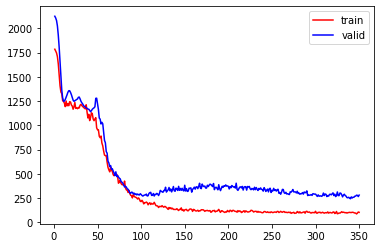

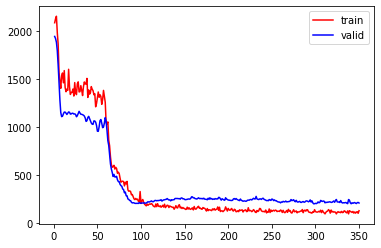

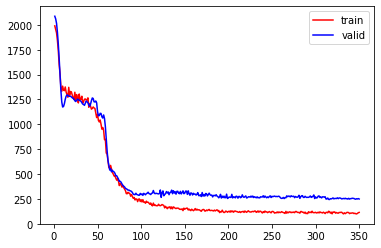

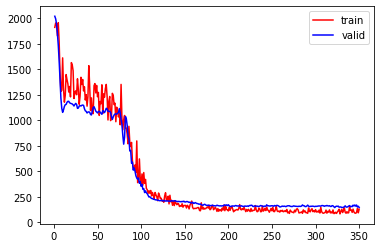

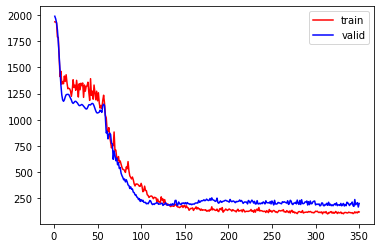

In [148]:
import matplotlib.pyplot as plt

for i in range(5):
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1)
    x_axis = np.arange(1, epochs+1)
    ax1.plot(x_axis, total_train_loss[i], c='red', label='train')
    ax1.plot(x_axis, total_valid_loss[i], c='blue', label='valid')
    plt.legend(loc='best')
    plt.show()

In [146]:
print('mse %.4f(%.4f)' % (np.mean(mse), np.std(mse)))
print('mad %.4f(%.4f)' % (np.mean(mad), np.std(mad)))
print('mape %.4f(%.4f)' % (np.mean(mape), np.std(mape)))
print('kappa %.4f(%.4f)' % (np.mean(kappa), np.std(kappa)))

mse 208.8830(14.8080)
mad 10.8629(0.4558)
mape 221.0994(42.4851)
kappa 0.6062(0.0170)


In [198]:
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import manifold
from sklearn import decomposition

#Generate COVID embedding
model = concare_target(input_dim = input_dim,output_dim=output_dim, d_model=d_model, MHD_num_head=MHD_num_head, d_ff=d_ff, hidden_dim=hidden_dim).to(device)
file_name = './model/concare-kl-trans-covid-challengnormalized-10-fold-LOS-regression10'
checkpoint = torch.load(file_name)
model.load_state_dict(checkpoint['net'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()

#case_all_x = long_x
#case_all_y = [tmp[-1] for tmp in long_time]
#case_all_x_len = all_x_len
test_x = []
test_time = []
test_x_len = []
fold_cnt = 0

n_splits = 10
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

for train, test in kfold.split(long_x, long_y):
    fold_cnt += 1
    if fold_cnt == 10:
        test_idx = test
        test_x = [long_x[i] for i in test]
        test_time = [long_time[i] for i in test]
        test_x_len = [all_x_len[i] for i in test]
        break
    
case_all_x, case_all_y, case_all_x_len = get_n2n_data(test_x, test_time, test_x_len)
# case_all_x, case_all_y, case_all_x_len = get_n2n_data(long_x, long_time, all_x_len)
print(len(case_all_x))
print(sum(all_x_len))

covid_emb = []
batch_loss = []
y_true = []
y_pred = []
pad_token = np.zeros(74)
with torch.no_grad():
    model.eval()
    for step, (batch_x, batch_y, batch_lens) in enumerate(ckd_batch_iter(case_all_x, case_all_y, case_all_x_len, batch_size)):  
        optimizer.zero_grad()
        batch_x = torch.tensor(pad_sents(batch_x, pad_token), dtype=torch.float32).to(device)
        batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)
        batch_lens = torch.tensor(batch_lens, dtype=torch.float32).to(device).int()

        masks = length_to_mask(batch_lens).unsqueeze(-1).float()

        opt, decov_loss, emb = model(batch_x, batch_lens)
        covid_emb.extend(emb.cpu().detach().numpy())
        y_pred.extend(opt.squeeze().cpu().detach().numpy())
        y_true.extend(batch_y.squeeze().cpu().detach().numpy())

        MSE_Loss = get_re_loss(opt, batch_y.unsqueeze(-1))
#             REC_Loss = F.mse_loss(masks * recon, masks * batch_x, reduction='mean').to(device)

        model_loss =  MSE_Loss 
        if step % 20 == 0:
            print('Batch %d: Test Loss = %.4f'%(step, model_loss.cpu().detach().numpy()))


502
6106
Batch 0: Test Loss = 30.7984


/home/ubicomp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


#### t-sne

In [192]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501, perplexity=5)
X_tsne = tsne.fit_transform(np.array(covid_emb))

print(len(X_tsne))

502


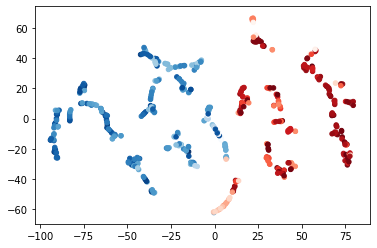

In [193]:
plt_c = [[] for i in range(2)]
plt_x = [[] for i in range(2)]
plt_y = [[] for i in range(2)]
cur_pos = 0
cmap_str = ['Blues', 'Reds']

for i in range(len(y_true)):
    if y_true[i] < 35:
        plt_c[0].append(max(0, 1-y_true[i]/35))
        plt_x[0].append(X_tsne[i,0])
        plt_y[0].append(X_tsne[i,1])
    else:
        plt_c[1].append(min(1, y_true[i]/35-1))
        plt_x[1].append(X_tsne[i,0])
        plt_y[1].append(X_tsne[i,1])
        
pdf = PdfPages('./figure/covidcare_no_trans_n2n_LOSregression_all_visit_tsne_2class_validset.pdf')

plt.scatter(plt_x[0], plt_y[0], s=20, c=plt_c[0], cmap=cmap_str[0], marker='o')
plt.scatter(plt_x[1], plt_y[1], s=20, c=plt_c[1], cmap=cmap_str[1], marker='o')

pdf.savefig()
plt.show()
pdf.close()

#### pca

In [199]:
pca = decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(np.array(covid_emb))

print(len(X_pca))

502


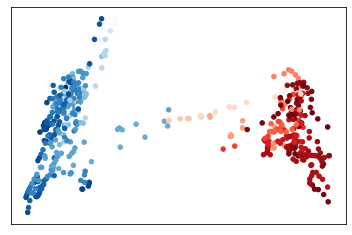

In [201]:
plt_c = [[] for i in range(2)]
plt_x = [[] for i in range(2)]
plt_y = [[] for i in range(2)]
cur_pos = 0
cmap_str = ['Blues', 'Reds']
'''
for i in range(len(test_time)):
    if test_time[i][-1] < 35:
        #print("Label 0: curpos = %d, len = %d" % (cur_pos, all_x_len[i]))
        plt_c[0].append(np.linspace(0, 1, test_x_len[i]))
        plt_x[0].append(X_pca[cur_pos:cur_pos+test_x_len[i],0])
        plt_y[0].append(X_pca[cur_pos:cur_pos+test_x_len[i],1])
    else:
        #print("Label 1: curpos = %d, len = %d" % (cur_pos, all_x_len[i]))
        plt_c[1].append(np.linspace(0, 1, test_x_len[i]))
        plt_x[1].append(X_pca[cur_pos:cur_pos+test_x_len[i],0])
        plt_y[1].append(X_pca[cur_pos:cur_pos+test_x_len[i],1])
    cur_pos += test_x_len[i]
'''

for i in range(len(y_true)):
    if y_true[i] < 35:
        plt_c[0].append(max(0, 1-y_true[i]/35))
        plt_x[0].append(X_pca[i,0])
        plt_y[0].append(X_pca[i,1])
    else:
        plt_c[1].append(min(1, y_true[i]/35-1))
        plt_x[1].append(X_pca[i,0])
        plt_y[1].append(X_pca[i,1])
    
        
pdf = PdfPages('./figure/covidcare_trans_n2n_LOSregression_all_visit_pca_2class_validset.pdf')

'''
for i in range(2):
    for step, (cur_x, cur_y, cur_c) in enumerate(zip(plt_x[i], plt_y[i], plt_c[i])):
        plt.scatter(cur_x, cur_y, s=20, c=cur_c, cmap=cmap_str[i], marker='o')
'''
plt.scatter(plt_x[0], plt_y[0], s=20, c=plt_c[0], cmap=cmap_str[0], marker='o')
plt.scatter(plt_x[1], plt_y[1], s=20, c=plt_c[1], cmap=cmap_str[1], marker='o')

plt.xticks([])
plt.yticks([])
pdf.savefig()
plt.show()
pdf.close()